In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys
import re

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests9 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True

In [4]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs7/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs7/'+name,dpi=300)
    plt.show()



In [5]:
def keep_alphanumeric(string):
    return re.sub(r'[^a-zA-Z0-9_]', '', string)


def mc_run_size(nobs,c1,c2,data_tuned_c=None):
    betas = np.linspace(0,3,linspace)
    results = []

    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
        gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,
                                              c1=c1,c2=c2,data_tuned_c=data_tuned_c)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
        print(beta,boot3)

    name = keep_alphanumeric('size_c1%s_c2%s_datac%s_nobs%s_trials%s'%(c1,c2,data_tuned_c,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

def mc_run_power(nobs,c1,c2,data_tuned_c=None):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
        gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,
                                              c1=c1,c2=c2,data_tuned_c=data_tuned_c)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

    name = keep_alphanumeric('size_c1%s_c2%s_datac%s_nobs%s_trials%s'%(c1,c2,data_tuned_c,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

# sequence 1

Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.47, 30th: 10.80, 50th: 18.53, 70th: 29.02, 90th: 44.67, 95th: 53.60, 99th: 69.63
bonus term 3.7795076583738703 // variance stats 10.676887459855502 //part1 44.132885580493685 //part2 11.676887459855504 10.676887459855502
2.0178906350569443 -0.9686031848897073 5.545537147033157
-5.541124681690796 -0.9686031848897073 -2.013478169714584
---
Quantiles: 1th: 0.68, 5th: 1.82, 10th: 3.30, 30th: 10.06, 50th: 17.21, 70th: 27.61, 90th: 43.49, 95th: 52.25, 99th: 69.01
bonus term 3.8689946405152544 // variance stats 9.813101403489402 //part1 41.83583137744847 //part2 10.813101403489402 9.813101403489402
2.0224804340369276 -1.0545221340599258 5.669500573623714
-5.715508846993581 -1.0545221340599258 -2.0684887074067944
---
Quantiles: 1th: 0.78, 5th: 1.98, 10th: 3.43, 30th: 10.14, 50th: 17.61, 70th: 26.70, 90th: 41.82, 95th: 50.19, 99th: 65.09
bonus term 4.391633831157065 // variance stats 7.810100558167051 //part1 38.69073566714215 //part2 8.81010055816705 7.

Quantiles: 1th: 0.76, 5th: 1.98, 10th: 3.25, 30th: 9.38, 50th: 15.81, 70th: 24.31, 90th: 38.17, 95th: 45.08, 99th: 58.91
bonus term 0.865080329626855 // variance stats 36.26254588131896 //part1 32.235095473747215 //part2 37.26254588131896 36.26254588131896
-1.141417900131724 0.45033092102300915 2.7331249284314576
-2.871578559385434 0.45033092102300915 1.0029642691777478
---
Quantiles: 1th: 0.71, 5th: 1.85, 10th: 3.06, 30th: 9.57, 50th: 16.47, 70th: 25.25, 90th: 39.77, 95th: 47.40, 99th: 63.80
bonus term 1.0916331927895135 // variance stats 31.058885321389823 //part1 34.996543340661646 //part2 32.05888532138982 31.058885321389823
-0.7853231136985641 0.25325755290103497 3.1525639106011236
-2.968589499277591 0.25325755290103497 0.9692975250220967
---
Quantiles: 1th: 0.66, 5th: 1.67, 10th: 2.92, 30th: 8.59, 50th: 15.02, 70th: 23.73, 90th: 37.39, 95th: 44.83, 99th: 59.42
bonus term 0.6895334332274601 // variance stats 43.84829750619374 //part1 30.924400553852298 //part2 44.84829750619373 43

Quantiles: 1th: 0.77, 5th: 1.92, 10th: 3.19, 30th: 8.86, 50th: 16.00, 70th: 24.57, 90th: 38.78, 95th: 46.18, 99th: 60.53
bonus term 3.425662415187908 // variance stats 8.709387258382664 //part1 33.26108300554586 //part2 9.709387258382664 8.709387258382664
1.6061343765542875 -1.0296202838156547 5.269240593656074
-5.245190453821528 -1.0296202838156547 -1.582084236719742
---
Quantiles: 1th: 0.80, 5th: 2.15, 10th: 3.40, 30th: 10.80, 50th: 18.67, 70th: 28.56, 90th: 44.85, 95th: 54.11, 99th: 70.36
bonus term 2.235074552015523 // variance stats 18.906633328520037 //part1 44.4928095688792 //part2 19.906633328520037 18.906633328520037
0.3547616115438934 -0.4509636932235263 4.015273743802853
-4.115387492487153 -0.4509636932235263 -0.4548753602281935
---
Quantiles: 1th: 0.60, 5th: 1.77, 10th: 2.92, 30th: 8.19, 50th: 14.29, 70th: 21.81, 90th: 34.32, 95th: 41.44, 99th: 55.47
bonus term 8.054030222346997 // variance stats 2.234320134588423 //part1 26.049312112720568 //part2 3.2343201345884234 2.2343

Quantiles: 1th: 0.68, 5th: 1.80, 10th: 3.26, 30th: 9.91, 50th: 17.41, 70th: 26.29, 90th: 41.62, 95th: 50.35, 99th: 64.08
bonus term 3.9129626559481903 // variance stats 8.794701875274141 //part1 38.32630266409342 //part2 9.794701875274141 8.794701875274141
2.1590556108362557 -1.081713519957063 5.705006630325547
-5.666869701060125 -1.081713519957063 -2.120918681570833
---
Quantiles: 1th: 0.65, 5th: 1.81, 10th: 3.52, 30th: 10.13, 50th: 17.83, 70th: 27.46, 90th: 43.75, 95th: 52.87, 99th: 68.18
bonus term 8.732406417153479 // variance stats 3.8496960141348313 //part1 42.349516595074654 //part2 4.849696014134831 3.8496960141348313
6.990423888974843 -2.6591469533887993 10.367513252687022
-10.474388945332116 -2.6591469533887993 -7.097299581619936
---
Quantiles: 1th: 0.72, 5th: 1.75, 10th: 3.14, 30th: 9.68, 50th: 17.18, 70th: 26.14, 90th: 42.11, 95th: 50.30, 99th: 65.37
bonus term 0.5205136747385352 // variance stats 74.35009882785373 //part1 39.22075683279793 //part2 75.35009882785373 74.3500

Quantiles: 1th: 0.68, 5th: 1.70, 10th: 2.74, 30th: 7.12, 50th: 12.85, 70th: 20.07, 90th: 31.59, 95th: 37.65, 99th: 49.86
bonus term 1.4996606676538609 // variance stats 13.72471882865484 //part1 22.082081669595897 //part2 14.724718828654842 13.72471882865484
-0.4602513758920864 -0.2802263915981599 3.3236788114338944
-3.4595727111998085 -0.2802263915981599 0.32435747612617255
---
Quantiles: 1th: 0.80, 5th: 1.77, 10th: 2.96, 30th: 8.80, 50th: 15.57, 70th: 23.81, 90th: 37.36, 95th: 45.23, 99th: 60.98
bonus term 1.727066927141571 // variance stats 16.878990378184813 //part1 30.878212972845358 //part2 17.878990378184813 16.878990378184813
-0.17375453210433467 -0.5591928938582191 3.591889643555114
-3.6278883863874767 -0.5591928938582191 0.1377557892719721
---
Quantiles: 1th: 0.68, 5th: 1.79, 10th: 3.12, 30th: 9.16, 50th: 16.12, 70th: 25.05, 90th: 39.61, 95th: 47.13, 99th: 63.43
bonus term 4.366461771506555 // variance stats 6.94989808256234 //part1 34.712926064881714 //part2 7.94989808256234

Quantiles: 1th: 0.83, 5th: 2.08, 10th: 4.24, 30th: 12.77, 50th: 21.64, 70th: 33.26, 90th: 52.04, 95th: 61.39, 99th: 83.36
bonus term 0.9486274180815671 // variance stats 62.14935259587345 //part1 59.90520730654594 //part2 63.149352595873445 62.14935259587345
-0.9912717321617103 0.7150737381131304 3.19635179406449
-2.8885265683248447 0.7150737381131304 1.2990969579013558
---
Quantiles: 1th: 0.71, 5th: 2.00, 10th: 3.72, 30th: 10.71, 50th: 18.23, 70th: 28.23, 90th: 44.82, 95th: 52.74, 99th: 68.07
bonus term 1.4077356273971853 // variance stats 30.569471671739777 //part1 44.44147001041427 //part2 31.56947167173978 30.569471671739777
-0.4417342301072268 0.1356874365556577 3.3562158412428023
-3.2572054849015974 0.1356874365556577 0.5407445864484322
---
Quantiles: 1th: 0.67, 5th: 1.94, 10th: 3.46, 30th: 10.58, 50th: 18.11, 70th: 28.19, 90th: 45.53, 95th: 53.16, 99th: 72.53
bonus term 1.3053067813185715 // variance stats 34.132412533908436 //part1 45.858576324592256 //part2 35.132412533908436 

Quantiles: 1th: 0.83, 5th: 2.26, 10th: 4.16, 30th: 13.01, 50th: 22.97, 70th: 35.88, 90th: 56.17, 95th: 66.49, 99th: 86.62
bonus term 13.027984445656562 // variance stats 4.357545571684262 //part1 69.79802037479875 //part2 5.357545571684261 4.357545571684262
11.197426178066522 -4.220639405020667 14.65862580620545
-14.858542713246603 -4.220639405020667 -11.397343085107675
---
Quantiles: 1th: 0.77, 5th: 1.90, 10th: 3.37, 30th: 10.35, 50th: 18.20, 70th: 28.18, 90th: 45.73, 95th: 53.02, 99th: 68.89
bonus term 1.2586337624598742 // variance stats 35.755337277169964 //part1 46.2615084476461 //part2 36.755337277169964 35.755337277169964
-0.600852545177208 0.08177203610473352 3.178158023516892
-3.1181200700969565 0.08177203610473352 0.6608904985971435
---
Quantiles: 1th: 0.87, 5th: 2.23, 10th: 3.72, 30th: 10.14, 50th: 17.40, 70th: 25.89, 90th: 41.33, 95th: 49.41, 99th: 66.65
bonus term 5.984423288039099 // variance stats 5.314888744039294 //part1 37.79096726120473 //part2 6.314888744039294 5.31

Quantiles: 1th: 0.70, 5th: 1.76, 10th: 3.22, 30th: 9.02, 50th: 15.80, 70th: 24.19, 90th: 37.97, 95th: 45.13, 99th: 57.31
bonus term 0.767783696912286 // variance stats 40.53065872908978 //part1 31.88656269422305 //part2 41.53065872908978 40.53065872908978
-1.1249256343093872 0.5233908612503216 2.8095268972153336
-2.660493028133959 0.5233908612503216 1.2739595033907618
---
Quantiles: 1th: 0.73, 5th: 1.86, 10th: 3.00, 30th: 8.99, 50th: 15.45, 70th: 23.94, 90th: 37.81, 95th: 45.11, 99th: 58.91
bonus term 4.2612279862521305 // variance stats 6.422005187880479 //part1 31.62685622070479 //part2 7.422005187880478 6.422005187880479
2.5973296657620466 -2.4889160897512976 6.030657791404167
-5.925126306742214 -2.4889160897512976 -2.491798181100094
---
Quantiles: 1th: 0.71, 5th: 1.78, 10th: 3.40, 30th: 11.16, 50th: 19.92, 70th: 30.88, 90th: 49.34, 95th: 58.69, 99th: 75.51
bonus term 5.250463118498193 // variance stats 9.256664162110571 //part1 53.85223690198373 //part2 10.256664162110571 9.2566641

Quantiles: 1th: 0.76, 5th: 1.75, 10th: 2.95, 30th: 7.79, 50th: 13.59, 70th: 20.49, 90th: 32.15, 95th: 38.80, 99th: 50.27
bonus term 0.9345765433310976 // variance stats 23.470433346505388 //part1 22.86949301079103 //part2 24.470433346505388 23.470433346505388
-0.9544089517599166 -0.5334507831873224 2.8522114808674406
-2.823562038422112 -0.5334507831873224 0.9830583942052453
---
Quantiles: 1th: 0.68, 5th: 2.20, 10th: 4.32, 30th: 12.02, 50th: 21.01, 70th: 32.17, 90th: 51.11, 95th: 60.88, 99th: 78.79
bonus term 5.35522877225223 // variance stats 9.792276526379357 //part1 57.7951097721691 //part2 10.792276526379359 9.792276526379357
3.385058375522891 -2.2564905781507405 7.129424950497638
-7.325399168981568 -2.2564905781507405 -3.581032594006821
---
Quantiles: 1th: 0.66, 5th: 1.94, 10th: 3.56, 30th: 10.89, 50th: 19.01, 70th: 28.96, 90th: 46.28, 95th: 53.97, 99th: 72.34
bonus term 2.5224919698344928 // variance stats 17.77953193406402 //part1 47.371218500926915 //part2 18.77953193406402 17.7

Quantiles: 1th: 0.68, 5th: 1.71, 10th: 2.96, 30th: 8.62, 50th: 14.86, 70th: 22.70, 90th: 35.42, 95th: 42.05, 99th: 55.83
bonus term 2.1957641257269827 // variance stats 11.640383895749656 //part1 27.75530149370417 //part2 12.640383895749656 11.640383895749656
0.4101428467797089 -1.6689105243636724 3.9276120882695174
-3.9813854046742563 -1.6689105243636724 -0.463916163184448
---
Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.40, 30th: 10.06, 50th: 17.41, 70th: 26.86, 90th: 43.48, 95th: 51.50, 99th: 66.37
bonus term 2.805808245827922 // variance stats 13.90320610993372 //part1 41.8155385925251 //part2 14.90320610993372 13.90320610993372
1.0092586054599897 -1.9333825887517113 4.59488566027179
-4.602357886195854 -1.9333825887517113 -1.0167308313840544
---
Quantiles: 1th: 0.79, 5th: 1.88, 10th: 3.43, 30th: 9.56, 50th: 17.20, 70th: 26.95, 90th: 42.16, 95th: 50.77, 99th: 67.06
bonus term 1.156567986856795 // variance stats 32.997604982252426 //part1 39.32054155227623 //part2 33.997604982252426 32.9

Quantiles: 1th: 0.88, 5th: 2.17, 10th: 3.76, 30th: 10.73, 50th: 18.78, 70th: 29.02, 90th: 46.65, 95th: 55.12, 99th: 72.66
bonus term 6.406307961374429 // variance stats 6.514262564745402 //part1 48.13868009238631 //part2 7.514262564745402 6.514262564745402
4.3097193766904835 -3.872886605158281 8.243019855017621
-8.502896546058373 -3.872886605158281 -4.569596067731236
---
Quantiles: 1th: 0.75, 5th: 1.81, 10th: 3.27, 30th: 9.72, 50th: 17.18, 70th: 26.32, 90th: 41.64, 95th: 50.24, 99th: 64.22
bonus term 5.3902689559143555 // variance stats 6.116533044759893 //part1 38.360027144907924 //part2 7.116533044759893 6.116533044759893
3.311954457382143 -4.536657368030085 7.2465210567556015
-7.468583454446568 -4.536657368030085 -3.53401685507311
---
Quantiles: 1th: 0.87, 5th: 2.13, 10th: 3.63, 30th: 10.41, 50th: 18.39, 70th: 28.46, 90th: 44.82, 95th: 52.86, 99th: 68.81
bonus term 1.2705725836560482 // variance stats 33.978085448107336 //part1 44.44219639914376 //part2 34.978085448107336 33.9780854

Quantiles: 1th: 0.85, 5th: 2.17, 10th: 3.86, 30th: 11.10, 50th: 19.69, 70th: 30.44, 90th: 48.75, 95th: 57.16, 99th: 72.31
bonus term 8.83914559041864 // variance stats 4.947491800876892 //part1 52.57074592577201 //part2 5.947491800876893 4.947491800876892
6.882814581902835 -4.455667065730691 10.561777469995324
-10.795476598934446 -4.455667065730691 -7.116513710841957
---
Quantiles: 1th: 0.61, 5th: 1.60, 10th: 2.80, 30th: 8.11, 50th: 13.97, 70th: 21.51, 90th: 34.14, 95th: 40.50, 99th: 53.19
bonus term 1.809293984034165 // variance stats 13.25036540209561 //part1 25.783100392300195 //part2 14.25036540209561 13.25036540209561
-0.13594620992563303 -1.999979914565891 3.5939694222554426
-3.7545341779939636 -1.999979914565891 -0.02461854581288778
---
Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.28, 30th: 9.20, 50th: 16.18, 70th: 25.17, 90th: 39.97, 95th: 46.84, 99th: 63.59
bonus term 5.250512124919149 // variance stats 5.731797665071548 //part1 35.34538526296058 //part2 6.731797665071548 5.731797

Quantiles: 1th: 0.60, 5th: 1.56, 10th: 2.97, 30th: 8.50, 50th: 15.03, 70th: 22.83, 90th: 36.83, 95th: 44.12, 99th: 57.65
bonus term 2.996639957352326 // variance stats 9.012582041637787 //part1 30.004103422240124 //part2 10.012582041637788 9.012582041637787
1.1838791023222497 -3.073031696791218 4.705755585189843
-4.809400812382402 -3.073031696791218 -1.2875243295148093
---
Quantiles: 1th: 0.76, 5th: 1.92, 10th: 3.24, 30th: 9.51, 50th: 16.68, 70th: 25.32, 90th: 40.07, 95th: 47.26, 99th: 63.76
bonus term 3.6502075803203975 // variance stats 8.729866537256973 //part1 35.51603258980118 //part2 9.729866537256973 8.729866537256973
1.7432598659829788 -4.502845448468053 5.513376785061048
-5.557155294657815 -4.502845448468053 -1.7870383755797465
---
Quantiles: 1th: 0.61, 5th: 1.62, 10th: 2.66, 30th: 7.58, 50th: 13.04, 70th: 19.71, 90th: 31.20, 95th: 37.10, 99th: 49.57
bonus term 0.781064178999769 // variance stats 26.574951439575734 //part1 21.53780680711072 //part2 27.574951439575734 26.574951

Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.51, 30th: 10.63, 50th: 18.29, 70th: 27.60, 90th: 44.06, 95th: 52.39, 99th: 69.54
bonus term 1.1277842128456825 // variance stats 37.08596174444364 //part1 42.95274638642815 //part2 38.08596174444364 37.08596174444364
-0.813916186632075 -0.39487189351213936 3.138247285654572
-3.0694846123234405 -0.39487189351213936 0.8826788599632068
---
Quantiles: 1th: 0.66, 5th: 1.99, 10th: 3.50, 30th: 10.18, 50th: 17.76, 70th: 27.65, 90th: 44.37, 95th: 52.19, 99th: 69.25
bonus term 3.362896343042672 // variance stats 11.947713206811464 //part1 43.54181739395158 //part2 12.947713206811464 11.947713206811464
1.4301177945557721 -3.657821104446818 5.075751246267527
-5.295674891529572 -3.657821104446818 -1.6500414398178176
---
Quantiles: 1th: 0.73, 5th: 1.84, 10th: 3.12, 30th: 9.01, 50th: 15.63, 70th: 23.96, 90th: 37.50, 95th: 45.13, 99th: 60.63
bonus term 2.1520962016313177 // variance stats 13.457125870686557 //part1 31.113125672810398 //part2 14.457125870686557 

Quantiles: 1th: 0.81, 5th: 1.79, 10th: 2.98, 30th: 8.56, 50th: 15.03, 70th: 23.24, 90th: 36.82, 95th: 43.63, 99th: 57.93
bonus term 2.2080621615593192 // variance stats 12.582438111219492 //part1 29.990867655104985 //part2 13.582438111219492 12.582438111219492
0.24994060707649143 -2.911759983896083 4.132897003569292
-4.166183716042147 -2.911759983896083 -0.2832273195493454
---
Quantiles: 1th: 0.79, 5th: 1.89, 10th: 3.13, 30th: 8.92, 50th: 15.88, 70th: 24.04, 90th: 38.30, 95th: 45.02, 99th: 60.10
bonus term 0.8095728056874911 // variance stats 39.08295727480614 //part1 32.45007218121664 //part2 40.08295727480614 39.08295727480614
-1.0090652713900803 -0.31444081453351724 2.7818512959477606
-2.6282108827650625 -0.31444081453351724 1.1627056845727786
---
Quantiles: 1th: 0.89, 5th: 2.25, 10th: 4.11, 30th: 11.76, 50th: 20.40, 70th: 31.45, 90th: 50.34, 95th: 59.39, 99th: 79.37
bonus term 1.3102688683698116 // variance stats 41.78977489880587 //part1 56.06610993445733 //part2 42.78977489880586

Quantiles: 1th: 0.66, 5th: 1.49, 10th: 2.38, 30th: 6.80, 50th: 11.98, 70th: 18.47, 90th: 29.59, 95th: 35.03, 99th: 45.34
bonus term 0.8701481130736639 // variance stats 21.262963598295435 //part1 19.37207576648444 //part2 22.262963598295435 21.262963598295435
-1.1975476118953678 -1.7855385068727054 2.791197024896755
-2.937843838042696 -1.7855385068727054 1.0509007987494274
---
Quantiles: 1th: 0.85, 5th: 1.99, 10th: 3.72, 30th: 11.50, 50th: 20.16, 70th: 31.26, 90th: 49.62, 95th: 58.78, 99th: 75.35
bonus term 1.6328508336899838 // variance stats 32.35721141261224 //part1 54.467350464656924 //part2 33.35721141261224 32.35721141261224
-0.25054333416197977 -1.20869177647286 3.694885272831409
-3.5162450015419475 -1.20869177647286 0.4291836054514413
---
Quantiles: 1th: 0.72, 5th: 1.90, 10th: 3.44, 30th: 10.36, 50th: 17.57, 70th: 26.14, 90th: 41.02, 95th: 48.72, 99th: 64.51
bonus term 1.5425461811569043 // variance stats 23.128705486461747 //part1 37.21964250440122 //part2 24.12870548646175 23

Quantiles: 1th: 0.65, 5th: 1.79, 10th: 2.87, 30th: 8.27, 50th: 14.66, 70th: 22.92, 90th: 35.82, 95th: 42.27, 99th: 55.11
bonus term 2.266561152334826 // variance stats 11.522614439519199 //part1 28.38327141428137 //part2 12.522614439519199 11.522614439519199
0.2222485320822134 -3.6731820913459456 4.017038272105756
-4.310873772587438 -3.6731820913459456 -0.5160840325638958
---
Quantiles: 1th: 0.62, 5th: 1.79, 10th: 3.19, 30th: 9.83, 50th: 16.98, 70th: 26.34, 90th: 41.47, 95th: 49.83, 99th: 65.90
bonus term 3.2577542986372974 // variance stats 10.677435165293732 //part1 38.042214606794 //part2 11.677435165293733 10.677435165293732
1.444930488105019 -5.3351762390422826 4.923079689848215
-5.070578109169576 -5.3351762390422826 -1.592428907426379
---
Quantiles: 1th: 0.60, 5th: 1.82, 10th: 3.05, 30th: 8.34, 50th: 14.82, 70th: 22.66, 90th: 36.73, 95th: 44.37, 99th: 57.39
bonus term 0.7953257171262962 // variance stats 36.51798330061205 //part1 29.839016973691685 //part2 37.51798330061205 36.51

Quantiles: 1th: 0.69, 5th: 1.84, 10th: 3.29, 30th: 10.12, 50th: 17.72, 70th: 27.26, 90th: 42.55, 95th: 50.02, 99th: 64.68
bonus term 2.1064969275225307 // variance stats 18.01443681582891 //part1 40.05385273111489 //part2 19.01443681582891 18.01443681582891
0.2577726004575768 -2.4477157841667494 3.9793085096203975
-3.9552212545874847 -2.4477157841667494 -0.2336853454246641
---
Quantiles: 1th: 0.73, 5th: 2.00, 10th: 3.37, 30th: 9.59, 50th: 16.47, 70th: 25.63, 90th: 40.58, 95th: 47.71, 99th: 63.38
bonus term 2.344294497755421 // variance stats 14.537235940222697 //part1 36.42385672499185 //part2 15.537235940222697 14.537235940222697
0.4144954121220494 -3.6585087504132425 4.361878899525935
-4.274093583388793 -3.6585087504132425 -0.3267100959849063
---
Quantiles: 1th: 0.73, 5th: 1.92, 10th: 3.36, 30th: 10.28, 50th: 17.68, 70th: 27.40, 90th: 43.48, 95th: 51.12, 99th: 67.60
bonus term 1.832031470202547 // variance stats 21.82949615073219 //part1 41.824355397009285 //part2 22.82949615073219 2

Quantiles: 1th: 0.74, 5th: 1.82, 10th: 3.36, 30th: 9.55, 50th: 16.68, 70th: 26.51, 90th: 42.06, 95th: 49.63, 99th: 66.20
bonus term 1.1270933759894268 // variance stats 33.71402850406046 //part1 39.125951580834695 //part2 34.71402850406046 33.71402850406046
-0.794394018066804 -1.2484231515281852 3.02998787236844
-3.0485807700456578 -1.2484231515281852 0.7758011203895864
---
Quantiles: 1th: 0.82, 5th: 2.11, 10th: 3.30, 30th: 9.33, 50th: 16.64, 70th: 26.17, 90th: 41.46, 95th: 49.09, 99th: 62.93
bonus term 2.7115486325310822 // variance stats 13.024814948206329 //part1 38.02896779431036 //part2 14.02481494820633 13.024814948206329
0.511296204961968 -5.374413629702011 4.456969706682313
-4.9118010601001965 -5.374413629702011 -0.9661275583798519
---
Quantiles: 1th: 0.74, 5th: 1.74, 10th: 2.75, 30th: 7.24, 50th: 12.55, 70th: 19.28, 90th: 30.15, 95th: 36.37, 99th: 47.15
bonus term 0.9876649727993765 // variance stats 19.36236860236679 //part1 20.111198231787473 //part2 20.36236860236679 19.362

Quantiles: 1th: 0.63, 5th: 1.75, 10th: 3.15, 30th: 9.66, 50th: 17.14, 70th: 25.70, 90th: 40.98, 95th: 48.24, 99th: 64.00
bonus term 0.5207905394010758 // variance stats 70.32323627816668 //part1 37.1444666931368 //part2 71.32323627816668 70.32323627816668
-1.6315480583141735 0.24405437057938387 2.42685996070648
-2.673129137116325 0.24405437057938387 1.3852788819043285
---
Quantiles: 1th: 0.81, 5th: 1.91, 10th: 3.30, 30th: 9.37, 50th: 16.72, 70th: 25.84, 90th: 41.26, 95th: 48.68, 99th: 63.46
bonus term 1.6648942976518757 // variance stats 21.61529529192812 //part1 37.652076171244445 //part2 22.61529529192812 21.61529529192812
-0.44756217573085666 -3.2156046519933836 3.4919404964971887
-3.7773507710346084 -3.2156046519933836 0.1621519011934371
---
Quantiles: 1th: 0.69, 5th: 1.68, 10th: 2.97, 30th: 8.32, 50th: 14.47, 70th: 22.61, 90th: 35.07, 95th: 41.07, 99th: 55.30
bonus term 0.9469668278168099 // variance stats 27.737268373164646 //part1 27.213239871456064 //part2 28.737268373164646 27

Quantiles: 1th: 0.74, 5th: 2.10, 10th: 3.57, 30th: 10.33, 50th: 18.62, 70th: 29.08, 90th: 45.26, 95th: 53.53, 99th: 69.41
bonus term 2.1146930517279374 // variance stats 20.425588689100348 //part1 45.3085435300212 //part2 21.425588689100348 20.425588689100348
0.026401555678212344 -3.831010832087188 3.891311654294311
-4.202984547777662 -3.831010832087188 -0.3380744491615637
---
Quantiles: 1th: 0.67, 5th: 1.88, 10th: 3.48, 30th: 10.18, 50th: 17.97, 70th: 27.83, 90th: 43.83, 95th: 53.53, 99th: 70.20
bonus term 1.3438617954240224 // variance stats 30.625622781629453 //part1 42.50046621272342 //part2 31.625622781629453 30.625622781629453
-0.7686591456054072 -1.7427884372974285 3.228409915421431
-3.456382736453452 -1.7427884372974285 0.5406863245733865
---
Quantiles: 1th: 0.64, 5th: 1.89, 10th: 3.62, 30th: 10.26, 50th: 17.65, 70th: 27.37, 90th: 43.29, 95th: 51.75, 99th: 68.45
bonus term 1.0005320410755831 // variance stats 40.43402319694298 //part1 41.456067799210416 //part2 41.4340231969429

Quantiles: 1th: 0.69, 5th: 1.68, 10th: 3.01, 30th: 8.78, 50th: 15.50, 70th: 23.67, 90th: 38.11, 95th: 45.25, 99th: 58.97
bonus term 0.9833232727053602 // variance stats 31.674169842830246 //part1 32.129271622782625 //part2 32.674169842830246 31.674169842830246
-0.9982440657034731 -2.6419529385010048 2.8654239030034647
-2.9648906111141935 -2.6419529385010048 0.8987773575927444
---
Quantiles: 1th: 0.60, 5th: 1.63, 10th: 2.81, 30th: 8.33, 50th: 14.36, 70th: 22.44, 90th: 35.67, 95th: 41.89, 99th: 52.62
bonus term 1.8547049895629788 // variance stats 14.176978882252246 //part1 28.148818459405206 //part2 15.176978882252248 14.176978882252246
-0.22817150722885512 -5.465291922334995 3.4263884782769956
-3.937581486354813 -5.465291922334995 -0.28302150084896227
---
Quantiles: 1th: 0.67, 5th: 1.84, 10th: 3.05, 30th: 8.21, 50th: 14.30, 70th: 22.27, 90th: 34.47, 95th: 41.28, 99th: 55.90
bonus term 1.0013831744124906 // variance stats 25.255990218899434 //part1 26.29230683274482 //part2 26.255990218

Quantiles: 1th: 0.66, 5th: 1.62, 10th: 2.69, 30th: 7.90, 50th: 13.39, 70th: 20.37, 90th: 32.08, 95th: 37.64, 99th: 48.92
bonus term 0.7180264279412334 // variance stats 30.708994102900682 //part1 22.767895769315412 //part2 31.708994102900686 30.708994102900682
-1.2416456860469254 -2.940469040942901 2.6062193166893106
-2.6776985419293924 -2.940469040942901 1.170166460806844
---
Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.27, 30th: 9.81, 50th: 17.16, 70th: 26.41, 90th: 42.48, 95th: 50.64, 99th: 65.75
bonus term 1.7031149596463826 // variance stats 22.43535032631531 //part1 39.91309572530134 //part2 23.43535032631531 22.43535032631531
-0.3071710363580742 -3.0001708532094384 3.6480633268949183
-3.7134009556508394 -3.0001708532094384 0.2418334076021531
---
Quantiles: 1th: 0.87, 5th: 2.13, 10th: 3.81, 30th: 10.24, 50th: 17.49, 70th: 26.64, 90th: 42.00, 95th: 50.60, 99th: 66.05
bonus term 1.5753523667517788 // variance stats 23.76989128773209 //part1 39.02130686431302 //part2 24.76989128773209 2

Quantiles: 1th: 0.80, 5th: 1.97, 10th: 3.25, 30th: 10.13, 50th: 17.87, 70th: 28.17, 90th: 45.29, 95th: 54.33, 99th: 70.41
bonus term 1.6407115852836525 // variance stats 26.65673456648475 //part1 45.37672481434638 //part2 27.65673456648475 26.65673456648475
-0.5801767293568337 -3.621440308141658 3.619459380839224
-3.8615998999241388 -3.621440308141658 0.3380362102719188
---
Quantiles: 1th: 0.73, 5th: 1.89, 10th: 3.63, 30th: 11.87, 50th: 20.70, 70th: 31.98, 90th: 49.96, 95th: 59.56, 99th: 78.52
bonus term 1.6517968297265344 // variance stats 32.42565987418579 //part1 55.21239901169752 //part2 33.42565987418579 32.42565987418579
-0.3055625249391897 -2.360855198558826 3.5176745223923556
-3.609156184392259 -2.360855198558826 0.21408086293928708
---
Quantiles: 1th: 0.76, 5th: 2.03, 10th: 3.70, 30th: 10.88, 50th: 19.28, 70th: 30.07, 90th: 47.15, 95th: 57.03, 99th: 74.85
bonus term 2.223788953719396 // variance stats 21.11740370016008 //part1 49.18443803336848 //part2 22.11740370016008 21.117

Quantiles: 1th: 0.66, 5th: 1.68, 10th: 2.80, 30th: 8.03, 50th: 14.22, 70th: 21.73, 90th: 34.14, 95th: 40.98, 99th: 54.64
bonus term 1.2073868178457852 // variance stats 20.359945475706954 //part1 25.789716597273298 //part2 21.359945475706958 20.359945475706954
-0.9407063351466414 -4.456246792564543 3.0901606173037512
-3.355479970838212 -4.456246792564543 0.6753869816121812
---
Quantiles: 1th: 0.68, 5th: 1.75, 10th: 3.07, 30th: 9.30, 50th: 16.01, 70th: 24.26, 90th: 39.40, 95th: 47.26, 99th: 61.70
bonus term 2.040934126774045 // variance stats 15.825013668666834 //part1 34.33874457982192 //part2 16.825013668666834 15.825013668666834
0.2426281122379045 -6.227663837961295 3.685851509171685
-3.8392401413101855 -6.227663837961295 -0.39601674437640555
---
Quantiles: 1th: 0.86, 5th: 2.32, 10th: 4.03, 30th: 11.90, 50th: 20.64, 70th: 31.34, 90th: 49.23, 95th: 58.33, 99th: 80.48
bonus term 2.8065710056497024 // variance stats 18.103369312525054 //part1 53.61496242275111 //part2 19.103369312525057

Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.58, 30th: 10.23, 50th: 17.73, 70th: 27.02, 90th: 42.69, 95th: 50.70, 99th: 66.62
bonus term 0.5371157361758584 // variance stats 74.07535804720256 //part1 40.32415620618935 //part2 75.07535804720256 74.07535804720256
-1.4740426408143175 -0.4207906028030673 2.4569432372342668
-2.5482741131660345 -0.4207906028030673 1.3827117648825502
---
Quantiles: 1th: 0.81, 5th: 1.87, 10th: 3.37, 30th: 9.61, 50th: 16.91, 70th: 25.77, 90th: 41.57, 95th: 48.90, 99th: 63.80
bonus term 1.7017724121347222 // variance stats 21.466039040383027 //part1 38.23208544886547 //part2 22.466039040383027 21.466039040383027
-0.11690925866302458 -4.976605322180106 3.3678771639066936
-3.520454082932469 -4.976605322180106 -0.035667660362750805
---
Quantiles: 1th: 0.73, 5th: 1.84, 10th: 3.05, 30th: 8.83, 50th: 15.58, 70th: 23.80, 90th: 37.85, 95th: 45.24, 99th: 58.21
bonus term 1.7527527400912937 // variance stats 17.07890137466573 //part1 31.687843922285612 //part2 18.078901374665

Quantiles: 1th: 0.79, 5th: 2.08, 10th: 3.69, 30th: 10.85, 50th: 19.17, 70th: 29.00, 90th: 45.10, 95th: 53.70, 99th: 70.06
bonus term 2.2985084526338024 // variance stats 18.579019640499645 //part1 45.002542137971666 //part2 19.579019640499645 18.579019640499645
-0.1668413136074351 -7.984382971868519 4.337168788108421
-4.76385821887504 -7.984382971868519 -0.2598481171591831
---
Quantiles: 1th: 0.78, 5th: 2.01, 10th: 3.37, 30th: 10.24, 50th: 18.15, 70th: 28.44, 90th: 45.37, 95th: 53.22, 99th: 72.37
bonus term 1.7208275101095938 // variance stats 25.456132389967646 //part1 45.526440427757805 //part2 26.456132389967646 25.456132389967646
-0.2476053873082949 -4.323379038923674 3.5368252889591143
-3.6892604075274824 -4.323379038923674 0.09517026873992714
---
Quantiles: 1th: 0.60, 5th: 1.56, 10th: 2.92, 30th: 9.07, 50th: 15.92, 70th: 24.32, 90th: 38.91, 95th: 46.38, 99th: 61.38
bonus term 0.647564423844341 // variance stats 50.72655595645057 //part1 33.49627740539097 //part2 51.72655595645057

Quantiles: 1th: 0.64, 5th: 1.67, 10th: 2.72, 30th: 6.91, 50th: 12.04, 70th: 18.43, 90th: 29.55, 95th: 34.86, 99th: 45.00
bonus term 0.5918992051773944 // variance stats 31.63994294492688 //part1 19.319556286137722 //part2 32.63994294492688 31.63994294492688
-1.4682263545024998 -4.139030103408748 2.311817522624368
-2.6520247648572886 -4.139030103408748 1.128019112269579
---
Quantiles: 1th: 0.92, 5th: 2.37, 10th: 4.04, 30th: 11.25, 50th: 19.37, 70th: 29.45, 90th: 46.25, 95th: 55.59, 99th: 72.18
bonus term 2.5745359673438686 // variance stats 17.380564267857412 //part1 47.32142380767443 //part2 18.380564267857412 17.380564267857412
0.45875398175146714 -6.834274611071509 4.461598374550961
-4.69031795293627 -6.834274611071509 -0.6874735601367755
---
Quantiles: 1th: 0.57, 5th: 1.64, 10th: 3.10, 30th: 8.92, 50th: 16.02, 70th: 24.46, 90th: 39.02, 95th: 47.51, 99th: 62.15
bonus term 0.8392686894753368 // variance stats 39.125582473650205 //part1 33.67614501709495 //part2 40.125582473650205 39.1

Quantiles: 1th: 0.78, 5th: 1.75, 10th: 2.88, 30th: 8.12, 50th: 14.18, 70th: 21.64, 90th: 34.73, 95th: 41.44, 99th: 53.32
bonus term 1.1408231020452964 // variance stats 22.383406758928437 //part1 26.676330635107693 //part2 23.38340675892844 22.383406758928437
-0.7775617215016534 -5.379127778804346 2.958211650237308
-3.059207925592246 -5.379127778804346 0.6765654461467152
---
Quantiles: 1th: 0.86, 5th: 2.28, 10th: 4.19, 30th: 12.52, 50th: 21.17, 70th: 32.00, 90th: 50.42, 95th: 59.75, 99th: 76.52
bonus term 0.995072876067334 // variance stats 55.52289053458729 //part1 56.24439524789086 //part2 56.52289053458729 55.52289053458729
-1.1299580177657058 -2.0206560645345095 2.872775707420807
-3.120103769900374 -2.0206560645345095 0.8826299552861395
---
Quantiles: 1th: 0.77, 5th: 2.02, 10th: 3.20, 30th: 9.03, 50th: 15.32, 70th: 23.57, 90th: 36.35, 95th: 44.31, 99th: 59.02
bonus term 1.413647966638782 // variance stats 19.680879486087118 //part1 29.23548323380875 //part2 20.680879486087118 19.68

Quantiles: 1th: 0.74, 5th: 1.96, 10th: 3.77, 30th: 11.18, 50th: 19.47, 70th: 30.50, 90th: 46.68, 95th: 56.62, 99th: 76.41
bonus term 2.8568371376508317 // variance stats 15.870619113529202 //part1 48.196611218692176 //part2 16.8706191135292 15.870619113529202
0.6679257912041451 -8.575321241412164 4.572238687622546
-5.045748484097518 -8.575321241412164 -1.1414355876791178
---
Quantiles: 1th: 0.68, 5th: 2.00, 10th: 3.62, 30th: 10.51, 50th: 18.69, 70th: 27.72, 90th: 43.58, 95th: 52.23, 99th: 67.34
bonus term 1.2473665031892516 // variance stats 32.681971468174815 //part1 42.01376297077737 //part2 33.681971468174815 32.681971468174815
-0.8899800925341268 -4.226604812514467 3.1840851203733247
-3.38471309891263 -4.226604812514467 0.6893521139948218
---
Quantiles: 1th: 0.68, 5th: 1.79, 10th: 3.16, 30th: 9.34, 50th: 16.18, 70th: 24.86, 90th: 39.78, 95th: 47.78, 99th: 62.03
bonus term 1.936550994309342 // variance stats 17.078520758546677 //part1 35.00997735060565 //part2 18.07852075854668 17.0

Quantiles: 1th: 0.87, 5th: 2.27, 10th: 3.96, 30th: 11.51, 50th: 19.88, 70th: 30.85, 90th: 49.10, 95th: 58.76, 99th: 77.08
bonus term 0.8612746174773225 // variance stats 60.929002441666434 //part1 53.33787788869843 //part2 61.929002441666434 60.929002441666434
-1.090573342996729 -2.120081999301145 2.6774423310576165
-2.813122577951374 -2.120081999301145 0.9548930961029716
---
Quantiles: 1th: 0.80, 5th: 2.17, 10th: 3.81, 30th: 10.96, 50th: 18.97, 70th: 29.22, 90th: 45.63, 95th: 54.77, 99th: 72.64
bonus term 1.421984263108823 // variance stats 31.395731873546797 //part1 46.06622091607646 //part2 32.3957318735468 31.395731873546797
-0.5442251347032462 -3.7158313308535442 3.233545822377624
-3.388193660920892 -3.7158313308535442 0.3895772961599779
---
Quantiles: 1th: 0.70, 5th: 1.86, 10th: 3.15, 30th: 8.82, 50th: 15.35, 70th: 23.47, 90th: 36.78, 95th: 43.90, 99th: 55.80
bonus term 1.2245847884153298 // variance stats 23.44188704093867 //part1 29.931163070499277 //part2 24.441887040938674 23

Quantiles: 1th: 0.75, 5th: 1.70, 10th: 2.98, 30th: 8.38, 50th: 14.39, 70th: 22.04, 90th: 35.61, 95th: 42.50, 99th: 56.94
bonus term 0.7272049625666233 // variance stats 37.568011004453666 //part1 28.04684899876284 //part2 38.568011004453666 37.568011004453666
-1.444695355935724 -4.455975482613479 2.6135142319106306
-2.899105281068971 -4.455975482613479 1.1591043067773843
---
Quantiles: 1th: 0.80, 5th: 1.87, 10th: 3.41, 30th: 9.75, 50th: 16.94, 70th: 25.62, 90th: 40.41, 95th: 48.25, 99th: 63.38
bonus term 1.8408157008893191 // variance stats 18.62056846839824 //part1 36.11785049700138 //part2 19.62056846839824 18.62056846839824
-0.5647724767707534 -10.243258404242612 3.866757536815124
-4.246403878549391 -10.243258404242612 0.18512613503648603
---
Quantiles: 1th: 0.70, 5th: 2.07, 10th: 3.64, 30th: 11.11, 50th: 19.35, 70th: 29.43, 90th: 46.62, 95th: 56.33, 99th: 72.88
bonus term 2.299664842836196 // variance stats 19.90347170595033 //part1 48.070978975395136 //part2 20.90347170595033 19.9

Quantiles: 1th: 0.60, 5th: 1.66, 10th: 2.87, 30th: 8.49, 50th: 14.73, 70th: 22.37, 90th: 35.27, 95th: 41.38, 99th: 53.82
bonus term 1.3285436757705975 // variance stats 19.71364594798082 //part1 27.518983326341186 //part2 20.71364594798082 19.71364594798082
-0.9744619593875772 -8.863460499729916 3.425268801736291
-3.631549310928772 -8.863460499729916 0.7681814501950962
---
Quantiles: 1th: 0.75, 5th: 2.15, 10th: 3.47, 30th: 10.50, 50th: 18.87, 70th: 29.05, 90th: 46.12, 95th: 55.42, 99th: 72.69
bonus term 1.6841581307781472 // variance stats 26.938580139892533 //part1 47.05298690499687 //part2 27.938580139892537 26.938580139892533
-0.5458858468183476 -6.757827267001759 3.578976562349282
-3.9142021083746426 -6.757827267001759 0.2106603007929874
---
Quantiles: 1th: 0.79, 5th: 2.01, 10th: 3.81, 30th: 11.24, 50th: 19.69, 70th: 30.41, 90th: 48.76, 95th: 57.42, 99th: 76.05
bonus term 1.0157300952684 // variance stats 50.773463307229335 //part1 52.58786481742707 //part2 51.773463307229335 50.77

Quantiles: 1th: 0.84, 5th: 1.99, 10th: 3.60, 30th: 10.03, 50th: 17.13, 70th: 26.38, 90th: 41.57, 95th: 49.57, 99th: 63.39
bonus term 0.8166595163346873 // variance stats 45.81734583054798 //part1 38.2338310020491 //part2 46.81734583054798 45.81734583054798
-1.1552253389423608 -2.9253733182430826 2.6982111517840233
-2.788544371611735 -2.9253733182430826 1.0648921191146485
---
Quantiles: 1th: 0.56, 5th: 1.50, 10th: 2.65, 30th: 7.94, 50th: 13.77, 70th: 21.03, 90th: 32.86, 95th: 39.86, 99th: 51.25
bonus term 0.8483486842497642 // variance stats 27.157107889098192 //part1 23.88704542999511 //part2 28.157107889098192 27.157107889098192
-1.4444075592919177 -6.792436665553546 2.9390080624791755
-3.141104927791446 -6.792436665553546 1.242310693979647
---
Quantiles: 1th: 0.78, 5th: 2.10, 10th: 3.85, 30th: 11.17, 50th: 20.09, 70th: 30.54, 90th: 48.22, 95th: 58.28, 99th: 76.57
bonus term 0.8756875261013443 // variance stats 57.73234781082255 //part1 51.431184356582904 //part2 58.732347810822546 57

Quantiles: 1th: 0.68, 5th: 1.68, 10th: 2.80, 30th: 8.56, 50th: 14.83, 70th: 22.59, 90th: 36.06, 95th: 43.64, 99th: 56.96
bonus term 1.1942424348750476 // variance stats 23.088661320424023 //part1 28.767701548183567 //part2 24.088661320424023 23.088661320424023
-1.4018622119593216 -11.156917291488796 3.1920117352539927
-3.7903470817094167 -11.156917291488796 0.8035268655038976
---
Quantiles: 1th: 0.86, 5th: 2.21, 10th: 3.87, 30th: 10.90, 50th: 18.15, 70th: 27.60, 90th: 44.08, 95th: 52.24, 99th: 67.24
bonus term 1.8486912522664114 // variance stats 22.249234195143465 //part1 42.98065587845484 //part2 23.249234195143465 22.249234195143465
-0.34532388266491315 -8.829310833369577 3.7215134734346864
-4.042706387197735 -8.829310833369577 0.024130968901863663
---
Quantiles: 1th: 0.84, 5th: 2.20, 10th: 3.63, 30th: 10.33, 50th: 17.72, 70th: 27.05, 90th: 43.15, 95th: 51.48, 99th: 67.78
bonus term 1.3647534788478357 // variance stats 29.182251172043472 //part1 41.1913322865055 //part2 30.182251172

Quantiles: 1th: 0.73, 5th: 1.94, 10th: 3.27, 30th: 9.38, 50th: 16.07, 70th: 24.44, 90th: 38.38, 95th: 44.87, 99th: 59.30
bonus term 1.0576942346239078 // variance stats 29.81375330347833 //part1 32.59152921621242 //part2 30.81375330347833 29.81375330347833
-1.0291123449394932 -5.689363770408011 3.021468720081405
-3.1445008141873085 -5.689363770408011 0.9060802508335893
---
Quantiles: 1th: 0.70, 5th: 2.00, 10th: 3.66, 30th: 11.27, 50th: 19.80, 70th: 30.49, 90th: 48.29, 95th: 57.19, 99th: 76.18
bonus term 1.7826243673081121 // variance stats 27.936132832833806 //part1 51.58225548347385 //part2 28.936132832833806 27.936132832833806
-0.5158376067064829 -6.826798067863205 3.753411120039013
-4.081086341322707 -6.826798067863205 0.1881623854227885
---
Quantiles: 1th: 0.72, 5th: 1.82, 10th: 3.09, 30th: 8.81, 50th: 15.45, 70th: 23.59, 90th: 37.24, 95th: 45.05, 99th: 58.56
bonus term 1.3927652613742112 // variance stats 21.02469198486879 //part1 30.67522588899228 //part2 22.02469198486879 21.024

Quantiles: 1th: 0.63, 5th: 1.57, 10th: 2.84, 30th: 8.35, 50th: 14.42, 70th: 22.59, 90th: 35.62, 95th: 43.15, 99th: 55.82
bonus term 1.329100705530804 // variance stats 20.123271075557028 //part1 28.074954489641275 //part2 21.12327107555703 20.123271075557028
-1.1305746930422556 -11.692738206990644 3.2318476066056783
-3.7887761041038637 -11.692738206990644 0.5736461955440701
---
Quantiles: 1th: 0.84, 5th: 2.14, 10th: 4.00, 30th: 12.50, 50th: 22.13, 70th: 33.33, 90th: 51.57, 95th: 60.63, 99th: 78.69
bonus term 2.622387750325751 // variance stats 21.430467750132088 //part1 58.821383862023204 //part2 22.430467750132088 21.430467750132088
0.04864780535569007 -10.542106008409135 4.5234344016204036
-5.196127695295813 -10.542106008409135 -0.7213410990310989
---
Quantiles: 1th: 0.68, 5th: 1.76, 10th: 2.98, 30th: 8.49, 50th: 14.74, 70th: 22.48, 90th: 35.59, 95th: 42.13, 99th: 54.50
bonus term 0.7793497379487855 // variance stats 34.952589371278265 //part1 28.019641105086002 //part2 35.9525893712

Quantiles: 1th: 0.64, 5th: 1.85, 10th: 3.32, 30th: 9.57, 50th: 16.39, 70th: 25.23, 90th: 39.33, 95th: 47.08, 99th: 60.69
bonus term 1.3474172482593598 // variance stats 24.39402904907531 //part1 34.2163527435233 //part2 25.39402904907531 24.39402904907531
-1.763838635922276 -11.547419887899222 3.771379361983707
-4.458673132440995 -11.547419887899222 1.0765448654649874
---
Quantiles: 1th: 0.69, 5th: 1.76, 10th: 3.02, 30th: 8.69, 50th: 15.31, 70th: 23.43, 90th: 36.90, 95th: 44.51, 99th: 59.24
bonus term 0.42975582635334386 // variance stats 69.0875235448622 //part1 30.120521598081694 //part2 70.0875235448622 69.0875235448622
-1.7915144512364782 -3.053106883683304 2.2647557182186415
-2.651026103943166 -3.053106883683304 1.4052440655119538
---
Quantiles: 1th: 0.78, 5th: 2.23, 10th: 4.07, 30th: 11.79, 50th: 20.70, 70th: 31.02, 90th: 49.50, 95th: 58.05, 99th: 76.62
bonus term 2.6679473414872983 // variance stats 19.320797334339126 //part1 54.21481722505226 //part2 20.320797334339126 19.32079

Quantiles: 1th: 0.85, 5th: 2.25, 10th: 4.03, 30th: 11.89, 50th: 20.70, 70th: 31.71, 90th: 49.69, 95th: 59.95, 99th: 78.90
bonus term 2.123975964325135 // variance stats 24.721451810989116 //part1 54.631745414088094 //part2 25.721451810989116 24.721451810989116
-0.03510239136452309 -10.642259934292312 4.149364894452554
-4.283054320014793 -10.642259934292312 -0.09858703419771576
---
Quantiles: 1th: 0.69, 5th: 1.91, 10th: 3.29, 30th: 9.32, 50th: 16.68, 70th: 25.49, 90th: 42.09, 95th: 50.60, 99th: 65.47
bonus term 1.4645166439300965 // variance stats 25.754257357793996 //part1 39.18205519647856 //part2 26.754257357793996 25.754257357793996
-0.799568581407409 -9.671751702341108 3.4038822048933444
-3.728601869267602 -9.671751702341108 0.4748489170331515
---
Quantiles: 1th: 0.84, 5th: 2.01, 10th: 3.71, 30th: 11.02, 50th: 19.27, 70th: 28.67, 90th: 45.18, 95th: 54.34, 99th: 69.81
bonus term 1.8560437590147663 // variance stats 23.32954791173816 //part1 45.15670556123236 //part2 24.3295479117381

Quantiles: 1th: 0.90, 5th: 2.11, 10th: 3.66, 30th: 10.57, 50th: 19.16, 70th: 28.72, 90th: 44.76, 95th: 53.62, 99th: 72.20
bonus term 1.9193616905787105 // variance stats 22.095545839635665 //part1 44.32870590760122 //part2 23.09554583963567 22.095545839635665
-0.7852588801230944 -11.39900097184874 4.159863424363283
-4.623982261280516 -11.39900097184874 0.32114004320586104
---
Quantiles: 1th: 0.61, 5th: 1.93, 10th: 3.36, 30th: 10.20, 50th: 17.28, 70th: 26.62, 90th: 42.52, 95th: 50.31, 99th: 64.14
bonus term 1.4134667725100247 // variance stats 27.28927900511014 //part1 39.98595589198863 //part2 28.28927900511014 27.28927900511014
-1.7460868344906222 -10.064574228572603 3.541851042358239
-4.573020379510671 -10.064574228572603 0.7149174973381898
---
Quantiles: 1th: 0.77, 5th: 2.01, 10th: 3.72, 30th: 10.55, 50th: 19.13, 70th: 29.32, 90th: 46.92, 95th: 55.28, 99th: 73.97
bonus term 1.8454622940539267 // variance stats 25.395058696934704 //part1 48.71108557453317 //part2 26.395058696934704 2

Quantiles: 1th: 0.68, 5th: 1.66, 10th: 2.72, 30th: 7.76, 50th: 13.56, 70th: 20.96, 90th: 33.68, 95th: 40.12, 99th: 52.71
bonus term 0.9536882628311759 // variance stats 25.316598048448856 //part1 25.097830676451505 //part2 26.31659804844886 25.316598048448856
-1.6634476671647018 -11.378154495261219 2.9513171268255043
-3.570824192827054 -11.378154495261219 1.0439406011631525
---
Quantiles: 1th: 0.82, 5th: 2.19, 10th: 3.67, 30th: 10.67, 50th: 18.74, 70th: 29.17, 90th: 46.99, 95th: 56.51, 99th: 74.69
bonus term 1.6285941817132226 // variance stats 28.9978031084113 //part1 48.85424760653747 //part2 29.9978031084113 28.9978031084113
-1.2013658957110591 -11.204962986140144 3.90340855123952
-4.458554259137505 -11.204962986140144 0.6462201878130746
---
Quantiles: 1th: 0.85, 5th: 2.03, 10th: 3.64, 30th: 9.97, 50th: 16.93, 70th: 26.62, 90th: 41.66, 95th: 50.00, 99th: 66.31
bonus term 1.2539788878349054 // variance stats 29.621207167880875 //part1 38.398347308541496 //part2 30.621207167880875 29.

Quantiles: 1th: 0.87, 5th: 2.15, 10th: 3.96, 30th: 12.27, 50th: 20.80, 70th: 31.44, 90th: 50.99, 95th: 60.87, 99th: 79.12
bonus term 1.826722904834513 // variance stats 30.486757081162526 //part1 57.51758035911989 //part2 31.486757081162526 30.486757081162526
-0.5214071815412148 -11.3202480177279 3.586242483253773
-4.1748529912102414 -11.3202480177279 -0.06720332641525333
---
Quantiles: 1th: 0.72, 5th: 2.03, 10th: 3.68, 30th: 10.87, 50th: 19.04, 70th: 29.40, 90th: 45.95, 95th: 54.16, 99th: 71.85
bonus term 1.7242956113162098 // variance stats 26.09200268253417 //part1 46.71462132726065 //part2 27.09200268253417 26.09200268253417
-1.4324508275390277 -12.257031210243897 4.385186952523149
-4.881042050171447 -12.257031210243897 0.9365957298907298
---
Quantiles: 1th: 0.71, 5th: 2.05, 10th: 4.16, 30th: 12.05, 50th: 21.56, 70th: 32.54, 90th: 52.03, 95th: 60.83, 99th: 81.26
bonus term 2.58660344158359 // variance stats 22.14826510450846 //part1 59.875382186010896 //part2 23.14826510450846 22.1

Quantiles: 1th: 0.83, 5th: 2.28, 10th: 3.78, 30th: 11.33, 50th: 19.40, 70th: 29.71, 90th: 46.88, 95th: 56.70, 99th: 74.48
bonus term 0.9963079395724442 // variance stats 47.808408672851506 //part1 48.6282050786585 //part2 48.808408672851506 47.808408672851506
-1.3356556469680532 -5.85508602135406 2.8528720931783407
-3.3282715261129416 -5.85508602135406 0.8602562140334522
---
Quantiles: 1th: 0.68, 5th: 1.71, 10th: 2.87, 30th: 8.19, 50th: 14.62, 70th: 22.63, 90th: 35.63, 95th: 42.61, 99th: 54.95
bonus term 0.5911647072887108 // variance stats 46.51371378639439 //part1 28.088430702733426 //part2 47.51371378639439 46.51371378639439
-1.867285387048565 -5.931423871420738 2.91457261283144
-3.0496148016259865 -5.931423871420738 1.7322431982540187
---
Quantiles: 1th: 0.72, 5th: 1.86, 10th: 3.27, 30th: 9.60, 50th: 16.64, 70th: 25.38, 90th: 38.87, 95th: 46.48, 99th: 61.01
bonus term 1.0995172691862223 // variance stats 29.393038613800584 //part1 33.41767081891743 //part2 30.393038613800588 29.393

Quantiles: 1th: 0.62, 5th: 1.72, 10th: 3.23, 30th: 9.90, 50th: 17.69, 70th: 27.29, 90th: 44.70, 95th: 53.51, 99th: 71.34
bonus term 0.578332092802064 // variance stats 75.44610004183583 //part1 44.211233023750864 //part2 76.44610004183582 75.44610004183583
-1.6788485579906633 -3.265409496342345 2.677045270345711
-2.835512743594791 -3.265409496342345 1.5203810847415828
---
Quantiles: 1th: 0.57, 5th: 1.45, 10th: 2.50, 30th: 7.26, 50th: 12.54, 70th: 19.29, 90th: 30.41, 95th: 36.34, 99th: 46.43
bonus term 0.5863361913611826 // variance stats 33.90061045160387 //part1 20.463491008373698 //part2 34.90061045160387 33.90061045160387
-2.008219271192728 -9.753224716898485 2.637660750173047
-3.180891653915093 -9.753224716898485 1.4649883674506818
---
Quantiles: 1th: 0.78, 5th: 2.27, 10th: 4.08, 30th: 12.17, 50th: 21.30, 70th: 32.85, 90th: 50.28, 95th: 59.16, 99th: 77.41
bonus term 0.7074215399932043 // variance stats 78.0685530379481 //part1 55.9347975551396 //part2 79.0685530379481 78.0685530379

Quantiles: 1th: 0.70, 5th: 1.84, 10th: 3.33, 30th: 10.02, 50th: 17.36, 70th: 26.36, 90th: 41.01, 95th: 49.39, 99th: 63.30
bonus term 0.6534884254506499 // variance stats 55.94063292396804 //part1 37.2100445536473 //part2 56.94063292396804 55.94063292396804
-1.6149778790801503 -5.284488087163297 2.740534997741549
-2.9219547299814503 -5.284488087163297 1.4335581468402492
---
Quantiles: 1th: 0.81, 5th: 2.21, 10th: 3.80, 30th: 11.04, 50th: 19.16, 70th: 29.86, 90th: 47.53, 95th: 56.84, 99th: 74.65
bonus term 1.8767524220659624 // variance stats 25.630062000529747 //part1 49.978033359260955 //part2 26.630062000529747 25.630062000529747
-0.7822526277653913 -10.788897921868765 4.007702885990934
-4.535757471897316 -10.788897921868765 0.2541980418590091
---
Quantiles: 1th: 0.76, 5th: 2.11, 10th: 3.64, 30th: 10.79, 50th: 18.75, 70th: 28.48, 90th: 45.48, 95th: 53.77, 99th: 68.80
bonus term 1.5699549537337296 // variance stats 28.148194299858808 //part1 45.76135203345659 //part2 29.148194299858808 

Quantiles: 1th: 0.55, 5th: 1.68, 10th: 2.91, 30th: 9.04, 50th: 15.87, 70th: 24.67, 90th: 39.47, 95th: 47.88, 99th: 61.49
bonus term 0.5829174367145701 // variance stats 58.11245847714222 //part1 34.4576827733922 //part2 59.11245847714221 58.11245847714222
-1.9612448944814753 -5.058521347106503 2.717556952855533
-3.1270797679106153 -5.058521347106503 1.551722079426393
---
Quantiles: 1th: 0.78, 5th: 2.10, 10th: 3.70, 30th: 10.60, 50th: 18.42, 70th: 27.92, 90th: 44.24, 95th: 52.96, 99th: 68.87
bonus term 1.1987265656287989 // variance stats 35.11071936886854 //part1 43.28687861142913 //part2 36.11071936886854 35.11071936886854
-1.4451792425009353 -9.55341499849564 3.443473151918313
-3.842632373758533 -9.55341499849564 1.0460200206607158
---
Quantiles: 1th: 0.83, 5th: 2.09, 10th: 3.65, 30th: 10.23, 50th: 17.86, 70th: 27.33, 90th: 42.60, 95th: 50.66, 99th: 65.72
bonus term 1.2029782278264647 // variance stats 32.36743298482785 //part1 40.140295399206536 //part2 33.36743298482786 32.36743298

Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.24, 30th: 8.97, 50th: 15.74, 70th: 24.47, 90th: 38.78, 95th: 46.07, 99th: 60.01
bonus term 1.05984971215896 // variance stats 30.39283854950706 //part1 33.27169090054777 //part2 31.39283854950706 30.39283854950706
-2.0609264672386214 -13.836687693358124 3.4694830461838424
-4.1806258915565415 -13.836687693358124 1.3497836218659223
---
Quantiles: 1th: 0.67, 5th: 1.67, 10th: 2.92, 30th: 8.62, 50th: 14.90, 70th: 23.16, 90th: 37.16, 95th: 44.49, 99th: 57.27
bonus term 1.0647307289687278 // variance stats 27.685813245639007 //part1 30.54266684809001 //part2 28.68581324563901 27.685813245639007
-1.899262228254162 -14.278972961973983 3.5695149839209432
-4.028723686191618 -14.278972961973983 1.4400535259834875
---
Quantiles: 1th: 0.71, 5th: 1.84, 10th: 3.23, 30th: 8.90, 50th: 15.37, 70th: 23.19, 90th: 36.87, 95th: 44.17, 99th: 58.14
bonus term 0.762191094999927 // variance stats 38.46507015584446 //part1 30.07992503633202 //part2 39.46507015584446 38.465

Quantiles: 1th: 0.78, 5th: 2.45, 10th: 4.50, 30th: 13.42, 50th: 24.08, 70th: 36.37, 90th: 56.99, 95th: 67.65, 99th: 85.93
bonus term 2.4652195590594026 // variance stats 28.147666443607235 //part1 71.85539741771997 //part2 29.147666443607235 28.147666443607235
-0.6187500550811381 -13.962719626916199 4.861110793722396
-5.549189173199943 -13.962719626916199 -0.06932832439640921
---
Quantiles: 1th: 0.69, 5th: 1.79, 10th: 2.91, 30th: 9.25, 50th: 16.51, 70th: 25.66, 90th: 40.45, 95th: 47.67, 99th: 62.04
bonus term 1.2011763658887855 // variance stats 29.13714830934 //part1 36.20003028446438 //part2 30.13714830934 29.13714830934
-1.4731855978946742 -12.656669019052583 3.405867033926752
-3.875538329672245 -12.656669019052583 1.003514302149181
---
Quantiles: 1th: 0.58, 5th: 1.64, 10th: 3.19, 30th: 9.24, 50th: 15.94, 70th: 24.93, 90th: 38.43, 95th: 45.37, 99th: 59.81
bonus term 1.0236115769055558 // variance stats 30.91121181894181 //part1 32.66468585095424 //part2 31.91121181894181 30.91121181

Quantiles: 1th: 0.66, 5th: 1.72, 10th: 2.95, 30th: 8.40, 50th: 14.84, 70th: 23.03, 90th: 36.64, 95th: 43.32, 99th: 58.16
bonus term 0.9140947550574388 // variance stats 31.482370585555554 //part1 29.69196458408836 //part2 32.48237058555556 31.482370585555554
-1.2972270341676961 -12.595524885815063 2.839979892908615
-3.1254165442825736 -12.595524885815063 1.0117903827937376
---
Quantiles: 1th: 0.72, 5th: 1.65, 10th: 3.10, 30th: 9.26, 50th: 16.30, 70th: 24.57, 90th: 39.02, 95th: 46.74, 99th: 59.20
bonus term 0.9809206187291012 // variance stats 33.332877368042254 //part1 33.67782731061036 //part2 34.332877368042254 33.332877368042254
-1.6738930158175884 -12.152957863718433 3.2653490806886465
-3.6357342532757904 -12.152957863718433 1.3035078432304446
---
Quantiles: 1th: 0.78, 5th: 2.01, 10th: 3.31, 30th: 10.07, 50th: 17.74, 70th: 28.28, 90th: 44.54, 95th: 52.75, 99th: 68.31
bonus term 1.4389173734395195 // variance stats 29.49998235627508 //part1 43.88695450204303 //part2 30.4999823562750

Quantiles: 1th: 0.75, 5th: 1.92, 10th: 3.33, 30th: 9.62, 50th: 16.63, 70th: 25.61, 90th: 40.98, 95th: 48.90, 99th: 63.36
bonus term 1.0675492705434049 // variance stats 33.79464126262246 //part1 37.14499389873207 //part2 34.79464126262246 33.79464126262246
-1.0579649975279894 -11.115402901697152 2.668513768939195
-3.1930635386147994 -11.115402901697152 0.5334152278523847
---
Quantiles: 1th: 0.65, 5th: 1.73, 10th: 3.32, 30th: 9.93, 50th: 17.26, 70th: 27.31, 90th: 42.64, 95th: 49.83, 99th: 66.23
bonus term 1.4142912598418533 // variance stats 27.441912143501817 //part1 40.225147757744494 //part2 28.44191214350182 27.441912143501817
-1.4411604454169906 -15.980038304885017 3.7522753552769093
-4.269742965100697 -15.980038304885017 0.9236928355932025
---
Quantiles: 1th: 0.76, 5th: 1.71, 10th: 2.80, 30th: 8.34, 50th: 14.50, 70th: 22.16, 90th: 35.19, 95th: 41.60, 99th: 54.48
bonus term 0.876534312174653 // variance stats 30.261484341512002 //part1 27.401763674845913 //part2 31.261484341512006 

Quantiles: 1th: 0.68, 5th: 1.77, 10th: 2.90, 30th: 8.59, 50th: 15.34, 70th: 23.61, 90th: 37.33, 95th: 45.31, 99th: 58.09
bonus term 0.8086123364659347 // variance stats 37.12781892676718 //part1 30.830624746723302 //part2 38.12781892676718 37.12781892676718
-1.976917374324394 -11.53817185702941 3.1459133376570727
-3.5941420472562635 -11.53817185702941 1.528688664725203
---
Quantiles: 1th: 0.80, 5th: 2.28, 10th: 4.21, 30th: 11.99, 50th: 21.41, 70th: 32.53, 90th: 50.95, 95th: 59.94, 99th: 78.31
bonus term 1.739827507968853 // variance stats 32.00967869843165 //part1 57.43114702874487 //part2 33.00967869843165 32.00967869843165
-1.0949808907972036 -14.386377510805879 3.9902905598597456
-4.574635906734909 -14.386377510805879 0.5106355439220399
---
Quantiles: 1th: 0.77, 5th: 2.21, 10th: 3.93, 30th: 11.86, 50th: 20.28, 70th: 31.13, 90th: 48.55, 95th: 57.27, 99th: 76.41
bonus term 1.5712077211841988 // variance stats 32.185464337911505 //part1 52.14125779880943 //part2 33.185464337911505 32.1

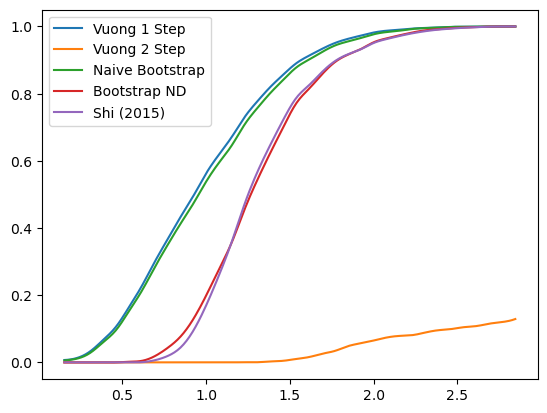

0.1 0.00022121819505175054


In [7]:
data_tuned_c = .9
calc_c =lambda nobs: (nobs**(-1/2), nobs**(-5/9)/350)

nobs = 100
c1,c2 = calc_c(nobs)
    
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.57, 5th: 1.55, 10th: 2.83, 30th: 7.87, 50th: 13.78, 70th: 21.06, 90th: 33.25, 95th: 40.27, 99th: 53.23
bonus term 8.048273058872676 // variance stats 2.038951190790629 //part1 24.458308996069256 //part2 3.038951190790629 2.038951190790629
6.465266690741888 -3.1928980793086614 9.462759753256696
-9.631279427003463 -3.1928980793086614 -6.633786364488656
---
Quantiles: 1th: 1.06, 5th: 2.78, 10th: 4.91, 30th: 15.27, 50th: 26.23, 70th: 40.62, 90th: 64.24, 95th: 75.07, 99th: 94.94
bonus term 2.0414886721287724 // variance stats 43.712234247615584 //part1 91.27951972207535 //part2 44.71223424761558 43.712234247615584
0.028496186602493114 0.13696780870098835 3.8949031336246214
-4.054481157655052 0.13696780870098835 -0.18807421063292337
---
Quantiles: 1th: 0.89, 5th: 2.14, 10th: 3.54, 30th: 9.53, 50th: 16.61, 70th: 25.62, 90th: 40.31, 95th: 48.40, 99th: 65.94
bonus term 5.801619123430443 // variance stats 5.197290579610748 //part1 35.95431954012505 //part2 6.197290579610747 5.1

Quantiles: 1th: 0.80, 5th: 2.08, 10th: 3.58, 30th: 10.52, 50th: 18.36, 70th: 28.91, 90th: 46.02, 95th: 54.90, 99th: 71.76
bonus term 1.7225402527760798 // variance stats 26.194181344150373 //part1 46.84307200659135 //part2 27.194181344150373 26.194181344150373
-0.24053850223743944 -0.052425303892162295 3.647852882066172
-3.685619007789599 -0.052425303892162295 0.2027723765140125
---
Quantiles: 1th: 0.72, 5th: 1.79, 10th: 3.31, 30th: 10.33, 50th: 18.51, 70th: 28.91, 90th: 45.33, 95th: 54.08, 99th: 69.02
bonus term 1.9504419536699475 // variance stats 22.303550068986997 //part1 45.452221724000445 //part2 23.303550068986997 22.303550068986997
-0.13198814490427235 -0.1752269312741592 3.7328255568002637
-4.0328720522441674 -0.1752269312741592 -0.16805835053963142
---
Quantiles: 1th: 0.83, 5th: 2.22, 10th: 4.12, 30th: 11.69, 50th: 20.12, 70th: 30.92, 90th: 48.08, 95th: 56.94, 99th: 72.46
bonus term 13.474160535245387 // variance stats 2.7955285566673416 //part1 51.14156108864398 //part2 3.79

Quantiles: 1th: 0.58, 5th: 1.76, 10th: 3.11, 30th: 9.35, 50th: 15.91, 70th: 24.66, 90th: 38.96, 95th: 46.85, 99th: 62.79
bonus term 1.120099539933664 // variance stats 28.973845069625654 //part1 33.573690072530624 //part2 29.973845069625654 28.973845069625654
-0.8319253928738789 0.21522477705828916 3.0349286550915737
-3.0721244727412067 0.21522477705828916 0.7947295752242457
---
Quantiles: 1th: 0.63, 5th: 1.65, 10th: 2.75, 30th: 7.25, 50th: 12.63, 70th: 19.44, 90th: 31.89, 95th: 37.43, 99th: 48.52
bonus term 9.376676486702642 // variance stats 1.3999581646158508 //part1 22.503631291223474 //part2 2.3999581646158505 1.3999581646158508
8.212150315169962 -3.742384051477618 10.483247564858255
-10.541202658235322 -3.742384051477618 -8.27010540854703
---
Quantiles: 1th: 0.77, 5th: 2.34, 10th: 4.06, 30th: 11.74, 50th: 20.82, 70th: 31.77, 90th: 50.34, 95th: 60.79, 99th: 78.76
bonus term 6.590735701925834 // variance stats 7.505504908782257 //part1 56.05753486521665 //part2 8.505504908782257 7.

Quantiles: 1th: 0.76, 5th: 1.99, 10th: 3.58, 30th: 10.57, 50th: 18.33, 70th: 28.53, 90th: 45.38, 95th: 54.59, 99th: 70.51
bonus term 1.286291536933142 // variance stats 34.41837284165143 //part1 45.55835323815888 //part2 35.41837284165143 34.41837284165143
-0.6965860220456015 0.23784137992605558 3.2848548702307188
-3.2691690959118858 0.23784137992605558 0.7122717963644346
---
Quantiles: 1th: 0.70, 5th: 1.61, 10th: 2.80, 30th: 8.51, 50th: 14.91, 70th: 22.99, 90th: 37.01, 95th: 43.46, 99th: 55.65
bonus term 0.7314294923624803 // variance stats 40.427068382583656 //part1 30.300979597138923 //part2 41.427068382583656 40.427068382583656
-1.2919832245989524 0.6136833369305823 2.5072068421371214
-2.7548422093239133 0.6136833369305823 1.044347857412161
---
Quantiles: 1th: 0.72, 5th: 1.92, 10th: 3.39, 30th: 9.58, 50th: 16.52, 70th: 25.19, 90th: 39.75, 95th: 47.26, 99th: 62.90
bonus term 5.635281801855382 // variance stats 5.204144528215573 //part1 34.96210275593386 //part2 6.204144528215573 5.2

Quantiles: 1th: 0.70, 5th: 1.81, 10th: 3.21, 30th: 9.88, 50th: 17.13, 70th: 26.42, 90th: 42.72, 95th: 49.87, 99th: 67.12
bonus term 3.487815675381469 // variance stats 10.572617585972369 //part1 40.36315702154968 //part2 11.572617585972369 10.572617585972369
1.4532440023371598 -0.9373251813176002 5.2988392158660025
-5.522387348425778 -0.9373251813176002 -1.676792134896935
---
Quantiles: 1th: 0.88, 5th: 2.22, 10th: 3.58, 30th: 10.57, 50th: 18.17, 70th: 27.80, 90th: 43.66, 95th: 51.73, 99th: 68.56
bonus term 0.8259031001155903 // variance stats 50.059245603442754 //part1 42.1699892334467 //part2 51.05924560344275 50.059245603442754
-1.146318202896947 0.6378059383191652 2.5914855057071358
-2.7981244031281274 0.6378059383191652 0.939679305475955
---
Quantiles: 1th: 0.89, 5th: 2.27, 10th: 3.82, 30th: 10.59, 50th: 18.25, 70th: 28.11, 90th: 44.92, 95th: 52.82, 99th: 72.48
bonus term 1.7886625861035341 // variance stats 23.956379229236124 //part1 44.638541811946006 //part2 24.956379229236127 2

Quantiles: 1th: 0.77, 5th: 1.94, 10th: 3.38, 30th: 10.53, 50th: 17.69, 70th: 27.19, 90th: 43.44, 95th: 51.75, 99th: 68.37
bonus term 1.9330377984000782 // variance stats 20.593670860838106 //part1 41.74138198021042 //part2 21.59367086083811 20.593670860838106
-0.05106054546639463 -0.22974466726387052 3.8904338451769513
-3.917136142266551 -0.22974466726387052 0.024358248376794976
---
Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.48, 30th: 9.82, 50th: 16.89, 70th: 25.26, 90th: 39.57, 95th: 47.41, 99th: 62.08
bonus term 0.8144818076529502 // variance stats 41.52007853300838 //part1 34.63183042511007 //part2 42.52007853300838 41.52007853300838
-1.0179847236170136 0.5657965203502822 2.6784427292529895
-2.646948338922914 0.5657965203502822 1.0494791139470896
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.60, 5th: 1.53, 10th: 2.69, 30th: 8.10, 50th: 14.52, 70th: 22.26, 90th: 35.00, 95th: 41.61, 99th: 55.83
bonus term 0.7524653633899087 // variance stats 35.013104358687656 //part1 27.09861365

Quantiles: 1th: 0.83, 5th: 1.85, 10th: 3.14, 30th: 8.73, 50th: 15.22, 70th: 23.59, 90th: 37.75, 95th: 44.93, 99th: 58.73
bonus term 1.803190195837178 // variance stats 16.486769218480944 //part1 31.5319708116322 //part2 17.486769218480948 16.486769218480944
-0.03386003426068195 -1.032326300634565 3.7110658070718596
-3.640240425935038 -1.032326300634565 0.1046854153975038
---
Quantiles: 1th: 0.62, 5th: 1.62, 10th: 2.98, 30th: 8.49, 50th: 14.68, 70th: 23.13, 90th: 36.97, 95th: 43.92, 99th: 57.06
bonus term 1.2932061701945383 // variance stats 22.382962946126046 //part1 30.23899195936046 //part2 23.382962946126046 22.382962946126046
-0.67984431362748 -0.22420923009117574 3.2611228936922423
-3.2662566540165567 -0.22420923009117574 0.6747105533031659
---
Quantiles: 1th: 0.84, 5th: 2.15, 10th: 3.66, 30th: 10.68, 50th: 18.68, 70th: 28.52, 90th: 45.24, 95th: 53.81, 99th: 71.23
bonus term 1.8825304564066907 // variance stats 23.052731382241145 //part1 45.27999938683796 //part2 24.05273138224114

Quantiles: 1th: 0.78, 5th: 1.87, 10th: 2.95, 30th: 8.24, 50th: 14.46, 70th: 22.08, 90th: 35.05, 95th: 40.54, 99th: 53.05
bonus term 1.302532927027985 // variance stats 19.86410499534736 //part1 27.176183749409006 //part2 20.86410499534736 19.86410499534736
-0.6094080258121012 -0.3651597735219492 3.3015814279115343
-3.214473879868071 -0.3651597735219492 0.696515573855564
---
Quantiles: 1th: 0.69, 5th: 1.78, 10th: 3.16, 30th: 9.40, 50th: 16.67, 70th: 25.64, 90th: 40.35, 95th: 47.99, 99th: 62.00
bonus term 0.8106740861946329 // variance stats 43.41754357762251 //part1 36.008151550799404 //part2 44.4175435776225 43.41754357762251
-1.058081449602763 0.4133905266902368 2.802490512310746
-2.679429621992029 0.4133905266902368 1.1811423399214802
---
Quantiles: 1th: 0.70, 5th: 1.69, 10th: 2.86, 30th: 8.35, 50th: 14.67, 70th: 22.57, 90th: 36.47, 95th: 42.67, 99th: 56.43
bonus term 3.0937775365628366 // variance stats 8.512399962740107 //part1 29.429249323526506 //part2 9.512399962740107 8.5123999

Quantiles: 1th: 0.58, 5th: 1.45, 10th: 2.97, 30th: 9.01, 50th: 15.70, 70th: 24.31, 90th: 38.25, 95th: 45.65, 99th: 60.82
bonus term 0.6061202389280713 // variance stats 52.38727672780457 //part1 32.35910892597597 //part2 53.38727672780457 52.38727672780457
-1.2218254621973164 0.561894978770537 2.5656948187235495
-2.434065940053459 0.561894978770537 1.3534543408674067
---
Quantiles: 1th: 0.81, 5th: 1.91, 10th: 3.11, 30th: 8.75, 50th: 14.86, 70th: 23.09, 90th: 35.77, 95th: 43.26, 99th: 56.17
bonus term 1.28518158268633 // variance stats 21.020245274329383 //part1 28.300013672803814 //part2 22.020245274329383 21.020245274329383
-0.554769271340498 -0.7707734516742578 3.0411026455207617
-3.125132436713158 -0.7707734516742578 0.4707394801481018
---
Quantiles: 1th: 0.77, 5th: 2.11, 10th: 3.79, 30th: 11.35, 50th: 19.66, 70th: 30.28, 90th: 46.62, 95th: 56.43, 99th: 72.04
bonus term 4.0921603661055945 // variance stats 10.751785992340583 //part1 48.090192868811044 //part2 11.751785992340585 10.7

Quantiles: 1th: 0.71, 5th: 1.94, 10th: 3.24, 30th: 8.85, 50th: 16.08, 70th: 24.72, 90th: 40.20, 95th: 47.82, 99th: 60.89
bonus term 0.9792585127396245 // variance stats 35.51212367106278 //part1 35.754807923090176 //part2 36.51212367106278 35.51212367106278
-0.7877272731964055 -0.06325863262267492 2.9818664264778656
-2.7462442986756543 -0.06325863262267492 1.0233494009986162
---
Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.40, 30th: 10.11, 50th: 17.35, 70th: 26.50, 90th: 42.82, 95th: 50.52, 99th: 65.83
bonus term 1.0182117063283385 // variance stats 38.844076295535466 //part1 40.56970491195367 //part2 39.844076295535466 38.844076295535466
-1.0230573129097844 0.08339657110579861 2.9169467578561505
-3.0594807255664613 0.08339657110579861 0.8805233451994738
---
Quantiles: 1th: 0.89, 5th: 2.27, 10th: 4.13, 30th: 12.51, 50th: 21.48, 70th: 32.74, 90th: 50.65, 95th: 61.26, 99th: 78.07
bonus term 1.2529903773639455 // variance stats 44.3019717816681 //part1 56.76293471804311 //part2 45.30197178166

Quantiles: 1th: 0.78, 5th: 1.90, 10th: 3.39, 30th: 8.93, 50th: 16.19, 70th: 24.17, 90th: 38.25, 95th: 44.82, 99th: 59.95
bonus term 1.0664341703516722 // variance stats 29.354660577294382 //part1 32.37124726905354 //part2 30.354660577294382 29.354660577294382
-0.8504672284058993 0.04996277495300749 3.1796653101195194
-2.9833355691092436 0.04996277495300749 1.0467969694161752
---
Quantiles: 1th: 0.57, 5th: 1.68, 10th: 2.94, 30th: 9.21, 50th: 16.70, 70th: 25.22, 90th: 40.09, 95th: 47.14, 99th: 60.43
bonus term 4.507837827013594 // variance stats 6.886389711143574 //part1 35.55056585846381 //part2 7.886389711143574 6.886389711143574
2.6233679195358057 -3.232599028048637 6.193981582161783
-6.392307734491382 -3.232599028048637 -2.821694071865405
---
Quantiles: 1th: 0.74, 5th: 2.14, 10th: 4.03, 30th: 12.80, 50th: 23.00, 70th: 35.17, 90th: 55.80, 95th: 66.13, 99th: 85.89
bonus term 1.0832414967211674 // variance stats 62.58261686091192 //part1 68.87532905386277 //part2 63.58261686091191 62.58

Quantiles: 1th: 0.69, 5th: 1.71, 10th: 2.72, 30th: 7.83, 50th: 13.82, 70th: 21.29, 90th: 33.88, 95th: 40.48, 99th: 53.71
bonus term 0.7678315626262086 // variance stats 32.066387179474184 //part1 25.38941573841889 //part2 33.066387179474184 32.066387179474184
-1.1530492086480606 -0.07440330761335547 2.6642205600265947
-2.6887123339004777 -0.07440330761335547 1.1285574347741778
---
Quantiles: 1th: 0.59, 5th: 1.47, 10th: 2.60, 30th: 7.82, 50th: 13.43, 70th: 20.86, 90th: 33.26, 95th: 40.63, 99th: 52.98
bonus term 0.6470485811852364 // variance stats 36.81218154163589 //part1 24.466318418034085 //part2 37.81218154163589 36.81218154163589
-1.2586330160134953 0.16142512677983384 2.4704851347725616
-2.5527301783839684 0.16142512677983384 1.1763879724020887
---
Quantiles: 1th: 0.56, 5th: 1.45, 10th: 2.42, 30th: 7.20, 50th: 12.59, 70th: 19.27, 90th: 29.91, 95th: 35.71, 99th: 45.91
bonus term 2.6906688930599914 // variance stats 6.357181169501941 //part1 19.7957385133856 //part2 7.35718116950194

Quantiles: 1th: 0.89, 5th: 2.20, 10th: 3.77, 30th: 11.16, 50th: 19.48, 70th: 30.16, 90th: 46.10, 95th: 55.04, 99th: 72.49
bonus term 0.8559489864533582 // variance stats 53.93687874384581 //part1 47.023165679705855 //part2 54.9368787438458 53.93687874384581
-1.0508943710997947 0.3267403148698903 2.9940127603558246
-2.7627923440065114 0.3267403148698903 1.2821147874491083
---
Quantiles: 1th: 0.91, 5th: 2.27, 10th: 3.94, 30th: 12.09, 50th: 20.44, 70th: 31.95, 90th: 51.21, 95th: 61.51, 99th: 81.16
bonus term 1.0249634895220234 // variance stats 55.60757545957798 //part1 58.0206980764303 //part2 56.60757545957797 55.60757545957798
-0.947407116421982 0.34042591523611926 2.936320850098302
-2.9973340954660292 0.34042591523611926 0.8863938710542547
---
Quantiles: 1th: 0.66, 5th: 1.73, 10th: 3.37, 30th: 9.41, 50th: 16.41, 70th: 24.59, 90th: 39.01, 95th: 46.67, 99th: 61.81
bonus term 1.1549722276546346 // variance stats 28.147729561464693 //part1 33.66481814267973 //part2 29.147729561464693 28.1

Quantiles: 1th: 0.89, 5th: 2.48, 10th: 4.34, 30th: 12.72, 50th: 22.47, 70th: 35.06, 90th: 54.34, 95th: 64.38, 99th: 84.60
bonus term 2.693361412706271 // variance stats 23.25242000546289 //part1 65.32053220745937 //part2 24.25242000546289 23.25242000546289
0.787548523542624 -2.0443435505532332 4.708237386641114
-4.599174301869917 -2.0443435505532332 -0.6784854387714273
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 3.12, 30th: 9.06, 50th: 16.23, 70th: 25.32, 90th: 39.52, 95th: 47.82, 99th: 63.27
bonus term 3.0607387110543414 // variance stats 10.28962209742265 //part1 34.554583386756015 //part2 11.28962209742265 10.28962209742265
0.7241850990428147 -3.9257097648326034 5.042885507592227
-5.397292323065868 -3.9257097648326034 -1.0785919145164555
---
Quantiles: 1th: 0.69, 5th: 1.99, 10th: 3.11, 30th: 8.80, 50th: 15.35, 70th: 23.96, 90th: 38.40, 95th: 45.16, 99th: 58.76
bonus term 0.5697009990339563 // variance stats 56.2567003657923 //part1 32.61919939977977 //part2 57.2567003657923 56.256700

0.7692307692307693 [0.99428571 0.         0.00571429]
Quantiles: 1th: 0.77, 5th: 1.82, 10th: 3.05, 30th: 8.76, 50th: 15.35, 70th: 24.01, 90th: 37.99, 95th: 44.42, 99th: 59.54
bonus term 1.0593672084787413 // variance stats 29.13335026249917 //part1 31.92228314969589 //part2 30.13335026249917 29.13335026249917
-0.8032695692825099 -0.8409803772874416 2.943068787695817
-2.922003986239993 -0.8409803772874416 0.824334370738334
---
Quantiles: 1th: 0.77, 5th: 1.98, 10th: 3.29, 30th: 10.12, 50th: 17.61, 70th: 26.66, 90th: 42.34, 95th: 51.02, 99th: 66.14
bonus term 0.7188895576515495 // variance stats 54.172936632865174 //part1 39.66324801033741 //part2 55.17293663286517 54.172936632865174
-1.2785260413176964 -0.2599693839054425 2.7235065033996655
-2.7163051566207956 -0.2599693839054425 1.2857273880965665
---
Quantiles: 1th: 0.78, 5th: 2.08, 10th: 3.68, 30th: 10.69, 50th: 19.13, 70th: 28.78, 90th: 44.96, 95th: 53.68, 99th: 72.27
bonus term 4.637266675136288 // variance stats 8.641700454818682 /

Quantiles: 1th: 0.72, 5th: 1.72, 10th: 2.95, 30th: 8.55, 50th: 14.68, 70th: 22.94, 90th: 36.14, 95th: 42.54, 99th: 54.64
bonus term 0.6462605026830113 // variance stats 43.7009078189251 //part1 28.88843115744548 //part2 44.700907818925096 43.7009078189251
-1.3343165710989637 0.07010327548658905 2.63926552064817
-2.6268375764649865 0.07010327548658905 1.3467445152821471
---
Quantiles: 1th: 0.72, 5th: 1.94, 10th: 3.29, 30th: 9.89, 50th: 16.97, 70th: 25.91, 90th: 40.77, 95th: 48.46, 99th: 64.82
bonus term 0.7435003402907804 // variance stats 48.45507151099552 //part1 36.76986249753004 //part2 49.455071510995516 48.45507151099552
-1.3170908570926771 0.20825389040821846 2.741608293182783
-2.804091537674238 0.20825389040821846 1.2546076126012227
---
Quantiles: 1th: 0.71, 5th: 1.84, 10th: 3.20, 30th: 9.10, 50th: 16.00, 70th: 24.42, 90th: 38.95, 95th: 46.12, 99th: 59.77
bonus term 1.0242438104626184 // variance stats 31.762598930249336 //part1 33.55688916897709 //part2 32.76259893024934 31.762

Quantiles: 1th: 0.84, 5th: 1.90, 10th: 3.06, 30th: 9.08, 50th: 16.03, 70th: 24.61, 90th: 39.01, 95th: 46.30, 99th: 61.46
bonus term 0.8200535351065246 // variance stats 40.057217312618135 //part1 33.6691161988493 //part2 41.05721731261813 40.057217312618135
-1.1103019639614418 -0.4254198058557643 2.7135803299113195
-2.750409034174491 -0.4254198058557643 1.0734732596982703
---
Quantiles: 1th: 0.71, 5th: 2.21, 10th: 4.17, 30th: 12.33, 50th: 21.58, 70th: 33.53, 90th: 52.66, 95th: 62.51, 99th: 82.18
bonus term 1.187018406499061 // variance stats 50.68273264530697 //part1 61.348354948149286 //part2 51.68273264530697 50.68273264530697
-0.7402505304877891 -0.3477461689061681 3.014102110081271
-3.114287343485911 -0.3477461689061681 0.6400652970831489
---
Quantiles: 1th: 0.72, 5th: 1.86, 10th: 2.99, 30th: 8.39, 50th: 14.20, 70th: 22.08, 90th: 35.13, 95th: 42.28, 99th: 55.45
bonus term 0.8954417596731999 // variance stats 29.482475461148162 //part1 27.295281466125648 //part2 30.482475461148162 2

Quantiles: 1th: 0.86, 5th: 2.38, 10th: 4.09, 30th: 12.51, 50th: 21.89, 70th: 33.90, 90th: 53.35, 95th: 63.94, 99th: 82.24
bonus term 0.9806792853958293 // variance stats 63.19892065133884 //part1 62.958551627538505 //part2 64.19892065133882 63.19892065133884
-0.9937854266182896 -0.27218372671536223 2.881169902130976
-2.9551439974099485 -0.27218372671536223 0.9198113313393174
---
Quantiles: 1th: 0.81, 5th: 1.93, 10th: 3.56, 30th: 10.21, 50th: 18.07, 70th: 27.69, 90th: 44.75, 95th: 53.38, 99th: 68.60
bonus term 0.6158681035799143 // variance stats 70.92054610176226 //part1 44.29357033612412 //part2 71.92054610176226 70.92054610176226
-1.2348176119207526 0.5822298733777407 2.476001970431444
-2.466553819080581 0.5822298733777407 1.2442657632716159
---
Quantiles: 1th: 0.67, 5th: 1.83, 10th: 3.43, 30th: 10.13, 50th: 17.53, 70th: 26.84, 90th: 42.35, 95th: 50.33, 99th: 66.96
bonus term 0.6686554685953731 // variance stats 58.33947821511867 //part1 39.677666612135106 //part2 59.33947821511866 5

Quantiles: 1th: 0.71, 5th: 1.79, 10th: 2.95, 30th: 9.26, 50th: 16.27, 70th: 25.19, 90th: 38.43, 95th: 46.06, 99th: 61.10
bonus term 0.48925266821753777 // variance stats 65.78054223776144 //part1 32.67255847483876 //part2 66.78054223776142 65.78054223776144
-1.515832572113106 0.013959378205018719 2.3355045673519164
-2.4943379085481814 0.013959378205018719 1.3569992309168408
---
Quantiles: 1th: 0.68, 5th: 1.65, 10th: 2.63, 30th: 7.60, 50th: 13.19, 70th: 20.37, 90th: 31.70, 95th: 38.06, 99th: 49.25
bonus term 0.729649094090779 // variance stats 29.474046300498866 //part1 22.235360276439454 //part2 30.474046300498866 29.474046300498866
-1.1447252864819015 -1.4671568824195116 2.3997720890162633
-2.60402347466346 -1.4671568824195116 0.9404739008347051
---
Quantiles: 1th: 0.66, 5th: 1.79, 10th: 3.18, 30th: 9.54, 50th: 16.49, 70th: 25.33, 90th: 40.67, 95th: 48.04, 99th: 63.26
bonus term 0.4406714365970754 // variance stats 82.02242294887637 //part1 36.58561039065135 //part2 83.02242294887635 

Quantiles: 1th: 0.62, 5th: 1.72, 10th: 3.10, 30th: 9.37, 50th: 16.86, 70th: 26.00, 90th: 41.44, 95th: 48.23, 99th: 62.56
bonus term 0.6221193242953257 // variance stats 60.05402132830423 //part1 37.98288649427703 //part2 61.05402132830423 60.05402132830423
-1.3291152937369146 -0.12294681351548979 2.4887003682499
-2.573353942327566 -0.12294681351548979 1.244461719659249
---
Quantiles: 1th: 0.74, 5th: 1.68, 10th: 2.89, 30th: 7.63, 50th: 13.42, 70th: 20.59, 90th: 32.39, 95th: 38.84, 99th: 50.23
bonus term 0.259319685601124 // variance stats 88.50189979117884 //part1 23.209604514551803 //part2 89.50189979117883 88.50189979117884
-1.74960422843946 1.4938477796341878 2.285819763595696
-2.268243599641708 1.4938477796341878 1.7671803923934484
---
1.076923076923077 [0.96428571 0.00142857 0.03428571]
Quantiles: 1th: 0.80, 5th: 1.77, 10th: 3.01, 30th: 8.57, 50th: 14.74, 70th: 22.57, 90th: 35.88, 95th: 42.57, 99th: 56.71
bonus term 0.5546007312815271 // variance stats 50.35466873608943 //part1 28.

Quantiles: 1th: 0.67, 5th: 1.80, 10th: 3.18, 30th: 9.07, 50th: 16.01, 70th: 24.70, 90th: 38.96, 95th: 46.52, 99th: 59.38
bonus term 1.523371817638023 // variance stats 21.04070739429616 //part1 33.576192485276756 //part2 22.04070739429616 21.04070739429616
-0.5741887966000946 -3.0816965089534065 3.4487134470218495
-3.620932431876141 -3.0816965089534065 0.4019698117458033
---
Quantiles: 1th: 0.67, 5th: 1.61, 10th: 2.63, 30th: 7.11, 50th: 12.65, 70th: 19.52, 90th: 30.93, 95th: 36.75, 99th: 46.65
bonus term 0.3040856203169546 // variance stats 68.6013940480551 //part1 21.164783084027622 //part2 69.6013940480551 68.6013940480551
-1.5822825248808727 0.7572771373845253 2.207195256789057
-2.190453765514782 0.7572771373845253 1.599024016155148
---
Quantiles: 1th: 0.65, 5th: 1.83, 10th: 3.21, 30th: 8.90, 50th: 15.43, 70th: 23.12, 90th: 36.57, 95th: 44.10, 99th: 57.55
bonus term 1.6230097622161148 // variance stats 17.22574374572327 //part1 29.580560022958167 //part2 18.22574374572327 17.2257437

Quantiles: 1th: 0.80, 5th: 2.19, 10th: 3.76, 30th: 11.04, 50th: 19.02, 70th: 28.67, 90th: 45.39, 95th: 54.10, 99th: 71.26
bonus term 0.6205661764298417 // variance stats 72.45381654975562 //part1 45.582954080460865 //part2 73.4538165497556 72.45381654975562
-1.4852402369650086 0.06349181568145518 2.68102303188956
-2.7263725898246918 0.06349181568145518 1.439890679029877
---
Quantiles: 1th: 0.67, 5th: 1.89, 10th: 3.25, 30th: 9.41, 50th: 16.45, 70th: 25.71, 90th: 39.45, 95th: 47.15, 99th: 63.13
bonus term 0.48103142325963016 // variance stats 70.56717907232921 //part1 34.426062007839334 //part2 71.5671790723292 70.56717907232921
-1.4547059608709025 0.2555880128954561 2.2963245292759344
-2.416768807390163 0.2555880128954561 1.3342616827566738
---
Quantiles: 1th: 0.89, 5th: 2.16, 10th: 3.77, 30th: 10.95, 50th: 18.65, 70th: 28.70, 90th: 46.01, 95th: 54.87, 99th: 71.48
bonus term 0.5046862788079917 // variance stats 91.78443475574969 //part1 46.82703110818219 //part2 92.78443475574969 91.784

Quantiles: 1th: 0.65, 5th: 1.71, 10th: 2.84, 30th: 7.94, 50th: 13.55, 70th: 21.11, 90th: 33.53, 95th: 40.09, 99th: 51.54
bonus term 0.3037708030070311 // variance stats 80.87963212494826 //part1 24.872641600515827 //part2 81.87963212494824 80.87963212494826
-1.5123028185396945 0.7815841488870504 2.2263900596000568
-2.1198444245537567 0.7815841488870504 1.6188484535859944
---
Quantiles: 1th: 0.76, 5th: 2.01, 10th: 3.81, 30th: 10.98, 50th: 19.51, 70th: 29.88, 90th: 48.33, 95th: 57.58, 99th: 74.38
bonus term 0.804343176389282 // variance stats 63.24322105000949 //part1 51.67359648084341 //part2 64.24322105000948 63.24322105000949
-1.0001032908622471 -0.5602020386189505 2.7316788957682436
-2.608789643640811 -0.5602020386189505 1.1229925429896792
---
Quantiles: 1th: 0.72, 5th: 1.93, 10th: 3.80, 30th: 10.90, 50th: 19.27, 70th: 29.13, 90th: 45.28, 95th: 54.60, 99th: 74.15
bonus term 0.8163297463941536 // variance stats 54.57277589078836 //part1 45.36571004934639 //part2 55.57277589078836 54.5

Quantiles: 1th: 0.67, 5th: 1.83, 10th: 3.05, 30th: 8.67, 50th: 15.04, 70th: 22.82, 90th: 36.11, 95th: 43.19, 99th: 58.16
bonus term 0.4317172939410937 // variance stats 65.82047176871086 //part1 28.847553251855096 //part2 66.82047176871086 65.82047176871086
-1.4576971857981973 -0.4677729011998097 2.4300064512830444
-2.321131773680385 -0.4677729011998097 1.566571863400857
---
Quantiles: 1th: 0.65, 5th: 1.55, 10th: 2.85, 30th: 7.70, 50th: 13.49, 70th: 20.75, 90th: 32.92, 95th: 39.12, 99th: 51.75
bonus term 0.6113305722114849 // variance stats 38.20594591745865 //part1 23.967793351812524 //part2 39.20594591745865 38.20594591745865
-1.5196543917096903 -2.261208770427697 2.45965426198011
-2.74231553613266 -2.261208770427697 1.2369931175571398
---
Quantiles: 1th: 0.73, 5th: 2.26, 10th: 4.14, 30th: 12.32, 50th: 20.94, 70th: 32.01, 90th: 50.24, 95th: 59.22, 99th: 78.03
bonus term 0.5472273993539755 // variance stats 101.03979342874342 //part1 55.83897078862814 //part2 102.03979342874342 101.03

Quantiles: 1th: 0.80, 5th: 2.12, 10th: 3.95, 30th: 11.72, 50th: 20.51, 70th: 30.98, 90th: 49.73, 95th: 59.58, 99th: 77.02
bonus term 0.47249716327300056 // variance stats 114.7891016505261 //part1 54.71002206780269 //part2 115.7891016505261 114.7891016505261
-1.3205302510285506 0.7975510101537154 2.5780598598815008
-2.265524577574552 0.7975510101537154 1.6330655333354993
---
Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.23, 30th: 9.41, 50th: 16.84, 70th: 25.86, 90th: 40.73, 95th: 49.54, 99th: 64.35
bonus term 0.539974916258543 // variance stats 66.9783878780022 //part1 36.70662430181498 //part2 67.9783878780022 66.9783878780022
-1.427948754735458 -0.46084975500840814 2.4254984465923823
-2.507898587252544 -0.46084975500840814 1.345548614075296
---
Quantiles: 1th: 0.83, 5th: 1.97, 10th: 3.31, 30th: 9.56, 50th: 16.47, 70th: 24.69, 90th: 39.48, 95th: 47.24, 99th: 62.77
bonus term 0.3687363454915704 // variance stats 92.4929601495159 //part1 34.474252454721515 //part2 93.4929601495159 92.4929601

Quantiles: 1th: 0.77, 5th: 2.09, 10th: 3.52, 30th: 10.37, 50th: 18.03, 70th: 28.12, 90th: 44.24, 95th: 52.08, 99th: 69.14
bonus term 0.62980788043483 // variance stats 67.74111669600678 //part1 43.293697005035334 //part2 68.74111669600678 67.74111669600678
-1.3426636538859456 -0.24284708838025712 2.636308023998638
-2.6022794147556056 -0.24284708838025712 1.3766922631289782
---
Quantiles: 1th: 0.60, 5th: 1.45, 10th: 2.87, 30th: 8.33, 50th: 14.67, 70th: 22.98, 90th: 36.02, 95th: 42.95, 99th: 56.73
bonus term 0.4521528076860858 // variance stats 62.48641459879052 //part1 28.705560610766035 //part2 63.48641459879051 62.48641459879052
-1.5169615054734824 -0.19760638156693539 2.439298081068815
-2.421267120845654 -0.19760638156693539 1.5349924656966432
---
Quantiles: 1th: 0.64, 5th: 1.68, 10th: 2.62, 30th: 7.42, 50th: 12.97, 70th: 19.35, 90th: 31.51, 95th: 37.02, 99th: 48.63
bonus term 0.8428197928902882 // variance stats 25.055085383425265 //part1 21.959741666597257 //part2 26.05508538342526

Quantiles: 1th: 0.78, 5th: 2.10, 10th: 3.77, 30th: 11.07, 50th: 19.47, 70th: 30.28, 90th: 48.37, 95th: 57.97, 99th: 75.01
bonus term 0.575448796437378 // variance stats 88.9494441471534 //part1 51.76129937469057 //part2 89.9494441471534 88.9494441471534
-1.4041453131056314 -0.3006181284079247 2.617699247949087
-2.5550429059803874 -0.3006181284079247 1.466801655074331
---
Quantiles: 1th: 0.76, 5th: 2.09, 10th: 3.44, 30th: 10.25, 50th: 17.71, 70th: 26.60, 90th: 42.91, 95th: 50.15, 99th: 64.25
bonus term 0.8647181785260888 // variance stats 46.09439441942091 //part1 40.72337896115085 //part2 47.09439441942091 46.09439441942091
-1.320998743469522 -2.665354507889733 2.950697932126596
-3.0504351005216996 -2.665354507889733 1.2212615750744182
---
Quantiles: 1th: 0.71, 5th: 1.77, 10th: 3.03, 30th: 8.56, 50th: 14.75, 70th: 22.91, 90th: 36.38, 95th: 43.56, 99th: 58.67
bonus term 0.3036427369776055 // variance stats 95.40446819003213 //part1 29.27251657809186 //part2 96.40446819003213 95.40446819

Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.39, 30th: 10.66, 50th: 18.88, 70th: 29.03, 90th: 46.01, 95th: 54.55, 99th: 73.59
bonus term 0.5106491099748482 // variance stats 90.69953210995376 //part1 46.82628445705791 //part2 91.69953210995375 90.69953210995376
-1.472160486519388 0.4075853898770186 2.5275341722726767
-2.4934587064690845 0.4075853898770186 1.50623595232298
---
Quantiles: 1th: 0.81, 5th: 2.23, 10th: 3.89, 30th: 11.45, 50th: 19.77, 70th: 30.89, 90th: 49.54, 95th: 59.64, 99th: 78.06
bonus term 0.4669640340241077 // variance stats 115.26066551004645 //part1 54.28954936489874 //part2 116.26066551004644 115.26066551004645
-1.5167632666063002 0.5056129353993594 2.4368662801489753
-2.450691334654515 0.5056129353993594 1.5029382121007604
---
Quantiles: 1th: 0.99, 5th: 2.25, 10th: 3.89, 30th: 11.35, 50th: 19.68, 70th: 30.64, 90th: 48.71, 95th: 57.88, 99th: 74.30
bonus term 0.5572170139199809 // variance stats 93.20855872044038 //part1 52.49461177590897 //part2 94.20855872044038 93.20

1.6153846153846154 [0.95571429 0.00428571 0.04      ]
Quantiles: 1th: 0.78, 5th: 1.72, 10th: 2.76, 30th: 7.46, 50th: 12.75, 70th: 19.58, 90th: 31.32, 95th: 37.46, 99th: 50.31
bonus term 0.2446225540082889 // variance stats 87.73172665700356 //part1 21.70578159640158 //part2 88.73172665700355 87.73172665700356
-1.6580980463816102 0.5321313244413833 2.317526316564227
-2.147343154398188 0.5321313244413833 1.8282812085476492
---
Quantiles: 1th: 0.79, 5th: 1.82, 10th: 2.81, 30th: 7.77, 50th: 13.62, 70th: 20.68, 90th: 33.65, 95th: 40.59, 99th: 52.76
bonus term 0.3545288220878663 // variance stats 69.6573577684725 //part1 25.0500698214975 //part2 70.6573577684725 69.6573577684725
-1.6270084097455786 -0.5824276396811537 2.2093186696659264
-2.336066053921311 -0.5824276396811537 1.5002610254901936
---
Quantiles: 1th: 0.69, 5th: 1.76, 10th: 2.92, 30th: 8.46, 50th: 15.31, 70th: 23.50, 90th: 36.50, 95th: 43.40, 99th: 56.74
bonus term 0.31287172686085774 // variance stats 93.20641393827859 //part1 2

Quantiles: 1th: 0.76, 5th: 1.98, 10th: 3.30, 30th: 9.07, 50th: 16.32, 70th: 24.84, 90th: 39.53, 95th: 46.32, 99th: 61.25
bonus term 0.3525535010072892 // variance stats 97.06704466422842 //part1 34.57387992981193 //part2 98.06704466422842 97.06704466422842
-1.6150812746456136 0.041179306500929866 2.2600283596670145
-2.3201882766601925 0.041179306500929866 1.5549213576524363
---
Quantiles: 1th: 0.88, 5th: 2.30, 10th: 4.19, 30th: 13.99, 50th: 24.61, 70th: 37.78, 90th: 59.20, 95th: 70.59, 99th: 90.65
bonus term 0.5986437434339801 // variance stats 128.49225262984802 //part1 77.51972686003087 //part2 129.49225262984802 128.49225262984802
-1.273942800229911 0.7020421158854427 2.486879751721115
-2.471230287097871 0.7020421158854427 1.2895922648531548
---
Quantiles: 1th: 0.82, 5th: 1.98, 10th: 3.27, 30th: 9.14, 50th: 15.58, 70th: 24.17, 90th: 37.93, 95th: 45.78, 99th: 60.37
bonus term 0.3500214721234548 // variance stats 89.94058953585687 //part1 31.831159025115475 //part2 90.94058953585687 8

Quantiles: 1th: 0.68, 5th: 1.57, 10th: 2.82, 30th: 7.98, 50th: 14.13, 70th: 21.04, 90th: 33.76, 95th: 40.27, 99th: 52.54
bonus term 0.32658637600500284 // variance stats 76.19689063398708 //part1 25.211452751008384 //part2 77.19689063398707 76.19689063398708
-1.7411423331844353 -0.11204703525760068 2.3281621735170415
-2.394315085194441 -0.11204703525760068 1.6749894215070358
---
Quantiles: 1th: 0.69, 5th: 1.77, 10th: 3.04, 30th: 9.09, 50th: 15.63, 70th: 24.04, 90th: 37.84, 95th: 44.98, 99th: 59.43
bonus term 0.48592325095849886 // variance stats 64.17522314829387 //part1 31.67015631416456 //part2 65.17522314829387 64.17522314829387
-1.5440343163002435 -0.8068316953178177 2.471832547339547
-2.5158808182172416 -0.8068316953178177 1.4999860454225489
---
Quantiles: 1th: 0.67, 5th: 1.86, 10th: 3.27, 30th: 9.28, 50th: 16.06, 70th: 24.42, 90th: 39.30, 95th: 46.67, 99th: 61.99
bonus term 0.4600372353064267 // variance stats 73.26703666964343 //part1 34.165602223903775 //part2 74.26703666964342

Quantiles: 1th: 0.74, 5th: 1.85, 10th: 2.99, 30th: 8.28, 50th: 14.37, 70th: 21.89, 90th: 34.65, 95th: 41.27, 99th: 54.33
bonus term 0.4470203786358172 // variance stats 58.42938487786696 //part1 26.566146130197794 //part2 59.42938487786695 58.42938487786696
-1.7146102775095635 -1.9664305638761803 2.347361368515613
-2.6086510347811975 -1.9664305638761803 1.4533206112439787
---
Quantiles: 1th: 0.64, 5th: 1.68, 10th: 3.12, 30th: 9.38, 50th: 16.33, 70th: 24.75, 90th: 39.59, 95th: 46.46, 99th: 61.44
bonus term 0.27708487378792024 // variance stats 124.12455382348112 //part1 34.6701212039491 //part2 125.12455382348111 124.12455382348112
-1.6764152361780014 1.311520086428512 2.252000174271776
-2.2305849837538414 1.311520086428512 1.6978304266959352
---
Quantiles: 1th: 0.68, 5th: 2.10, 10th: 3.69, 30th: 10.39, 50th: 18.22, 70th: 27.79, 90th: 43.93, 95th: 51.87, 99th: 69.69
bonus term 0.3313326340980888 // variance stats 127.8751853004824 //part1 42.70055461548813 //part2 128.8751853004824 127.

Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.31, 30th: 9.32, 50th: 16.00, 70th: 24.28, 90th: 38.62, 95th: 46.31, 99th: 60.61
bonus term 0.3178434860306584 // variance stats 102.81581842526657 //part1 32.99718163341258 //part2 103.81581842526657 102.81581842526657
-1.646149417506433 0.521326590316432 2.2223348092006234
-2.28183638956775 0.521326590316432 1.586647837139307
---
Quantiles: 1th: 0.74, 5th: 1.77, 10th: 3.26, 30th: 9.63, 50th: 16.77, 70th: 25.68, 90th: 40.50, 95th: 48.51, 99th: 64.72
bonus term 0.312180597515284 // variance stats 115.2270077016869 //part1 36.28381671172613 //part2 116.2270077016869 115.2270077016869
-1.5715362045015309 0.698560871150568 2.342387979167146
-2.195897399532099 0.698560871150568 1.7180267841365782
---
Quantiles: 1th: 0.76, 5th: 1.97, 10th: 3.63, 30th: 10.88, 50th: 18.96, 70th: 29.26, 90th: 46.53, 95th: 55.11, 99th: 70.29
bonus term 0.3307345032798819 // variance stats 143.8083321679884 //part1 47.89311181036779 //part2 144.8083321679884 143.8083321679

Quantiles: 1th: 0.65, 5th: 1.94, 10th: 3.53, 30th: 10.79, 50th: 18.75, 70th: 28.90, 90th: 46.09, 95th: 55.20, 99th: 70.80
bonus term 0.43976075483870447 // variance stats 105.84005395101956 //part1 46.984062772508274 //part2 106.84005395101956 105.84005395101956
-1.4894887529337149 0.2757164301404225 2.2822588869584006
-2.369010262611124 0.2757164301404225 1.4027373772809912
---
Quantiles: 1th: 0.71, 5th: 1.90, 10th: 3.56, 30th: 10.83, 50th: 18.84, 70th: 29.11, 90th: 45.39, 95th: 55.01, 99th: 71.06
bonus term 0.7706878597374591 // variance stats 58.14329348754745 //part1 45.581018275742345 //part2 59.143293487547446 58.14329348754745
-1.4530932599982354 -2.8524473418851484 2.641297594040193
-2.9944689794731536 -2.8524473418851484 1.0999218745652748
---
1.9230769230769231 [0.95857143 0.00142857 0.04      ]
Quantiles: 1th: 0.73, 5th: 2.02, 10th: 3.50, 30th: 10.04, 50th: 17.59, 70th: 27.00, 90th: 42.39, 95th: 50.57, 99th: 67.21
bonus term 0.44794179009903995 // variance stats 87.761427871

Quantiles: 1th: 0.73, 5th: 2.03, 10th: 3.65, 30th: 10.87, 50th: 18.65, 70th: 28.94, 90th: 44.85, 95th: 53.79, 99th: 68.62
bonus term 0.36779942662558257 // variance stats 119.98994322535938 //part1 44.50003174574898 //part2 120.98994322535938 119.98994322535938
-1.5590817987836403 0.3112291404830464 2.3337329945026677
-2.2946806520348058 0.3112291404830464 1.5981341412515027
---
Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.14, 30th: 9.39, 50th: 16.31, 70th: 25.21, 90th: 40.22, 95th: 47.46, 99th: 62.77
bonus term 0.3012018690926075 // variance stats 117.81962634918051 //part1 35.7886935412584 //part2 118.81962634918051 117.81962634918051
-1.622330663801049 0.3096797555632324 2.3898279986699023
-2.224734401986264 0.3096797555632324 1.787424260484687
---
Quantiles: 1th: 0.56, 5th: 1.62, 10th: 3.08, 30th: 9.55, 50th: 16.87, 70th: 26.09, 90th: 42.04, 95th: 50.38, 99th: 65.94
bonus term 0.36354962864892815 // variance stats 106.55601320054262 //part1 39.10194865801649 //part2 107.55601320054262 

Quantiles: 1th: 0.81, 5th: 1.91, 10th: 3.11, 30th: 9.15, 50th: 15.85, 70th: 24.01, 90th: 37.84, 95th: 45.46, 99th: 61.56
bonus term 0.2173797957866709 // variance stats 144.72553486089214 //part1 31.677787008964124 //part2 145.72553486089214 144.72553486089214
-1.608265694116327 1.8849107711455584 2.136779767880401
-2.043025285689669 1.8849107711455584 1.702020176307059
---
Quantiles: 1th: 0.90, 5th: 1.95, 10th: 3.23, 30th: 9.18, 50th: 16.44, 70th: 25.69, 90th: 40.68, 95th: 48.54, 99th: 62.97
bonus term 0.47577572736251517 // variance stats 75.9382892628352 //part1 36.60537053605301 //part2 76.93828926283518 75.9382892628352
-1.360030718879518 -0.8879947954745258 2.417688213419064
-2.3115821736045485 -0.8879947954745258 1.4661367586940335
---
Quantiles: 1th: 0.60, 5th: 1.58, 10th: 2.77, 30th: 7.77, 50th: 13.30, 70th: 20.51, 90th: 33.10, 95th: 39.16, 99th: 50.53
bonus term 0.21921808162716439 // variance stats 109.5563951649308 //part1 24.235960859670843 //part2 110.5563951649308 109.55

Quantiles: 1th: 0.71, 5th: 2.04, 10th: 3.69, 30th: 10.86, 50th: 19.00, 70th: 29.34, 90th: 46.30, 95th: 55.20, 99th: 74.45
bonus term 0.4406328018572771 // variance stats 106.64317981326187 //part1 47.43111592194427 //part2 107.64317981326187 106.64317981326187
-1.6404673555074059 -0.6303377530791755 2.3202469396386056
-2.52173295922196 -0.6303377530791755 1.4389813359240513
---
Quantiles: 1th: 0.62, 5th: 2.04, 10th: 3.52, 30th: 10.02, 50th: 17.37, 70th: 26.55, 90th: 42.25, 95th: 50.14, 99th: 68.31
bonus term 0.3090720526999184 // variance stats 126.76767263362737 //part1 39.4894168495664 //part2 127.76767263362737 126.76767263362737
-1.7358781406316388 0.6392216858589664 2.271717062930641
-2.3540222460314757 0.6392216858589664 1.6535729575308045
---
Quantiles: 1th: 0.77, 5th: 2.09, 10th: 3.65, 30th: 10.93, 50th: 19.05, 70th: 29.67, 90th: 46.24, 95th: 54.89, 99th: 72.64
bonus term 0.29849068485930536 // variance stats 157.48894600945584 //part1 47.30747403699194 //part2 158.488946009455

Quantiles: 1th: 0.75, 5th: 1.85, 10th: 3.53, 30th: 10.04, 50th: 17.50, 70th: 26.60, 90th: 41.97, 95th: 49.34, 99th: 66.63
bonus term 0.34550815805724505 // variance stats 111.8079317070554 //part1 38.9760606983522 //part2 112.80793170705539 111.8079317070554
-1.5973600985690612 0.04027030946915749 2.324593352664996
-2.2883764146835515 0.04027030946915749 1.6335770365505058
---
Quantiles: 1th: 0.70, 5th: 1.97, 10th: 3.37, 30th: 10.26, 50th: 17.78, 70th: 26.72, 90th: 42.35, 95th: 50.78, 99th: 66.24
bonus term 0.4132987459482389 // variance stats 94.99799338634303 //part1 39.6758502801229 //part2 95.99799338634301 94.99799338634303
-1.6335568886525156 -0.7594639780122617 2.3547049039287793
-2.4601543805489934 -0.7594639780122617 1.5281074120323015
---
Quantiles: 1th: 0.66, 5th: 1.57, 10th: 2.65, 30th: 7.57, 50th: 13.18, 70th: 20.31, 90th: 31.77, 95th: 37.74, 99th: 50.39
bonus term 0.21111468994854185 // variance stats 104.78259653759069 //part1 22.332260069985157 //part2 105.7825965375906

Quantiles: 1th: 0.85, 5th: 2.07, 10th: 3.60, 30th: 10.40, 50th: 18.04, 70th: 27.88, 90th: 44.58, 95th: 53.36, 99th: 70.97
bonus term 0.49002132219849137 // variance stats 88.72529732477844 //part1 43.967308829740695 //part2 89.72529732477844 88.72529732477844
-1.4943576225894903 -1.1138050272055477 2.4127024117261495
-2.4744002669864735 -1.1138050272055477 1.4326597673291666
---
Quantiles: 1th: 0.62, 5th: 1.59, 10th: 3.11, 30th: 9.06, 50th: 15.90, 70th: 24.27, 90th: 38.27, 95th: 45.16, 99th: 61.02
bonus term 0.3291799442988888 // variance stats 97.44846659575398 //part1 32.40726075030131 //part2 98.44846659575397 97.44846659575398
-1.4886515217087977 -1.0663584815928746 2.3999973809186135
-2.1470114103065754 -1.0663584815928746 1.7416374923208362
---
Quantiles: 1th: 0.72, 5th: 1.94, 10th: 3.68, 30th: 10.64, 50th: 18.64, 70th: 28.53, 90th: 45.58, 95th: 54.43, 99th: 72.06
bonus term 0.4036663303898613 // variance stats 112.82933257662997 //part1 45.94906897193532 //part2 113.829332576629

Quantiles: 1th: 0.67, 5th: 1.75, 10th: 2.98, 30th: 8.69, 50th: 15.15, 70th: 22.92, 90th: 35.99, 95th: 43.26, 99th: 56.08
bonus term 0.26389185604412563 // variance stats 107.60051820040465 //part1 28.658792315258623 //part2 108.60051820040465 107.60051820040465
-1.789544659338826 -0.01871078395365189 2.241938524609012
-2.317328371427077 -0.01871078395365189 1.7141548125207606
---
Quantiles: 1th: 0.73, 5th: 1.96, 10th: 3.43, 30th: 10.02, 50th: 17.76, 70th: 27.15, 90th: 43.69, 95th: 51.86, 99th: 69.69
bonus term 0.4353813218695321 // variance stats 95.97371060353782 //part1 42.22054230916176 //part2 96.97371060353782 95.97371060353782
-1.8623316409009512 -1.0597545566080335 2.090917559517168
-2.733094284640015 -1.0597545566080335 1.2201549157781035
---
Quantiles: 1th: 0.93, 5th: 2.40, 10th: 4.04, 30th: 12.41, 50th: 21.18, 70th: 32.78, 90th: 52.08, 95th: 60.95, 99th: 79.62
bonus term 0.5159384017328823 // variance stats 115.2856951403995 //part1 59.99625569513491 //part2 116.2856951403995

Quantiles: 1th: 0.81, 5th: 2.06, 10th: 3.46, 30th: 10.24, 50th: 18.15, 70th: 28.64, 90th: 45.45, 95th: 53.88, 99th: 69.89
bonus term 0.34271435932416594 // variance stats 132.32339349797383 //part1 45.69184138558176 //part2 133.32339349797383 132.32339349797383
-1.6014070305148997 0.374579114431336 2.340565028639735
-2.2868357491632314 0.374579114431336 1.6551363099914034
---
Quantiles: 1th: 0.71, 5th: 1.74, 10th: 2.73, 30th: 7.65, 50th: 13.38, 70th: 21.19, 90th: 32.33, 95th: 38.75, 99th: 50.82
bonus term 0.3942161023766571 // variance stats 57.662642817999995 //part1 23.125758406825955 //part2 58.662642817999995 57.662642817999995
-1.8596123564192977 -3.7019247784903486 2.3273883432641265
-2.648044561172612 -3.7019247784903486 1.5389561385108126
---
Quantiles: 1th: 0.82, 5th: 2.02, 10th: 3.49, 30th: 9.88, 50th: 17.17, 70th: 26.35, 90th: 42.59, 95th: 50.93, 99th: 67.08
bonus term 0.37899467473499393 // variance stats 104.89044071037797 //part1 40.13191313457486 //part2 105.890440710377

Quantiles: 1th: 0.83, 5th: 2.06, 10th: 3.56, 30th: 10.31, 50th: 18.44, 70th: 27.78, 90th: 43.42, 95th: 52.77, 99th: 69.68
bonus term 0.2596648553105354 // variance stats 159.58572384317466 //part1 41.69846874667554 //part2 160.58572384317466 159.58572384317466
-1.6506964182806654 1.160850131584292 2.2310808357839123
-2.1700261289017364 1.160850131584292 1.7117511251628417
---
Quantiles: 1th: 0.74, 5th: 2.18, 10th: 3.61, 30th: 10.73, 50th: 18.98, 70th: 29.04, 90th: 45.63, 95th: 55.35, 99th: 69.52
bonus term 0.4301745246486384 // variance stats 106.07123534823232 //part1 46.059317769468336 //part2 107.07123534823232 106.07123534823232
-1.499958133542176 -0.9659595912501678 2.2605016139839447
-2.360307182839453 -0.9659595912501678 1.4001525646866677
---
Quantiles: 1th: 0.65, 5th: 1.62, 10th: 2.93, 30th: 8.64, 50th: 15.02, 70th: 23.30, 90th: 37.27, 95th: 44.63, 99th: 59.21
bonus term 0.23210460654953036 // variance stats 131.3794245608101 //part1 30.725874252940056 //part2 132.379424560810

2.4615384615384617 [0.96285714 0.00142857 0.03571429]
Quantiles: 1th: 0.80, 5th: 2.17, 10th: 3.44, 30th: 10.01, 50th: 16.88, 70th: 26.20, 90th: 41.44, 95th: 49.50, 99th: 63.32
bonus term 0.2141747041057668 // variance stats 176.3905189663343 //part1 37.99256191078306 //part2 177.3905189663343 176.3905189663343
-1.6607252469476428 1.3539510786932862 2.1287292418168753
-2.089074655159177 1.3539510786932862 1.7003798336053417
---
Quantiles: 1th: 0.77, 5th: 1.73, 10th: 2.69, 30th: 7.52, 50th: 12.85, 70th: 19.60, 90th: 30.67, 95th: 36.43, 99th: 47.65
bonus term 0.20391976766010128 // variance stats 101.03907782417194 //part1 20.807785042156134 //part2 102.03907782417193 101.03907782417194
-1.9108528608279902 -1.4078336962824665 2.05296786591173
-2.318692396148193 -1.4078336962824665 1.6451283305915279
---
Quantiles: 1th: 0.79, 5th: 2.05, 10th: 3.53, 30th: 10.17, 50th: 17.61, 70th: 26.82, 90th: 42.00, 95th: 50.05, 99th: 66.52
bonus term 0.35660115680555515 // variance stats 108.4076583917496

Quantiles: 1th: 0.83, 5th: 2.15, 10th: 3.56, 30th: 10.31, 50th: 18.15, 70th: 27.57, 90th: 43.60, 95th: 52.73, 99th: 67.70
bonus term 0.3187050664153954 // variance stats 130.9613026542817 //part1 42.056735726694946 //part2 131.9613026542817 130.9613026542817
-1.64442550536401 -0.17918420493780024 2.3898244361604157
-2.2818356381948006 -0.17918420493780024 1.7524143033296251
---
Quantiles: 1th: 0.71, 5th: 1.76, 10th: 3.21, 30th: 9.76, 50th: 16.84, 70th: 25.99, 90th: 41.25, 95th: 49.17, 99th: 61.56
bonus term 0.3844029059291657 // variance stats 96.90231694657626 //part1 37.633935131462124 //part2 97.90231694657626 96.90231694657626
-1.7760600630047425 -1.5268432927457172 2.2394132837586396
-2.5448658748630737 -1.5268432927457172 1.4706074719003084
---
Quantiles: 1th: 0.77, 5th: 1.83, 10th: 3.42, 30th: 9.70, 50th: 17.16, 70th: 26.28, 90th: 41.96, 95th: 49.82, 99th: 66.39
bonus term 0.29095088938745883 // variance stats 132.8962117960617 //part1 38.95722190767571 //part2 133.8962117960617

Quantiles: 1th: 0.82, 5th: 2.19, 10th: 3.84, 30th: 11.66, 50th: 20.77, 70th: 31.52, 90th: 50.45, 95th: 59.96, 99th: 79.07
bonus term 0.38681955282458647 // variance stats 144.55313704584393 //part1 56.302799384289095 //part2 145.55313704584393 144.55313704584393
-1.3520350487211261 0.10499696101703038 2.3608520290134685
-2.1256741543702993 0.10499696101703038 1.5872129233642953
---
Quantiles: 1th: 0.79, 5th: 2.32, 10th: 4.45, 30th: 13.29, 50th: 23.20, 70th: 35.04, 90th: 55.38, 95th: 65.87, 99th: 87.28
bonus term 0.4806075995157551 // variance stats 140.18668192291526 //part1 67.85539228256675 //part2 141.18668192291526 140.18668192291526
-1.6143221751900834 -0.13115587256798877 2.5400836963186637
-2.575537374221594 -0.13115587256798877 1.5788684972871532
---
Quantiles: 1th: 0.96, 5th: 2.43, 10th: 4.26, 30th: 11.61, 50th: 20.42, 70th: 31.66, 90th: 49.47, 95th: 59.07, 99th: 75.81
bonus term 0.4766220910485735 // variance stats 112.56873995340713 //part1 54.129370314344584 //part2 113.568

Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.44, 30th: 9.86, 50th: 17.59, 70th: 26.63, 90th: 42.66, 95th: 50.81, 99th: 67.91
bonus term 0.25947948670249454 // variance stats 154.11881202448652 //part1 40.250149722014505 //part2 155.11881202448652 154.11881202448652
-1.4615377234842457 0.5670184637041114 2.3901801471152124
-1.9804966968892348 0.5670184637041114 1.8712211737102236
---
Quantiles: 1th: 0.70, 5th: 2.02, 10th: 3.54, 30th: 9.93, 50th: 17.65, 70th: 27.00, 90th: 41.84, 95th: 49.39, 99th: 65.32
bonus term 0.26493439014941095 // variance stats 145.16753411283287 //part1 38.7248065098266 //part2 146.16753411283287 145.16753411283287
-1.7059031370367856 0.02876631026627882 2.266955783774758
-2.2357719173356077 0.02876631026627882 1.7370870034759358
---
Quantiles: 1th: 0.60, 5th: 1.59, 10th: 2.70, 30th: 7.71, 50th: 13.73, 70th: 20.67, 90th: 32.56, 95th: 38.94, 99th: 50.15
bonus term 0.18023538150207252 // variance stats 129.10910677484685 //part1 23.45026449645841 //part2 130.1091067748

Quantiles: 1th: 0.78, 5th: 1.96, 10th: 3.08, 30th: 8.48, 50th: 14.84, 70th: 22.83, 90th: 36.13, 95th: 43.31, 99th: 56.53
bonus term 0.24638507546286026 // variance stats 116.21913329332635 //part1 28.881045002167287 //part2 117.21913329332635 116.21913329332635
-1.6635731100066427 -1.0743839993527997 2.1511860659808733
-2.156343260932363 -1.0743839993527997 1.6584159150551527
---
Quantiles: 1th: 0.55, 5th: 1.56, 10th: 2.59, 30th: 6.86, 50th: 12.28, 70th: 18.99, 90th: 29.95, 95th: 35.68, 99th: 46.55
bonus term 0.1583539243226104 // variance stats 124.29543142326739 //part1 19.841023265568904 //part2 125.29543142326739 124.29543142326739
-1.786083611028196 0.5855593326838222 2.1349388408147427
-2.1027914596734165 0.5855593326838222 1.8182309921695217
---
Quantiles: 1th: 0.64, 5th: 1.57, 10th: 2.76, 30th: 8.44, 50th: 14.82, 70th: 22.86, 90th: 36.33, 95th: 44.33, 99th: 56.43
bonus term 0.15024547232734548 // variance stats 193.38334941131492 //part1 29.205218144874443 //part2 194.383349411

Quantiles: 1th: 0.63, 5th: 1.64, 10th: 2.71, 30th: 8.51, 50th: 15.13, 70th: 22.90, 90th: 35.55, 95th: 42.59, 99th: 56.78
bonus term 0.17948738624728183 // variance stats 154.78059082445645 //part1 27.96065107513898 //part2 155.78059082445645 154.78059082445645
-1.790435072485886 0.8821579830937746 2.1160681120461566
-2.1494098449804495 0.8821579830937746 1.757093339551593
---
Quantiles: 1th: 0.71, 5th: 1.94, 10th: 3.27, 30th: 9.65, 50th: 16.90, 70th: 25.49, 90th: 40.14, 95th: 47.84, 99th: 64.40
bonus term 0.28374671634721155 // variance stats 124.5959134698878 //part1 35.63742803370918 //part2 125.5959134698878 124.5959134698878
-1.639125603386855 -0.8584080078562316 2.25003596834304
-2.2066190360812783 -0.8584080078562316 1.6825425356486166
---
2.769230769230769 [0.95285714 0.01142857 0.03571429]
Quantiles: 1th: 0.69, 5th: 1.71, 10th: 2.77, 30th: 7.63, 50th: 13.51, 70th: 20.78, 90th: 33.78, 95th: 39.84, 99th: 52.29
bonus term 0.1913752506744073 // variance stats 130.8781906624285 //pa

Quantiles: 1th: 0.60, 5th: 1.64, 10th: 2.82, 30th: 7.94, 50th: 13.89, 70th: 21.72, 90th: 34.32, 95th: 40.27, 99th: 52.70
bonus term 0.1782795641602376 // variance stats 145.14591925161272 //part1 26.054830787974797 //part2 146.14591925161272 145.14591925161272
-1.724664384063099 0.266816325285774 2.023917158379843
-2.081223512383574 0.266816325285774 1.6673580300593676
---
Quantiles: 1th: 0.68, 5th: 1.94, 10th: 3.20, 30th: 9.46, 50th: 16.29, 70th: 25.17, 90th: 39.88, 95th: 47.79, 99th: 62.47
bonus term 0.20503978783137122 // variance stats 170.57152035955167 //part1 35.178988132428266 //part2 171.57152035955167 170.57152035955167
-1.6754439667808954 1.0811639464935072 2.5004045417429954
-2.0855235424436382 1.0811639464935072 2.0903249660802525
---
Quantiles: 1th: 0.80, 5th: 1.92, 10th: 3.41, 30th: 9.90, 50th: 16.33, 70th: 25.42, 90th: 40.09, 95th: 48.00, 99th: 63.45
bonus term 0.30563549475550356 // variance stats 115.32572589655159 //part1 35.55327078718563 //part2 116.32572589655157 

Quantiles: 1th: 0.84, 5th: 2.22, 10th: 3.74, 30th: 9.87, 50th: 17.38, 70th: 26.72, 90th: 42.48, 95th: 50.29, 99th: 64.57
bonus term 0.20967088407544196 // variance stats 189.43268179912292 //part1 39.92818874967943 //part2 190.43268179912292 189.43268179912292
-1.7878905826493845 1.6608478563362654 2.2861838700931854
-2.2072323508002683 1.6608478563362654 1.8668421019423016
---
Quantiles: 1th: 0.60, 5th: 1.59, 10th: 2.65, 30th: 7.63, 50th: 13.23, 70th: 20.64, 90th: 32.53, 95th: 38.85, 99th: 51.16
bonus term 0.18901461334541633 // variance stats 122.83953718380482 //part1 23.407482237672177 //part2 123.83953718380482 122.83953718380482
-1.7121422242011837 -0.742404481003921 2.0970345138355695
-2.090171450892016 -0.742404481003921 1.7190052871447368
---
Quantiles: 1th: 0.67, 5th: 1.74, 10th: 3.05, 30th: 8.80, 50th: 15.44, 70th: 23.47, 90th: 36.93, 95th: 43.96, 99th: 59.02
bonus term 0.18386214532559172 // variance stats 163.11155738540066 //part1 30.173903013603727 //part2 164.1115573854

Quantiles: 1th: 0.77, 5th: 2.07, 10th: 3.77, 30th: 10.96, 50th: 19.58, 70th: 29.40, 90th: 46.16, 95th: 54.46, 99th: 72.64
bonus term 0.2294022380218738 // variance stats 204.46347350162216 //part1 47.13378065302009 //part2 205.4634735016222 204.46347350162216
-1.8252002731270014 0.8707294712199034 2.310001878374678
-2.284004749170749 0.8707294712199034 1.8511974023309306
---
Quantiles: 1th: 0.73, 5th: 1.75, 10th: 3.02, 30th: 8.38, 50th: 14.69, 70th: 22.68, 90th: 36.60, 95th: 43.55, 99th: 56.92
bonus term 0.26634006241185826 // variance stats 110.23385690817149 //part1 29.6260323912341 //part2 111.23385690817148 110.23385690817149
-1.7830371625322474 -2.0313951069733136 2.2577115346475587
-2.315717287355964 -2.0313951069733136 1.7250314098238424
---
Quantiles: 1th: 0.67, 5th: 1.82, 10th: 3.34, 30th: 9.99, 50th: 17.41, 70th: 26.59, 90th: 40.94, 95th: 48.48, 99th: 64.99
bonus term 0.3690008549529283 // variance stats 99.49447653382501 //part1 37.082547759028415 //part2 100.49447653382501 

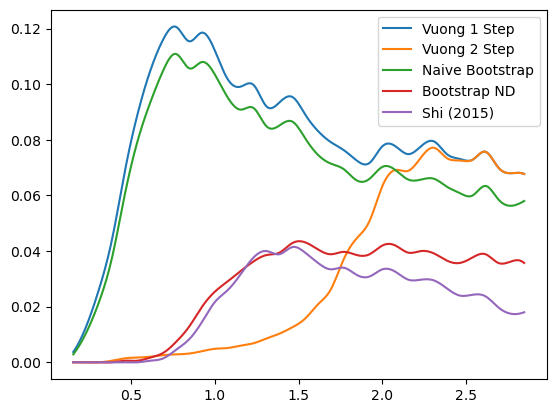

0.1 0.00022121819505175054


In [8]:
mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

# sequence 2

Quantiles: 1th: 0.73, 5th: 2.03, 10th: 3.28, 30th: 9.54, 50th: 16.59, 70th: 25.51, 90th: 40.83, 95th: 47.62, 99th: 62.47
bonus term 1.5295386359589245 // variance stats 18.650282130038068 //part1 30.055865725386454 //part2 19.650282130038068 18.650282130038068
-0.1495465032544285 -0.27361222239563365 3.4568559820410574
-3.2086237751722773 -0.27361222239563365 0.39777871012320837
---
Quantiles: 1th: 0.65, 5th: 1.75, 10th: 2.96, 30th: 8.53, 50th: 14.55, 70th: 22.39, 90th: 35.95, 95th: 43.96, 99th: 58.68
bonus term 2.81068152912237 // variance stats 7.291362559977612 //part1 23.304379598585847 //part2 8.291362559977612 7.291362559977612
0.8474453824613901 -1.1115143917272823 4.424508230247376
-4.77391767578335 -1.1115143917272823 -1.1968548279973643
---
Quantiles: 1th: 1.04, 5th: 2.38, 10th: 4.44, 30th: 13.23, 50th: 23.09, 70th: 35.58, 90th: 55.97, 95th: 67.29, 99th: 92.59
bonus term 4.239875578078016 // variance stats 12.31900205834039 //part1 56.470911551528246 //part2 13.31900205834039

Quantiles: 1th: 0.64, 5th: 1.94, 10th: 3.65, 30th: 10.57, 50th: 18.99, 70th: 28.66, 90th: 46.06, 95th: 54.54, 99th: 70.88
bonus term 1.0855143054780954 // variance stats 34.23803327099421 //part1 38.251389212577294 //part2 35.23803327099421 34.23803327099421
-1.2032629869363525 0.21123770937445563 2.7862678137740504
-3.3742915978925434 0.21123770937445563 0.6152392028178596
---
Quantiles: 1th: 0.78, 5th: 1.94, 10th: 3.46, 30th: 9.73, 50th: 16.99, 70th: 26.33, 90th: 41.49, 95th: 48.52, 99th: 64.38
bonus term 5.6597803539770215 // variance stats 4.482465813534721 //part1 31.029552302794468 //part2 5.482465813534722 4.482465813534721
3.9072413822637038 -2.419529608339012 7.227899554349617
-7.412319325690339 -2.419529608339012 -4.091661153604426
---
Quantiles: 1th: 0.81, 5th: 1.97, 10th: 3.79, 30th: 10.64, 50th: 18.47, 70th: 28.27, 90th: 44.63, 95th: 52.79, 99th: 69.84
bonus term 1.7645977180531571 // variance stats 19.348179248629368 //part1 35.90635066866798 //part2 20.348179248629368 19

Quantiles: 1th: 0.64, 5th: 1.82, 10th: 3.11, 30th: 9.06, 50th: 16.04, 70th: 24.66, 90th: 38.54, 95th: 46.50, 99th: 61.80
bonus term 0.5708365461676814 // variance stats 45.915261918590815 //part1 26.78094607616053 //part2 46.915261918590815 45.915261918590815
-1.4447573247056924 0.6330942944114724 2.40690509531096
-2.586430417041055 0.6330942944114724 1.2652320029755972
---
Quantiles: 1th: 0.63, 5th: 1.76, 10th: 2.94, 30th: 8.56, 50th: 15.07, 70th: 22.79, 90th: 36.02, 95th: 42.22, 99th: 54.64
bonus term 0.8967580238226185 // variance stats 25.080173969835514 //part1 23.38760527013979 //part2 26.080173969835517 25.080173969835514
-1.025309645093104 0.13111591489112984 2.7152148522000044
-2.8188256927383413 0.13111591489112984 0.9216988045547676
---
Quantiles: 1th: 0.76, 5th: 2.07, 10th: 3.47, 30th: 9.87, 50th: 17.61, 70th: 26.76, 90th: 41.90, 95th: 48.99, 99th: 65.58
bonus term 2.130044906440504 // variance stats 13.857264814884473 //part1 31.64664124258239 //part2 14.857264814884473 13

Quantiles: 1th: 0.84, 5th: 2.02, 10th: 3.70, 30th: 10.26, 50th: 17.87, 70th: 27.38, 90th: 43.51, 95th: 51.27, 99th: 66.53
bonus term 2.6236291407575485 // variance stats 12.00516349284868 //part1 34.12072592015403 //part2 13.00516349284868 12.00516349284868
0.7349452591341414 -0.8602848915311707 4.487568022620836
-4.5123130223809556 -0.8602848915311707 -0.7596902588942611
---
Quantiles: 1th: 0.76, 5th: 1.84, 10th: 3.28, 30th: 9.99, 50th: 17.57, 70th: 26.88, 90th: 42.66, 95th: 50.75, 99th: 67.28
bonus term 2.1771634582003414 // variance stats 14.069767514952494 //part1 32.80934715712914 //part2 15.069767514952495 14.069767514952494
0.43198032623228355 -0.8221431859742054 4.058742266201726
-3.922346590168399 -0.8221431859742054 -0.2955846501989563
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.51, 30th: 10.87, 50th: 19.11, 70th: 29.23, 90th: 46.69, 95th: 55.19, 99th: 73.38
bonus term 1.9048146803552983 // variance stats 19.63013962583141 //part1 39.29659281706323 //part2 20.63013962583141 

Quantiles: 1th: 0.56, 5th: 1.52, 10th: 2.82, 30th: 8.97, 50th: 15.72, 70th: 24.53, 90th: 38.46, 95th: 45.27, 99th: 61.12
bonus term 4.2388222639330335 // variance stats 5.290434653274742 //part1 26.664034458116852 //part2 6.290434653274742 5.290434653274742
2.466669723517088 -2.023595568875775 5.865606994899749
-6.010974804348979 -2.023595568875775 -2.612037532966318
---
Quantiles: 1th: 0.73, 5th: 2.30, 10th: 3.91, 30th: 11.73, 50th: 20.21, 70th: 31.34, 90th: 49.93, 95th: 59.87, 99th: 77.73
bonus term 0.7784066629408489 // variance stats 56.733271688724216 //part1 44.9399633558772 //part2 57.73327168872421 56.733271688724216
-1.2411525017679028 0.5814747312239326 2.8629874460070934
-2.7979658276496004 0.5814747312239326 1.3061741201253958
---
Quantiles: 1th: 0.71, 5th: 2.10, 10th: 3.47, 30th: 10.21, 50th: 17.87, 70th: 28.02, 90th: 44.28, 95th: 53.40, 99th: 70.30
bonus term 4.800079675566097 // variance stats 6.364619362540994 //part1 35.35075972041356 //part2 7.364619362540994 6.364619

Quantiles: 1th: 0.86, 5th: 2.09, 10th: 3.68, 30th: 10.58, 50th: 18.24, 70th: 28.42, 90th: 44.77, 95th: 53.04, 99th: 70.41
bonus term 0.6807481186597408 // variance stats 52.07144009206682 //part1 36.12828299723763 //part2 53.071440092066815 52.07144009206682
-1.2321671216521535 0.666087806647812 2.5167642233332996
-2.593663358971635 0.666087806647812 1.1552679860138182
---
Quantiles: 1th: 0.80, 5th: 2.07, 10th: 3.55, 30th: 10.49, 50th: 18.15, 70th: 28.02, 90th: 43.59, 95th: 51.81, 99th: 69.43
bonus term 0.9861979862699436 // variance stats 33.734283988551496 //part1 34.25488092403783 //part2 34.734283988551496 33.734283988551496
-0.9000732655372203 0.11159566280636107 2.8901305649590574
-2.8724692380771075 0.11159566280636107 0.9177345924191704
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.76, 5th: 2.05, 10th: 3.35, 30th: 8.83, 50th: 15.42, 70th: 23.92, 90th: 38.07, 95th: 45.21, 99th: 61.21
bonus term 1.37280964858978 // variance stats 18.03486610697785 //part1 26.13124785127378

Quantiles: 1th: 0.77, 5th: 1.90, 10th: 3.26, 30th: 9.61, 50th: 16.55, 70th: 25.46, 90th: 40.93, 95th: 49.04, 99th: 63.91
bonus term 1.9993591274085465 // variance stats 14.107743616805422 //part1 30.20580509480813 //part2 15.107743616805422 14.107743616805422
0.3362947524087019 -0.583449657414788 3.7972709743688386
-3.662423502408391 -0.583449657414788 -0.20144728044825444
---
Quantiles: 1th: 0.72, 5th: 1.69, 10th: 2.77, 30th: 7.59, 50th: 13.13, 70th: 19.69, 90th: 31.23, 95th: 37.03, 99th: 47.00
bonus term 0.7926040655712593 // variance stats 21.176315626148398 //part1 17.57703792467667 //part2 22.1763156261484 21.176315626148398
-1.0157916745696478 -0.14029263030059702 2.725588912169121
-2.6009998057121666 -0.14029263030059702 1.140380781026602
---
Quantiles: 1th: 0.69, 5th: 1.98, 10th: 3.62, 30th: 10.85, 50th: 18.79, 70th: 28.11, 90th: 45.24, 95th: 54.22, 99th: 71.31
bonus term 0.59581544055807 // variance stats 60.93143289395981 //part1 36.899703974107204 //part2 61.9314328939598 60

Quantiles: 1th: 0.87, 5th: 2.53, 10th: 4.26, 30th: 12.46, 50th: 21.94, 70th: 33.85, 90th: 55.60, 95th: 65.34, 99th: 85.47
bonus term 3.2162162626131847 // variance stats 16.3285064744857 //part1 55.73222433003877 //part2 17.3285064744857 16.3285064744857
1.2367317364112889 -1.0159345244328686 5.038519167304816
-5.19570078881508 -1.0159345244328686 -1.3939133579215537
---
Quantiles: 1th: 0.69, 5th: 1.81, 10th: 3.67, 30th: 11.41, 50th: 19.39, 70th: 30.04, 90th: 47.09, 95th: 56.94, 99th: 74.44
bonus term 0.9550283344109886 // variance stats 40.8627058859023 //part1 39.98007027615035 //part2 41.862705885902294 40.8627058859023
-0.805013443389359 0.14116160345786877 2.95219786603067
-2.715070112211336 0.14116160345786877 1.0421411972086925
---
Quantiles: 1th: 0.59, 5th: 1.72, 10th: 2.94, 30th: 8.39, 50th: 14.53, 70th: 22.46, 90th: 35.82, 95th: 41.66, 99th: 54.42
bonus term 0.7018223195079258 // variance stats 31.96062912171888 //part1 23.132505182645232 //part2 32.96062912171888 31.96062912

Quantiles: 1th: 0.84, 5th: 2.16, 10th: 3.68, 30th: 10.21, 50th: 17.48, 70th: 26.61, 90th: 43.04, 95th: 50.94, 99th: 65.41
bonus term 0.7219301501241786 // variance stats 45.24687890532637 //part1 33.387016230896975 //part2 46.24687890532637 45.24687890532637
-1.2892849017414836 0.47573265512609136 2.756955462995759
-2.7331452019898412 0.47573265512609136 1.313095162747402
---
Quantiles: 1th: 0.74, 5th: 1.97, 10th: 3.52, 30th: 10.40, 50th: 18.40, 70th: 28.21, 90th: 44.79, 95th: 52.75, 99th: 70.97
bonus term 3.2939170141571497 // variance stats 9.980004057350438 //part1 36.16722218002114 //part2 10.980004057350438 9.980004057350438
1.3279179750193733 -2.0233291873344985 5.05867280990405
-5.259916053294925 -2.0233291873344985 -1.5291612184102492
---
Quantiles: 1th: 0.71, 5th: 1.76, 10th: 2.67, 30th: 7.22, 50th: 12.52, 70th: 18.97, 90th: 29.98, 95th: 35.41, 99th: 46.19
bonus term 0.8656930916384589 // variance stats 17.711946131843572 //part1 16.198802497447964 //part2 18.711946131843572 1

Quantiles: 1th: 0.61, 5th: 1.68, 10th: 3.00, 30th: 8.23, 50th: 14.29, 70th: 22.58, 90th: 35.16, 95th: 42.31, 99th: 55.91
bonus term 1.0954097799479172 // variance stats 19.34283295522335 //part1 22.28373817099845 //part2 20.342832955223354 19.34283295522335
-0.8931826788557744 -0.9642742413614002 2.8595390363252666
-3.0840022387516086 -0.9642742413614002 0.6687194764294319
---
Quantiles: 1th: 0.79, 5th: 2.10, 10th: 3.84, 30th: 11.18, 50th: 19.60, 70th: 29.52, 90th: 46.96, 95th: 56.51, 99th: 72.80
bonus term 3.500236458894935 // variance stats 10.357836246461037 //part1 39.75511252402132 //part2 11.357836246461037 10.357836246461037
1.5828670975883579 -3.0168898863473372 5.302847166152519
-5.417605820201512 -3.0168898863473372 -1.6976257516373505
---
Quantiles: 1th: 0.65, 5th: 1.71, 10th: 2.95, 30th: 8.72, 50th: 15.26, 70th: 23.76, 90th: 38.23, 95th: 45.52, 99th: 60.51
bonus term 1.8488902465283432 // variance stats 13.247568616228085 //part1 26.342190651287435 //part2 14.24756861622808

Quantiles: 1th: 0.89, 5th: 2.31, 10th: 4.00, 30th: 11.90, 50th: 20.67, 70th: 31.79, 90th: 51.25, 95th: 60.85, 99th: 79.46
bonus term 4.027451519804562 // variance stats 10.758514927869083 //part1 47.356848816890974 //part2 11.758514927869083 10.758514927869083
2.2201617131742175 -2.0112701516258733 5.818700646416995
-5.834741326434908 -2.0112701516258733 -2.236202393192129
---
Quantiles: 1th: 0.75, 5th: 1.96, 10th: 3.39, 30th: 10.59, 50th: 18.67, 70th: 28.66, 90th: 44.77, 95th: 53.38, 99th: 70.78
bonus term 2.2510831553444346 // variance stats 15.048841356338002 //part1 36.12727644004761 //part2 16.048841356338002 15.048841356338002
0.3118476120481012 -2.229196560238825 4.148097260603211
-4.190318698640768 -2.229196560238825 -0.3540690500856585
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 3.23, 30th: 9.84, 50th: 17.17, 70th: 26.24, 90th: 41.36, 95th: 48.76, 99th: 65.11
bonus term 0.5987335771743518 // variance stats 50.500978303410335 //part1 30.835364967579547 //part2 51.50097830341033 

Quantiles: 1th: 0.58, 5th: 1.68, 10th: 3.32, 30th: 9.70, 50th: 17.07, 70th: 25.74, 90th: 41.28, 95th: 48.99, 99th: 65.58
bonus term 2.4488803665642274 // variance stats 11.545005630119503 //part1 30.721217986037345 //part2 12.545005630119503 11.545005630119503
0.5844904960490883 -1.853872584252143 4.211831717060489
-4.313270237079366 -1.853872584252143 -0.6859290160679652
---
Quantiles: 1th: 0.69, 5th: 1.94, 10th: 3.35, 30th: 9.84, 50th: 17.22, 70th: 26.49, 90th: 41.25, 95th: 49.50, 99th: 65.85
bonus term 0.4705125677027382 // variance stats 64.20965656826868 //part1 30.68196295094982 //part2 65.20965656826868 64.20965656826868
-1.3824114201004565 0.7634217556027102 2.4426716884276174
-2.323436555505933 0.7634217556027102 1.5016465530221408
---
Quantiles: 1th: 0.65, 5th: 1.84, 10th: 3.08, 30th: 9.17, 50th: 16.07, 70th: 24.26, 90th: 38.19, 95th: 45.85, 99th: 57.32
bonus term 1.0843723804430894 // variance stats 23.251795344047167 //part1 26.29797704724306 //part2 24.251795344047167 23.2

Quantiles: 1th: 0.63, 5th: 1.72, 10th: 3.13, 30th: 9.09, 50th: 15.95, 70th: 24.10, 90th: 37.99, 95th: 45.61, 99th: 59.39
bonus term 0.5919282885550701 // variance stats 42.94681156836234 //part1 26.013360959112873 //part2 43.94681156836234 42.94681156836234
-1.513449044190665 -0.021737300196245403 2.625046174132
-2.697305621300805 -0.021737300196245403 1.4411895970218602
---
Quantiles: 1th: 0.87, 5th: 2.19, 10th: 3.78, 30th: 11.49, 50th: 19.94, 70th: 31.08, 90th: 49.08, 95th: 58.10, 99th: 74.87
bonus term 0.684782523477639 // variance stats 62.422518947238416 //part1 43.430632569998295 //part2 63.42251894723841 62.422518947238416
-1.311709910079929 0.4140739592676632 2.6127318097869563
-2.6812749570352072 0.4140739592676632 1.2431667628316785
---
Quantiles: 1th: 0.76, 5th: 2.33, 10th: 4.44, 30th: 12.87, 50th: 21.78, 70th: 34.04, 90th: 53.24, 95th: 64.64, 99th: 84.84
bonus term 2.623602959737374 // variance stats 18.473061321536843 //part1 51.08958131833145 //part2 19.473061321536843 18

Quantiles: 1th: 0.67, 5th: 1.79, 10th: 3.03, 30th: 8.44, 50th: 14.90, 70th: 22.83, 90th: 35.87, 95th: 42.56, 99th: 56.16
bonus term 0.8312267191639352 // variance stats 26.901445188638604 //part1 23.192426744084432 //part2 27.901445188638604 26.901445188638604
-0.9107940062376634 -1.0279751219299957 2.7168155050782907
-2.573247444565534 -1.0279751219299957 1.05436206675042
---
Quantiles: 1th: 0.65, 5th: 1.93, 10th: 3.53, 30th: 10.86, 50th: 19.23, 70th: 29.04, 90th: 45.80, 95th: 54.87, 99th: 72.18
bonus term 0.5756558317365107 // variance stats 64.69441600915643 //part1 37.81737368819528 //part2 65.69441600915641 64.69441600915643
-1.2903226766008777 0.6150140487217476 2.692609025454679
-2.441634340073899 0.6150140487217476 1.5412973619816577
---
Quantiles: 1th: 0.75, 5th: 1.82, 10th: 3.25, 30th: 9.94, 50th: 17.59, 70th: 26.54, 90th: 42.38, 95th: 50.64, 99th: 68.22
bonus term 0.5281140756204167 // variance stats 60.32030917209323 //part1 32.38411839517818 //part2 61.32030917209323 60.32

0.7692307692307693 [0.98 0.   0.02]
Quantiles: 1th: 0.85, 5th: 2.12, 10th: 3.91, 30th: 11.98, 50th: 20.78, 70th: 31.58, 90th: 51.54, 95th: 61.53, 99th: 79.95
bonus term 0.6558400513880143 // variance stats 72.00757789127121 //part1 47.88129363592576 //part2 73.00757789127121 72.00757789127121
-1.3540908595485288 0.3237200815227314 2.7282098105862316
-2.665770962324557 0.3237200815227314 1.416529707810203
---
Quantiles: 1th: 0.82, 5th: 2.20, 10th: 3.79, 30th: 10.35, 50th: 18.26, 70th: 27.82, 90th: 44.41, 95th: 53.13, 99th: 70.46
bonus term 0.5317811722639063 // variance stats 65.84725714178103 //part1 35.5481127654831 //part2 66.84725714178101 65.84725714178103
-1.4241150830779912 0.19562970129616422 2.386717799896733
-2.487677427605804 0.19562970129616422 1.3231554553689202
---
Quantiles: 1th: 0.98, 5th: 2.26, 10th: 4.01, 30th: 11.89, 50th: 20.62, 70th: 32.20, 90th: 51.42, 95th: 60.91, 99th: 78.63
bonus term 0.6656422705475552 // variance stats 70.59940835223647 //part1 47.659592745444

Quantiles: 1th: 0.72, 5th: 2.10, 10th: 3.65, 30th: 10.37, 50th: 18.48, 70th: 28.85, 90th: 44.97, 95th: 53.86, 99th: 71.38
bonus term 0.44082281882486013 // variance stats 81.69637571841642 //part1 36.45444945079205 //part2 82.69637571841642 81.69637571841642
-1.4347390085513996 0.8019048408974623 2.5604582010458703
-2.31638464620112 0.8019048408974623 1.6788125633961501
---
Quantiles: 1th: 0.68, 5th: 1.85, 10th: 2.89, 30th: 8.44, 50th: 14.74, 70th: 21.87, 90th: 34.86, 95th: 41.79, 99th: 54.20
bonus term 0.6931429227253435 // variance stats 30.606714084078437 //part1 21.907970177982406 //part2 31.606714084078437 30.606714084078437
-1.3573423121163508 -0.5889352762816362 2.6631322856682744
-2.743628157567038 -0.5889352762816362 1.2768464402175874
---
Quantiles: 1th: 0.82, 5th: 1.94, 10th: 3.28, 30th: 9.74, 50th: 17.14, 70th: 26.14, 90th: 41.23, 95th: 48.82, 99th: 61.59
bonus term 0.7785700390048346 // variance stats 38.35546925238575 //part1 30.640989230883548 //part2 39.35546925238575 3

Quantiles: 1th: 0.70, 5th: 1.65, 10th: 2.71, 30th: 7.76, 50th: 13.47, 70th: 20.94, 90th: 33.13, 95th: 39.33, 99th: 52.25
bonus term 0.5137935911671062 // variance stats 37.5028821934311 //part1 19.78253411244699 //part2 38.5028821934311 37.5028821934311
-1.6255239078253323 -0.3798418214493429 2.4129261673864626
-2.6531110901595443 -0.3798418214493429 1.38533898505225
---
Quantiles: 1th: 0.64, 5th: 1.67, 10th: 2.58, 30th: 7.52, 50th: 12.58, 70th: 19.21, 90th: 30.55, 95th: 35.86, 99th: 46.44
bonus term 0.34371468502819497 // variance stats 47.94369714811056 //part1 16.822667449378184 //part2 48.94369714811056 47.94369714811056
-1.6051526537048937 0.2855085814600309 2.3367838608540885
-2.2925820237612835 0.2855085814600309 1.6493544907976987
---
Quantiles: 1th: 0.68, 5th: 1.74, 10th: 3.22, 30th: 9.52, 50th: 17.11, 70th: 25.97, 90th: 41.14, 95th: 49.01, 99th: 66.11
bonus term 0.48584169777321506 // variance stats 61.80440439302805 //part1 30.512998457944313 //part2 62.804404393028044 61.80

Quantiles: 1th: 0.76, 5th: 1.88, 10th: 3.28, 30th: 10.03, 50th: 17.44, 70th: 27.11, 90th: 43.02, 95th: 51.61, 99th: 68.01
bonus term 0.6145986762054781 // variance stats 53.28310608727467 //part1 33.36232514156054 //part2 54.28310608727466 53.28310608727467
-1.2240854779258523 -0.07024915201789139 2.724142319261183
-2.4532828303368084 -0.07024915201789139 1.4949449668502262
---
Quantiles: 1th: 0.58, 5th: 1.52, 10th: 2.83, 30th: 8.42, 50th: 14.83, 70th: 23.39, 90th: 36.33, 95th: 43.88, 99th: 56.83
bonus term 0.6179215071039651 // variance stats 37.50482558847124 //part1 23.79295985840347 //part2 38.50482558847125 37.50482558847124
-1.2066654357028894 -0.7443089463560648 2.6305312357911625
-2.4425084499108194 -0.7443089463560648 1.3946882215832326
---
Quantiles: 1th: 0.74, 5th: 2.14, 10th: 3.69, 30th: 10.94, 50th: 19.33, 70th: 29.27, 90th: 47.27, 95th: 56.33, 99th: 74.29
bonus term 0.7796163003663067 // variance stats 50.66653570178361 //part1 40.280073416568236 //part2 51.66653570178361

Quantiles: 1th: 0.79, 5th: 2.09, 10th: 3.80, 30th: 10.99, 50th: 19.04, 70th: 28.56, 90th: 45.28, 95th: 54.42, 99th: 70.09
bonus term 0.6061604721989483 // variance stats 59.981034378177974 //part1 36.96429259385666 //part2 60.981034378177974 59.981034378177974
-1.3058213688405564 -0.04809202452600963 2.6416013484218315
-2.5181423132384535 -0.04809202452600963 1.4292804040239344
---
Quantiles: 1th: 0.78, 5th: 2.10, 10th: 3.41, 30th: 10.56, 50th: 17.95, 70th: 27.46, 90th: 43.24, 95th: 51.42, 99th: 68.93
bonus term 0.4621406903946402 // variance stats 71.9294270511334 //part1 33.703655767496336 //part2 72.9294270511334 71.9294270511334
-1.5192401506279092 0.37069237430955476 2.613311362177186
-2.4435215314171894 0.37069237430955476 1.6890299813879055
---
Quantiles: 1th: 0.82, 5th: 1.93, 10th: 3.25, 30th: 8.98, 50th: 15.37, 70th: 23.54, 90th: 37.82, 95th: 44.82, 99th: 58.63
bonus term 0.31496457383901866 // variance stats 80.88856472022002 //part1 25.791996889392994 //part2 81.888564720220

Quantiles: 1th: 0.76, 5th: 1.92, 10th: 3.17, 30th: 8.95, 50th: 16.03, 70th: 24.38, 90th: 38.79, 95th: 46.67, 99th: 61.71
bonus term 0.2831969165867292 // variance stats 94.76139944386011 //part1 27.119333050531303 //part2 95.76139944386011 94.76139944386011
-1.654244147794279 1.2689368064694606 2.4197868175816803
-2.2206379809677372 1.2689368064694606 1.8533929844082218
---
Quantiles: 1th: 0.71, 5th: 1.64, 10th: 2.99, 30th: 8.86, 50th: 15.41, 70th: 23.75, 90th: 37.76, 95th: 44.22, 99th: 59.64
bonus term 0.8717177624388555 // variance stats 28.48380412297533 //part1 25.701555758265552 //part2 29.48380412297533 28.48380412297533
-1.1895882658642722 -2.0646270841192953 2.8361279472681766
-2.9330237907419834 -2.0646270841192953 1.0926924223904655
---
1.076923076923077 [0.96285714 0.00142857 0.03571429]
Quantiles: 1th: 0.75, 5th: 1.83, 10th: 3.18, 30th: 9.29, 50th: 16.54, 70th: 25.15, 90th: 40.60, 95th: 48.90, 99th: 64.16
bonus term 0.5197828436793065 // variance stats 56.1657340467534 //pa

Quantiles: 1th: 0.76, 5th: 1.93, 10th: 3.29, 30th: 9.82, 50th: 17.54, 70th: 26.37, 90th: 42.12, 95th: 50.39, 99th: 65.88
bonus term 0.3895173721014126 // variance stats 81.09879522634756 //part1 31.978906969258897 //part2 82.09879522634756 81.09879522634756
-1.511765278924771 0.7600821069941672 2.2192865194667206
-2.2908000231275962 0.7600821069941672 1.4402517752638955
---
Quantiles: 1th: 0.71, 5th: 1.72, 10th: 2.94, 30th: 8.94, 50th: 15.59, 70th: 24.15, 90th: 37.94, 95th: 44.64, 99th: 58.38
bonus term 0.33945462260422815 // variance stats 75.45448234072795 //part1 25.952827449373427 //part2 76.45448234072795 75.45448234072795
-1.5609957882735668 0.73736018572848 2.3940831519290486
-2.2399050334820227 0.73736018572848 1.7151739067205924
---
Quantiles: 1th: 0.85, 5th: 2.49, 10th: 4.38, 30th: 12.59, 50th: 21.70, 70th: 33.39, 90th: 52.92, 95th: 62.21, 99th: 80.30
bonus term 1.7635627657404858 // variance stats 27.629502724363295 //part1 50.48992500635291 //part2 28.629502724363295 27.629

Quantiles: 1th: 0.67, 5th: 1.79, 10th: 3.05, 30th: 9.02, 50th: 15.51, 70th: 24.04, 90th: 37.73, 95th: 45.92, 99th: 59.29
bonus term 0.26120837199125396 // variance stats 97.22981527363464 //part1 25.65845012862772 //part2 98.22981527363464 97.22981527363464
-1.7220355010004142 1.3154807556583856 2.3102508419358228
-2.2444522449829223 1.3154807556583856 1.787834097953315
---
Quantiles: 1th: 0.63, 5th: 1.63, 10th: 2.77, 30th: 8.02, 50th: 13.97, 70th: 21.47, 90th: 33.57, 95th: 40.15, 99th: 52.70
bonus term 0.441478607467278 // variance stats 45.009229580195495 //part1 20.312090605707 //part2 46.00922958019549 45.009229580195495
-1.6653360250724478 -0.7778823152166684 2.348406792032906
-2.5482932400070037 -0.7778823152166684 1.4654495770983502
---
Quantiles: 1th: 0.74, 5th: 2.02, 10th: 3.57, 30th: 10.64, 50th: 18.65, 70th: 28.78, 90th: 45.04, 95th: 53.10, 99th: 71.23
bonus term 1.0208332510106521 // variance stats 34.82647577959139 //part1 36.57285774233466 //part2 35.82647577959139 34.826

Quantiles: 1th: 0.54, 5th: 1.82, 10th: 3.81, 30th: 11.25, 50th: 19.52, 70th: 29.54, 90th: 46.83, 95th: 57.10, 99th: 73.32
bonus term 0.6815535553700016 // variance stats 57.017049512567375 //part1 39.541726367367716 //part2 58.017049512567375 57.017049512567375
-1.2610587451955464 -0.8468180355820429 2.6032884615281326
-2.6241658559355496 -0.8468180355820429 1.2401813507881294
---
Quantiles: 1th: 0.64, 5th: 1.60, 10th: 2.78, 30th: 8.30, 50th: 14.24, 70th: 22.46, 90th: 35.47, 95th: 41.68, 99th: 55.05
bonus term 0.4790373360556591 // variance stats 46.34474988839113 //part1 22.67990286275635 //part2 47.34474988839112 46.34474988839113
-1.6134364227690643 -1.515782102128301 2.3484671375726496
-2.5715110948803828 -1.515782102128301 1.3903924654613313
---
Quantiles: 1th: 0.65, 5th: 1.90, 10th: 3.31, 30th: 10.00, 50th: 17.36, 70th: 25.91, 90th: 41.24, 95th: 49.20, 99th: 63.23
bonus term 0.4496884647680876 // variance stats 67.19029661166327 //part1 30.664389795379382 //part2 68.1902966116632

Quantiles: 1th: 0.75, 5th: 2.03, 10th: 3.54, 30th: 9.84, 50th: 17.01, 70th: 26.32, 90th: 42.91, 95th: 51.52, 99th: 66.32
bonus term 0.46700224978937666 // variance stats 70.09050164769474 //part1 33.19942420812883 //part2 71.09050164769474 70.09050164769474
-1.4290970238708192 -0.31839387978295136 2.4772673933534537
-2.3631015234495725 -0.31839387978295136 1.5432628937747006
---
Quantiles: 1th: 0.64, 5th: 1.79, 10th: 3.12, 30th: 8.95, 50th: 15.58, 70th: 24.30, 90th: 38.35, 95th: 45.08, 99th: 60.20
bonus term 0.6642938143398682 // variance stats 38.90575635401393 //part1 26.50914710252535 //part2 39.90575635401393 38.90575635401393
-1.4628972634209385 -2.1397230977562405 2.5500538844063847
-2.791484892100675 -2.1397230977562405 1.2214662557266485
---
Quantiles: 1th: 0.78, 5th: 1.82, 10th: 3.00, 30th: 8.93, 50th: 15.63, 70th: 24.19, 90th: 39.05, 95th: 46.34, 99th: 60.74
bonus term 0.23629851303422814 // variance stats 115.3402358366429 //part1 27.491024734250136 //part2 116.3402358366428

Quantiles: 1th: 0.74, 5th: 2.35, 10th: 4.40, 30th: 13.33, 50th: 23.49, 70th: 36.03, 90th: 56.86, 95th: 67.00, 99th: 89.88
bonus term 0.7659195557445 // variance stats 75.09036055971012 //part1 58.279095156332005 //part2 76.09036055971012 75.09036055971012
-1.1794067173661469 -0.05895102856511145 2.842277360290752
-2.711245828855147 -0.05895102856511145 1.310438248801752
---
Quantiles: 1th: 0.67, 5th: 1.79, 10th: 3.00, 30th: 9.16, 50th: 15.75, 70th: 23.94, 90th: 37.63, 95th: 44.05, 99th: 58.33
bonus term 0.4807476903012477 // variance stats 52.10893726225191 //part1 25.53199892318147 //part2 53.1089372622519 52.10893726225191
-1.5345747625300072 -1.4335898577949164 2.3003095842884225
-2.4960701431325027 -1.4335898577949164 1.3388142036859272
---
Quantiles: 1th: 0.74, 5th: 1.80, 10th: 3.23, 30th: 9.64, 50th: 16.99, 70th: 25.84, 90th: 42.37, 95th: 49.92, 99th: 64.08
bonus term 0.5069310507892756 // variance stats 62.84169017658354 //part1 32.363335085378864 //part2 63.84169017658354 62.84

Quantiles: 1th: 0.65, 5th: 1.67, 10th: 2.81, 30th: 7.99, 50th: 14.11, 70th: 22.14, 90th: 35.08, 95th: 42.00, 99th: 55.32
bonus term 0.6170373714964222 // variance stats 34.96330047456181 //part1 22.190700395159656 //part2 35.96330047456181 34.96330047456181
-1.4118445824831425 -2.776889499817875 2.566856031850034
-2.645919325475987 -2.776889499817875 1.3327812888571897
---
Quantiles: 1th: 0.68, 5th: 1.69, 10th: 2.83, 30th: 8.17, 50th: 14.16, 70th: 20.88, 90th: 33.75, 95th: 39.97, 99th: 52.60
bonus term 0.22850758666449725 // variance stats 88.83884309157926 //part1 20.528857223587217 //part2 89.83884309157926 88.83884309157926
-1.6664833086535227 1.0642660530200088 2.2840427946440633
-2.1234984819825176 1.0642660530200088 1.827027621315069
---
Quantiles: 1th: 0.67, 5th: 1.78, 10th: 3.12, 30th: 9.76, 50th: 17.11, 70th: 26.52, 90th: 41.83, 95th: 50.25, 99th: 64.78
bonus term 0.37888924376065614 // variance stats 82.27203520340352 //part1 31.550878444628296 //part2 83.2720352034035 82.272

Quantiles: 1th: 0.79, 5th: 2.21, 10th: 3.95, 30th: 11.79, 50th: 20.83, 70th: 32.30, 90th: 50.50, 95th: 60.36, 99th: 78.30
bonus term 0.7896995055994676 // variance stats 57.207045305627766 //part1 45.966074900260054 //part2 58.20704530562776 57.207045305627766
-1.35341845066662 -1.7198791473130381 2.7636509959673714
-2.9328174618655556 -1.7198791473130381 1.1842519847684367
---
Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.26, 30th: 8.80, 50th: 15.10, 70th: 23.74, 90th: 37.54, 95th: 45.32, 99th: 58.49
bonus term 0.2685638634039307 // variance stats 93.57874384321376 //part1 25.40043284242421 //part2 94.57874384321374 93.57874384321376
-1.851854938555999 0.5784632529936911 2.3732375131260888
-2.388982665363861 0.5784632529936911 1.836109786318227
---
Quantiles: 1th: 0.78, 5th: 1.98, 10th: 3.54, 30th: 9.89, 50th: 17.35, 70th: 27.03, 90th: 43.21, 95th: 51.77, 99th: 68.25
bonus term 1.1917290649147931 // variance stats 27.2497845535839 //part1 33.66608933008691 //part2 28.249784553583904 27.249

Quantiles: 1th: 0.63, 5th: 1.80, 10th: 3.02, 30th: 8.61, 50th: 15.12, 70th: 23.44, 90th: 37.44, 95th: 43.94, 99th: 57.88
bonus term 0.3101273645090906 // variance stats 80.48221088987796 //part1 25.269863317651776 //part2 81.48221088987796 80.48221088987796
-1.6404188817483782 -0.31468214712678566 2.3010517589660924
-2.2606736107665593 -0.31468214712678566 1.6807970299479116
---
Quantiles: 1th: 0.78, 5th: 2.02, 10th: 3.68, 30th: 10.78, 50th: 18.92, 70th: 29.53, 90th: 46.31, 95th: 54.69, 99th: 71.93
bonus term 0.46337264804167627 // variance stats 82.44864861049946 //part1 38.667821282146484 //part2 83.44864861049945 82.44864861049946
-1.582823493499606 -0.4886148755037188 2.295835132613525
-2.5095687895829584 -0.4886148755037188 1.3690898365301725
---
Quantiles: 1th: 0.81, 5th: 1.98, 10th: 3.23, 30th: 9.11, 50th: 16.04, 70th: 24.61, 90th: 39.33, 95th: 46.41, 99th: 60.07
bonus term 0.39514991075234734 // variance stats 69.55850113479953 //part1 27.881185426235433 //part2 70.558501134799

1.6153846153846154 [0.95857143 0.         0.04142857]
Quantiles: 1th: 0.81, 5th: 1.96, 10th: 3.10, 30th: 8.83, 50th: 15.46, 70th: 23.89, 90th: 38.37, 95th: 45.93, 99th: 60.21
bonus term 0.31127283008379003 // variance stats 84.26517456115604 //part1 26.540732193239418 //part2 85.26517456115604 84.26517456115604
-1.553631003974561 -0.4386777990832381 2.258142059702563
-2.176176664142141 -0.4386777990832381 1.6355963995349834
---
Quantiles: 1th: 0.74, 5th: 2.10, 10th: 3.81, 30th: 10.43, 50th: 18.08, 70th: 27.54, 90th: 43.65, 95th: 51.06, 99th: 69.49
bonus term 0.3324351382988936 // variance stats 102.34254498929977 //part1 34.354693235677495 //part2 103.34254498929977 102.34254498929977
-1.3491493401083259 0.709313696263227 2.3560707424307843
-2.014019616706113 0.709313696263227 1.6912004658329975
---
Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.28, 30th: 10.04, 50th: 17.38, 70th: 26.12, 90th: 41.40, 95th: 49.22, 99th: 63.57
bonus term 0.5814650180008293 // variance stats 52.1378938448312 //

Quantiles: 1th: 0.74, 5th: 2.01, 10th: 3.30, 30th: 9.65, 50th: 17.01, 70th: 26.07, 90th: 41.40, 95th: 49.28, 99th: 63.98
bonus term 0.29538330558073833 // variance stats 103.59225781247255 //part1 30.894806850800943 //part2 104.59225781247255 103.59225781247255
-1.6046277934337865 0.576159253503294 2.294703164456936
-2.1953944045952634 0.576159253503294 1.7039365532954593
---
Quantiles: 1th: 0.73, 5th: 1.81, 10th: 3.21, 30th: 9.68, 50th: 17.33, 70th: 26.85, 90th: 42.66, 95th: 51.34, 99th: 66.39
bonus term 0.3811196134653823 // variance stats 85.08935529091404 //part1 32.81034181195713 //part2 86.08935529091404 85.08935529091404
-1.6511256174119975 -0.5810396803179977 2.4260148663070065
-2.4133648443427624 -0.5810396803179977 1.6637756393762417
---
Quantiles: 1th: 0.60, 5th: 1.76, 10th: 2.99, 30th: 8.71, 50th: 14.99, 70th: 22.89, 90th: 35.84, 95th: 42.96, 99th: 56.64
bonus term 0.23292679547758818 // variance stats 98.43886467729075 //part1 23.161976095210868 //part2 99.43886467729074 9

Quantiles: 1th: 0.73, 5th: 1.62, 10th: 2.91, 30th: 9.08, 50th: 15.91, 70th: 24.87, 90th: 39.66, 95th: 47.97, 99th: 60.87
bonus term 0.37759619340000455 // variance stats 74.10876170336141 //part1 28.360782510177312 //part2 75.10876170336141 74.10876170336141
-1.5405707100064507 -0.9162811561027693 2.2895992528636855
-2.29576309680646 -0.9162811561027693 1.5344068660636767
---
Quantiles: 1th: 0.64, 5th: 1.68, 10th: 2.76, 30th: 7.91, 50th: 13.75, 70th: 21.19, 90th: 34.11, 95th: 41.13, 99th: 54.04
bonus term 0.17058842253303777 // variance stats 121.98021803082072 //part1 20.979001396646755 //part2 122.98021803082072 121.98021803082072
-1.7849332398244744 1.5369801680689206 2.2514124324718954
-2.12611008489055 1.5369801680689206 1.9102355874058197
---
Quantiles: 1th: 0.64, 5th: 1.74, 10th: 2.99, 30th: 8.96, 50th: 15.69, 70th: 24.44, 90th: 38.61, 95th: 46.17, 99th: 59.33
bonus term 0.4464811786170592 // variance stats 59.18767855935176 //part1 26.872665661404078 //part2 60.18767855935175 5

Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.20, 30th: 9.37, 50th: 16.28, 70th: 24.67, 90th: 39.33, 95th: 46.87, 99th: 62.58
bonus term 0.20650803857877686 // variance stats 134.02018812966776 //part1 27.88275421919514 //part2 135.02018812966776 134.02018812966776
-1.7496248538199197 1.378196585641514 2.2091182008020067
-2.162640930977474 1.378196585641514 1.7961021236444528
---
Quantiles: 1th: 0.67, 5th: 1.64, 10th: 2.64, 30th: 7.38, 50th: 12.71, 70th: 20.33, 90th: 32.09, 95th: 38.36, 99th: 49.97
bonus term 0.22653678452058224 // variance stats 80.92187050929923 //part1 18.55831712708816 //part2 81.92187050929923 80.92187050929923
-1.6697971788248187 -0.4628387823627393 2.1004052976296697
-2.122870747865983 -0.4628387823627393 1.6473317285885054
---
Quantiles: 1th: 0.90, 5th: 2.29, 10th: 3.88, 30th: 11.82, 50th: 20.56, 70th: 30.90, 90th: 50.43, 95th: 60.14, 99th: 77.50
bonus term 0.42362796792642426 // variance stats 107.23654530699073 //part1 45.85202774377684 //part2 108.23654530699073 

Quantiles: 1th: 0.85, 5th: 2.13, 10th: 3.49, 30th: 10.14, 50th: 18.15, 70th: 27.62, 90th: 45.14, 95th: 52.78, 99th: 68.35
bonus term 0.4238344047967368 // variance stats 85.67524943983156 //part1 36.735952756939696 //part2 86.67524943983155 85.67524943983156
-1.4814577177373671 -0.5834703155686685 2.510117723246861
-2.329126527330841 -0.5834703155686685 1.6624489136533873
---
Quantiles: 1th: 0.70, 5th: 2.00, 10th: 3.93, 30th: 11.65, 50th: 20.81, 70th: 31.45, 90th: 50.04, 95th: 59.63, 99th: 77.93
bonus term 0.7150003425240623 // variance stats 62.13444645064369 //part1 45.14115083727731 //part2 63.134446450643686 62.13444645064369
-1.3501158863676916 -1.5867839052897708 2.5396639572025723
-2.780116571415816 -1.5867839052897708 1.1096632721544477
---
Quantiles: 1th: 0.75, 5th: 1.82, 10th: 3.19, 30th: 9.13, 50th: 15.41, 70th: 24.38, 90th: 38.79, 95th: 45.84, 99th: 59.32
bonus term 0.23183427997095019 // variance stats 115.97318535401939 //part1 27.11839420245758 //part2 116.97318535401939

Quantiles: 1th: 0.62, 5th: 1.73, 10th: 3.11, 30th: 9.18, 50th: 15.83, 70th: 24.51, 90th: 39.30, 95th: 46.65, 99th: 61.32
bonus term 0.279246890891753 // variance stats 98.72413245115513 //part1 27.847653933862443 //part2 99.72413245115513 98.72413245115513
-1.7163882394749095 0.08494513013098427 2.3262968801321433
-2.2748820212584158 0.08494513013098427 1.7678030983486372
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 3.03, 30th: 8.59, 50th: 14.66, 70th: 22.84, 90th: 36.10, 95th: 42.82, 99th: 56.86
bonus term 0.347993687396018 // variance stats 66.50266749323234 //part1 23.490502170037235 //part2 67.50266749323232 66.50266749323234
-1.6080069289667716 -1.2555504388554224 2.1237210538979254
-2.3039943037588073 -1.2555504388554224 1.4277336791058892
---
1.9230769230769231 [0.96714286 0.00142857 0.03142857]
Quantiles: 1th: 0.62, 5th: 1.64, 10th: 3.01, 30th: 8.99, 50th: 15.71, 70th: 24.01, 90th: 37.56, 95th: 44.81, 99th: 58.27
bonus term 0.21248987826738638 // variance stats 118.71636889855209

Quantiles: 1th: 0.78, 5th: 2.04, 10th: 3.76, 30th: 11.24, 50th: 20.30, 70th: 31.53, 90th: 49.94, 95th: 59.56, 99th: 79.79
bonus term 0.5448175817499956 // variance stats 81.52921449588527 //part1 44.9633670653749 //part2 82.52921449588527 81.52921449588527
-1.51010745930772 -1.5165099283386172 2.557395727134418
-2.5997426228077107 -1.5165099283386172 1.4677605636344266
---
Quantiles: 1th: 0.63, 5th: 1.67, 10th: 3.03, 30th: 8.83, 50th: 15.50, 70th: 24.35, 90th: 38.43, 95th: 46.36, 99th: 60.40
bonus term 0.2642618380146882 // variance stats 99.75436402188151 //part1 26.625533424423388 //part2 100.75436402188151 99.75436402188151
-1.793627232741411 -0.07013055843197467 2.1809232871881354
-2.3221509087707872 -0.07013055843197467 1.6523996111587589
---
Quantiles: 1th: 0.77, 5th: 1.87, 10th: 3.15, 30th: 9.12, 50th: 15.60, 70th: 24.82, 90th: 39.63, 95th: 46.80, 99th: 62.69
bonus term 0.26252621025753403 // variance stats 106.86663439820883 //part1 28.317818741796717 //part2 107.86663439820883

Quantiles: 1th: 0.59, 5th: 1.62, 10th: 2.80, 30th: 8.53, 50th: 14.91, 70th: 22.56, 90th: 36.88, 95th: 43.83, 99th: 56.41
bonus term 0.32118560792438217 // variance stats 75.32154389440906 //part1 24.51338147345319 //part2 76.32154389440906 75.32154389440906
-1.6271964926317675 -1.851378090284803 2.180437599336256
-2.269567708480532 -1.851378090284803 1.5380663834874917
---
Quantiles: 1th: 0.79, 5th: 1.98, 10th: 3.52, 30th: 10.05, 50th: 17.29, 70th: 26.62, 90th: 41.91, 95th: 50.56, 99th: 65.05
bonus term 0.3126279179152868 // variance stats 100.30733471595175 //part1 31.671501121795053 //part2 101.30733471595175 100.30733471595175
-1.630704443366575 -0.6317898246279822 2.3300671237181674
-2.255960279197149 -0.6317898246279822 1.7048112878875938
---
Quantiles: 1th: 0.74, 5th: 1.90, 10th: 3.72, 30th: 11.74, 50th: 20.08, 70th: 30.47, 90th: 47.54, 95th: 57.01, 99th: 73.58
bonus term 0.6386871709736552 // variance stats 62.79889417537137 //part1 40.74753523211555 //part2 63.798894175371366 6

Quantiles: 1th: 0.67, 5th: 1.92, 10th: 3.92, 30th: 12.03, 50th: 21.28, 70th: 32.31, 90th: 51.37, 95th: 61.61, 99th: 82.16
bonus term 0.30055829430521086 // variance stats 157.25895930403357 //part1 47.566042866938105 //part2 158.25895930403357 157.25895930403357
-1.664451080586847 1.1743638904970544 2.365155219352
-2.265567669197269 1.1743638904970544 1.764038630741578
---
Quantiles: 1th: 0.88, 5th: 2.11, 10th: 3.39, 30th: 10.01, 50th: 17.52, 70th: 26.49, 90th: 41.53, 95th: 49.52, 99th: 66.44
bonus term 0.32119630774324553 // variance stats 95.82531299846602 //part1 31.099933031191362 //part2 96.82531299846602 95.82531299846602
-1.7091839239424285 -0.6579552449922488 2.270759644463686
-2.3515765394289194 -0.6579552449922488 1.628367028977195
---
Quantiles: 1th: 0.86, 5th: 2.04, 10th: 3.43, 30th: 9.52, 50th: 16.69, 70th: 25.71, 90th: 41.41, 95th: 48.48, 99th: 63.55
bonus term 0.3191587329991949 // variance stats 95.84283756548835 //part1 30.908237337448096 //part2 96.84283756548835 95.8

Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.12, 30th: 8.84, 50th: 15.47, 70th: 24.22, 90th: 38.63, 95th: 45.64, 99th: 61.94
bonus term 0.2368878864756891 // variance stats 112.53464480117998 //part1 26.894982048719605 //part2 113.53464480117998 112.53464480117998
-1.642367381158938 -0.28883037148552315 2.2403625157987817
-2.1161431541103166 -0.28883037148552315 1.7665867428474036
---
Quantiles: 1th: 0.64, 5th: 1.54, 10th: 2.49, 30th: 6.80, 50th: 11.87, 70th: 18.42, 90th: 29.19, 95th: 34.98, 99th: 46.32
bonus term 0.2472462777324472 // variance stats 61.137766871450935 //part1 15.363331565572814 //part2 62.13776687145093 61.137766871450935
-1.6837664413107611 -2.37058924935264 2.0788774768754648
-2.178258996775656 -2.37058924935264 1.5843849214105703
---
Quantiles: 1th: 0.78, 5th: 1.89, 10th: 3.19, 30th: 8.69, 50th: 14.93, 70th: 22.73, 90th: 35.81, 95th: 42.47, 99th: 55.52
bonus term 0.1545950474202295 // variance stats 148.55378773622834 //part1 23.120274906957157 //part2 149.553787736228

Quantiles: 1th: 0.73, 5th: 1.76, 10th: 3.07, 30th: 8.81, 50th: 15.13, 70th: 23.43, 90th: 37.59, 95th: 45.44, 99th: 58.90
bonus term 0.28966863921511776 // variance stats 86.92104283489266 //part1 25.467968836357436 //part2 87.92104283489266 86.92104283489266
-1.6429824246160545 -0.8911996197364276 2.219562721676523
-2.22231970304629 -0.8911996197364276 1.640225443246287
---
Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.45, 30th: 10.33, 50th: 18.08, 70th: 27.51, 90th: 43.99, 95th: 51.47, 99th: 67.67
bonus term 0.25643145326742045 // variance stats 135.032967763761 //part1 34.8831316159414 //part2 136.032967763761 135.032967763761
-1.8455160466514857 0.5919810528322609 2.2486528123563416
-2.358378953186327 0.5919810528322609 1.7357899058215007
---
Quantiles: 1th: 0.70, 5th: 1.78, 10th: 3.42, 30th: 10.62, 50th: 18.28, 70th: 28.43, 90th: 44.89, 95th: 53.39, 99th: 69.53
bonus term 0.25119159896476045 // variance stats 143.6224651873806 //part1 36.32794827664353 //part2 144.6224651873806 143.6224

Quantiles: 1th: 0.66, 5th: 1.59, 10th: 2.92, 30th: 8.36, 50th: 14.59, 70th: 22.34, 90th: 35.82, 95th: 42.84, 99th: 55.68
bonus term 0.1923587417693348 // variance stats 119.25833036757786 //part1 23.132741116788257 //part2 120.25833036757786 119.25833036757786
-1.6892050255079238 0.05438110762241497 2.092596656292143
-2.0739225090465934 0.05438110762241497 1.7078791727534735
---
Quantiles: 1th: 0.71, 5th: 2.20, 10th: 3.83, 30th: 11.96, 50th: 20.95, 70th: 31.89, 90th: 51.20, 95th: 60.56, 99th: 77.87
bonus term 0.34223413136829384 // variance stats 137.07417647522433 //part1 47.253695850390905 //part2 138.07417647522433 137.07417647522433
-1.593243131523988 0.4982513522981256 2.208448539050088
-2.277711394260576 0.4982513522981256 1.5239802763134997
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.46, 30th: 9.96, 50th: 17.52, 70th: 25.86, 90th: 41.48, 95th: 49.34, 99th: 66.20
bonus term 0.31843365471486784 // variance stats 96.43022629349286 //part1 31.02506303833354 //part2 97.4302262934928

Quantiles: 1th: 0.82, 5th: 2.18, 10th: 3.69, 30th: 10.57, 50th: 17.77, 70th: 27.21, 90th: 43.21, 95th: 51.73, 99th: 69.14
bonus term 0.2890415323581639 // variance stats 115.45625386694408 //part1 33.66069407039286 //part2 116.45625386694407 115.45625386694408
-1.682869984628036 -0.724474784860798 2.148030953699038
-2.2609530493443635 -0.724474784860798 1.5699478889827099
---
Quantiles: 1th: 0.70, 5th: 1.87, 10th: 3.44, 30th: 9.41, 50th: 16.59, 70th: 24.92, 90th: 39.94, 95th: 48.06, 99th: 63.18
bonus term 0.2039755006254641 // variance stats 140.019107329683 //part1 28.764443015328144 //part2 141.01910732968298 140.019107329683
-1.7721240266215246 0.5818400177535401 2.1290884303126116
-2.180075027872453 0.5818400177535401 1.7211374290616837
---
Quantiles: 1th: 0.77, 5th: 1.99, 10th: 3.42, 30th: 10.02, 50th: 17.44, 70th: 26.41, 90th: 41.10, 95th: 48.53, 99th: 63.43
bonus term 0.3087770098290985 // variance stats 97.6369714003657 //part1 30.45682908760322 //part2 98.6369714003657 97.6369

Quantiles: 1th: 0.75, 5th: 1.89, 10th: 3.21, 30th: 9.17, 50th: 15.94, 70th: 23.93, 90th: 37.41, 95th: 45.39, 99th: 59.71
bonus term 0.17450596288528306 // variance stats 143.60147146246464 //part1 25.23381901218617 //part2 144.60147146246464 143.60147146246464
-1.9000257476765332 0.8727662426407523 2.1521296627564594
-2.249037673447099 0.8727662426407523 1.8031177369858935
---
Quantiles: 1th: 0.62, 5th: 1.48, 10th: 2.45, 30th: 7.14, 50th: 12.56, 70th: 19.19, 90th: 30.28, 95th: 36.48, 99th: 46.98
bonus term 0.17826553991675204 // variance stats 91.6960158619152 //part1 16.524505315756123 //part2 92.6960158619152 91.6960158619152
-1.8018282685304703 -1.01219506598454 2.1322397772359016
-2.1583593483639745 -1.01219506598454 1.7757086974023975
---
Quantiles: 1th: 0.64, 5th: 1.63, 10th: 2.56, 30th: 6.92, 50th: 12.30, 70th: 19.15, 90th: 30.85, 95th: 37.15, 99th: 50.04
bonus term 0.1899794060750204 // variance stats 89.31989199244336 //part1 17.158919437484382 //part2 90.31989199244336 89.319

2.4615384615384617 [0.97142857 0.00142857 0.02714286]
Quantiles: 1th: 0.62, 5th: 1.62, 10th: 2.63, 30th: 7.52, 50th: 13.12, 70th: 20.08, 90th: 31.91, 95th: 39.09, 99th: 52.15
bonus term 0.18775533977276046 // variance stats 96.74772408278616 //part1 18.35265714717756 //part2 97.74772408278616 96.74772408278616
-1.934380167348339 -1.2297082965207933 2.15193318829735
-2.3098908468938597 -1.2297082965207933 1.7764225087518293
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.49, 30th: 10.13, 50th: 17.91, 70th: 27.45, 90th: 43.46, 95th: 52.11, 99th: 67.73
bonus term 0.20930638895285497 // variance stats 161.64817758034062 //part1 34.0433027191038 //part2 162.64817758034064 161.64817758034062
-1.7539578016190602 0.9136136706198533 2.312752813235144
-2.1725705795247703 0.9136136706198533 1.8941400353294335
---
Quantiles: 1th: 0.62, 5th: 1.61, 10th: 2.83, 30th: 8.35, 50th: 14.64, 70th: 22.27, 90th: 35.20, 95th: 41.71, 99th: 55.63
bonus term 0.22807836502309353 // variance stats 96.9464126359139 //

Quantiles: 1th: 0.82, 5th: 1.91, 10th: 3.13, 30th: 9.44, 50th: 16.40, 70th: 24.81, 90th: 40.20, 95th: 47.20, 99th: 61.02
bonus term 0.20015724229897738 // variance stats 144.5725386865975 //part1 29.13739789797056 //part2 145.5725386865975 144.5725386865975
-1.6124334940450695 0.8456900135129855 2.272770282251493
-2.0127479786430245 0.8456900135129855 1.8724557976535383
---
Quantiles: 1th: 0.65, 5th: 1.74, 10th: 2.98, 30th: 7.94, 50th: 14.04, 70th: 21.81, 90th: 34.52, 95th: 41.55, 99th: 55.07
bonus term 0.1441938177756268 // variance stats 147.97495777308478 //part1 21.481267914263885 //part2 148.97495777308478 147.97495777308478
-1.8184596500295895 1.3010559691875179 2.1257561646917624
-2.106847285580843 1.3010559691875179 1.8373685291405084
---
Quantiles: 1th: 0.82, 5th: 2.11, 10th: 3.63, 30th: 10.37, 50th: 17.74, 70th: 27.06, 90th: 42.97, 95th: 50.46, 99th: 65.39
bonus term 0.253726543863945 // variance stats 130.17235455273288 //part1 33.28190817116092 //part2 131.17235455273286 13

Quantiles: 1th: 0.82, 5th: 2.32, 10th: 4.33, 30th: 13.67, 50th: 23.65, 70th: 36.41, 90th: 56.71, 95th: 68.66, 99th: 90.24
bonus term 0.31400319464749166 // variance stats 183.64323420663771 //part1 57.978565410929264 //part2 184.64323420663774 183.64323420663771
-1.6246746611747325 0.6572185815279431 2.3809178684839307
-2.2526810504697155 0.6572185815279431 1.7529114791889473
---
Quantiles: 1th: 0.82, 5th: 2.05, 10th: 3.84, 30th: 11.25, 50th: 19.99, 70th: 30.38, 90th: 47.79, 95th: 56.50, 99th: 74.28
bonus term 0.2407453983963801 // variance stats 170.02490542616113 //part1 41.17345899252439 //part2 171.02490542616113 170.02490542616113
-1.7258727879668263 0.5689814051061193 2.253895231888957
-2.2073635847595865 0.5689814051061193 1.7724044350961967
---
Quantiles: 1th: 0.68, 5th: 2.06, 10th: 3.70, 30th: 10.76, 50th: 18.42, 70th: 28.47, 90th: 44.46, 95th: 53.74, 99th: 69.64
bonus term 0.23462551933558093 // variance stats 150.84590721799213 //part1 35.626924840003845 //part2 151.84590721

Quantiles: 1th: 0.64, 5th: 1.69, 10th: 3.00, 30th: 8.50, 50th: 14.69, 70th: 22.58, 90th: 35.57, 95th: 42.91, 99th: 55.07
bonus term 0.19460275254260403 // variance stats 116.19324206289987 //part1 22.806127484831997 //part2 117.19324206289986 116.19324206289987
-1.5424516587878212 -0.7405681923610805 2.2431738848314966
-1.931657163873029 -0.7405681923610805 1.8539683797462887
---
Quantiles: 1th: 0.54, 5th: 1.47, 10th: 2.80, 30th: 7.89, 50th: 13.28, 70th: 20.19, 90th: 32.02, 95th: 37.49, 99th: 49.76
bonus term 0.14919709106343648 // variance stats 122.91145879865995 //part1 18.487229202186928 //part2 123.91145879865995 122.91145879865995
-1.8541360059123206 -0.048010455408049414 2.101443622841147
-2.152530188039193 -0.048010455408049414 1.8030494407142743
---
Quantiles: 1th: 0.61, 5th: 1.63, 10th: 2.86, 30th: 8.58, 50th: 14.87, 70th: 22.96, 90th: 36.17, 95th: 43.22, 99th: 58.02
bonus term 0.151910882720335 // variance stats 154.2756683289144 //part1 23.588063840835353 //part2 155.275668

Quantiles: 1th: 0.66, 5th: 1.66, 10th: 3.05, 30th: 9.46, 50th: 16.53, 70th: 25.65, 90th: 40.15, 95th: 48.03, 99th: 63.12
bonus term 0.17938647720682963 // variance stats 161.0263767723132 //part1 29.065340943771755 //part2 162.02637677231323 161.0263767723132
-1.7473635090532458 0.8332441354243095 2.1904574086521724
-2.106136463466905 0.8332441354243095 1.831684454238513
---
Quantiles: 1th: 0.68, 5th: 1.74, 10th: 2.88, 30th: 8.22, 50th: 14.24, 70th: 21.21, 90th: 34.18, 95th: 41.06, 99th: 53.57
bonus term 0.16003040411659764 // variance stats 130.5674177759902 //part1 21.05478703526894 //part2 131.5674177759902 130.5674177759902
-1.7892810964797414 -0.12749378844351672 2.226707665754376
-2.1093419047129367 -0.12749378844351672 1.9066468575211806
---
Quantiles: 1th: 0.92, 5th: 2.29, 10th: 3.73, 30th: 10.87, 50th: 19.04, 70th: 29.32, 90th: 47.30, 95th: 57.48, 99th: 73.08
bonus term 0.3254162948214465 // variance stats 122.95938306849527 //part1 40.338403146502074 //part2 123.9593830684952

Quantiles: 1th: 0.80, 5th: 2.26, 10th: 3.76, 30th: 11.28, 50th: 19.44, 70th: 30.13, 90th: 46.52, 95th: 55.42, 99th: 73.92
bonus term 0.21650660841341995 // variance stats 179.22083027187128 //part1 39.01900072761346 //part2 180.2208302718713 179.22083027187128
-1.7392530807698305 0.9064664936888069 2.1006372169510885
-2.1722662975966704 0.9064664936888069 1.6676240001242488
---
Quantiles: 1th: 0.63, 5th: 1.69, 10th: 3.04, 30th: 8.33, 50th: 14.63, 70th: 22.46, 90th: 36.05, 95th: 42.92, 99th: 55.16
bonus term 0.2839230954367088 // variance stats 81.52301277700666 //part1 23.4301892324108 //part2 82.52301277700666 81.52301277700666
-1.858851830407541 -2.2425863885237063 2.1531178503713853
-2.426698021280959 -2.2425863885237063 1.5852716594979679
---
2.769230769230769 [0.96       0.00285714 0.03714286]
Quantiles: 1th: 0.65, 5th: 1.65, 10th: 2.76, 30th: 7.82, 50th: 13.85, 70th: 20.91, 90th: 33.33, 95th: 39.40, 99th: 52.27
bonus term 0.1511866826481198 // variance stats 131.4505148485205 //p

Quantiles: 1th: 0.67, 5th: 1.69, 10th: 2.76, 30th: 7.76, 50th: 13.28, 70th: 20.70, 90th: 32.99, 95th: 39.48, 99th: 50.90
bonus term 0.15967423992130214 // variance stats 121.89725996568131 //part1 19.623526573430837 //part2 122.89725996568131 121.89725996568131
-1.6494901611767503 -0.35590432427491503 2.1737164603640915
-1.9688386410193548 -0.35590432427491503 1.8543679805214868
---
Quantiles: 1th: 0.67, 5th: 1.57, 10th: 2.54, 30th: 7.14, 50th: 12.18, 70th: 18.49, 90th: 29.84, 95th: 36.03, 99th: 47.91
bonus term 0.2477228561686572 // variance stats 63.81330174877004 //part1 16.05573622692634 //part2 64.81330174877003 63.81330174877004
-2.025951077017252 -5.338833112903533 2.1711838321513413
-2.521396789354567 -5.338833112903533 1.6757381198140264
---
Quantiles: 1th: 0.71, 5th: 1.92, 10th: 3.21, 30th: 9.65, 50th: 16.46, 70th: 25.97, 90th: 41.13, 95th: 48.63, 99th: 64.73
bonus term 0.20115436851743196 // variance stats 150.57878168314988 //part1 30.490734110115696 //part2 151.57878168314

Quantiles: 1th: 0.71, 5th: 1.74, 10th: 3.00, 30th: 8.74, 50th: 15.43, 70th: 23.88, 90th: 38.39, 95th: 45.27, 99th: 60.14
bonus term 0.18753420462868986 // variance stats 140.63760727626314 //part1 26.56189602606474 //part2 141.63760727626314 140.63760727626314
-1.8531652730170831 -0.456966597367012 2.2202879331629726
-2.2282336822744626 -0.456966597367012 1.8452195239055929
---
Quantiles: 1th: 0.84, 5th: 2.12, 10th: 3.77, 30th: 11.42, 50th: 19.93, 70th: 29.73, 90th: 48.29, 95th: 57.39, 99th: 75.10
bonus term 0.21552664987234607 // variance stats 194.07114095756978 //part1 42.04302949736121 //part2 195.07114095756978 194.07114095756978
-1.7377396856568408 1.0790246116645887 2.1706964906144184
-2.168792985401533 1.0790246116645887 1.739643190869726
---
Quantiles: 1th: 0.65, 5th: 1.63, 10th: 2.87, 30th: 8.35, 50th: 14.41, 70th: 21.96, 90th: 34.74, 95th: 41.89, 99th: 54.96
bonus term 0.19631252930018062 // variance stats 109.80405786680183 //part1 21.752224856555443 //part2 110.80405786680

Quantiles: 1th: 0.75, 5th: 1.92, 10th: 3.04, 30th: 8.42, 50th: 15.04, 70th: 22.76, 90th: 36.44, 95th: 42.98, 99th: 56.84
bonus term 0.2186376572253143 // variance stats 108.46467270687145 //part1 23.933099589566183 //part2 109.46467270687145 108.46467270687145
-1.9159192043960434 -1.3382424216580813 2.1068988142875575
-2.353194518846672 -1.3382424216580813 1.6696234998369288
---
Quantiles: 1th: 0.74, 5th: 1.96, 10th: 3.38, 30th: 9.98, 50th: 17.05, 70th: 26.07, 90th: 41.37, 95th: 48.36, 99th: 64.60
bonus term 0.20918824271088832 // variance stats 146.49560115963052 //part1 30.85434561416917 //part2 147.49560115963052 146.49560115963052
-1.6845801875724429 -0.38024802506167477 2.290649025464461
-2.1029566729942197 -0.38024802506167477 1.872272540042684
---
Quantiles: 1th: 0.58, 5th: 1.29, 10th: 2.12, 30th: 6.33, 50th: 11.10, 70th: 16.83, 90th: 26.34, 95th: 31.39, 99th: 41.01
bonus term 0.09175864091801103 // variance stats 135.29119341331517 //part1 12.505894676699574 //part2 136.2911934

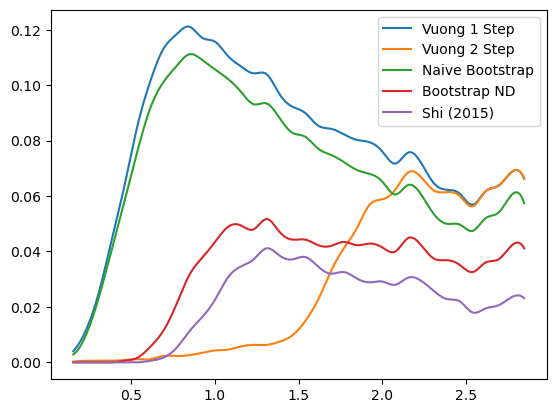

0.1 0.00018027352699434093


In [9]:
nobs =100
data_tuned_c = .9
calc_c =lambda nobs: (nobs**(-1/2), nobs**(-3/5)/350)
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.78, 5th: 1.84, 10th: 3.14, 30th: 9.23, 50th: 16.36, 70th: 24.84, 90th: 38.84, 95th: 46.63, 99th: 59.36
bonus term 1.087252459235413 // variance stats 24.017688092556156 //part1 27.200542903016185 //part2 25.017688092556156 24.017688092556156
-0.6632630790763903 0.023800462190821638 3.022211999546699
-2.837767997547216 0.023800462190821638 0.8477070810758732
---
Quantiles: 1th: 0.77, 5th: 2.21, 10th: 3.86, 30th: 11.08, 50th: 18.98, 70th: 29.26, 90th: 45.99, 95th: 55.06, 99th: 73.70
bonus term 1.8832364810471656 // variance stats 19.243069872411688 //part1 38.122487672112484 //part2 20.243069872411688 19.243069872411688
0.025637744004068635 -0.3568220337902983 3.630826513703313
-3.740835218090263 -0.3568220337902983 -0.13564644839101825
---
Quantiles: 1th: 0.61, 5th: 1.69, 10th: 2.84, 30th: 8.27, 50th: 14.21, 70th: 21.72, 90th: 34.27, 95th: 40.42, 99th: 52.98
bonus term 2.041994622501116 // variance stats 9.366899685160202 //part1 21.169153409105647 //part2 10.366899685

Quantiles: 1th: 0.74, 5th: 2.02, 10th: 3.44, 30th: 10.00, 50th: 17.49, 70th: 26.76, 90th: 41.74, 95th: 49.98, 99th: 64.45
bonus term 1.2935974458493391 // variance stats 23.278273509044492 //part1 31.406312600931624 //part2 24.278273509044492 23.278273509044492
-0.5740828784186552 -0.11613694640919466 3.275492755768871
-3.1612777701173336 -0.11613694640919466 0.6882978640701928
---
Quantiles: 1th: 0.74, 5th: 2.04, 10th: 3.44, 30th: 9.34, 50th: 16.15, 70th: 24.79, 90th: 39.81, 95th: 46.80, 99th: 59.70
bonus term 1.5476882769983322 // variance stats 17.455605705683762 //part1 28.563524595590295 //part2 18.455605705683762 17.455605705683762
-0.2924301055553331 -0.2713888785223331 3.4100716035829013
-3.3878066595519973 -0.2713888785223331 0.31469504958623684
---
Quantiles: 1th: 0.64, 5th: 1.68, 10th: 3.14, 30th: 10.00, 50th: 17.36, 70th: 26.66, 90th: 41.39, 95th: 49.50, 99th: 65.72
bonus term 6.36918771692733 // variance stats 3.8494719356424243 //part1 30.887197086077535 //part2 4.8494719

Quantiles: 1th: 0.59, 5th: 1.51, 10th: 2.79, 30th: 8.77, 50th: 15.14, 70th: 23.58, 90th: 36.98, 95th: 44.47, 99th: 58.29
bonus term 5.506958087064045 // variance stats 3.4778369384528314 //part1 24.659260340766924 //part2 4.477836938452832 3.4778369384528314
3.880651861451103 -2.8410773186792158 6.909605017306631
-7.133264312676987 -2.8410773186792158 -4.104311156821459
---
Quantiles: 1th: 0.65, 5th: 1.71, 10th: 3.07, 30th: 9.27, 50th: 16.27, 70th: 24.95, 90th: 38.90, 95th: 46.80, 99th: 62.54
bonus term 1.6997330353344287 // variance stats 15.04863210567246 //part1 27.278390161940212 //part2 16.04863210567246 15.04863210567246
-0.21036839297261797 -0.6138242808753279 3.517186943901034
-3.6098344636414756 -0.6138242808753279 0.1177208732321768
---
Quantiles: 1th: 0.72, 5th: 1.74, 10th: 2.89, 30th: 8.72, 50th: 15.30, 70th: 23.41, 90th: 36.91, 95th: 44.44, 99th: 57.54
bonus term 0.48689999799856404 // variance stats 49.448251389246145 //part1 24.563253500455 //part2 50.448251389246145 49.

Quantiles: 1th: 0.65, 5th: 1.62, 10th: 2.69, 30th: 7.58, 50th: 13.14, 70th: 20.37, 90th: 31.98, 95th: 38.08, 99th: 49.11
bonus term 0.3663658165344284 // variance stats 49.332531378625404 //part1 18.440118956774835 //part2 50.332531378625404 49.332531378625404
-1.627748927630386 1.0419337749824051 2.3071209466451443
-2.360480560699243 1.0419337749824051 1.5743893135762874
---
Quantiles: 1th: 0.66, 5th: 1.76, 10th: 3.09, 30th: 9.40, 50th: 16.71, 70th: 25.69, 90th: 40.62, 95th: 48.80, 99th: 64.20
bonus term 1.0788588947140885 // variance stats 26.57536467066659 //part1 29.749927449933285 //part2 27.57536467066659 26.57536467066659
-0.8721384880958564 0.07138578066502153 2.9668530009810565
-3.029856277524033 0.07138578066502153 0.8091352115528798
---
Quantiles: 1th: 0.71, 5th: 1.92, 10th: 3.27, 30th: 9.86, 50th: 17.12, 70th: 26.59, 90th: 43.19, 95th: 50.67, 99th: 65.98
bonus term 1.053314561151729 // variance stats 30.92623737544747 //part1 33.62837071034538 //part2 31.92623737544747 30.9

Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.41, 30th: 10.23, 50th: 17.50, 70th: 26.97, 90th: 42.84, 95th: 50.70, 99th: 66.49
bonus term 2.3901634447777726 // variance stats 12.839826182732214 //part1 33.07944662404484 //part2 13.839826182732216 12.839826182732214
0.4473597235847303 -0.8413078180624821 4.191500247762102
-4.332967165970816 -0.8413078180624821 -0.5888266417934437
---
Quantiles: 1th: 0.85, 5th: 2.04, 10th: 3.61, 30th: 10.79, 50th: 18.90, 70th: 29.12, 90th: 45.59, 95th: 54.10, 99th: 70.66
bonus term 1.1396547026169643 // variance stats 31.881565872373876 //part1 37.47363117586037 //part2 32.881565872373876 31.881565872373876
-0.8637799656628532 -0.036159308622584305 3.1712489788137543
-3.143089370896782 -0.036159308622584305 0.8919395735798258
---
Quantiles: 1th: 0.73, 5th: 1.95, 10th: 3.38, 30th: 9.65, 50th: 16.24, 70th: 25.55, 90th: 39.63, 95th: 47.58, 99th: 64.03
bonus term 0.4563898750130045 // variance stats 61.03674180139304 //part1 28.3129408369518 //part2 62.0367418013

Quantiles: 1th: 0.52, 5th: 1.40, 10th: 2.43, 30th: 7.00, 50th: 12.33, 70th: 19.20, 90th: 30.22, 95th: 36.49, 99th: 48.30
bonus term 0.9915648822188531 // variance stats 15.602997343210275 //part1 16.46294910510023 //part2 16.602997343210276 15.602997343210275
-0.7063112385831238 -0.1899267366394916 2.9313138596593213
-2.68944100302083 -0.1899267366394916 0.9481840952216153
---
Quantiles: 1th: 0.82, 5th: 1.98, 10th: 3.31, 30th: 9.51, 50th: 16.50, 70th: 25.37, 90th: 39.87, 95th: 48.21, 99th: 62.87
bonus term 0.5877275726052666 // variance stats 47.75144304484549 //part1 28.652567281750947 //part2 48.75144304484549 47.75144304484549
-1.2050322147870633 0.6120244838188703 2.5559051023861623
-2.380487359997596 0.6120244838188703 1.3804499571756292
---
Quantiles: 1th: 0.69, 5th: 2.07, 10th: 3.58, 30th: 10.42, 50th: 18.12, 70th: 27.68, 90th: 45.16, 95th: 52.68, 99th: 70.77
bonus term 1.0048136822594935 // variance stats 35.589347899065864 //part1 36.765477393934034 //part2 36.589347899065864 

Quantiles: 1th: 0.60, 5th: 1.58, 10th: 2.60, 30th: 8.12, 50th: 14.39, 70th: 22.39, 90th: 36.09, 95th: 42.47, 99th: 55.96
bonus term 2.4558775382955167 // variance stats 8.560444080584599 //part1 23.47927987363805 //part2 9.560444080584599 8.560444080584599
0.6634729543048231 -1.6224869955569745 4.248419911625734
-4.248282122286211 -1.6224869955569745 -0.663335164965299
---
Quantiles: 1th: 0.81, 5th: 2.08, 10th: 3.98, 30th: 12.24, 50th: 20.92, 70th: 31.70, 90th: 50.32, 95th: 60.91, 99th: 80.90
bonus term 8.999444827031295 // variance stats 4.072909071914229 //part1 45.65336530523863 //part2 5.0729090719142285 4.072909071914229
7.200964961769129 -3.8279968065638412 10.459830079661142
-10.797924692293462 -3.8279968065638412 -7.539059574401449
---
Quantiles: 1th: 0.79, 5th: 1.80, 10th: 3.01, 30th: 8.99, 50th: 15.94, 70th: 24.44, 90th: 39.44, 95th: 46.60, 99th: 60.57
bonus term 4.1870642943790655 // variance stats 5.695782863932878 //part1 28.035673352488548 //part2 6.695782863932878 5.6957

Quantiles: 1th: 0.72, 5th: 1.94, 10th: 3.49, 30th: 10.97, 50th: 19.17, 70th: 28.44, 90th: 46.28, 95th: 54.87, 99th: 72.72
bonus term 0.9252058267867327 // variance stats 40.73959807169081 //part1 38.6177193436646 //part2 41.7395980716908 40.73959807169081
-0.9514444545017746 0.3183904687399683 2.980424411149451
-2.80185610807524 0.3183904687399683 1.130012757575986
---
Quantiles: 1th: 0.99, 5th: 2.56, 10th: 4.38, 30th: 12.39, 50th: 21.59, 70th: 32.22, 90th: 51.26, 95th: 61.11, 99th: 79.15
bonus term 1.4640500062411441 // variance stats 31.352952110348788 //part1 47.36633973907558 //part2 32.35295211034879 31.352952110348788
-0.37196497389434696 -0.12307958557979785 3.221384789568925
-3.3000649863766354 -0.12307958557979785 0.29328477708663675
---
Quantiles: 1th: 0.56, 5th: 1.51, 10th: 2.88, 30th: 8.51, 50th: 14.59, 70th: 22.23, 90th: 34.88, 95th: 41.98, 99th: 55.19
bonus term 1.3687870758727811 // variance stats 15.02394474220321 //part1 21.933368467627357 //part2 16.023944742203213 15

Quantiles: 1th: 0.72, 5th: 1.98, 10th: 3.43, 30th: 9.74, 50th: 16.45, 70th: 25.56, 90th: 40.28, 95th: 47.78, 99th: 65.18
bonus term 1.1686142472386691 // variance stats 24.031713695647554 //part1 29.252417257533047 //part2 25.031713695647554 24.031713695647554
-0.7225771283199393 -0.5841949764576404 3.059517631255702
-3.0598056227972776 -0.5841949764576404 0.7222891367783636
---
Quantiles: 1th: 0.61, 5th: 1.63, 10th: 2.81, 30th: 8.00, 50th: 13.61, 70th: 21.20, 90th: 33.41, 95th: 40.08, 99th: 52.65
bonus term 1.9362578641745052 // variance stats 9.39271393812806 //part1 20.12297409281645 //part2 10.39271393812806 9.39271393812806
0.023395740505378494 -1.1523577738874582 3.6302608285432907
-3.849119987843632 -1.1523577738874582 -0.24225489980571988
---
Quantiles: 1th: 0.62, 5th: 1.50, 10th: 2.54, 30th: 7.45, 50th: 13.20, 70th: 20.33, 90th: 32.69, 95th: 38.92, 99th: 51.35
bonus term 1.1666791623878838 // variance stats 15.508004036603511 //part1 19.25954432212039 //part2 16.50800403660351

Quantiles: 1th: 0.66, 5th: 1.94, 10th: 3.33, 30th: 9.97, 50th: 18.08, 70th: 27.74, 90th: 43.73, 95th: 52.01, 99th: 70.82
bonus term 0.8887656761021463 // variance stats 37.789238471115496 //part1 34.47454375526835 //part2 38.789238471115496 37.789238471115496
-1.1208599133441812 -0.2101207276429656 2.853625026281201
-2.898391265548474 -0.2101207276429656 1.076093674076908
---
Quantiles: 1th: 0.78, 5th: 2.19, 10th: 3.85, 30th: 11.10, 50th: 19.99, 70th: 30.65, 90th: 48.05, 95th: 57.78, 99th: 75.64
bonus term 5.308610917634884 // variance stats 6.839608028727843 //part1 41.617428771282725 //part2 7.839608028727843 6.839608028727843
3.2400852567213763 -4.063198679819225 7.0398117198690695
-7.377136578548392 -4.063198679819225 -3.577410115400699
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.39, 30th: 9.94, 50th: 17.31, 70th: 26.57, 90th: 42.28, 95th: 50.45, 99th: 67.08
bonus term 0.9493393786545286 // variance stats 32.94322358587613 //part1 32.22363878854739 //part2 33.94322358587614 32.943

Quantiles: 1th: 0.67, 5th: 1.65, 10th: 2.80, 30th: 8.07, 50th: 14.06, 70th: 21.50, 90th: 33.63, 95th: 40.31, 99th: 53.12
bonus term 1.461064085885238 // variance stats 12.952335343769173 //part1 20.3852560850084 //part2 13.952335343769173 12.952335343769173
-0.39804062534186047 -2.0287610231551594 3.228764322102524
-3.3201687971123364 -2.0287610231551594 0.30663615033204816
---
Quantiles: 1th: 0.78, 5th: 2.26, 10th: 3.87, 30th: 10.61, 50th: 18.21, 70th: 27.66, 90th: 42.76, 95th: 51.00, 99th: 67.24
bonus term 0.8648021825023043 // variance stats 37.111037541066224 //part1 32.95850844294132 //part2 38.111037541066224 37.111037541066224
-1.0582900778068294 0.1447662302343281 2.8527070645857333
-2.7878944428114383 0.1447662302343281 1.1231026995811244
---
Quantiles: 1th: 0.80, 5th: 2.08, 10th: 3.49, 30th: 9.80, 50th: 17.71, 70th: 27.04, 90th: 43.66, 95th: 52.15, 99th: 67.67
bonus term 0.9789840957788749 // variance stats 34.10531822030234 //part1 34.36754821493235 //part2 35.10531822030234

Quantiles: 1th: 0.66, 5th: 1.75, 10th: 2.95, 30th: 8.62, 50th: 15.18, 70th: 23.14, 90th: 36.38, 95th: 43.09, 99th: 55.46
bonus term 1.1369627300289193 // variance stats 19.97960316425388 //part1 23.85302688855345 //part2 20.97960316425388 19.97960316425388
-0.748232560633342 -0.8086928746780022 3.0462250106670665
-3.022158020691181 -0.8086928746780022 0.7722995506092277
---
Quantiles: 1th: 0.74, 5th: 2.17, 10th: 4.02, 30th: 12.11, 50th: 21.83, 70th: 33.03, 90th: 52.01, 95th: 61.84, 99th: 82.07
bonus term 1.26206129155799 // variance stats 37.63236155670637 //part1 48.75640812219209 //part2 38.63236155670637 37.63236155670637
-0.5754160271788336 -0.22721231063848704 3.183559884183504
-3.0995386102948133 -0.22721231063848704 0.6594373010675236
---
Quantiles: 1th: 0.71, 5th: 1.73, 10th: 3.02, 30th: 8.59, 50th: 15.22, 70th: 22.92, 90th: 36.25, 95th: 43.81, 99th: 57.90
bonus term 0.5748000998843985 // variance stats 40.21449014776711 //part1 23.69009305362109 //part2 41.21449014776711 40.21

Quantiles: 1th: 0.68, 5th: 1.67, 10th: 3.19, 30th: 9.79, 50th: 16.90, 70th: 26.41, 90th: 42.26, 95th: 50.36, 99th: 65.94
bonus term 1.6491448914230842 // variance stats 18.52323281662097 //part1 32.19663966359398 //part2 19.52323281662097 18.52323281662097
-0.3055208483417813 -1.648375109984322 3.4339057303049305
-3.6038106311879496 -1.648375109984322 0.1356159474587619
---
Quantiles: 1th: 0.65, 5th: 1.91, 10th: 3.34, 30th: 10.05, 50th: 17.96, 70th: 28.09, 90th: 43.99, 95th: 51.93, 99th: 68.90
bonus term 1.6910185783415927 // variance stats 19.628316492983373 //part1 34.88286642954518 //part2 20.628316492983373 19.628316492983373
-0.3047150834963731 -1.5493837332228328 3.6238110613908416
-3.6867522401795583 -1.5493837332228328 0.24177390470765622
---
Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.38, 30th: 10.13, 50th: 17.68, 70th: 27.67, 90th: 43.81, 95th: 51.85, 99th: 67.09
bonus term 1.3136740933556748 // variance stats 25.343082265033647 //part1 34.60622471071203 //part2 26.3430822650336

Quantiles: 1th: 0.70, 5th: 1.97, 10th: 3.40, 30th: 9.97, 50th: 17.37, 70th: 26.64, 90th: 42.31, 95th: 50.15, 99th: 65.19
bonus term 1.4067001046290535 // variance stats 21.936773260668243 //part1 32.265161345634894 //part2 22.936773260668243 21.936773260668243
-0.5851131632180457 -0.907101324809409 3.3918097964245364
-3.398513372476153 -0.907101324809409 0.5784095871664297
---
Quantiles: 1th: 0.61, 5th: 1.48, 10th: 2.43, 30th: 7.22, 50th: 12.97, 70th: 20.22, 90th: 32.50, 95th: 38.51, 99th: 48.87
bonus term 0.8906303096964644 // variance stats 20.376761988865763 //part1 19.038792150451126 //part2 21.376761988865766 20.376761988865763
-1.1864129975569309 -1.107085774919196 2.6945530358096534
-2.967673616949859 -1.107085774919196 0.9132924164167245
---
Quantiles: 1th: 0.76, 5th: 2.28, 10th: 3.87, 30th: 11.40, 50th: 20.00, 70th: 30.99, 90th: 48.86, 95th: 59.13, 99th: 75.31
bonus term 4.346998947929898 // variance stats 8.900000559180922 //part1 43.03529201526487 //part2 9.90000055918092 8.

Quantiles: 1th: 0.60, 5th: 1.52, 10th: 2.67, 30th: 7.60, 50th: 13.32, 70th: 20.93, 90th: 32.47, 95th: 38.92, 99th: 51.45
bonus term 1.9693648004580069 // variance stats 8.651338431685232 //part1 19.00700618466848 //part2 9.651338431685232 8.651338431685232
-0.1394822439283017 -4.8763259438462345 3.601793781628503
-4.078211844844316 -4.8763259438462345 -0.33693581928751054
---
Quantiles: 1th: 0.63, 5th: 1.84, 10th: 2.95, 30th: 8.60, 50th: 14.85, 70th: 22.54, 90th: 35.34, 95th: 42.36, 99th: 55.70
bonus term 2.6368925282104 // variance stats 7.538324874175423 //part1 22.514645064146173 //part2 8.538324874175423 7.538324874175423
0.772334654473599 -4.027045170962521 4.31338932555916
-4.5014504019472 -4.027045170962521 -0.9603957308616403
---
Quantiles: 1th: 0.60, 5th: 1.64, 10th: 2.78, 30th: 8.29, 50th: 14.56, 70th: 21.87, 90th: 34.27, 95th: 40.31, 99th: 52.24
bonus term 0.5370053227708153 // variance stats 38.43460206335714 //part1 21.17659120937176 //part2 39.43460206335714 38.4346020633

Quantiles: 1th: 0.86, 5th: 2.05, 10th: 3.35, 30th: 8.98, 50th: 15.56, 70th: 23.62, 90th: 37.76, 95th: 44.72, 99th: 59.86
bonus term 1.5206831423895881 // variance stats 15.900673343813187 //part1 25.70056904896979 //part2 16.90067334381319 15.900673343813187
-0.39818490308928906 -2.651609669984107 3.3383175582665983
-3.4395511878684655 -2.651609669984107 0.2969512734874221
---
Quantiles: 1th: 0.65, 5th: 1.61, 10th: 2.60, 30th: 7.17, 50th: 13.08, 70th: 19.98, 90th: 31.08, 95th: 37.15, 99th: 49.86
bonus term 1.6748774934486124 // variance stats 9.394188522706731 //part1 17.408992419343384 //part2 10.394188522706731 9.394188522706731
-0.5739145684783875 -3.358854250501152 3.541864167634148
-3.9236695553756125 -3.358854250501152 0.19210918073692315
---
Quantiles: 1th: 0.62, 5th: 1.62, 10th: 2.92, 30th: 8.89, 50th: 15.47, 70th: 24.05, 90th: 38.10, 95th: 45.25, 99th: 59.37
bonus term 0.7905966937747139 // variance stats 32.10372527311819 //part1 26.171695752553674 //part2 33.10372527311819 3

Quantiles: 1th: 0.58, 5th: 1.58, 10th: 2.74, 30th: 7.90, 50th: 13.55, 70th: 21.12, 90th: 33.10, 95th: 40.09, 99th: 51.24
bonus term 0.3346196275922512 // variance stats 58.019709207173236 //part1 19.74915311550727 //part2 59.019709207173236 58.019709207173236
-1.718042552732103 0.3678765744459459 2.297104295471529
-2.3872818079166054 0.3678765744459459 1.6278650402870267
---
Quantiles: 1th: 0.66, 5th: 1.65, 10th: 2.74, 30th: 7.26, 50th: 12.62, 70th: 19.80, 90th: 32.01, 95th: 38.38, 99th: 49.11
bonus term 1.9894683885045643 // variance stats 8.281904234768453 //part1 18.46605506019848 //part2 9.281904234768453 8.281904234768453
0.11249472813811953 -4.240029580705496 3.715725791118585
-3.8664420488710087 -4.240029580705496 -0.2632109858905439
---
Quantiles: 1th: 0.63, 5th: 1.74, 10th: 3.27, 30th: 9.82, 50th: 16.79, 70th: 25.71, 90th: 39.97, 95th: 47.93, 99th: 63.03
bonus term 0.5990063137379334 // variance stats 47.08494810025339 //part1 28.803187507812627 //part2 48.084948100253385 47.0

Quantiles: 1th: 0.65, 5th: 1.91, 10th: 3.42, 30th: 9.90, 50th: 16.99, 70th: 26.04, 90th: 42.57, 95th: 50.56, 99th: 64.19
bonus term 2.0536537608527796 // variance stats 14.910156013237362 //part1 32.673951732339376 //part2 15.910156013237362 14.910156013237362
-0.08008623490592195 -4.624809738616491 3.8983558816491644
-4.187393756611481 -4.624809738616491 -0.2089516400563948
---
Quantiles: 1th: 0.75, 5th: 1.79, 10th: 3.07, 30th: 8.79, 50th: 15.24, 70th: 23.79, 90th: 37.66, 95th: 45.46, 99th: 58.81
bonus term 1.4842437045788002 // variance stats 16.224997423509343 //part1 25.56609398722979 //part2 17.224997423509343 16.224997423509343
-0.8096809465646767 -4.463744263839918 3.284898870992981
-3.778168355722277 -4.463744263839918 0.3164114618353803
---
Quantiles: 1th: 0.84, 5th: 2.10, 10th: 3.72, 30th: 10.42, 50th: 18.30, 70th: 28.59, 90th: 44.68, 95th: 53.39, 99th: 69.38
bonus term 2.2733388179229714 // variance stats 14.826951341631997 //part1 35.98002285431007 //part2 15.82695134163199

Quantiles: 1th: 0.81, 5th: 2.16, 10th: 3.46, 30th: 9.61, 50th: 16.35, 70th: 25.19, 90th: 39.16, 95th: 46.58, 99th: 61.47
bonus term 0.855925290802932 // variance stats 31.296879863764953 //part1 27.64371628942038 //part2 32.29687986376496 31.296879863764953
-1.1532350601630175 -1.4105948721589718 2.7487568546001726
-2.8650856417688817 -1.4105948721589718 1.0369062729943088
---
Quantiles: 1th: 0.69, 5th: 1.97, 10th: 3.53, 30th: 10.57, 50th: 18.78, 70th: 29.44, 90th: 47.57, 95th: 55.88, 99th: 75.12
bonus term 1.6806037865022856 // variance stats 23.27338036923677 //part1 40.793934959749556 //part2 24.27338036923677 23.27338036923677
-0.06063482391969477 -2.639146588604441 3.5040868223360895
-3.4218423969242657 -2.639146588604441 0.14287924933151805
---
Quantiles: 1th: 1.07, 5th: 2.63, 10th: 4.96, 30th: 14.29, 50th: 24.84, 70th: 38.13, 90th: 61.63, 95th: 73.03, 99th: 95.69
bonus term 2.872876600824529 // variance stats 22.83365772984017 //part1 68.47115760411849 //part2 23.833657729840173

Quantiles: 1th: 0.81, 5th: 2.13, 10th: 3.53, 30th: 10.53, 50th: 18.95, 70th: 29.60, 90th: 46.16, 95th: 54.46, 99th: 73.21
bonus term 1.2643734865831762 // variance stats 29.385681999794787 //part1 38.418850692288196 //part2 30.38568199979479 29.385681999794787
-0.8372115264193865 -1.9264954283701559 3.1506760938047047
-3.3659584995857386 -1.9264954283701559 0.6219291206383525
---
Quantiles: 1th: 0.77, 5th: 1.98, 10th: 3.25, 30th: 9.03, 50th: 15.72, 70th: 24.21, 90th: 38.33, 95th: 45.56, 99th: 59.66
bonus term 1.6652335417918775 // variance stats 14.90854955801321 //part1 26.491450325261944 //part2 15.90854955801321 14.90854955801321
-0.3952235690779558 -3.7249329652032546 3.575624487387006
-3.7256906526617106 -3.7249329652032546 0.24515740380325102
---
Quantiles: 1th: 0.68, 5th: 1.73, 10th: 3.05, 30th: 8.76, 50th: 15.89, 70th: 24.12, 90th: 37.71, 95th: 44.95, 99th: 58.78
bonus term 1.0542278695545941 // variance stats 23.316380533371536 //part1 25.63500604497508 //part2 24.316380533371

Quantiles: 1th: 0.87, 5th: 2.06, 10th: 3.42, 30th: 10.11, 50th: 17.17, 70th: 26.38, 90th: 42.51, 95th: 50.46, 99th: 66.86
bonus term 1.8062839054327804 // variance stats 17.038429453570934 //part1 32.582524801269805 //part2 18.038429453570934 17.038429453570934
-0.4879725220540419 -4.224200720655665 3.639916740444687
-4.1005403329196035 -4.224200720655665 0.02734892957912596
---
Quantiles: 1th: 0.79, 5th: 2.01, 10th: 3.60, 30th: 10.30, 50th: 17.93, 70th: 27.86, 90th: 44.17, 95th: 52.08, 99th: 67.79
bonus term 0.936000342281496 // variance stats 36.57787204096119 //part1 35.17290109254993 //part2 37.57787204096119 36.57787204096119
-1.0080123664831648 -1.163301843211274 2.917595066216029
-2.8800130510461566 -1.163301843211274 1.045594381653037
---
Quantiles: 1th: 0.65, 5th: 1.74, 10th: 2.90, 30th: 8.54, 50th: 14.67, 70th: 22.61, 90th: 35.67, 95th: 41.97, 99th: 55.62
bonus term 0.7368419677511799 // variance stats 30.127905782630066 //part1 22.93634734884647 //part2 31.127905782630066 30

Quantiles: 1th: 0.81, 5th: 2.03, 10th: 3.53, 30th: 10.11, 50th: 17.41, 70th: 26.85, 90th: 42.20, 95th: 49.71, 99th: 63.63
bonus term 0.8902401129380058 // variance stats 35.06224884269483 //part1 32.10406048251911 //part2 36.06224884269483 35.06224884269483
-1.28233107448618 -1.8632201491426466 2.7620984234896016
-3.062811300362192 -1.8632201491426466 0.9816181976135903
---
Quantiles: 1th: 0.79, 5th: 2.06, 10th: 3.78, 30th: 11.38, 50th: 19.76, 70th: 29.93, 90th: 47.92, 95th: 57.08, 99th: 74.79
bonus term 3.3104509853594135 // variance stats 11.505419037170782 //part1 41.39857677393438 //part2 12.505419037170782 11.505419037170782
1.302465280404776 -7.5502875636218985 5.0171230737851324
-5.3184366903140505 -7.5502875636218985 -1.6037788969336948
---
Quantiles: 1th: 0.78, 5th: 2.08, 10th: 3.55, 30th: 10.93, 50th: 19.86, 70th: 31.02, 90th: 48.89, 95th: 58.76, 99th: 75.66
bonus term 2.876218926225016 // variance stats 13.983084868521857 //part1 43.09463227207822 //part2 14.983084868521859 

Quantiles: 1th: 0.80, 5th: 2.08, 10th: 3.46, 30th: 10.20, 50th: 18.31, 70th: 28.21, 90th: 45.15, 95th: 53.49, 99th: 69.81
bonus term 1.2412701289350583 // variance stats 28.602621965813523 //part1 36.74485038432114 //part2 29.602621965813523 28.602621965813523
-0.7316549314446126 -3.0508002264847285 3.2504428266726713
-3.214195189314729 -3.0508002264847285 0.7679025688025546
---
Quantiles: 1th: 0.68, 5th: 1.95, 10th: 3.65, 30th: 10.80, 50th: 19.04, 70th: 28.22, 90th: 44.99, 95th: 53.23, 99th: 72.22
bonus term 2.003555394750609 // variance stats 17.21003183446428 //part1 36.48480752052124 //part2 18.21003183446428 17.21003183446428
-0.08836454288117793 -7.475535965828355 3.863038417580731
-4.095475332382397 -7.475535965828355 -0.14407237192048708
---
Quantiles: 1th: 0.82, 5th: 2.12, 10th: 3.59, 30th: 10.23, 50th: 17.97, 70th: 27.68, 90th: 43.99, 95th: 51.74, 99th: 68.05
bonus term 1.1799240071624968 // variance stats 28.561979295747193 //part1 34.880889070292795 //part2 29.5619792957471

Quantiles: 1th: 0.58, 5th: 1.53, 10th: 2.53, 30th: 7.21, 50th: 12.61, 70th: 19.56, 90th: 30.81, 95th: 37.65, 99th: 48.83
bonus term 0.5962361261524379 // variance stats 27.7007845172851 //part1 17.112444578121938 //part2 28.7007845172851 27.7007845172851
-1.3862355716953023 -3.5387906364567128 2.4874013494413854
-2.5787078240001784 -3.5387906364567128 1.2949290971365097
---
Quantiles: 1th: 0.91, 5th: 2.10, 10th: 3.76, 30th: 10.71, 50th: 18.66, 70th: 28.68, 90th: 44.32, 95th: 52.78, 99th: 69.65
bonus term 1.5747655650355388 // variance stats 21.489204082789204 //part1 35.41522417463309 //part2 22.489204082789204 21.489204082789204
-0.4960323962571728 -3.7844621180711004 3.4219995068208213
-3.6455635263282504 -3.7844621180711004 0.27246837674974367
---
Quantiles: 1th: 0.64, 5th: 1.91, 10th: 3.23, 30th: 9.16, 50th: 16.29, 70th: 25.10, 90th: 39.63, 95th: 47.78, 99th: 62.86
bonus term 1.8017308493015292 // variance stats 14.717987615091825 //part1 28.31958317505031 //part2 15.71798761509182

Quantiles: 1th: 0.74, 5th: 1.85, 10th: 3.39, 30th: 10.27, 50th: 18.23, 70th: 28.18, 90th: 43.72, 95th: 52.52, 99th: 71.31
bonus term 0.9564741338127443 // variance stats 35.027916614987724 //part1 34.45977033739817 //part2 36.027916614987724 35.027916614987724
-0.9384922636896741 -3.366796162987974 2.8895488162801133
-2.8514405313151623 -3.366796162987974 0.9766005486546246
---
Quantiles: 1th: 0.59, 5th: 1.58, 10th: 2.64, 30th: 7.54, 50th: 13.01, 70th: 19.93, 90th: 32.01, 95th: 38.10, 99th: 48.88
bonus term 1.0948368527724095 // variance stats 15.869336180743046 //part1 18.469170932484456 //part2 16.869336180743048 15.869336180743046
-1.02268018862546 -6.3397363551334385 2.8411892656030786
-3.212353894170279 -6.3397363551334385 0.6515155600582597
---
Quantiles: 1th: 0.75, 5th: 1.97, 10th: 3.35, 30th: 9.02, 50th: 15.75, 70th: 24.19, 90th: 38.44, 95th: 45.25, 99th: 58.41
bonus term 0.6477805523226432 // variance stats 40.11973788916248 //part1 26.636566521203992 //part2 41.11973788916248

Quantiles: 1th: 0.57, 5th: 1.54, 10th: 2.46, 30th: 7.33, 50th: 13.15, 70th: 20.17, 90th: 31.97, 95th: 38.24, 99th: 50.69
bonus term 0.86513446820535 // variance stats 20.303208886491465 //part1 18.43014029108228 //part2 21.303208886491465 20.303208886491465
-1.315353461340803 -4.857451272479003 2.835868681325675
-3.0456223977515027 -4.857451272479003 1.105599744914975
---
Quantiles: 1th: 0.84, 5th: 2.01, 10th: 3.26, 30th: 8.51, 50th: 13.90, 70th: 21.37, 90th: 34.01, 95th: 40.75, 99th: 52.21
bonus term 0.3147729647933159 // variance stats 65.25463855782947 //part1 20.855169010157525 //part2 66.25463855782945 65.25463855782947
-1.7316988503669533 -0.28790814656109315 2.1973363865398476
-2.3612447799535854 -0.28790814656109315 1.5677904569532155
---
Quantiles: 1th: 0.69, 5th: 2.20, 10th: 3.91, 30th: 11.53, 50th: 20.49, 70th: 31.97, 90th: 50.09, 95th: 59.25, 99th: 78.15
bonus term 1.0183428614589591 // variance stats 43.41750232700073 //part1 45.232246418537905 //part2 44.41750232700073 43

Quantiles: 1th: 0.65, 5th: 1.90, 10th: 3.27, 30th: 9.76, 50th: 17.03, 70th: 26.10, 90th: 41.54, 95th: 50.29, 99th: 64.71
bonus term 1.1930174623822014 // variance stats 25.079418519517244 //part1 31.113201702557852 //part2 26.079418519517247 25.079418519517244
-0.7408759080178744 -3.9268827695448696 3.1124175201333606
-3.126910832782277 -3.9268827695448696 0.726382595368958
---
Quantiles: 1th: 0.63, 5th: 1.62, 10th: 2.75, 30th: 7.99, 50th: 14.23, 70th: 21.63, 90th: 34.13, 95th: 40.85, 99th: 53.45
bonus term 0.7934330328069803 // variance stats 25.461588499218433 //part1 20.995498415825196 //part2 26.461588499218433 25.461588499218433
-1.3158980722197047 -4.815067393114046 2.697386072067797
-2.9027641378336653 -4.815067393114046 1.1105200064538363
---
Quantiles: 1th: 0.66, 5th: 1.62, 10th: 2.88, 30th: 8.57, 50th: 15.16, 70th: 23.66, 90th: 37.54, 95th: 44.06, 99th: 57.40
bonus term 1.7776119871245124 // variance stats 13.288487972452486 //part1 25.399387497715963 //part2 14.2884879724524

Quantiles: 1th: 0.67, 5th: 1.52, 10th: 2.53, 30th: 7.52, 50th: 13.31, 70th: 20.46, 90th: 32.62, 95th: 38.87, 99th: 51.69
bonus term 0.604593586664829 // variance stats 30.72885422425914 //part1 19.183061776210348 //part2 31.72885422425914 30.72885422425914
-1.4591238094101162 -5.08840834385555 2.508072338902126
-2.6683109827397744 -5.08840834385555 1.2988851655724678
---
Quantiles: 1th: 0.60, 5th: 1.66, 10th: 2.79, 30th: 8.09, 50th: 14.61, 70th: 22.92, 90th: 36.04, 95th: 42.50, 99th: 55.15
bonus term 0.5963102322383829 // variance stats 38.270515957884655 //part1 23.417410490967317 //part2 39.270515957884655 38.270515957884655
-1.8017380118122768 -3.9674717255657765 2.567331424143486
-2.994358476289042 -3.9674717255657765 1.3747109596667202
---
Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.29, 30th: 8.95, 50th: 15.84, 70th: 24.18, 90th: 37.97, 95th: 45.21, 99th: 58.87
bonus term 1.7000945306700004 // variance stats 14.28770208106954 //part1 25.990538694538706 //part2 15.28770208106954 14.28

Quantiles: 1th: 0.72, 5th: 1.58, 10th: 2.46, 30th: 7.06, 50th: 12.40, 70th: 19.13, 90th: 30.30, 95th: 35.61, 99th: 46.28
bonus term 0.8412493541427246 // variance stats 18.674930670368003 //part1 16.551522719249967 //part2 19.674930670368006 18.674930670368003
-1.236339073622624 -7.719373721050072 2.551048834215331
-2.918837781908073 -7.719373721050072 0.8685501259298816
---
Quantiles: 1th: 0.86, 5th: 2.04, 10th: 3.78, 30th: 11.97, 50th: 21.01, 70th: 31.91, 90th: 50.23, 95th: 58.85, 99th: 76.97
bonus term 1.4959691147093022 // variance stats 29.40443274137065 //part1 45.48409233134677 //part2 30.40443274137065 29.40443274137065
-0.43680484545910225 -5.035275825698884 3.17427619477328
-3.4287430748777066 -5.035275825698884 0.1823379653546758
---
Quantiles: 1th: 0.82, 5th: 2.15, 10th: 3.60, 30th: 10.83, 50th: 19.05, 70th: 29.22, 90th: 46.72, 95th: 55.90, 99th: 75.67
bonus term 1.0186147688950797 // variance stats 37.63769503877563 //part1 39.35692680256101 //part2 38.63769503877563 37.63

Quantiles: 1th: 0.62, 5th: 1.76, 10th: 2.85, 30th: 7.87, 50th: 13.81, 70th: 21.12, 90th: 33.53, 95th: 39.51, 99th: 53.09
bonus term 0.8668229605681527 // variance stats 22.37779340377307 //part1 20.264408089809205 //part2 23.37779340377307 22.37779340377307
-1.91424584227246 -5.854642138141202 2.8709520365854146
-3.647891763408765 -5.854642138141202 1.1373061154491095
---
Quantiles: 1th: 0.62, 5th: 1.81, 10th: 3.05, 30th: 9.34, 50th: 16.46, 70th: 24.69, 90th: 38.65, 95th: 45.50, 99th: 59.24
bonus term 1.6292572557719731 // variance stats 15.525610255162622 //part1 26.924470414283437 //part2 16.525610255162626 15.525610255162622
-0.7478640436697043 -7.704241315344473 3.5682256904184753
-4.006378555213651 -7.704241315344473 0.3097111788745288
---
Quantiles: 1th: 0.75, 5th: 2.26, 10th: 4.07, 30th: 11.53, 50th: 20.03, 70th: 30.40, 90th: 48.54, 95th: 57.42, 99th: 76.10
bonus term 1.3596684960181522 // variance stats 30.24434841793689 //part1 42.48195622248338 //part2 31.244348417936894 30.2

Quantiles: 1th: 0.89, 5th: 2.03, 10th: 3.56, 30th: 10.30, 50th: 18.36, 70th: 28.24, 90th: 44.97, 95th: 53.56, 99th: 69.23
bonus term 0.7056638008266788 // variance stats 50.664264262106464 //part1 36.45760108611199 //part2 51.66426426210646 50.664264262106464
-1.6565565677185603 -3.2645869000875614 2.623836217900584
-3.0678841693719177 -3.2645869000875614 1.212508616247226
---
Quantiles: 1th: 0.76, 5th: 2.09, 10th: 3.60, 30th: 10.78, 50th: 19.14, 70th: 29.30, 90th: 46.93, 95th: 57.22, 99th: 74.49
bonus term 0.638523122658365 // variance stats 61.17729741159393 //part1 39.70164210170883 //part2 62.177297411593926 61.17729741159393
-1.4224933840625689 -1.474893422799628 2.5891351115188974
-2.699539629379299 -1.474893422799628 1.3120888662021677
---
Quantiles: 1th: 0.70, 5th: 2.04, 10th: 3.48, 30th: 9.86, 50th: 16.81, 70th: 26.30, 90th: 40.60, 95th: 49.46, 99th: 63.93
bonus term 1.7440519718272143 // variance stats 16.041908107781097 //part1 29.721973439073814 //part2 17.041908107781097 1

Quantiles: 1th: 0.81, 5th: 2.32, 10th: 3.92, 30th: 11.56, 50th: 20.38, 70th: 31.58, 90th: 48.97, 95th: 58.10, 99th: 79.71
bonus term 1.048370797759175 // variance stats 40.233244965870384 //part1 43.22772991906903 //part2 41.233244965870384 40.233244965870384
-0.9537479429295679 -3.585138803107966 2.9818719848038
-3.0504895384479176 -3.585138803107966 0.8851303892854496
---
Quantiles: 1th: 0.76, 5th: 1.89, 10th: 3.18, 30th: 9.14, 50th: 16.22, 70th: 24.93, 90th: 39.31, 95th: 46.71, 99th: 60.85
bonus term 1.0314938590180596 // variance stats 26.006002478296402 //part1 27.85652571298924 //part2 27.006002478296406 26.006002478296402
-1.1798313609967666 -8.128367324387563 3.0361632504436438
-3.242819079032886 -8.128367324387563 0.9731755324075249
---
Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.36, 30th: 9.78, 50th: 17.23, 70th: 26.65, 90th: 42.37, 95th: 51.54, 99th: 67.13
bonus term 1.356462742924514 // variance stats 22.861856077997018 //part1 32.36771874682982 //part2 23.861856077997018 22.8

Quantiles: 1th: 0.75, 5th: 1.87, 10th: 3.06, 30th: 8.57, 50th: 14.88, 70th: 22.58, 90th: 35.68, 95th: 41.98, 99th: 54.80
bonus term 1.1342938959644446 // variance stats 19.227461197551225 //part1 22.943885767240012 //part2 20.227461197551225 19.227461197551225
-1.576529263810292 -8.996202791864754 3.0566799532260633
-3.845117055739181 -8.996202791864754 0.7880921612971745
---
Quantiles: 1th: 0.61, 5th: 1.66, 10th: 2.76, 30th: 7.93, 50th: 13.63, 70th: 20.78, 90th: 32.73, 95th: 39.74, 99th: 51.26
bonus term 0.6834920992130902 // variance stats 27.25045767525114 //part1 19.308964620187957 //part2 28.250457675251145 27.25045767525114
-1.4477935834835154 -7.196075612340187 2.581240313055847
-2.814777781909696 -7.196075612340187 1.2142561146296662
---
Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.54, 30th: 10.79, 50th: 18.80, 70th: 28.81, 90th: 46.97, 95th: 56.39, 99th: 73.75
bonus term 1.5893200837930468 // variance stats 24.02333200145339 //part1 39.77008411333113 //part2 25.02333200145339 24.0

Quantiles: 1th: 0.64, 5th: 1.60, 10th: 2.62, 30th: 7.26, 50th: 12.67, 70th: 19.54, 90th: 30.70, 95th: 36.65, 99th: 47.30
bonus term 0.7384463874365297 // variance stats 22.010989093965087 //part1 16.9923817677799 //part2 23.010989093965087 22.010989093965087
-2.2851038883985764 -9.843208977777694 3.2166367560752227
-3.7619966632716357 -9.843208977777694 1.7397439812021633
---
Quantiles: 1th: 0.53, 5th: 1.64, 10th: 2.80, 30th: 7.79, 50th: 13.40, 70th: 20.58, 90th: 32.70, 95th: 39.18, 99th: 50.15
bonus term 0.8219494537595127 // variance stats 22.454797723717775 //part1 19.27865817704969 //part2 23.45479772371778 22.454797723717775
-1.545190179658318 -9.645490805335674 2.7178201280841088
-3.189089087177343 -9.645490805335674 1.0739212205650832
---
Quantiles: 1th: 0.64, 5th: 1.79, 10th: 3.04, 30th: 8.59, 50th: 14.98, 70th: 22.75, 90th: 35.61, 95th: 42.61, 99th: 55.05
bonus term 0.5057018023939143 // variance stats 44.21466239953841 //part1 22.865136270078924 //part2 45.21466239953841 44.2

Quantiles: 1th: 0.78, 5th: 1.96, 10th: 3.24, 30th: 9.58, 50th: 16.62, 70th: 25.68, 90th: 40.39, 95th: 48.44, 99th: 62.75
bonus term 1.53443291338214 // variance stats 18.166031599087123 //part1 29.40898970456141 //part2 19.166031599087123 18.166031599087123
-1.2359545533298153 -9.182270308945533 3.6935460968495644
-4.304820380094095 -9.182270308945533 0.6246802700852844
---
Quantiles: 1th: 0.80, 5th: 2.07, 10th: 4.03, 30th: 11.94, 50th: 21.50, 70th: 33.17, 90th: 51.56, 95th: 61.58, 99th: 80.95
bonus term 2.41341806785361 // variance stats 18.86094211687344 //part1 47.93275654945709 //part2 19.860942116873442 18.86094211687344
-0.0597019091059232 -9.064449447931157 4.391356059888213
-4.886538044813143 -9.064449447931157 -0.4354800758190069
---
Quantiles: 1th: 0.69, 5th: 1.96, 10th: 3.47, 30th: 10.22, 50th: 17.92, 70th: 27.38, 90th: 43.87, 95th: 52.03, 99th: 69.41
bonus term 0.7382332777046994 // variance stats 46.00751258715015 //part1 34.70251009395677 //part2 47.00751258715015 46.0075

Quantiles: 1th: 0.79, 5th: 1.87, 10th: 3.30, 30th: 9.61, 50th: 16.41, 70th: 25.42, 90th: 41.13, 95th: 48.31, 99th: 64.55
bonus term 0.5501018795316533 // variance stats 54.42564532349586 //part1 30.489751666709857 //part2 55.42564532349586 54.42564532349586
-1.496899217794571 -2.157009069196179 2.4889589560429366
-2.5971029768578777 -2.157009069196179 1.3887551969796295
---
Quantiles: 1th: 0.73, 5th: 1.84, 10th: 3.46, 30th: 9.88, 50th: 16.89, 70th: 26.48, 90th: 41.82, 95th: 50.21, 99th: 65.75
bonus term 1.4796498229348738 // variance stats 20.303475493777363 //part1 31.521683742265093 //part2 21.303475493777363 20.303475493777363
-1.1194150491643051 -10.424000913721814 3.533223147648425
-4.078714695034053 -10.424000913721814 0.5739235017786777
---
Quantiles: 1th: 0.77, 5th: 1.97, 10th: 3.66, 30th: 10.95, 50th: 18.97, 70th: 28.71, 90th: 44.39, 95th: 52.55, 99th: 70.52
bonus term 0.9207327815278986 // variance stats 37.58466648260823 //part1 35.526167294858155 //part2 38.584666482608235 

Quantiles: 1th: 0.84, 5th: 2.09, 10th: 3.65, 30th: 10.77, 50th: 18.58, 70th: 28.62, 90th: 44.70, 95th: 53.16, 99th: 70.27
bonus term 1.3170192501802773 // variance stats 26.347610079595924 //part1 36.017328921252016 //part2 27.347610079595924 26.347610079595924
-1.4607775794065643 -8.616183178587937 3.469872766473667
-4.094816079767119 -8.616183178587937 0.8358342661131117
---
Quantiles: 1th: 0.93, 5th: 2.42, 10th: 4.25, 30th: 11.77, 50th: 20.85, 70th: 31.96, 90th: 50.82, 95th: 60.20, 99th: 82.69
bonus term 1.1743963752786024 // variance stats 38.64392702949695 //part1 46.55768420525063 //part2 39.64392702949695 38.64392702949695
-0.9673271486395175 -6.138890628360579 3.017723579387311
-3.3161198991967225 -6.138890628360579 0.668930828830106
---
Quantiles: 1th: 0.65, 5th: 1.79, 10th: 3.00, 30th: 8.93, 50th: 15.08, 70th: 23.08, 90th: 36.60, 95th: 44.15, 99th: 57.63
bonus term 0.8186179550218134 // variance stats 28.500775533074403 //part1 24.149864538442916 //part2 29.500775533074407 28

Quantiles: 1th: 0.81, 5th: 1.92, 10th: 3.43, 30th: 10.02, 50th: 17.53, 70th: 26.63, 90th: 42.24, 95th: 50.45, 99th: 65.50
bonus term 1.306469848856938 // variance stats 23.618007604027113 //part1 32.16268467359225 //part2 24.618007604027113 23.618007604027113
-1.234173803524543 -10.10751885387859 3.198096220504522
-3.847113501238419 -10.10751885387859 0.5851565227906458
---
Quantiles: 1th: 0.78, 5th: 2.14, 10th: 3.67, 30th: 10.88, 50th: 18.99, 70th: 28.81, 90th: 46.31, 95th: 55.89, 99th: 76.97
bonus term 1.2320823977877828 // variance stats 30.38055336082097 //part1 38.66342742870776 //part2 31.38055336082097 30.38055336082097
-1.4577538813624582 -8.426556821909022 3.418216023825518
-3.9219186769380237 -8.426556821909022 0.9540512282499526
---
Quantiles: 1th: 0.73, 5th: 1.95, 10th: 3.46, 30th: 10.03, 50th: 17.19, 70th: 26.76, 90th: 42.70, 95th: 50.75, 99th: 65.41
bonus term 0.521342265409647 // variance stats 62.05015575485335 //part1 32.87071103566633 //part2 63.05015575485335 62.0501

Quantiles: 1th: 0.70, 5th: 1.67, 10th: 2.68, 30th: 7.54, 50th: 13.09, 70th: 20.21, 90th: 32.43, 95th: 38.44, 99th: 50.87
bonus term 0.5377983149692186 // variance stats 34.24519052783471 //part1 18.95480407663857 //part2 35.24519052783471 34.24519052783471
-1.6484026742719735 -6.664721203163049 2.5194125996981627
-2.723999304210411 -6.664721203163049 1.4438159697597253
---
Quantiles: 1th: 0.65, 5th: 1.67, 10th: 2.64, 30th: 6.90, 50th: 12.15, 70th: 18.80, 90th: 30.52, 95th: 35.90, 99th: 46.49
bonus term 0.5440576758084933 // variance stats 29.861746794520123 //part1 16.790570232416837 //part2 30.861746794520123 29.861746794520123
-1.7352750713515792 -7.648975870300129 2.4928939897434015
-2.823390422968566 -7.648975870300129 1.404778638126415
---
Quantiles: 1th: 0.60, 5th: 1.48, 10th: 2.44, 30th: 7.09, 50th: 12.41, 70th: 19.23, 90th: 30.37, 95th: 35.60, 99th: 47.21
bonus term 0.7259521437881592 // variance stats 21.896984292301003 //part1 16.62211483327972 //part2 22.896984292301003 21.8

Quantiles: 1th: 0.67, 5th: 1.75, 10th: 3.10, 30th: 9.13, 50th: 15.91, 70th: 24.27, 90th: 38.12, 95th: 45.61, 99th: 59.52
bonus term 1.0321391047461146 // variance stats 24.379502347786918 //part1 26.195176832146704 //part2 25.379502347786918 24.379502347786918
-2.135935715455718 -10.712976139809678 3.493496931120606
-4.200213924947948 -10.712976139809678 1.4292187216283767
---
Quantiles: 1th: 0.93, 5th: 2.27, 10th: 3.90, 30th: 10.96, 50th: 18.76, 70th: 29.34, 90th: 46.81, 95th: 55.28, 99th: 72.68
bonus term 1.4981647353216354 // variance stats 25.364311033059984 //part1 39.49808106078158 //part2 26.364311033059984 25.364311033059984
-1.1005732106625365 -11.407204905825902 3.5758541263075476
-4.096902681305807 -11.407204905825902 0.5795246556642768
---
Quantiles: 1th: 0.69, 5th: 1.63, 10th: 2.73, 30th: 7.99, 50th: 14.01, 70th: 21.43, 90th: 34.65, 95th: 41.13, 99th: 53.74
bonus term 0.733338618327905 // variance stats 28.520355053045648 //part1 21.648416387149684 //part2 29.5203550530456

Quantiles: 1th: 0.77, 5th: 1.94, 10th: 3.48, 30th: 9.72, 50th: 16.67, 70th: 25.59, 90th: 39.79, 95th: 47.28, 99th: 64.41
bonus term 1.1182076482445784 // variance stats 24.525360025691395 //part1 28.542652804924547 //part2 25.525360025691395 24.525360025691395
-1.1925705956890336 -10.49267119797807 2.91981763841684
-3.4289858921781904 -10.49267119797807 0.683402341927683
---
Quantiles: 1th: 0.78, 5th: 1.97, 10th: 3.45, 30th: 10.04, 50th: 17.55, 70th: 26.83, 90th: 42.86, 95th: 51.11, 99th: 66.50
bonus term 1.1694091780697626 // variance stats 27.319267208077818 //part1 33.116810989336265 //part2 28.31926720807782 27.319267208077818
-1.4061873071627686 -10.408315984331374 3.3575525596868996
-3.7450056633022935 -10.408315984331374 1.0187342035473745
---
Quantiles: 1th: 0.58, 5th: 1.62, 10th: 2.92, 30th: 8.50, 50th: 14.95, 70th: 23.21, 90th: 36.87, 95th: 43.91, 99th: 58.17
bonus term 0.9417093445662026 // variance stats 25.017973314570998 //part1 24.501368597005605 //part2 26.0179733145709

Quantiles: 1th: 0.83, 5th: 2.43, 10th: 3.99, 30th: 12.12, 50th: 20.49, 70th: 31.43, 90th: 49.19, 95th: 59.12, 99th: 76.39
bonus term 1.0924649316887898 // variance stats 38.92110965533235 //part1 43.61241233255335 //part2 39.92110965533235 38.92110965533235
-1.7565934430738788 -7.626824338974527 3.2438586898827113
-3.9415233064514585 -7.626824338974527 1.058928826505132
---
Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.20, 30th: 9.74, 50th: 17.03, 70th: 26.31, 90th: 41.19, 95th: 49.06, 99th: 63.90
bonus term 1.1212095090817165 // variance stats 26.28101284842705 //part1 30.58773102303689 //part2 27.28101284842705 26.28101284842705
-1.4942956188043972 -13.216558241221637 3.213596223904778
-3.73671463696783 -13.216558241221637 0.9711772057413449
---
Quantiles: 1th: 0.71, 5th: 2.17, 10th: 3.99, 30th: 12.06, 50th: 20.83, 70th: 31.38, 90th: 49.81, 95th: 60.09, 99th: 79.49
bonus term 1.0110413845213673 // variance stats 43.241550826823236 //part1 44.73003880132379 //part2 44.24155082682323 43.241

Quantiles: 1th: 0.75, 5th: 1.83, 10th: 3.00, 30th: 8.23, 50th: 14.74, 70th: 22.17, 90th: 34.84, 95th: 41.57, 99th: 54.40
bonus term 0.8015555856899269 // variance stats 26.30564096110525 //part1 21.88698903321758 //part2 27.30564096110525 26.30564096110525
-1.7171673315415472 -13.057327488954842 2.9818682612675245
-3.3202785029214006 -13.057327488954842 1.378757089887671
---
Quantiles: 1th: 0.64, 5th: 1.77, 10th: 3.18, 30th: 9.32, 50th: 16.44, 70th: 25.61, 90th: 40.27, 95th: 48.33, 99th: 66.83
bonus term 0.7888075657688642 // variance stats 36.068604288913974 //part1 29.239995515587513 //part2 37.068604288913974 36.068604288913974
-1.4483507412026408 -6.685823043534695 2.64192925488866
-3.025965872740369 -6.685823043534695 1.0643141233509317
---
Quantiles: 1th: 0.70, 5th: 1.77, 10th: 3.03, 30th: 8.99, 50th: 16.03, 70th: 25.10, 90th: 39.19, 95th: 46.05, 99th: 62.48
bonus term 0.70525634934325 // variance stats 38.25300215016189 //part1 27.683428997185917 //part2 39.25300215016189 38.253

Quantiles: 1th: 0.82, 5th: 1.92, 10th: 3.35, 30th: 10.00, 50th: 17.41, 70th: 26.88, 90th: 41.63, 95th: 49.76, 99th: 64.69
bonus term 0.9434453142534898 // variance stats 32.118085089440726 //part1 31.245102194681223 //part2 33.118085089440726 32.118085089440726
-1.7999518770209664 -10.759088127332205 3.0537370879197656
-3.6868425055279457 -10.759088127332205 1.1668464594127865
---
Quantiles: 1th: 0.63, 5th: 1.76, 10th: 3.31, 30th: 10.09, 50th: 17.80, 70th: 27.00, 90th: 42.41, 95th: 50.06, 99th: 65.54
bonus term 0.663435156160046 // variance stats 47.87829212738504 //part1 32.42757737036804 //part2 48.87829212738503 47.87829212738504
-1.7291104409762692 -6.484429165182549 2.6683739199981127
-3.055980753296361 -6.484429165182549 1.3415036076780207
---
Quantiles: 1th: 0.81, 5th: 1.88, 10th: 3.23, 30th: 9.96, 50th: 17.23, 70th: 26.41, 90th: 41.55, 95th: 49.33, 99th: 65.19
bonus term 1.016872414276086 // variance stats 29.606964643017353 //part1 31.12337803020786 //part2 30.606964643017353 

Quantiles: 1th: 0.68, 5th: 1.98, 10th: 3.54, 30th: 10.82, 50th: 18.91, 70th: 29.36, 90th: 46.28, 95th: 54.27, 99th: 71.69
bonus term 1.5040396561244664 // variance stats 24.67471439726522 //part1 38.615788613156674 //part2 25.67471439726522 24.67471439726522
-2.5527241196855406 -13.639685986226835 4.426030917572109
-5.560803431934473 -13.639685986226835 1.417951605323176
---
Quantiles: 1th: 0.66, 5th: 1.93, 10th: 3.51, 30th: 11.03, 50th: 18.68, 70th: 28.49, 90th: 44.25, 95th: 52.84, 99th: 72.09
bonus term 1.327188566364321 // variance stats 25.601726493933747 //part1 35.305507248299705 //part2 26.601726493933747 25.601726493933747
-1.8031829242093296 -13.582128522100252 3.6790109898400285
-4.457560056937972 -13.582128522100252 1.0246338571113862
---
Quantiles: 1th: 0.66, 5th: 1.75, 10th: 3.02, 30th: 8.01, 50th: 14.26, 70th: 21.68, 90th: 33.72, 95th: 41.27, 99th: 53.04
bonus term 0.7282390396580206 // variance stats 27.14727796089178 //part1 20.4979466712272 //part2 28.14727796089178 27

Quantiles: 1th: 0.69, 5th: 1.82, 10th: 3.03, 30th: 8.67, 50th: 15.74, 70th: 24.16, 90th: 38.05, 95th: 45.32, 99th: 58.23
bonus term 0.713799401864836 // variance stats 35.56271999055926 //part1 26.098447659812678 //part2 36.56271999055926 35.56271999055926
-2.0299849392923126 -10.432368629811217 2.9816491729425256
-3.4575837430219845 -10.432368629811217 1.554050369212854
---
Quantiles: 1th: 0.66, 5th: 1.60, 10th: 2.83, 30th: 8.19, 50th: 13.96, 70th: 21.15, 90th: 34.12, 95th: 40.37, 99th: 51.73
bonus term 0.7482072091431421 // variance stats 27.0431987655082 //part1 20.982123483787298 //part2 28.043198765508205 27.0431987655082
-2.20570458532259 -12.555475304503243 3.2731549850960837
-3.7021190036088742 -12.555475304503243 1.7767405668097993
---
Quantiles: 1th: 0.82, 5th: 2.35, 10th: 4.22, 30th: 11.62, 50th: 20.61, 70th: 31.07, 90th: 48.64, 95th: 58.75, 99th: 76.99
bonus term 0.8622657287890697 // variance stats 48.457465531022606 //part1 42.6454775601675 //part2 49.457465531022606 48.4

Quantiles: 1th: 0.59, 5th: 1.60, 10th: 2.77, 30th: 7.75, 50th: 13.45, 70th: 20.63, 90th: 33.16, 95th: 39.32, 99th: 51.88
bonus term 0.6141279684917577 // variance stats 31.281985857678443 //part1 19.82527039365571 //part2 32.28198585767844 31.281985857678443
-2.427568991092253 -13.624687685609969 2.795786318779707
-3.6558249280757686 -13.624687685609969 1.5675303817961919
---
Quantiles: 1th: 0.88, 5th: 2.44, 10th: 4.25, 30th: 12.16, 50th: 21.10, 70th: 32.26, 90th: 51.58, 95th: 61.70, 99th: 80.74
bonus term 1.304853105522085 // variance stats 35.75324165054259 //part1 47.957581505714145 //part2 36.75324165054259 35.75324165054259
-1.5004257868340758 -10.99100552804648 3.516475779219543
-4.110131997878246 -10.99100552804648 0.906769568175373
---
Quantiles: 1th: 0.81, 5th: 1.97, 10th: 4.00, 30th: 12.08, 50th: 20.46, 70th: 31.56, 90th: 50.11, 95th: 59.90, 99th: 75.66
bonus term 1.500967065498212 // variance stats 29.161635599092083 //part1 45.27162167579565 //part2 30.161635599092087 29.16

Quantiles: 1th: 0.56, 5th: 1.72, 10th: 3.10, 30th: 9.14, 50th: 15.88, 70th: 23.92, 90th: 38.41, 95th: 44.88, 99th: 58.08
bonus term 0.755226821827343 // variance stats 34.20995071482828 //part1 26.591499175057148 //part2 35.20995071482828 34.20995071482828
-1.9465326620360124 -11.089346493036206 2.8552151969210615
-3.456986305690698 -11.089346493036206 1.3447615532663755
---
Quantiles: 1th: 0.56, 5th: 1.46, 10th: 2.61, 30th: 7.57, 50th: 13.44, 70th: 21.01, 90th: 32.88, 95th: 39.78, 99th: 53.51
bonus term 0.6963287044705982 // variance stats 26.9884890098294 //part1 19.489188292304085 //part2 27.9884890098294 26.9884890098294
-3.034066073288956 -13.861729939871207 3.5601459159626905
-4.426723482230153 -13.861729939871207 2.167488507021494
---
Quantiles: 1th: 0.78, 5th: 2.08, 10th: 3.58, 30th: 10.97, 50th: 18.99, 70th: 28.99, 90th: 46.33, 95th: 54.66, 99th: 70.69
bonus term 1.1120682056197493 // variance stats 33.790856389118446 //part1 38.68980523662134 //part2 34.790856389118446 33.790

Quantiles: 1th: 0.76, 5th: 2.12, 10th: 3.68, 30th: 10.94, 50th: 19.45, 70th: 29.62, 90th: 47.70, 95th: 57.21, 99th: 73.52
bonus term 1.4037249728684753 // variance stats 28.222951082083867 //part1 41.020986214834956 //part2 29.222951082083867 28.222951082083867
-1.590304152440259 -13.311432236892339 3.7604605573382472
-4.397754098177209 -13.311432236892339 0.9530106116012971
---
Quantiles: 1th: 0.50, 5th: 1.21, 10th: 2.23, 30th: 7.07, 50th: 12.42, 70th: 19.80, 90th: 31.49, 95th: 37.29, 99th: 47.82
bonus term 0.5505908418215741 // variance stats 31.468937829790264 //part1 17.877099812756576 //part2 32.46893782979026 31.468937829790264
-2.959492415380415 -14.114870483872316 2.983396416071224
-4.060674099023562 -14.114870483872316 1.8822147324280762
---
Quantiles: 1th: 0.71, 5th: 1.79, 10th: 3.22, 30th: 9.68, 50th: 16.54, 70th: 26.01, 90th: 40.81, 95th: 48.49, 99th: 65.04
bonus term 0.6587911770237954 // variance stats 44.569580489791335 //part1 30.020837567350217 //part2 45.5695804897913

Quantiles: 1th: 0.78, 5th: 2.09, 10th: 3.48, 30th: 10.25, 50th: 17.77, 70th: 27.00, 90th: 43.59, 95th: 51.51, 99th: 66.69
bonus term 0.45373450564221 // variance stats 74.49367400076069 //part1 34.25408485184931 //part2 75.49367400076068 74.49367400076069
-1.481310456805782 -4.790840788295607 2.209483576067546
-2.388779468090202 -4.790840788295607 1.302014564783126
---
Quantiles: 1th: 0.56, 5th: 1.57, 10th: 2.96, 30th: 8.14, 50th: 13.93, 70th: 21.50, 90th: 33.65, 95th: 40.59, 99th: 53.28
bonus term 0.765711763926588 // variance stats 25.658395346983593 //part1 20.41264692459115 //part2 26.658395346983596 25.658395346983593
-2.621826874867709 -15.801053037021017 3.1833179238075666
-4.153250402720885 -15.801053037021017 1.6518943959543906
---
Quantiles: 1th: 0.63, 5th: 1.64, 10th: 2.86, 30th: 8.46, 50th: 14.93, 70th: 22.91, 90th: 36.86, 95th: 43.11, 99th: 54.72
bonus term 0.8336384895169071 // variance stats 28.3768173214296 //part1 24.489645618650684 //part2 29.3768173214296 28.37681732

Quantiles: 1th: 0.74, 5th: 1.91, 10th: 3.39, 30th: 10.17, 50th: 17.79, 70th: 27.03, 90th: 43.29, 95th: 51.07, 99th: 67.46
bonus term 0.4806717955233026 // variance stats 69.27620525894805 //part1 33.77978976438272 //part2 70.27620525894805 69.27620525894805
-1.4750611577022665 -6.507917699216661 2.243827658242775
-2.4364047487488714 -6.507917699216661 1.2824840671961701
---
Quantiles: 1th: 0.80, 5th: 1.98, 10th: 3.54, 30th: 10.30, 50th: 17.62, 70th: 26.58, 90th: 41.96, 95th: 50.41, 99th: 64.11
bonus term 0.9642002333982365 // variance stats 31.910943748139175 //part1 31.732739643312023 //part2 32.910943748139175 31.910943748139175
-1.6556893419963725 -13.386005485407665 3.006693500494042
-3.5840898087928457 -13.386005485407665 1.078293033697569
---
Quantiles: 1th: 0.72, 5th: 1.75, 10th: 3.06, 30th: 9.13, 50th: 16.13, 70th: 24.32, 90th: 39.40, 95th: 46.85, 99th: 60.92
bonus term 0.7300047158006284 // variance stats 37.34457813242265 //part1 27.991722862054186 //part2 38.34457813242265 3

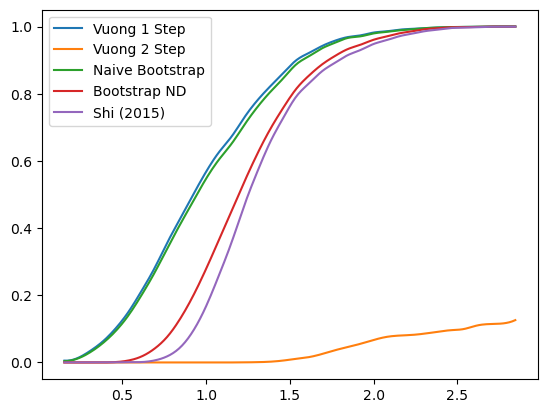

In [10]:
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)

# sequence 3


Quantiles: 1th: 0.80, 5th: 2.18, 10th: 3.87, 30th: 11.04, 50th: 19.13, 70th: 29.45, 90th: 46.99, 95th: 56.10, 99th: 72.63
bonus term 0.74572967250852 // variance stats 35.52209956705015 //part1 27.235613349459868 //part2 36.522099567050155 35.52209956705015
-0.957635075925663 0.2342223461879618 2.7753754147708265
-2.4490944209427026 0.2342223461879618 1.283916069753787
---
Quantiles: 1th: 0.68, 5th: 1.61, 10th: 2.82, 30th: 8.38, 50th: 14.59, 70th: 22.46, 90th: 35.68, 95th: 42.31, 99th: 56.10
bonus term 1.1054176228244963 // variance stats 13.533371263505183 //part1 16.065444713729747 //part2 14.533371263505185 13.533371263505183
-0.7465680117756542 -0.4194531159467891 2.9898519158467067
-2.9574032574246467 -0.4194531159467891 0.7790166701977143
---
Quantiles: 1th: 0.81, 5th: 2.02, 10th: 3.64, 30th: 9.88, 50th: 17.59, 70th: 26.81, 90th: 42.25, 95th: 50.45, 99th: 67.60
bonus term 12.801903411763625 // variance stats 0.7633085563337316 //part1 22.573705823320793 //part2 1.7633085563337316

Quantiles: 1th: 0.82, 5th: 1.94, 10th: 3.51, 30th: 10.04, 50th: 17.67, 70th: 27.15, 90th: 43.12, 95th: 50.50, 99th: 66.62
bonus term 0.5459165866399275 // variance stats 41.72702285255599 //part1 23.32539047295354 //part2 42.72702285255598 41.72702285255599
-1.4134546908770809 0.5003267723988283 2.609531232817532
-2.5052878641569363 0.5003267723988283 1.517698059537677
---
Quantiles: 1th: 0.75, 5th: 1.86, 10th: 3.34, 30th: 9.67, 50th: 17.44, 70th: 27.04, 90th: 43.06, 95th: 50.98, 99th: 67.22
bonus term 0.9164508248650834 // variance stats 23.670924999252684 //part1 22.609689565749733 //part2 24.670924999252684 23.670924999252684
-0.98927320326782 -0.08313179687025682 2.8094858174231536
-2.822174852997987 -0.08313179687025682 0.9765841676929866
---
Quantiles: 1th: 0.62, 5th: 1.51, 10th: 2.59, 30th: 7.86, 50th: 13.69, 70th: 21.05, 90th: 33.52, 95th: 40.44, 99th: 52.89
bonus term 0.9723242439397437 // variance stats 13.705645669347442 //part1 14.298655807094018 //part2 14.705645669347442 

Quantiles: 1th: 0.77, 5th: 1.82, 10th: 3.03, 30th: 8.68, 50th: 15.01, 70th: 23.05, 90th: 36.96, 95th: 44.63, 99th: 60.39
bonus term 0.6384050447221851 // variance stats 25.434643493976147 //part1 16.87600976198686 //part2 26.434643493976147 25.434643493976147
-1.3755034293445314 0.03012553205149446 2.5642054029068753
-2.6523135187889015 0.03012553205149446 1.2873953134625054
---
Quantiles: 1th: 0.82, 5th: 1.90, 10th: 3.27, 30th: 9.03, 50th: 15.19, 70th: 23.13, 90th: 37.01, 95th: 43.57, 99th: 56.62
bonus term 1.090429791571842 // variance stats 14.326603121976058 //part1 16.712584647800696 //part2 15.32660312197606 14.326603121976058
-0.8482401584330272 -0.47136547572069176 2.9592032154133667
-3.0290997415767107 -0.47136547572069176 0.7783436322696831
---
Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.30, 30th: 9.48, 50th: 16.62, 70th: 25.68, 90th: 40.48, 95th: 48.31, 99th: 62.74
bonus term 0.46139537266209324 // variance stats 43.03709567226345 //part1 20.31851216866024 //part2 44.0370956722

Quantiles: 1th: 0.62, 5th: 1.70, 10th: 2.90, 30th: 8.49, 50th: 14.59, 70th: 22.76, 90th: 36.21, 95th: 42.80, 99th: 55.45
bonus term 0.7368620385803494 // variance stats 21.663025817590785 //part1 16.699523404349037 //part2 22.663025817590785 21.663025817590785
-1.0782884548179903 -0.10734187057078555 2.535381245399834
-2.552012531978689 -0.10734187057078555 1.0616571682391351
---
Quantiles: 1th: 0.71, 5th: 1.75, 10th: 3.12, 30th: 8.85, 50th: 15.79, 70th: 23.60, 90th: 36.95, 95th: 44.79, 99th: 57.07
bonus term 0.6535851820064423 // variance stats 24.742444249424928 //part1 16.824880110051087 //part2 25.742444249424928 24.742444249424928
-1.1883978538877344 0.025039857639887593 2.52672928515144
-2.495568217900619 0.025039857639887593 1.2195589211385547
---
Quantiles: 1th: 0.57, 5th: 1.60, 10th: 2.78, 30th: 7.88, 50th: 13.54, 70th: 20.58, 90th: 32.89, 95th: 39.27, 99th: 51.30
bonus term 5.943728090406172 // variance stats 1.2571370385670395 //part1 13.415808820027111 //part2 2.25713703856

Quantiles: 1th: 0.82, 5th: 1.98, 10th: 3.34, 30th: 9.70, 50th: 16.62, 70th: 25.43, 90th: 40.53, 95th: 48.56, 99th: 64.19
bonus term 0.7347909142357646 // variance stats 26.711513475256968 //part1 20.362168321340775 //part2 27.711513475256968 26.711513475256968
-1.0396905724003334 -0.018093682089751623 2.582513691318733
-2.509272400871863 -0.018093682089751623 1.1129318628472038
---
Quantiles: 1th: 0.94, 5th: 2.23, 10th: 4.11, 30th: 12.00, 50th: 20.96, 70th: 31.38, 90th: 49.75, 95th: 59.76, 99th: 79.11
bonus term 1.7250780890557387 // variance stats 16.56265651906549 //part1 30.296953946651804 //part2 17.56265651906549 16.56265651906549
-0.18690453446188318 -0.9520757468315709 3.4476351128651093
-3.6370607125733607 -0.9520757468315709 -0.002521065246368211
---
Quantiles: 1th: 0.66, 5th: 1.95, 10th: 3.29, 30th: 9.71, 50th: 17.05, 70th: 25.78, 90th: 41.26, 95th: 49.30, 99th: 63.93
bonus term 2.7067643329955677 // variance stats 6.687113258689953 //part1 20.807203992319295 //part2 7.687113

Quantiles: 1th: 0.81, 5th: 2.10, 10th: 3.88, 30th: 11.68, 50th: 20.92, 70th: 31.89, 90th: 50.81, 95th: 60.30, 99th: 77.80
bonus term 0.6251970711983336 // variance stats 50.11614166329921 //part1 31.95766205885378 //part2 51.11614166329921 50.11614166329921
-1.3625103734003634 0.41854127675697234 2.537623359184033
-2.6129045157970308 0.41854127675697234 1.2872292167873662
---
Quantiles: 1th: 0.79, 5th: 2.10, 10th: 3.86, 30th: 10.93, 50th: 18.95, 70th: 28.78, 90th: 45.23, 95th: 54.08, 99th: 70.98
bonus term 1.6129099550147694 // variance stats 15.27797795593301 //part1 26.25491269263532 //part2 16.27797795593301 15.27797795593301
-0.22168257558217183 -0.7599181304353682 3.4705078616640646
-3.447502485611711 -0.7599181304353682 0.24468795163452553
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.76, 5th: 2.16, 10th: 3.92, 30th: 11.30, 50th: 19.53, 70th: 30.65, 90th: 49.01, 95th: 58.48, 99th: 75.55
bonus term 4.378281341510101 // variance stats 5.722131931937808 //part1 29.43138481277

Quantiles: 1th: 0.73, 5th: 1.99, 10th: 3.43, 30th: 10.14, 50th: 17.53, 70th: 26.54, 90th: 42.04, 95th: 50.05, 99th: 65.87
bonus term 0.49419518790688577 // variance stats 43.358869357915225 //part1 21.921939777671913 //part2 44.358869357915225 43.358869357915225
-1.444279020702911 0.197623227552271 2.45502119847239
-2.432669396516683 0.197623227552271 1.4666308226586189
---
Quantiles: 1th: 0.92, 5th: 2.39, 10th: 4.33, 30th: 12.14, 50th: 21.14, 70th: 32.44, 90th: 50.89, 95th: 60.38, 99th: 79.81
bonus term 0.7187244465590681 // variance stats 44.823012139852466 //part1 32.93411903988492 //part2 45.823012139852466 44.823012139852466
-1.3369201784332383 0.2216633972610505 2.474873430597278
-2.7743690715513747 0.2216633972610505 1.0374245374791418
---
Quantiles: 1th: 0.68, 5th: 1.73, 10th: 3.30, 30th: 9.88, 50th: 16.83, 70th: 25.85, 90th: 40.70, 95th: 47.71, 99th: 61.98
bonus term 3.271710904358721 // variance stats 5.482286245130979 //part1 21.20816659336957 //part2 6.482286245130978 5.482

Quantiles: 1th: 0.85, 5th: 2.08, 10th: 3.59, 30th: 10.57, 50th: 18.13, 70th: 28.59, 90th: 46.29, 95th: 55.96, 99th: 70.07
bonus term 1.160885590663174 // variance stats 21.483457106310638 //part1 26.100721383009567 //part2 22.483457106310638 21.483457106310638
-0.8036920323831258 -0.715688106247971 3.0749471958515047
-3.125463213709474 -0.715688106247971 0.7531760145251567
---
Quantiles: 1th: 0.69, 5th: 1.84, 10th: 3.14, 30th: 8.92, 50th: 15.33, 70th: 23.89, 90th: 37.63, 95th: 45.71, 99th: 60.58
bonus term 0.8578247905719586 // variance stats 19.813967884020585 //part1 17.85473764108143 //part2 20.813967884020585 19.813967884020585
-1.003056905065118 -0.45368773932938145 2.693412999167582
-2.7187064862090353 -0.45368773932938145 0.977763418023665
---
Quantiles: 1th: 0.70, 5th: 2.01, 10th: 3.51, 30th: 10.34, 50th: 18.20, 70th: 27.82, 90th: 43.56, 95th: 51.20, 99th: 67.68
bonus term 6.93181413807879 // variance stats 2.4570830581111025 //part1 23.963857218727195 //part2 3.457083058111102

Quantiles: 1th: 0.72, 5th: 1.99, 10th: 3.54, 30th: 10.24, 50th: 17.52, 70th: 27.07, 90th: 42.39, 95th: 51.47, 99th: 67.71
bonus term 0.305786610118799 // variance stats 73.28660285885053 //part1 22.715848465449383 //part2 74.28660285885053 73.28660285885053
-1.585641898076622 0.9505258396731425 2.3020635777320506
-2.1972151183142197 0.9505258396731425 1.6904903574944525
---
Quantiles: 1th: 0.57, 5th: 1.35, 10th: 2.25, 30th: 6.79, 50th: 11.88, 70th: 18.22, 90th: 28.64, 95th: 34.27, 99th: 44.41
bonus term 0.36799369554516986 // variance stats 26.71828362086098 //part1 10.200153623809785 //part2 27.71828362086098 26.71828362086098
-1.397879329155423 0.18775536905767506 2.1258401987655624
-2.133866720245763 0.18775536905767506 1.3898528076752228
---
Quantiles: 1th: 0.72, 5th: 1.76, 10th: 2.96, 30th: 9.09, 50th: 15.88, 70th: 24.05, 90th: 38.83, 95th: 46.27, 99th: 59.91
bonus term 0.6236122182459919 // variance stats 28.450210475702207 //part1 18.365511082564005 //part2 29.450210475702207 28

Quantiles: 1th: 0.70, 5th: 1.83, 10th: 3.22, 30th: 9.52, 50th: 16.62, 70th: 25.17, 90th: 39.84, 95th: 47.60, 99th: 62.71
bonus term 1.6042190136010746 // variance stats 11.457406965739551 //part1 19.98440911460586 //part2 12.457406965739553 11.457406965739551
-0.06799128692160818 -2.2545753512921887 3.396513632831663
-3.2764293141237575 -2.2545753512921887 0.18807560562951386
---
Quantiles: 1th: 0.72, 5th: 1.98, 10th: 3.43, 30th: 9.68, 50th: 16.36, 70th: 25.69, 90th: 39.81, 95th: 48.02, 99th: 62.57
bonus term 0.651934793798825 // variance stats 31.00783072461219 //part1 20.867018523397746 //part2 32.00783072461219 31.00783072461219
-1.494903134206586 -0.16890165045175337 2.502499240029472
-2.798772721804236 -0.16890165045175337 1.1986296524318218
---
Quantiles: 1th: 0.65, 5th: 1.87, 10th: 3.41, 30th: 10.69, 50th: 18.32, 70th: 28.64, 90th: 44.84, 95th: 54.05, 99th: 71.16
bonus term 0.5207032332604786 // variance stats 47.359940783519875 //part1 25.181177526264083 //part2 48.359940783519

Quantiles: 1th: 0.63, 5th: 1.60, 10th: 2.65, 30th: 7.26, 50th: 12.89, 70th: 20.00, 90th: 31.79, 95th: 38.20, 99th: 49.90
bonus term 1.008537663932976 // variance stats 11.674559963635712 //part1 12.782771097103584 //part2 12.674559963635712 11.674559963635712
-0.8318498093690335 -1.3889919947129032 2.9124270277836035
-2.8489251372349855 -1.3889919947129032 0.8953516999176515
---
Quantiles: 1th: 0.93, 5th: 2.20, 10th: 3.99, 30th: 12.30, 50th: 21.44, 70th: 33.11, 90th: 51.63, 95th: 61.15, 99th: 81.16
bonus term 0.45065817760077664 // variance stats 74.50692977366553 //part1 34.02781536802993 //part2 75.50692977366553 74.50692977366553
-1.4322623115795614 0.8073952596261251 2.4895127164379662
-2.3335786667811145 0.8073952596261251 1.588196361236413
---
Quantiles: 1th: 0.66, 5th: 1.56, 10th: 2.44, 30th: 7.08, 50th: 12.51, 70th: 19.16, 90th: 30.44, 95th: 36.64, 99th: 48.15
bonus term 0.2654818908187628 // variance stats 40.999464208494665 //part1 11.150097171446115 //part2 41.99946420849466

Quantiles: 1th: 0.70, 5th: 2.00, 10th: 3.83, 30th: 11.63, 50th: 20.14, 70th: 31.01, 90th: 48.30, 95th: 57.56, 99th: 77.00
bonus term 1.0427005892980656 // variance stats 27.151034941015407 //part1 29.353100722347204 //part2 28.151034941015407 27.151034941015407
-0.7477158714626341 -0.39990387686500006 2.8965204031845175
-2.8331170500587652 -0.39990387686500006 0.8111192245883864
---
Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.24, 30th: 9.21, 50th: 15.61, 70th: 24.30, 90th: 38.42, 95th: 45.55, 99th: 58.62
bonus term 0.21428904795571624 // variance stats 85.39743926802332 //part1 18.51402500655653 //part2 86.39743926802332 85.39743926802332
-1.8628267109287286 1.4000936437005902 2.278539590840234
-2.2914048068401613 1.4000936437005902 1.8499614949288015
---
Quantiles: 1th: 0.81, 5th: 1.94, 10th: 3.23, 30th: 9.23, 50th: 16.02, 70th: 24.67, 90th: 38.55, 95th: 46.38, 99th: 59.15
bonus term 0.2726864452375918 // variance stats 66.25790748967331 //part1 18.340319707477818 //part2 67.257907489673

Quantiles: 1th: 0.74, 5th: 2.01, 10th: 3.74, 30th: 10.96, 50th: 19.35, 70th: 29.58, 90th: 46.59, 95th: 54.99, 99th: 72.25
bonus term 0.558862837258026 // variance stats 48.15704699211912 //part1 27.472046753241802 //part2 49.15704699211911 48.15704699211912
-1.4242641535802896 0.03363470905858214 2.4684276097546007
-2.5419898280963418 0.03363470905858214 1.350701935238549
---
Quantiles: 1th: 0.70, 5th: 1.64, 10th: 2.92, 30th: 9.03, 50th: 15.53, 70th: 24.25, 90th: 39.90, 95th: 47.11, 99th: 61.64
bonus term 0.24563989708894202 // variance stats 76.34979408775864 //part1 19.000195459567887 //part2 77.34979408775862 76.34979408775864
-1.593210545878613 1.2243195433394445 2.3018341215321074
-2.084490340056497 1.2243195433394445 1.8105543273542235
---
Quantiles: 1th: 0.66, 5th: 1.99, 10th: 3.42, 30th: 10.01, 50th: 17.83, 70th: 27.46, 90th: 44.11, 95th: 52.72, 99th: 66.77
bonus term 0.9535728792340574 // variance stats 23.928400503173904 //part1 23.771046642511266 //part2 24.928400503173904 2

Quantiles: 1th: 0.84, 5th: 1.96, 10th: 3.23, 30th: 9.06, 50th: 15.87, 70th: 24.49, 90th: 39.81, 95th: 47.42, 99th: 61.58
bonus term 0.3086269387972381 // variance stats 61.45011799057442 //part1 19.273788742957308 //part2 62.45011799057441 61.45011799057442
-1.7043466708126487 0.5777894747199821 2.309259823215253
-2.3216005484071247 0.5777894747199821 1.6920059456207768
---
Quantiles: 1th: 0.68, 5th: 1.89, 10th: 3.12, 30th: 8.40, 50th: 14.89, 70th: 23.17, 90th: 36.50, 95th: 43.48, 99th: 55.98
bonus term 0.4209794684717753 // variance stats 39.18895339729396 //part1 16.918724239629757 //part2 40.18895339729396 39.18895339729396
-1.3498078488896237 -0.29148897160327586 2.602061405982454
-2.191766785833174 -0.29148897160327586 1.7601024690389033
---
Quantiles: 1th: 0.56, 5th: 1.55, 10th: 2.69, 30th: 8.41, 50th: 14.35, 70th: 22.83, 90th: 36.40, 95th: 43.50, 99th: 57.58
bonus term 0.28689154703179104 // variance stats 57.99801048796738 //part1 16.926030500690793 //part2 58.99801048796738 57

0.7692307692307693 [0.94571429 0.         0.05428571]
Quantiles: 1th: 0.69, 5th: 1.60, 10th: 2.91, 30th: 8.62, 50th: 15.36, 70th: 23.78, 90th: 37.66, 95th: 44.34, 99th: 56.65
bonus term 0.4629304017397341 // variance stats 36.78698022819716 //part1 17.492741937570703 //part2 37.786980228197166 36.78698022819716
-1.3642433351066177 -0.23904647714730395 2.4320712422221042
-2.2901041385860856 -0.23904647714730395 1.5062104387426365
---
Quantiles: 1th: 0.61, 5th: 1.63, 10th: 2.87, 30th: 9.23, 50th: 16.20, 70th: 24.68, 90th: 38.72, 95th: 46.04, 99th: 62.03
bonus term 0.2997341294748716 // variance stats 62.112722366528544 //part1 18.917036897320692 //part2 63.112722366528544 62.112722366528544
-1.6775353601716823 0.6701283774975931 2.278522791814385
-2.277003619121426 0.6701283774975931 1.6790545328646416
---
Quantiles: 1th: 0.58, 5th: 1.68, 10th: 2.95, 30th: 8.45, 50th: 14.82, 70th: 22.54, 90th: 36.06, 95th: 43.29, 99th: 55.05
bonus term 0.2551326298020375 // variance stats 62.274951763239

Quantiles: 1th: 0.64, 5th: 1.64, 10th: 2.84, 30th: 8.13, 50th: 14.68, 70th: 21.97, 90th: 35.15, 95th: 41.41, 99th: 54.69
bonus term 1.4413980561213116 // variance stats 9.532792029684252 //part1 15.181945957116923 //part2 10.532792029684252 9.532792029684252
-0.29893869632966397 -4.745368493193347 3.1610152784500993
-3.181734808572287 -4.745368493193347 0.2782191662074764
---
Quantiles: 1th: 0.63, 5th: 1.78, 10th: 3.18, 30th: 9.55, 50th: 16.49, 70th: 25.76, 90th: 41.60, 95th: 49.67, 99th: 64.83
bonus term 0.2646494767915455 // variance stats 78.98723830199248 //part1 21.168580766622973 //part2 79.98723830199248 78.98723830199248
-1.8599227471762894 0.7641189205493024 2.3242357158385234
-2.3892217007593803 0.7641189205493024 1.7949367622554326
---
Quantiles: 1th: 0.76, 5th: 1.87, 10th: 3.05, 30th: 9.19, 50th: 16.16, 70th: 24.79, 90th: 39.98, 95th: 47.15, 99th: 63.30
bonus term 0.8440430714220268 // variance stats 22.114166718803105 //part1 19.509352270699367 //part2 23.114166718803105 2

Quantiles: 1th: 0.68, 5th: 1.75, 10th: 2.82, 30th: 7.71, 50th: 13.81, 70th: 21.37, 90th: 33.36, 95th: 40.00, 99th: 51.29
bonus term 0.7433835675914116 // variance stats 18.19931319828775 //part1 14.272453940648026 //part2 19.199313198287754 18.19931319828775
-1.4970292935781886 -3.0830916917890616 2.7094779313158
-2.9837964287610115 -3.0830916917890616 1.2227107961329775
---
Quantiles: 1th: 0.71, 5th: 1.85, 10th: 3.26, 30th: 9.36, 50th: 16.02, 70th: 24.05, 90th: 38.00, 95th: 45.78, 99th: 61.05
bonus term 0.324855442485952 // variance stats 54.73854640420253 //part1 18.106970155660978 //part2 55.73854640420252 54.73854640420253
-1.7272563540480177 0.2621484745267031 2.161535535317256
-2.3769672390199217 0.2621484745267031 1.511824650345352
---
Quantiles: 1th: 0.83, 5th: 1.92, 10th: 3.14, 30th: 8.44, 50th: 14.62, 70th: 22.51, 90th: 36.98, 95th: 43.70, 99th: 57.15
bonus term 0.486701237165912 // variance stats 32.44349102342607 //part1 16.276988456248542 //part2 33.44349102342607 32.44349

Quantiles: 1th: 0.56, 5th: 1.65, 10th: 3.01, 30th: 8.82, 50th: 15.21, 70th: 23.47, 90th: 37.97, 95th: 44.65, 99th: 57.54
bonus term 0.3460242493093245 // variance stats 50.58784948196294 //part1 17.850646890478654 //part2 51.587849481962934 50.58784948196294
-1.5531800421178614 0.024039645176579007 2.3581595841901692
-2.2452285407365102 0.024039645176579007 1.6661110855715202
---
Quantiles: 1th: 0.68, 5th: 1.71, 10th: 3.07, 30th: 8.91, 50th: 15.60, 70th: 24.45, 90th: 38.64, 95th: 46.08, 99th: 61.03
bonus term 0.4634169587361478 // variance stats 39.661000795427825 //part1 18.84299732778525 //part2 40.661000795427825 39.661000795427825
-1.5394697271654556 -0.6363404957863132 2.460848220218
-2.4663036446377515 -0.6363404957863132 1.534014302745705
---
Quantiles: 1th: 0.71, 5th: 1.70, 10th: 2.98, 30th: 7.73, 50th: 13.47, 70th: 20.60, 90th: 32.74, 95th: 38.79, 99th: 51.64
bonus term 0.2086272273565986 // variance stats 62.420063174094835 //part1 13.23115193879173 //part2 63.420063174094835

Quantiles: 1th: 0.63, 5th: 1.74, 10th: 2.84, 30th: 7.90, 50th: 13.99, 70th: 21.17, 90th: 34.09, 95th: 40.37, 99th: 53.60
bonus term 0.4029419341361311 // variance stats 34.242206014348774 //part1 14.200562654645687 //part2 35.242206014348774 34.242206014348774
-1.515153149324191 -0.8279278158591666 2.477586396495817
-2.3210370175964528 -0.8279278158591666 1.6717025282235551
---
Quantiles: 1th: 0.87, 5th: 2.09, 10th: 3.81, 30th: 11.77, 50th: 20.28, 70th: 30.73, 90th: 48.82, 95th: 58.20, 99th: 74.71
bonus term 1.4531877150646804 // variance stats 19.431099557833857 //part1 29.690222882707584 //part2 20.431099557833857 19.431099557833857
-0.5251021595607521 -2.722750124023668 3.24893828774628
-3.431477589690113 -2.722750124023668 0.34256285761691896
---
Quantiles: 1th: 0.67, 5th: 1.78, 10th: 3.09, 30th: 8.92, 50th: 15.53, 70th: 23.68, 90th: 37.56, 95th: 44.54, 99th: 57.53
bonus term 1.4287553478757689 // variance stats 11.19371979288314 //part1 17.421842364580403 //part2 12.19371979288314

Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.30, 30th: 9.64, 50th: 16.78, 70th: 25.65, 90th: 40.80, 95th: 48.63, 99th: 64.01
bonus term 0.29826599006774646 // variance stats 69.17482264286257 //part1 20.930762953401914 //part2 70.17482264286257 69.17482264286257
-1.5679812508782023 0.344126789936023 2.316777489919392
-2.164513231013695 0.344126789936023 1.7202455097838985
---
Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.17, 30th: 10.12, 50th: 17.62, 70th: 26.95, 90th: 42.92, 95th: 52.43, 99th: 68.93
bonus term 1.5820743494330252 // variance stats 13.386639999036413 //part1 22.760734117002677 //part2 14.386639999036415 13.386639999036413
-0.7629542428326301 -5.048109392712721 3.448849524102064
-3.9271029416986805 -5.048109392712721 0.2847008252360138
---
1.076923076923077 [0.92428571 0.         0.07571429]
Quantiles: 1th: 0.82, 5th: 2.25, 10th: 4.35, 30th: 13.13, 50th: 22.10, 70th: 33.76, 90th: 53.21, 95th: 63.75, 99th: 83.04
bonus term 0.3632170134228452 // variance stats 99.2964547671424 //pa

Quantiles: 1th: 0.82, 5th: 1.97, 10th: 3.50, 30th: 10.43, 50th: 18.33, 70th: 28.13, 90th: 44.71, 95th: 53.75, 99th: 70.03
bonus term 0.37818139113926397 // variance stats 65.3499270066553 //part1 25.092307697365523 //part2 66.3499270066553 65.3499270066553
-1.6978251556688253 -0.3535580420233872 2.4137274564457787
-2.4541879379473537 -0.3535580420233872 1.6573646741672503
---
Quantiles: 1th: 0.60, 5th: 1.67, 10th: 2.93, 30th: 8.87, 50th: 15.25, 70th: 23.04, 90th: 37.35, 95th: 44.38, 99th: 58.70
bonus term 0.34775031985444677 // variance stats 47.50290251811294 //part1 16.866899864542827 //part2 48.50290251811294 47.50290251811294
-1.6291850762963496 -0.7213339357256728 2.3688963639308733
-2.324685716005243 -0.7213339357256728 1.6733957242219797
---
Quantiles: 1th: 0.74, 5th: 1.74, 10th: 3.09, 30th: 8.36, 50th: 14.78, 70th: 22.61, 90th: 35.76, 95th: 42.64, 99th: 56.40
bonus term 0.2077097107865393 // variance stats 75.60725545486656 //part1 15.912070874680866 //part2 76.60725545486656 7

Quantiles: 1th: 0.75, 5th: 1.96, 10th: 3.66, 30th: 10.92, 50th: 19.02, 70th: 29.17, 90th: 46.37, 95th: 54.71, 99th: 72.40
bonus term 0.7125172801416018 // variance stats 36.519979250063685 //part1 26.73363356622471 //part2 37.519979250063685 36.519979250063685
-1.3478338213335797 -1.534406807546608 2.659449596939691
-2.772868381616783 -1.534406807546608 1.234415036656487
---
Quantiles: 1th: 0.67, 5th: 1.79, 10th: 3.22, 30th: 9.67, 50th: 16.70, 70th: 25.45, 90th: 40.80, 95th: 47.93, 99th: 64.34
bonus term 0.41024182260681996 // variance stats 47.446692470955874 //part1 19.87485941855704 //part2 48.446692470955874 47.446692470955874
-1.7375767019607284 -1.0826683418486922 2.2875032107752697
-2.5580603471743686 -1.0826683418486922 1.4670195655616298
---
Quantiles: 1th: 0.75, 5th: 2.05, 10th: 3.83, 30th: 11.50, 50th: 20.42, 70th: 31.51, 90th: 51.09, 95th: 60.86, 99th: 81.92
bonus term 0.7041839698971198 // variance stats 42.820935036300945 //part1 30.857999998466184 //part2 43.820935036300

Quantiles: 1th: 0.67, 5th: 1.73, 10th: 2.99, 30th: 8.70, 50th: 15.37, 70th: 23.89, 90th: 38.20, 95th: 45.39, 99th: 59.08
bonus term 0.24737096350038892 // variance stats 73.01678290609206 //part1 18.30960290267911 //part2 74.01678290609206 73.01678290609206
-1.8275487627677072 0.1499517109875425 2.361333774928822
-2.322290689768485 0.1499517109875425 1.8665918479280443
---
Quantiles: 1th: 0.67, 5th: 1.73, 10th: 2.81, 30th: 8.10, 50th: 13.64, 70th: 21.08, 90th: 33.32, 95th: 39.30, 99th: 51.02
bonus term 0.29540175297317817 // variance stats 46.72288655494579 //part1 14.097424345271097 //part2 47.72288655494578 46.72288655494579
-1.6304962023511003 -0.8822365385931952 2.374198859303042
-2.2212997082974564 -0.8822365385931952 1.7833953533566858
---
Quantiles: 1th: 0.62, 5th: 1.64, 10th: 3.01, 30th: 8.39, 50th: 14.76, 70th: 22.71, 90th: 35.12, 95th: 42.44, 99th: 55.31
bonus term 0.34219224115112723 // variance stats 45.684363663168675 //part1 15.975027028613937 //part2 46.684363663168675 4

Quantiles: 1th: 0.81, 5th: 2.23, 10th: 3.90, 30th: 10.94, 50th: 19.04, 70th: 29.64, 90th: 47.74, 95th: 57.78, 99th: 75.77
bonus term 0.336839129305291 // variance stats 82.22122547171193 //part1 28.032165127610746 //part2 83.22122547171192 82.22122547171193
-1.5843017926796354 -0.06184652043491186 2.4723323482870416
-2.2579800512902173 -0.06184652043491186 1.7986540896764598
---
Quantiles: 1th: 0.87, 5th: 2.04, 10th: 3.29, 30th: 9.20, 50th: 15.92, 70th: 24.49, 90th: 39.07, 95th: 45.86, 99th: 60.46
bonus term 0.13579860136096752 // variance stats 138.51981109442005 //part1 18.946595208768642 //part2 139.51981109442005 138.51981109442005
-1.786717098660581 1.9044387108537082 2.4167891029068747
-2.058314301382516 1.9044387108537082 2.1451919001849395
---
Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.28, 30th: 10.11, 50th: 17.87, 70th: 27.30, 90th: 43.77, 95th: 52.23, 99th: 69.79
bonus term 0.21747951093551304 // variance stats 108.24823377054237 //part1 23.759252450986153 //part2 109.248233770

Quantiles: 1th: 0.66, 5th: 1.81, 10th: 3.09, 30th: 8.78, 50th: 15.81, 70th: 23.96, 90th: 37.65, 95th: 44.61, 99th: 58.65
bonus term 0.16565804837833753 // variance stats 104.7346392519845 //part1 17.515793984471316 //part2 105.7346392519845 104.7346392519845
-1.650188073927303 1.4040698002791534 2.140014796133896
-1.9815041706839778 1.4040698002791534 1.8086986993772214
---
Quantiles: 1th: 0.70, 5th: 1.68, 10th: 2.97, 30th: 8.74, 50th: 15.05, 70th: 22.69, 90th: 35.97, 95th: 42.36, 99th: 58.35
bonus term 0.20717038875510624 // variance stats 78.3066405697065 //part1 16.42998755768758 //part2 79.3066405697065 78.3066405697065
-1.6005319362265367 0.5819483791156118 2.029198280145432
-2.0148727137367493 0.5819483791156118 1.6148575026352192
---
Quantiles: 1th: 0.65, 5th: 1.63, 10th: 3.08, 30th: 9.06, 50th: 16.00, 70th: 25.26, 90th: 39.75, 95th: 46.34, 99th: 61.77
bonus term 0.2700339284106012 // variance stats 71.93597275866425 //part1 19.695187246470695 //part2 72.93597275866424 71.935972

Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.06, 30th: 8.70, 50th: 15.05, 70th: 22.99, 90th: 37.22, 95th: 44.47, 99th: 57.36
bonus term 0.20107613334924604 // variance stats 82.80889279971143 //part1 16.85196810444744 //part2 83.80889279971143 82.80889279971143
-1.5722076736496167 0.5911410057210158 2.0834654231258067
-1.974359940348109 0.5911410057210158 1.6813131564273145
---
Quantiles: 1th: 0.62, 5th: 1.53, 10th: 2.69, 30th: 7.93, 50th: 14.07, 70th: 20.86, 90th: 34.03, 95th: 40.24, 99th: 51.31
bonus term 0.20789582606780688 // variance stats 66.00105105418238 //part1 13.92923885632055 //part2 67.00105105418238 66.00105105418238
-1.7138139339923182 0.09191361220688124 2.34172393347732
-2.1296055861279317 0.09191361220688124 1.9259322813417066
---
Quantiles: 1th: 0.86, 5th: 1.97, 10th: 3.17, 30th: 8.67, 50th: 15.11, 70th: 23.22, 90th: 37.42, 95th: 44.33, 99th: 57.85
bonus term 0.5240576518936951 // variance stats 31.650998408717644 //part1 17.111005558057343 //part2 32.65099840871764 31.6

Quantiles: 1th: 0.82, 5th: 2.13, 10th: 3.50, 30th: 10.18, 50th: 18.13, 70th: 27.56, 90th: 44.08, 95th: 51.54, 99th: 67.08
bonus term 0.26783372321861126 // variance stats 89.52335722314722 //part1 24.245207803323886 //part2 90.52335722314722 89.52335722314722
-1.657733454936952 0.1634491203613932 2.432748905119057
-2.193400901374175 0.1634491203613932 1.8970814586818348
---
Quantiles: 1th: 0.76, 5th: 2.17, 10th: 3.92, 30th: 11.49, 50th: 20.30, 70th: 31.16, 90th: 49.08, 95th: 58.02, 99th: 75.96
bonus term 0.23517322227566748 // variance stats 127.83230146020996 //part1 30.297907467587752 //part2 128.83230146020995 127.83230146020996
-1.5241312169853853 0.9966166775463914 2.1474947293621036
-1.9944776615367203 0.9966166775463914 1.6771482848107688
---
Quantiles: 1th: 0.61, 5th: 1.63, 10th: 2.87, 30th: 8.05, 50th: 14.07, 70th: 21.78, 90th: 33.72, 95th: 40.08, 99th: 53.95
bonus term 0.18392218992014694 // variance stats 79.55227116453572 //part1 14.815350115622916 //part2 80.55227116453572

Quantiles: 1th: 0.62, 5th: 1.63, 10th: 2.90, 30th: 8.68, 50th: 15.76, 70th: 23.92, 90th: 38.15, 95th: 45.05, 99th: 60.89
bonus term 0.20164057118732057 // variance stats 85.9640608570634 //part1 17.53548290398717 //part2 86.9640608570634 85.9640608570634
-1.8181777124352232 0.38350095092324415 2.2050687217729297
-2.221458854809864 0.38350095092324415 1.8017875793982887
---
Quantiles: 1th: 0.71, 5th: 1.67, 10th: 2.92, 30th: 8.48, 50th: 14.70, 70th: 22.63, 90th: 35.57, 95th: 42.43, 99th: 55.79
bonus term 0.25469224280395547 // variance stats 63.9822700328616 //part1 16.550480097161785 //part2 64.98227003286159 63.9822700328616
-1.6097792353487295 -0.8179506286733026 2.179840792668419
-2.1191637209566405 -0.8179506286733026 1.6704563070605079
---
Quantiles: 1th: 0.74, 5th: 1.97, 10th: 3.48, 30th: 9.73, 50th: 17.29, 70th: 26.28, 90th: 41.94, 95th: 49.92, 99th: 65.50
bonus term 0.37002772106113885 // variance stats 58.52553570242685 //part1 22.026098320912464 //part2 59.52553570242685 58.52

1.6153846153846154 [0.92142857 0.00285714 0.07571429]
Quantiles: 1th: 0.84, 5th: 2.06, 10th: 3.82, 30th: 10.73, 50th: 18.46, 70th: 27.89, 90th: 44.77, 95th: 53.89, 99th: 72.17
bonus term 0.3224014475118062 // variance stats 75.72361335850682 //part1 24.735804005118748 //part2 76.72361335850682 75.72361335850682
-1.6050857671293106 -0.5659848508241249 2.309984170362587
-2.2498886621529226 -0.5659848508241249 1.6651812753389752
---
Quantiles: 1th: 0.68, 5th: 1.81, 10th: 3.20, 30th: 9.93, 50th: 17.51, 70th: 26.69, 90th: 41.69, 95th: 49.74, 99th: 63.73
bonus term 0.2355802456768893 // variance stats 93.69648781725566 //part1 22.30862186472764 //part2 94.69648781725566 93.69648781725566
-1.7006288289034959 0.13315383456023275 2.2952131341136903
-2.1717893202572744 0.13315383456023275 1.8240526427599117
---
Quantiles: 1th: 0.73, 5th: 1.82, 10th: 3.01, 30th: 8.84, 50th: 15.78, 70th: 24.18, 90th: 38.06, 95th: 44.44, 99th: 60.42
bonus term 0.2056657836161613 // variance stats 88.44973824943608 

Quantiles: 1th: 0.59, 5th: 1.57, 10th: 2.87, 30th: 8.55, 50th: 14.87, 70th: 22.46, 90th: 35.40, 95th: 42.05, 99th: 56.01
bonus term 0.16421796710093967 // variance stats 96.41100529495878 //part1 15.996637262797 //part2 97.41100529495878 96.41100529495878
-1.7739737636212416 0.836408198563764 2.2646952425425027
-2.102409697823121 0.836408198563764 1.9362593083406234
---
Quantiles: 1th: 0.67, 5th: 1.60, 10th: 2.73, 30th: 8.45, 50th: 14.34, 70th: 21.58, 90th: 34.17, 95th: 41.36, 99th: 55.43
bonus term 0.18261713569325652 // variance stats 80.03582479405907 //part1 14.798530212431643 //part2 81.03582479405907 80.03582479405907
-1.7901707888636131 -0.11210508836824973 2.049652810524268
-2.1554050602501262 -0.11210508836824973 1.684418539137755
---
Quantiles: 1th: 0.77, 5th: 2.16, 10th: 3.72, 30th: 10.52, 50th: 18.58, 70th: 28.48, 90th: 45.74, 95th: 53.90, 99th: 69.92
bonus term 0.25132384351953785 // variance stats 102.30017409440322 //part1 25.96179678964281 //part2 103.30017409440322 102

Quantiles: 1th: 0.64, 5th: 1.71, 10th: 2.96, 30th: 8.77, 50th: 15.13, 70th: 22.94, 90th: 37.05, 95th: 43.79, 99th: 56.17
bonus term 0.37110611625628365 // variance stats 44.76967660254154 //part1 16.985406926275285 //part2 45.76967660254154 44.76967660254154
-1.6979246388296398 -2.536239643700011 2.3671458445055906
-2.440136871342207 -2.536239643700011 1.624933611993023
---
Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.15, 30th: 9.41, 50th: 16.08, 70th: 24.73, 90th: 38.67, 95th: 45.59, 99th: 58.90
bonus term 0.18399044522415572 // variance stats 100.86681883565349 //part1 18.742521351140297 //part2 101.86681883565349 100.86681883565349
-1.7588112564486464 0.6919172744722121 2.2586089243753555
-2.126792146896958 0.6919172744722121 1.890628033927044
---
Quantiles: 1th: 0.77, 5th: 1.99, 10th: 3.40, 30th: 10.30, 50th: 17.51, 70th: 26.73, 90th: 42.67, 95th: 50.27, 99th: 65.47
bonus term 0.25863607672750555 // variance stats 87.72480396387854 //part1 22.947435205634577 //part2 88.72480396387854 8

Quantiles: 1th: 0.66, 5th: 1.77, 10th: 3.02, 30th: 8.93, 50th: 15.36, 70th: 23.64, 90th: 36.90, 95th: 44.59, 99th: 57.41
bonus term 0.15112219228846313 // variance stats 111.64208984479272 //part1 17.022719561299105 //part2 112.64208984479271 111.64208984479272
-1.7803622014585363 0.7796345078100148 2.0244950288673946
-2.082606586035462 0.7796345078100148 1.7222506442904684
---
Quantiles: 1th: 0.72, 5th: 1.75, 10th: 3.09, 30th: 9.00, 50th: 15.37, 70th: 23.31, 90th: 36.27, 95th: 43.78, 99th: 56.36
bonus term 0.16175861594098512 // variance stats 101.28707128301409 //part1 16.545815079397244 //part2 102.28707128301409 101.28707128301409
-1.8191715231987675 0.5944259412340048 2.078136925691399
-2.1426887550807376 0.5944259412340048 1.7546196938094283
---
Quantiles: 1th: 0.64, 5th: 1.95, 10th: 3.94, 30th: 11.84, 50th: 20.02, 70th: 30.74, 90th: 48.93, 95th: 58.80, 99th: 77.45
bonus term 0.32226697148523054 // variance stats 90.89472444909711 //part1 29.614634543680296 //part2 91.89472444909

Quantiles: 1th: 0.65, 5th: 1.76, 10th: 3.16, 30th: 9.18, 50th: 16.22, 70th: 25.07, 90th: 38.93, 95th: 45.74, 99th: 63.69
bonus term 0.3744121665898543 // variance stats 50.801634493510235 //part1 19.395162203610898 //part2 51.801634493510235 50.801634493510235
-1.7933657288799436 -2.7625402200248708 2.290832278866816
-2.5421900620596523 -2.7625402200248708 1.5420079456871074
---
Quantiles: 1th: 0.70, 5th: 1.81, 10th: 3.19, 30th: 9.33, 50th: 16.03, 70th: 24.88, 90th: 39.58, 95th: 46.68, 99th: 64.28
bonus term 0.19386079465694042 // variance stats 99.45529084273423 //part1 19.474342510266528 //part2 100.45529084273423 99.45529084273423
-1.9085879946712827 0.3624557187660729 2.2258206308460253
-2.2963095839851637 0.3624557187660729 1.8380990415321443
---
Quantiles: 1th: 0.67, 5th: 1.70, 10th: 2.79, 30th: 8.12, 50th: 14.09, 70th: 21.20, 90th: 34.48, 95th: 41.09, 99th: 55.47
bonus term 0.18051599545752453 // variance stats 80.28382969378148 //part1 14.673031431772854 //part2 81.283829693781

Quantiles: 1th: 0.62, 5th: 1.60, 10th: 2.79, 30th: 7.74, 50th: 13.62, 70th: 20.79, 90th: 31.83, 95th: 38.95, 99th: 51.22
bonus term 0.16698430364652433 // variance stats 78.51813335074172 //part1 13.278280124845072 //part2 79.51813335074172 78.51813335074172
-1.8446125744339334 -0.4974102271168192 2.0320534604613347
-2.1785811817269822 -0.4974102271168192 1.6980848531682862
---
Quantiles: 1th: 0.90, 5th: 2.45, 10th: 4.04, 30th: 11.89, 50th: 20.59, 70th: 31.22, 90th: 48.94, 95th: 57.42, 99th: 72.00
bonus term 0.19723385502215832 // variance stats 151.0272237530699 //part1 29.98491540913421 //part2 152.0272237530699 151.0272237530699
-1.7862423354462647 1.14998364912163 2.435518403083142
-2.180710045490581 1.14998364912163 2.0410506930388257
---
1.9230769230769231 [0.94142857 0.00285714 0.05571429]
Quantiles: 1th: 0.86, 5th: 2.31, 10th: 3.94, 30th: 11.42, 50th: 20.06, 70th: 31.11, 90th: 47.58, 95th: 57.41, 99th: 74.76
bonus term 0.23778107121738387 // variance stats 124.640884207506 //pa

Quantiles: 1th: 0.88, 5th: 2.44, 10th: 4.27, 30th: 12.63, 50th: 21.59, 70th: 33.78, 90th: 52.58, 95th: 62.57, 99th: 82.95
bonus term 0.33124234261584395 // variance stats 104.93492649840422 //part1 35.09013321816866 //part2 105.93492649840422 104.93492649840422
-1.6987385831384834 -0.32234620070220704 2.351699699777292
-2.3612232683701717 -0.32234620070220704 1.6892150145456042
---
Quantiles: 1th: 0.84, 5th: 1.92, 10th: 3.47, 30th: 10.93, 50th: 18.41, 70th: 28.44, 90th: 45.67, 95th: 53.82, 99th: 73.15
bonus term 0.35226638662348525 // variance stats 71.20146207434824 //part1 25.434148153863262 //part2 72.20146207434824 71.20146207434824
-1.5444150479074175 -1.4420431665719853 2.472095353321167
-2.248947821154388 -1.4420431665719853 1.767562580074196
---
Quantiles: 1th: 0.68, 5th: 1.78, 10th: 3.22, 30th: 9.40, 50th: 16.22, 70th: 24.89, 90th: 39.57, 95th: 46.64, 99th: 60.86
bonus term 0.2585558802284265 // variance stats 74.58182932562339 //part1 19.542126410561256 //part2 75.58182932562

Quantiles: 1th: 0.75, 5th: 1.89, 10th: 3.30, 30th: 9.10, 50th: 15.30, 70th: 23.79, 90th: 37.80, 95th: 45.01, 99th: 59.67
bonus term 0.15279212900104555 // variance stats 114.61707265815618 //part1 17.665378680308255 //part2 115.61707265815616 114.61707265815618
-1.8948945604015657 0.5984959045397173 2.1787051376554416
-2.2004788184036568 0.5984959045397173 1.8731208796533505
---
Quantiles: 1th: 0.82, 5th: 2.10, 10th: 3.72, 30th: 10.89, 50th: 19.44, 70th: 29.84, 90th: 46.94, 95th: 56.91, 99th: 74.42
bonus term 0.2774442133218886 // variance stats 97.89490556707202 //part1 27.437819276598756 //part2 98.89490556707202 97.89490556707202
-1.5546945554477865 -0.43823795776751345 2.333140027209317
-2.109582982091564 -0.43823795776751345 1.7782516005655393
---
Quantiles: 1th: 0.77, 5th: 2.07, 10th: 3.68, 30th: 10.80, 50th: 18.30, 70th: 28.33, 90th: 44.47, 95th: 52.51, 99th: 69.21
bonus term 0.1827428657455244 // variance stats 135.0280886428481 //part1 24.85816274048028 //part2 136.02808864284

Quantiles: 1th: 0.81, 5th: 2.18, 10th: 3.71, 30th: 10.50, 50th: 18.78, 70th: 28.75, 90th: 45.15, 95th: 53.67, 99th: 72.72
bonus term 0.2665715803874722 // variance stats 97.05528274807564 //part1 26.13875168749496 //part2 98.05528274807564 97.05528274807564
-1.6714760935661142 -0.5299557473345384 2.210273051416184
-2.2046192543410585 -0.5299557473345384 1.6771298906412395
---
Quantiles: 1th: 0.65, 5th: 1.73, 10th: 3.09, 30th: 9.17, 50th: 15.49, 70th: 23.32, 90th: 37.10, 95th: 44.23, 99th: 59.11
bonus term 0.16768322136314007 // variance stats 102.1655555146325 //part1 17.299132682411436 //part2 103.1655555146325 102.1655555146325
-1.9226461918381106 -0.12190615871699215 2.2119574739321726
-2.2580126345643907 -0.12190615871699215 1.8765910312058922
---
Quantiles: 1th: 0.57, 5th: 1.55, 10th: 2.44, 30th: 7.09, 50th: 12.18, 70th: 18.31, 90th: 29.71, 95th: 35.46, 99th: 45.43
bonus term 0.15332265406308598 // variance stats 68.6802056045467 //part1 10.68355405895062 //part2 69.6802056045467 

Quantiles: 1th: 0.94, 5th: 2.20, 10th: 3.75, 30th: 11.47, 50th: 19.44, 70th: 30.15, 90th: 47.49, 95th: 56.05, 99th: 73.11
bonus term 0.18979509560703953 // variance stats 145.61640097030642 //part1 27.827073839719347 //part2 146.6164009703064 145.61640097030642
-1.768422371820642 0.8031836669982256 2.113465700838585
-2.148012563034721 0.8031836669982256 1.7338755096245064
---
Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.25, 30th: 9.34, 50th: 16.31, 70th: 24.96, 90th: 39.82, 95th: 47.51, 99th: 62.20
bonus term 0.19938356765853696 // variance stats 98.06162209756599 //part1 19.751259631854467 //part2 99.06162209756599 98.06162209756599
-1.8118875668476557 -0.823770200152294 2.0869568135729373
-2.21065470216473 -0.823770200152294 1.6881896782558632
---
Quantiles: 1th: 0.58, 5th: 1.57, 10th: 2.57, 30th: 7.51, 50th: 13.02, 70th: 20.34, 90th: 32.40, 95th: 38.07, 99th: 49.67
bonus term 0.1407944686096915 // variance stats 93.03918609607993 //part1 13.240197234885462 //part2 94.03918609607993 93.0

Quantiles: 1th: 0.66, 5th: 2.05, 10th: 3.83, 30th: 11.23, 50th: 19.74, 70th: 30.03, 90th: 46.67, 95th: 55.79, 99th: 73.22
bonus term 0.20989467951386864 // variance stats 132.6045633835869 //part1 28.04288701298832 //part2 133.6045633835869 132.6045633835869
-1.7651318305479085 0.15865379450789052 2.145459349810706
-2.1849211895756455 0.15865379450789052 1.7256699907829685
---
Quantiles: 1th: 0.80, 5th: 1.86, 10th: 3.07, 30th: 8.63, 50th: 14.81, 70th: 22.70, 90th: 36.50, 95th: 43.23, 99th: 56.51
bonus term 0.18707737808483693 // variance stats 85.98049126596324 //part1 16.27208225056746 //part2 86.98049126596324 85.98049126596324
-1.840278805260981 -1.2882924399601243 1.9941473828453784
-2.214433561430655 -1.2882924399601243 1.6199926266757045
---
Quantiles: 1th: 0.77, 5th: 1.98, 10th: 3.52, 30th: 9.96, 50th: 17.61, 70th: 26.40, 90th: 41.82, 95th: 50.70, 99th: 65.54
bonus term 0.3099629501000255 // variance stats 69.49177775109484 //part1 21.849839389524696 //part2 70.49177775109483 69

Quantiles: 1th: 0.65, 5th: 2.01, 10th: 3.63, 30th: 10.91, 50th: 18.85, 70th: 28.70, 90th: 44.85, 95th: 53.50, 99th: 71.03
bonus term 0.23223977729744016 // variance stats 109.81909548830617 //part1 25.736602056507984 //part2 110.81909548830617 109.81909548830617
-1.7889837604795358 -0.3832243602586291 2.3650769828244176
-2.253463315074416 -0.3832243602586291 1.9005974282295375
---
Quantiles: 1th: 0.73, 5th: 1.93, 10th: 3.55, 30th: 10.40, 50th: 18.50, 70th: 28.50, 90th: 45.27, 95th: 53.59, 99th: 70.43
bonus term 0.17390205868311315 // variance stats 150.25774008891588 //part1 26.304032393217724 //part2 151.25774008891588 150.25774008891588
-1.9622265512144057 0.7326207430396184 2.286314538843211
-2.310030668580632 0.7326207430396184 1.938510421476985
---
Quantiles: 1th: 0.74, 5th: 2.10, 10th: 3.85, 30th: 12.02, 50th: 20.81, 70th: 31.83, 90th: 51.86, 95th: 60.55, 99th: 81.27
bonus term 0.19551749211496525 // variance stats 162.5075303281179 //part1 31.968582271665234 //part2 163.50753032

Quantiles: 1th: 0.87, 5th: 2.02, 10th: 3.50, 30th: 10.27, 50th: 17.59, 70th: 27.10, 90th: 42.92, 95th: 51.60, 99th: 65.69
bonus term 0.16910830025628368 // variance stats 139.12456314898157 //part1 23.69622669827856 //part2 140.12456314898157 139.12456314898157
-1.6947523998734195 0.3360996073694535 2.365723733676789
-2.0329690003859873 0.3360996073694535 2.0275071331642214
---
Quantiles: 1th: 0.72, 5th: 1.64, 10th: 2.67, 30th: 7.71, 50th: 13.73, 70th: 21.09, 90th: 33.44, 95th: 39.84, 99th: 51.12
bonus term 0.11425607881791319 // variance stats 124.14040989377902 //part1 14.29805253612958 //part2 125.14040989377902 124.14040989377902
-2.002643953368444 0.5808726717157205 2.1478930786622743
-2.2311561110042706 0.5808726717157205 1.9193809210264479
---
Quantiles: 1th: 0.62, 5th: 1.70, 10th: 2.94, 30th: 8.61, 50th: 14.99, 70th: 23.24, 90th: 37.13, 95th: 43.78, 99th: 57.37
bonus term 0.15343605059032228 // variance stats 108.68372859576391 //part1 16.82943812975481 //part2 109.683728595763

Quantiles: 1th: 0.75, 5th: 1.97, 10th: 3.63, 30th: 10.42, 50th: 18.42, 70th: 28.66, 90th: 45.27, 95th: 54.24, 99th: 71.97
bonus term 0.22061593521812292 // variance stats 116.73327711749579 //part1 25.973837037570764 //part2 117.73327711749579 116.73327711749579
-1.626948336133011 -0.5256724314896434 2.3015832771500055
-2.068180206569257 -0.5256724314896434 1.8603514067137596
---
Quantiles: 1th: 0.63, 5th: 1.91, 10th: 3.83, 30th: 11.60, 50th: 19.99, 70th: 31.01, 90th: 48.62, 95th: 57.59, 99th: 76.62
bonus term 0.22932649251147227 // variance stats 129.01565749936617 //part1 29.81603470590254 //part2 130.01565749936614 129.01565749936617
-1.8314914992526101 -0.17860117473284767 1.9377633548104576
-2.290144484275555 -0.17860117473284767 1.4791103697875132
---
Quantiles: 1th: 0.89, 5th: 2.22, 10th: 3.95, 30th: 11.21, 50th: 19.19, 70th: 30.40, 90th: 48.54, 95th: 58.38, 99th: 76.18
bonus term 0.2830318486191424 // variance stats 102.53787924283435 //part1 29.304517364204933 //part2 103.5378

2.4615384615384617 [0.96571429 0.00571429 0.02857143]
Quantiles: 1th: 0.64, 5th: 1.55, 10th: 2.67, 30th: 7.77, 50th: 13.32, 70th: 20.49, 90th: 32.18, 95th: 38.32, 99th: 51.46
bonus term 0.11188086101036504 // variance stats 116.82981049768019 //part1 13.182900651168609 //part2 117.82981049768019 116.82981049768019
-1.9728093197638106 -0.3490059995120308 2.0763220131399844
-2.1965710417845408 -0.3490059995120308 1.8525602911192542
---
Quantiles: 1th: 0.68, 5th: 2.09, 10th: 3.85, 30th: 11.20, 50th: 18.94, 70th: 28.91, 90th: 45.76, 95th: 54.49, 99th: 72.83
bonus term 0.2501470156846589 // variance stats 104.20276396856244 //part1 26.316157448513454 //part2 105.20276396856244 104.20276396856244
-1.819160282886944 -1.256239406109689 2.2134424368068912
-2.319454314256262 -1.256239406109689 1.7131484054375734
---
Quantiles: 1th: 0.69, 5th: 1.90, 10th: 3.32, 30th: 9.83, 50th: 17.09, 70th: 26.05, 90th: 41.03, 95th: 48.57, 99th: 64.45
bonus term 0.2046091199581771 // variance stats 102.236975864

Quantiles: 1th: 0.65, 5th: 1.73, 10th: 3.34, 30th: 10.22, 50th: 18.01, 70th: 26.96, 90th: 43.01, 95th: 50.43, 99th: 65.71
bonus term 0.13476445288731376 // variance stats 173.71806697664024 //part1 23.545784705635967 //part2 174.71806697664024 173.71806697664024
-1.927066183111332 0.9529985676630502 1.9751747252620615
-2.1965950888859593 0.9529985676630502 1.705645819487434
---
Quantiles: 1th: 0.72, 5th: 1.80, 10th: 2.93, 30th: 9.05, 50th: 15.54, 70th: 24.12, 90th: 38.41, 95th: 45.21, 99th: 59.25
bonus term 0.24105877676527093 // variance stats 74.47143747399464 //part1 18.19305239819778 //part2 75.47143747399464 74.47143747399464
-2.098491570761435 -3.3489981528899655 2.368699617058344
-2.580609124291977 -3.3489981528899655 1.886582063527802
---
Quantiles: 1th: 0.81, 5th: 2.40, 10th: 4.23, 30th: 12.62, 50th: 22.62, 70th: 34.19, 90th: 55.37, 95th: 66.44, 99th: 85.54
bonus term 0.2025069123592237 // variance stats 181.7814739852622 //part1 37.01451193322322 //part2 182.7814739852622 181

Quantiles: 1th: 0.62, 5th: 1.85, 10th: 3.46, 30th: 10.21, 50th: 17.73, 70th: 26.88, 90th: 42.70, 95th: 51.01, 99th: 67.36
bonus term 0.17171621400705725 // variance stats 133.08380487755628 //part1 23.02436333323496 //part2 134.08380487755628 133.08380487755628
-1.6776737832139021 -0.43181161772429183 2.0787962920442347
-2.021106211228017 -0.43181161772429183 1.7353638640301199
---
Quantiles: 1th: 0.73, 5th: 1.84, 10th: 3.55, 30th: 10.52, 50th: 18.83, 70th: 28.95, 90th: 46.67, 95th: 56.48, 99th: 72.30
bonus term 0.181333735387854 // variance stats 147.44159363023942 //part1 26.917468659897185 //part2 148.44159363023942 147.44159363023942
-1.8320788723873782 -0.17681293675102122 2.037044353029536
-2.1947463431630863 -0.17681293675102122 1.674376882253828
---
Quantiles: 1th: 0.79, 5th: 2.34, 10th: 4.17, 30th: 11.91, 50th: 20.76, 70th: 31.84, 90th: 50.90, 95th: 62.56, 99th: 82.79
bonus term 0.28217791967567885 // variance stats 112.65514827733823 //part1 32.07097330133011 //part2 113.6551

Quantiles: 1th: 0.86, 5th: 2.03, 10th: 3.29, 30th: 9.53, 50th: 16.35, 70th: 25.06, 90th: 39.70, 95th: 47.16, 99th: 62.95
bonus term 0.18370475525638874 // variance stats 107.68781962606585 //part1 19.966469303756952 //part2 108.68781962606585 107.68781962606585
-1.8870315046594157 -1.0089209276989688 2.16062382461251
-2.254441015172193 -1.0089209276989688 1.7932143140997328
---
Quantiles: 1th: 0.63, 5th: 1.52, 10th: 2.72, 30th: 8.00, 50th: 13.98, 70th: 21.21, 90th: 33.42, 95th: 40.08, 99th: 53.66
bonus term 0.1341447880135135 // variance stats 104.23722844956289 //part1 14.117025701496308 //part2 105.23722844956289 104.23722844956289
-1.9692675217080433 -0.5832565468874207 2.011264757013982
-2.2375570977350705 -0.5832565468874207 1.7429751809869547
---
Quantiles: 1th: 0.65, 5th: 1.58, 10th: 2.74, 30th: 8.04, 50th: 13.91, 70th: 20.99, 90th: 33.98, 95th: 41.16, 99th: 54.36
bonus term 0.09972559672863626 // variance stats 140.50921754611895 //part1 14.112091162389117 //part2 141.509217546

Quantiles: 1th: 0.98, 5th: 2.58, 10th: 3.98, 30th: 10.98, 50th: 19.27, 70th: 29.63, 90th: 47.28, 95th: 56.53, 99th: 75.78
bonus term 0.14926224182978196 // variance stats 185.74488212632272 //part1 27.873959756413306 //part2 186.74488212632272 185.74488212632272
-1.9054422943062552 0.8547447063206927 1.898725233583378
-2.2039667779658187 0.8547447063206927 1.600200749923814
---
Quantiles: 1th: 0.62, 5th: 1.55, 10th: 2.71, 30th: 7.96, 50th: 13.89, 70th: 21.04, 90th: 33.39, 95th: 39.82, 99th: 51.02
bonus term 0.11507026651960145 // variance stats 120.23570940916875 //part1 13.950625393406 //part2 121.23570940916875 120.23570940916875
-2.008675752181086 -0.3538874587873494 1.9782667949510826
-2.2388162852202886 -0.3538874587873494 1.7481262619118796
---
Quantiles: 1th: 0.68, 5th: 1.73, 10th: 3.20, 30th: 9.58, 50th: 16.62, 70th: 25.43, 90th: 39.54, 95th: 46.97, 99th: 62.24
bonus term 0.11499375331172812 // variance stats 171.06796200749704 //part1 19.786740775941926 //part2 172.06796200749

Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.44, 30th: 10.54, 50th: 18.34, 70th: 28.36, 90th: 45.68, 95th: 54.74, 99th: 68.38
bonus term 0.15553787348234702 // variance stats 162.04176072523148 //part1 25.35916875202015 //part2 163.04176072523148 162.04176072523148
-1.694793941086048 0.5476695824620457 2.1067203837091175
-2.005869688050742 0.5476695824620457 1.7956446367444237
---
Quantiles: 1th: 0.81, 5th: 1.97, 10th: 3.35, 30th: 9.20, 50th: 16.05, 70th: 24.63, 90th: 39.01, 95th: 47.15, 99th: 63.03
bonus term 0.16321580260656574 // variance stats 116.2832225910326 //part1 19.142475307479888 //part2 117.2832225910326 116.2832225910326
-1.9120650492873785 -1.235926213384307 2.073468451706486
-2.2384966545005103 -1.235926213384307 1.7470368464933548
---
2.769230769230769 [0.96428571 0.00571429 0.03      ]
Quantiles: 1th: 0.81, 5th: 2.13, 10th: 3.54, 30th: 10.12, 50th: 17.72, 70th: 27.20, 90th: 43.31, 95th: 51.62, 99th: 66.34
bonus term 0.1298749178571168 // variance stats 176.3512013058962 /

Quantiles: 1th: 0.67, 5th: 1.73, 10th: 2.95, 30th: 8.46, 50th: 14.89, 70th: 22.55, 90th: 35.77, 95th: 42.10, 99th: 56.42
bonus term 0.08592637950750205 // variance stats 185.3272043114008 //part1 16.0104220702333 //part2 186.32720431140083 185.3272043114008
-1.89018968626906 2.1665652474791415 2.1024224994213654
-2.062042445284064 2.1665652474791415 1.9305697404063613
---
Quantiles: 1th: 0.73, 5th: 2.04, 10th: 3.61, 30th: 10.07, 50th: 17.73, 70th: 26.89, 90th: 42.77, 95th: 50.65, 99th: 67.71
bonus term 0.14808033526593634 // variance stats 152.93330632346994 //part1 22.794495608973506 //part2 153.93330632346994 152.93330632346994
-1.8334694223568935 -0.07397846526733587 2.1487917263631853
-2.129630092888766 -0.07397846526733587 1.8526310558313122
---
Quantiles: 1th: 0.70, 5th: 1.88, 10th: 3.13, 30th: 8.89, 50th: 16.28, 70th: 24.92, 90th: 39.62, 95th: 46.90, 99th: 61.03
bonus term 0.1539329176405151 // variance stats 124.73129781566863 //part1 19.354185511494393 //part2 125.731297815668

Quantiles: 1th: 0.68, 5th: 1.82, 10th: 3.39, 30th: 10.71, 50th: 18.66, 70th: 29.05, 90th: 45.81, 95th: 54.77, 99th: 71.57
bonus term 0.1983201919631311 // variance stats 134.88084844601153 //part1 26.947915947926127 //part2 135.88084844601153 134.88084844601153
-1.730612797500838 -0.7370787824962916 2.351032267654652
-2.1272531814271 -0.7370787824962916 1.9543918837283898
---
Quantiles: 1th: 0.72, 5th: 2.02, 10th: 3.81, 30th: 12.04, 50th: 20.79, 70th: 31.72, 90th: 50.76, 95th: 60.36, 99th: 79.47
bonus term 0.1728984312773147 // variance stats 184.51319177079858 //part1 32.07493983841873 //part2 185.5131917707986 184.51319177079858
-1.6885323120882423 0.6276336194808717 2.0929115961397637
-2.0343291746428718 0.6276336194808717 1.7471147335851342
---
Quantiles: 1th: 0.73, 5th: 1.90, 10th: 3.06, 30th: 8.89, 50th: 15.31, 70th: 23.54, 90th: 36.94, 95th: 44.32, 99th: 58.20
bonus term 0.14586055841103068 // variance stats 116.55741549683165 //part1 17.146990269725418 //part2 117.5574154968316

Quantiles: 1th: 0.55, 5th: 1.39, 10th: 2.19, 30th: 6.18, 50th: 10.50, 70th: 16.01, 90th: 25.38, 95th: 30.10, 99th: 40.77
bonus term 0.08420444736604946 // variance stats 95.92106214367675 //part1 8.161184475938837 //part2 96.92106214367675 95.92106214367675
-2.0383766213798773 -1.2722844417241428 1.930563250217258
-2.206785516111976 -1.2722844417241428 1.762154355485159
---
Quantiles: 1th: 0.99, 5th: 2.57, 10th: 4.35, 30th: 12.08, 50th: 20.48, 70th: 31.50, 90th: 51.78, 95th: 61.96, 99th: 79.39
bonus term 0.22907121025099572 // variance stats 140.53688239845832 //part1 32.422024946167696 //part2 141.53688239845832 140.53688239845832
-1.7775328660626184 -1.0155808841439005 2.0065493245973673
-2.23567528656461 -1.0155808841439005 1.5484069040953758
---
Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.32, 30th: 9.60, 50th: 16.60, 70th: 25.46, 90th: 41.58, 95th: 49.75, 99th: 62.86
bonus term 0.13347301671330022 // variance stats 154.43817777831302 //part1 20.746802500489707 //part2 155.438177778313

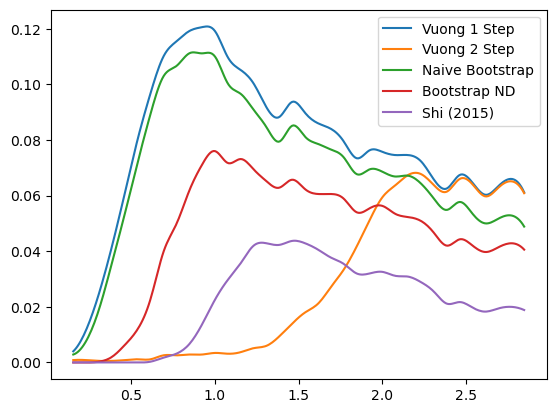

0.1 0.00020562447800032916


In [11]:
nobs =100
data_tuned_c = .8
calc_c =lambda nobs: (nobs**(-1/2), nobs**(-4/7)/350)

c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.89, 5th: 2.11, 10th: 3.52, 30th: 9.69, 50th: 16.45, 70th: 24.94, 90th: 39.73, 95th: 47.17, 99th: 60.16
bonus term 3.1627447999717666 // variance stats 5.2236660062504345 //part1 19.683867298029615 //part2 6.2236660062504345 5.2236660062504345
1.3212464394200696 -1.7401726231510573 4.8064326504245996
-5.004243160523464 -1.7401726231510573 -1.5190569495189334
---
Quantiles: 1th: 0.70, 5th: 1.60, 10th: 2.68, 30th: 8.12, 50th: 14.49, 70th: 21.94, 90th: 35.23, 95th: 42.29, 99th: 55.64
bonus term 3.1211967956573883 // variance stats 3.8888403516649968 //part1 15.259032840097328 //part2 4.888840351664997 3.8888403516649968
1.5663693304561017 -2.017932523253753 4.6280992199377655
-4.676024260858675 -2.017932523253753 -1.614294371377011
---
Quantiles: 1th: 0.65, 5th: 1.62, 10th: 2.68, 30th: 7.65, 50th: 13.13, 70th: 19.86, 90th: 31.69, 95th: 37.98, 99th: 50.12
bonus term 0.3722000213027403 // variance stats 32.332728491602275 //part1 12.406442254652825 //part2 33.33272849160227

Quantiles: 1th: 0.78, 5th: 1.75, 10th: 2.86, 30th: 8.27, 50th: 14.35, 70th: 22.53, 90th: 35.20, 95th: 42.37, 99th: 55.14
bonus term 4.661965796276207 // variance stats 2.4018375822002698 //part1 15.859250452704607 //part2 3.4018375822002698 2.4018375822002698
3.263771847749711 -2.8633712559455797 6.027068507645964
-6.060159744802703 -2.8633712559455797 -3.2968630849064504
---
Quantiles: 1th: 0.63, 5th: 1.79, 10th: 3.10, 30th: 8.49, 50th: 14.76, 70th: 22.83, 90th: 35.94, 95th: 42.36, 99th: 54.43
bonus term 0.9410080734717747 // variance stats 16.31139540199431 //part1 16.290162836338805 //part2 17.31139540199431 16.31139540199431
-0.804756211869095 -0.23000255494366048 2.9179123098891737
-2.6867723588126444 -0.23000255494366048 1.0358961629456243
---
Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.65, 30th: 10.37, 50th: 18.04, 70th: 28.08, 90th: 44.14, 95th: 52.64, 99th: 68.64
bonus term 1.4298599859175185 // variance stats 16.445377800069558 //part1 24.94444765553325 //part2 17.44537780006955

Quantiles: 1th: 0.83, 5th: 2.28, 10th: 3.86, 30th: 10.91, 50th: 19.01, 70th: 28.86, 90th: 46.10, 95th: 54.94, 99th: 71.48
bonus term 1.2708119369437822 // variance stats 19.6621850910118 //part1 26.257751456999646 //part2 20.6621850910118 19.6621850910118
-0.5561085909874758 -0.31392007000774175 3.091101446193114
-3.0977324648750404 -0.31392007000774175 0.5494775723055497
---
Quantiles: 1th: 0.86, 5th: 2.30, 10th: 4.03, 30th: 11.33, 50th: 20.58, 70th: 32.11, 90th: 50.90, 95th: 61.23, 99th: 80.76
bonus term 2.1914363013065303 // variance stats 13.58600094726058 //part1 31.96429196671827 //part2 14.58600094726058 13.58600094726058
0.22700097357471552 -0.8149679026497938 4.17673627228833
-4.155871629038345 -0.8149679026497938 -0.20613633032473092
---
Quantiles: 1th: 0.64, 5th: 1.64, 10th: 2.69, 30th: 7.58, 50th: 13.36, 70th: 20.36, 90th: 32.73, 95th: 38.76, 99th: 52.44
bonus term 0.7015185550143545 // variance stats 17.781896337978008 //part1 13.175848779447726 //part2 18.781896337978008 

Quantiles: 1th: 0.73, 5th: 1.74, 10th: 2.83, 30th: 7.93, 50th: 13.54, 70th: 21.05, 90th: 33.14, 95th: 39.22, 99th: 52.36
bonus term 1.4320516026473487 // variance stats 8.729948640006945 //part1 13.933788543598336 //part2 9.729948640006945 8.729948640006945
-0.42541383688712936 -0.9129958531221452 3.0939531380042076
-3.2895170421818265 -0.9129958531221452 0.22984993270951
---
Quantiles: 1th: 0.72, 5th: 1.78, 10th: 2.88, 30th: 8.21, 50th: 14.48, 70th: 22.42, 90th: 36.37, 95th: 43.56, 99th: 57.49
bonus term 1.0042825755552707 // variance stats 14.723760577407505 //part1 15.791098770093242 //part2 15.723760577407507 14.723760577407505
-0.84229107801225 -0.40224175778163623 2.972766119254153
-2.8508562291227917 -0.40224175778163623 0.964200968143611
---
Quantiles: 1th: 0.78, 5th: 1.79, 10th: 3.14, 30th: 9.21, 50th: 16.52, 70th: 25.36, 90th: 40.46, 95th: 48.07, 99th: 62.73
bonus term 0.7180901319910311 // variance stats 27.672647420249874 //part1 20.58954517053953 //part2 28.672647420249874

Quantiles: 1th: 0.74, 5th: 1.95, 10th: 3.33, 30th: 9.97, 50th: 16.93, 70th: 26.14, 90th: 40.55, 95th: 48.93, 99th: 63.49
bonus term 0.605391233759622 // variance stats 33.435989296945074 //part1 20.847246046210717 //part2 34.435989296945074 33.435989296945074
-1.2424827863568855 0.3029744681520912 2.470944463622944
-2.4532652538761295 0.3029744681520912 1.2601619961037
---
Quantiles: 1th: 0.70, 5th: 1.75, 10th: 3.20, 30th: 8.96, 50th: 15.65, 70th: 24.29, 90th: 38.41, 95th: 46.22, 99th: 58.58
bonus term 1.1038480227124623 // variance stats 15.949371342345703 //part1 18.709530042467577 //part2 16.949371342345707 15.949371342345703
-0.7169268458019853 -0.5874282654385226 3.158489098219339
-2.92462289122691 -0.5874282654385226 0.9507930527944148
---
Quantiles: 1th: 0.75, 5th: 2.05, 10th: 3.50, 30th: 10.01, 50th: 17.57, 70th: 27.03, 90th: 42.58, 95th: 51.46, 99th: 66.51
bonus term 1.0858190571298334 // variance stats 20.125695327999516 //part1 22.938682582260565 //part2 21.12569532799952 20

Quantiles: 1th: 0.55, 5th: 1.59, 10th: 2.76, 30th: 8.75, 50th: 15.00, 70th: 23.28, 90th: 36.62, 95th: 44.03, 99th: 56.89
bonus term 0.8137034776830733 // variance stats 19.625638670323404 //part1 16.783153915476635 //part2 20.625638670323404 19.625638670323404
-0.9986764630493576 -0.14050231841916158 2.955200270810901
-2.626083418415504 -0.14050231841916158 1.327793315444754
---
Quantiles: 1th: 0.76, 5th: 1.84, 10th: 3.35, 30th: 9.76, 50th: 16.87, 70th: 25.69, 90th: 41.04, 95th: 48.27, 99th: 62.30
bonus term 0.4195679228740464 // variance stats 48.09708621738878 //part1 20.599562483397776 //part2 49.09708621738878 48.09708621738878
-1.5730683420622258 0.6173196948667307 2.324248724915162
-2.4122041878103184 0.6173196948667307 1.4851128791670694
---
Quantiles: 1th: 0.64, 5th: 1.85, 10th: 3.26, 30th: 9.16, 50th: 15.87, 70th: 24.63, 90th: 39.32, 95th: 46.95, 99th: 61.02
bonus term 0.7809041494962248 // variance stats 23.868558745959128 //part1 19.419960716710115 //part2 24.868558745959128

Quantiles: 1th: 0.69, 5th: 2.01, 10th: 3.70, 30th: 10.71, 50th: 19.30, 70th: 29.78, 90th: 47.54, 95th: 56.87, 99th: 76.57
bonus term 1.005727190703132 // variance stats 26.088297223471876 //part1 27.24343706749382 //part2 27.088297223471876 26.088297223471876
-0.7507380769839266 -0.12031901208691198 2.863114077001935
-2.7621924583901905 -0.12031901208691198 0.8516596955956707
---
Quantiles: 1th: 0.57, 5th: 1.51, 10th: 2.38, 30th: 7.06, 50th: 12.21, 70th: 18.78, 90th: 30.02, 95th: 35.62, 99th: 47.01
bonus term 0.3239471472540083 // variance stats 32.82996857609347 //part1 10.959121811918225 //part2 33.82996857609347 32.82996857609347
-1.4811900186100007 0.43913567125845887 2.274351166145592
-2.1290843131180175 0.43913567125845887 1.6264568716375758
---
Quantiles: 1th: 0.76, 5th: 2.18, 10th: 3.84, 30th: 12.00, 50th: 21.44, 70th: 33.09, 90th: 52.30, 95th: 62.38, 99th: 81.77
bonus term 2.0385597796876693 // variance stats 15.917252206803818 //part1 34.48682993162273 //part2 16.917252206803

Quantiles: 1th: 0.69, 5th: 2.05, 10th: 3.75, 30th: 11.53, 50th: 20.20, 70th: 31.22, 90th: 49.33, 95th: 58.43, 99th: 77.71
bonus term 0.7211997625782092 // variance stats 40.87704748095394 //part1 30.201716700740374 //part2 41.877047480953934 40.87704748095394
-1.090837880741461 0.2945140478200524 2.7465821202545273
-2.5332374058978795 0.2945140478200524 1.3041825950981087
---
Quantiles: 1th: 0.76, 5th: 1.98, 10th: 3.18, 30th: 8.29, 50th: 14.75, 70th: 22.60, 90th: 35.41, 95th: 42.40, 99th: 55.05
bonus term 2.3188564359760027 // variance stats 5.961871200081416 //part1 16.143579838744763 //part2 6.961871200081415 5.961871200081416
0.5566047087654528 -2.6133519219214185 3.863456091554764
-4.081108163186553 -2.6133519219214185 -0.7742567803972412
---
Quantiles: 1th: 0.68, 5th: 1.52, 10th: 2.70, 30th: 7.73, 50th: 13.22, 70th: 20.08, 90th: 31.85, 95th: 38.44, 99th: 48.43
bonus term 0.39387905117436534 // variance stats 32.055582521212315 //part1 13.019901479471043 //part2 33.055582521212315 

Quantiles: 1th: 0.58, 5th: 1.65, 10th: 3.11, 30th: 9.18, 50th: 15.93, 70th: 24.93, 90th: 39.81, 95th: 46.98, 99th: 62.55
bonus term 1.8869433366404063 // variance stats 9.365803856565048 //part1 19.55968451606684 //part2 10.365803856565048 9.365803856565048
0.20019548572503137 -2.6125688192370418 3.6620960886768756
-3.5736911875557813 -2.6125688192370418 -0.11179058460393662
---
Quantiles: 1th: 0.68, 5th: 1.79, 10th: 3.33, 30th: 9.93, 50th: 17.44, 70th: 26.74, 90th: 42.44, 95th: 50.46, 99th: 65.68
bonus term 0.798113318000158 // variance stats 26.90243461742603 //part1 22.26930467279636 //part2 27.90243461742603 26.90243461742603
-1.0243305150023034 -0.20815887023369425 2.7115005907762737
-2.620557151002619 -0.20815887023369425 1.115273954775958
---
Quantiles: 1th: 0.82, 5th: 1.96, 10th: 3.10, 30th: 8.69, 50th: 15.14, 70th: 23.26, 90th: 36.38, 95th: 43.36, 99th: 57.53
bonus term 1.3760580880449285 // variance stats 11.490883551452056 //part1 17.188181337802963 //part2 12.49088355145205

Quantiles: 1th: 0.87, 5th: 2.00, 10th: 3.22, 30th: 9.30, 50th: 16.35, 70th: 25.27, 90th: 39.17, 95th: 46.48, 99th: 60.90
bonus term 1.0819053549977868 // variance stats 17.58885269981699 //part1 20.111379279197067 //part2 18.58885269981699 17.58885269981699
-0.8596385017787277 -1.2030941114050593 2.9732218986903636
-3.0234492117743015 -1.2030941114050593 0.8094111886947897
---
Quantiles: 1th: 0.83, 5th: 1.91, 10th: 3.02, 30th: 8.79, 50th: 15.43, 70th: 23.75, 90th: 37.34, 95th: 44.35, 99th: 58.93
bonus term 1.087015267041068 // variance stats 15.03364504679201 //part1 17.428816952180316 //part2 16.03364504679201 15.03364504679201
-0.7297392284286521 -1.2996564452789756 2.9768128148736617
-2.9037697625107883 -1.2996564452789756 0.8027822807915259
---
Quantiles: 1th: 0.84, 5th: 2.11, 10th: 3.93, 30th: 12.27, 50th: 21.20, 70th: 32.27, 90th: 51.60, 95th: 62.51, 99th: 80.01
bonus term 2.589617490464442 // variance stats 11.753030503090914 //part1 33.02547084723077 //part2 12.753030503090914 

Quantiles: 1th: 0.78, 5th: 2.03, 10th: 3.81, 30th: 11.62, 50th: 20.84, 70th: 31.72, 90th: 50.05, 95th: 59.73, 99th: 77.95
bonus term 4.272889912567358 // variance stats 6.313184431081361 //part1 31.248431984312198 //part2 7.3131844310813605 6.313184431081361
2.4849290964150765 -3.648980706655869 6.030789356275553
-6.06085072871964 -3.648980706655869 -2.514990468859163
---
Quantiles: 1th: 0.56, 5th: 1.42, 10th: 2.40, 30th: 6.84, 50th: 11.87, 70th: 17.96, 90th: 28.82, 95th: 34.65, 99th: 44.81
bonus term 0.1649733947346769 // variance stats 61.621089416259956 //part1 10.330813702984152 //part2 62.621089416259956 61.621089416259956
-1.8522026445207744 1.2485284334438171 2.196928212791025
-2.182149433990128 1.2485284334438171 1.866981423321671
---
Quantiles: 1th: 1.01, 5th: 2.29, 10th: 3.91, 30th: 11.72, 50th: 19.97, 70th: 30.91, 90th: 48.25, 95th: 56.94, 99th: 72.16
bonus term 1.4121113298464762 // variance stats 19.86268764787807 //part1 29.46043759861675 //part2 20.86268764787807 19.8626

Quantiles: 1th: 0.71, 5th: 1.72, 10th: 2.91, 30th: 8.27, 50th: 14.62, 70th: 22.44, 90th: 35.35, 95th: 41.72, 99th: 56.28
bonus term 1.6595398157091041 // variance stats 8.389845494517681 //part1 15.582822461508833 //part2 9.389845494517681 8.389845494517681
-0.3111190078873223 -2.983384487473055 3.360525925602956
-3.6301986393055308 -2.983384487473055 0.041446294184747365
---
Quantiles: 1th: 0.62, 5th: 1.74, 10th: 3.00, 30th: 8.65, 50th: 15.62, 70th: 24.13, 90th: 38.26, 95th: 44.98, 99th: 59.16
bonus term 0.5839559445809245 // variance stats 30.834605135542596 //part1 18.590006912286526 //part2 31.834605135542596 30.834605135542596
-1.3646558952962073 -0.2203848093923161 2.3842160673034924
-2.532567784458056 -0.2203848093923161 1.216304178141644
---
Quantiles: 1th: 0.66, 5th: 1.76, 10th: 3.10, 30th: 9.34, 50th: 16.03, 70th: 24.86, 90th: 39.27, 95th: 46.41, 99th: 60.96
bonus term 1.753558648589548 // variance stats 9.968252270992378 //part1 19.233473629710634 //part2 10.968252270992378 

Quantiles: 1th: 0.79, 5th: 2.02, 10th: 3.47, 30th: 9.81, 50th: 17.36, 70th: 26.66, 90th: 42.18, 95th: 50.69, 99th: 65.78
bonus term 0.7740077008007002 // variance stats 27.708216965136153 //part1 22.220381007272692 //part2 28.708216965136156 27.708216965136153
-1.066992234910727 -1.0235334302709196 2.621189983991933
-2.6150076365121278 -1.0235334302709196 1.0731745823905328
---
Quantiles: 1th: 0.76, 5th: 1.90, 10th: 3.27, 30th: 9.30, 50th: 15.72, 70th: 24.52, 90th: 38.74, 95th: 46.67, 99th: 60.23
bonus term 0.27596028038493275 // variance stats 67.44615557884396 //part1 18.888420284808507 //part2 68.44615557884396 67.44615557884396
-1.7062497587114152 0.9550184036536591 2.2875534172927674
-2.2581703194812808 0.9550184036536591 1.735632856522902
---
Quantiles: 1th: 0.67, 5th: 2.05, 10th: 3.68, 30th: 10.97, 50th: 19.33, 70th: 29.09, 90th: 46.65, 95th: 54.95, 99th: 71.50
bonus term 1.116247333325583 // variance stats 23.277064665124566 //part1 27.09920869341803 //part2 24.27706466512457 2

Quantiles: 1th: 0.77, 5th: 1.79, 10th: 3.05, 30th: 8.13, 50th: 14.25, 70th: 21.69, 90th: 34.07, 95th: 40.97, 99th: 54.09
bonus term 1.0689137043992198 // variance stats 12.820339179441367 //part1 14.772749948350347 //part2 13.820339179441367 12.820339179441367
-0.7476505170458997 -3.498441904920678 2.7491699038249053
-2.8854779258443393 -3.498441904920678 0.6113424950264658
---
Quantiles: 1th: 0.75, 5th: 1.97, 10th: 3.38, 30th: 9.70, 50th: 16.35, 70th: 25.33, 90th: 39.08, 95th: 47.01, 99th: 62.13
bonus term 0.9753658885416061 // variance stats 19.353520665005806 //part1 19.85212976837333 //part2 20.353520665005806 19.353520665005806
-1.072045999525289 -1.835083739923592 2.6534792051118563
-3.022777776608501 -1.835083739923592 0.7027474280286441
---
Quantiles: 1th: 0.85, 5th: 2.07, 10th: 3.94, 30th: 11.87, 50th: 21.13, 70th: 31.66, 90th: 49.99, 95th: 58.92, 99th: 77.11
bonus term 2.3552367897831354 // variance stats 12.261761918323433 //part1 31.234589567380322 //part2 13.26176191832343

Quantiles: 1th: 0.61, 5th: 1.77, 10th: 3.07, 30th: 9.00, 50th: 16.41, 70th: 25.65, 90th: 41.25, 95th: 48.85, 99th: 64.24
bonus term 1.8581840439149229 // variance stats 10.038626750529323 //part1 20.511800094566023 //part2 11.038626750529323 10.038626750529323
-0.09255584566688736 -4.0791172261317525 3.6094171418388457
-3.8089239334967333 -4.0791172261317525 -0.10695094599100011
---
Quantiles: 1th: 0.88, 5th: 2.15, 10th: 3.57, 30th: 9.95, 50th: 17.08, 70th: 26.13, 90th: 41.67, 95th: 49.63, 99th: 65.67
bonus term 0.4439605403875358 // variance stats 48.10374980040456 //part1 21.80012729644196 //part2 49.10374980040455 48.10374980040456
-1.478075882497802 0.08434470106643654 2.422098976696081
-2.3659969632728735 0.08434470106643654 1.5341778959210095
---
Quantiles: 1th: 0.72, 5th: 1.82, 10th: 3.13, 30th: 9.64, 50th: 17.08, 70th: 26.40, 90th: 42.00, 95th: 49.58, 99th: 66.43
bonus term 0.9783790236575404 // variance stats 21.446839477487494 //part1 21.961516892181752 //part2 22.44683947748

Quantiles: 1th: 0.81, 5th: 2.04, 10th: 3.55, 30th: 9.72, 50th: 16.54, 70th: 25.75, 90th: 40.42, 95th: 47.13, 99th: 63.11
bonus term 2.1020245986223536 // variance stats 8.722663039123455 //part1 20.43727687235387 //part2 9.722663039123455 8.722663039123455
0.306221070594648 -4.029741186012817 3.8374958994550625
-3.897828126650059 -4.029741186012817 -0.3665532977896448
---
Quantiles: 1th: 0.71, 5th: 1.93, 10th: 3.39, 30th: 10.06, 50th: 18.00, 70th: 27.61, 90th: 43.70, 95th: 52.19, 99th: 66.41
bonus term 2.487067879875871 // variance stats 8.414408842815607 //part1 23.41427384098606 //part2 9.414408842815607 8.414408842815607
0.47469601817016693 -5.214946129424669 4.341820924349028
-4.499439741581575 -5.214946129424669 -0.6323148354027142
---
Quantiles: 1th: 0.69, 5th: 1.77, 10th: 2.88, 30th: 7.93, 50th: 13.73, 70th: 21.41, 90th: 33.24, 95th: 40.58, 99th: 54.08
bonus term 0.2715987387228913 // variance stats 50.936462824690395 //part1 14.105877796914243 //part2 51.936462824690395 50.9364

Quantiles: 1th: 0.80, 5th: 1.94, 10th: 3.49, 30th: 10.28, 50th: 17.77, 70th: 27.34, 90th: 43.10, 95th: 51.58, 99th: 65.66
bonus term 0.8737649198945501 // variance stats 25.643116267155467 //part1 23.27982035091228 //part2 26.643116267155467 25.643116267155467
-1.0416702923271353 -1.2072789055570488 2.780820647056718
-2.7892001321162354 -1.2072789055570488 1.0332908072676181
---
Quantiles: 1th: 0.83, 5th: 2.14, 10th: 3.67, 30th: 10.89, 50th: 19.08, 70th: 29.03, 90th: 46.34, 95th: 54.91, 99th: 72.29
bonus term 1.9808875200906813 // variance stats 12.315331966168458 //part1 26.37617491764761 //part2 13.315331966168458 12.315331966168458
-0.008022723403149022 -4.605183873413335 3.8398121935178953
-3.9697977635845114 -4.605183873413335 -0.12196284666346734
---
Quantiles: 1th: 0.63, 5th: 1.55, 10th: 2.70, 30th: 7.50, 50th: 13.16, 70th: 20.87, 90th: 32.42, 95th: 38.61, 99th: 51.52
bonus term 1.167746168232215 // variance stats 10.616852315792677 //part1 13.565534778686434 //part2 11.61685231

Quantiles: 1th: 0.89, 5th: 2.29, 10th: 4.19, 30th: 11.94, 50th: 20.90, 70th: 31.91, 90th: 49.85, 95th: 58.69, 99th: 79.32
bonus term 1.09510129299053 // variance stats 27.639205879845186 //part1 31.362831389240448 //part2 28.639205879845186 27.639205879845186
-0.7943766600997134 -1.5448860803211055 2.9120881856155867
-2.984579246080773 -1.5448860803211055 0.7218855996345268
---
Quantiles: 1th: 0.60, 5th: 1.62, 10th: 2.80, 30th: 8.67, 50th: 15.10, 70th: 23.49, 90th: 37.78, 95th: 44.81, 99th: 58.88
bonus term 0.9470892876229826 // variance stats 18.28382799324975 //part1 18.26350691677104 //part2 19.28382799324975 18.28382799324975
-1.0667798328539886 -2.9709940988281414 2.7901140977166197
-2.9609584080999536 -2.9709940988281414 0.8959355224706547
---
Quantiles: 1th: 0.70, 5th: 1.80, 10th: 2.82, 30th: 8.00, 50th: 14.23, 70th: 22.00, 90th: 36.01, 95th: 42.43, 99th: 54.23
bonus term 1.2541518778538479 // variance stats 11.150232378915401 //part1 15.238236754377377 //part2 12.15023237891540

Quantiles: 1th: 0.65, 5th: 1.59, 10th: 2.62, 30th: 6.99, 50th: 11.69, 70th: 17.83, 90th: 28.11, 95th: 33.92, 99th: 45.27
bonus term 0.45604739837296604 // variance stats 20.372258407328335 //part1 9.746762844016837 //part2 21.372258407328335 20.372258407328335
-1.4472183303677288 -2.2896016719851886 2.3583013532403108
-2.359313127113661 -2.2896016719851886 1.4462065564943785
---
Quantiles: 1th: 0.87, 5th: 2.44, 10th: 4.19, 30th: 11.94, 50th: 21.31, 70th: 32.17, 90th: 51.70, 95th: 61.39, 99th: 80.13
bonus term 0.8953148996622198 // variance stats 35.94787079139965 //part1 33.079979230334644 //part2 36.94787079139965 35.94787079139965
-1.076600562104912 -1.596036445515886 2.8419857840061877
-2.867230361429351 -1.596036445515886 1.051355984681748
---
Quantiles: 1th: 0.85, 5th: 2.11, 10th: 3.83, 30th: 11.15, 50th: 19.74, 70th: 30.44, 90th: 49.01, 95th: 59.44, 99th: 75.84
bonus term 1.940374739002654 // variance stats 14.312958570224358 //part1 29.712877989057546 //part2 15.31295857022436 1

Quantiles: 1th: 0.73, 5th: 1.49, 10th: 2.42, 30th: 6.50, 50th: 11.15, 70th: 17.19, 90th: 27.79, 95th: 32.85, 99th: 41.81
bonus term 0.615564653300692 // variance stats 14.184110483675346 //part1 9.346801705563017 //part2 15.184110483675346 14.184110483675346
-1.3879617130198423 -4.795980953178406 2.4629470915179956
-2.619091019621226 -4.795980953178406 1.231817784916612
---
Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.47, 30th: 9.82, 50th: 16.99, 70th: 26.69, 90th: 41.90, 95th: 49.32, 99th: 65.26
bonus term 0.38968989199989396 // variance stats 55.9298564958793 //part1 22.184989629448665 //part2 56.92985649587929 55.9298564958793
-1.759418847823418 -0.22476181694959246 2.169248737568358
-2.538798631823206 -0.22476181694959246 1.3898689535685702
---
Quantiles: 1th: 0.64, 5th: 1.77, 10th: 3.09, 30th: 8.36, 50th: 14.44, 70th: 21.57, 90th: 34.54, 95th: 41.36, 99th: 55.55
bonus term 1.0547602518780532 // variance stats 12.800507685182144 //part1 14.556226962067726 //part2 13.800507685182144 12.

Quantiles: 1th: 0.76, 5th: 1.99, 10th: 3.35, 30th: 9.72, 50th: 16.85, 70th: 25.73, 90th: 40.68, 95th: 49.27, 99th: 64.32
bonus term 0.45602418514965515 // variance stats 43.98861722840701 //part1 20.515897512594044 //part2 44.98861722840701 43.98861722840701
-1.5387641202805369 -1.060772146799792 2.260493352719241
-2.450812490579847 -1.060772146799792 1.3484449824199305
---
Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.21, 30th: 8.90, 50th: 15.81, 70th: 25.15, 90th: 39.83, 95th: 47.28, 99th: 62.00
bonus term 1.1463468036936506 // variance stats 16.562486463522347 //part1 20.13270022237185 //part2 17.562486463522347 16.562486463522347
-0.8484114194420126 -4.521493764078396 3.0971629699025796
-3.141105026829314 -4.521493764078396 0.8044693625152783
---
Quantiles: 1th: 0.84, 5th: 1.96, 10th: 3.55, 30th: 10.14, 50th: 17.65, 70th: 27.53, 90th: 44.50, 95th: 53.24, 99th: 71.94
bonus term 1.8927883931841363 // variance stats 12.160766523500673 //part1 24.91054612108841 //part2 13.160766523500673 12

Quantiles: 1th: 0.77, 5th: 1.95, 10th: 3.29, 30th: 8.73, 50th: 15.48, 70th: 23.84, 90th: 38.09, 95th: 45.69, 99th: 60.57
bonus term 1.203776063125148 // variance stats 13.894358598521936 //part1 17.929472356502934 //part2 14.894358598521936 13.894358598521936
-0.9296061822048416 -5.7628844816559415 3.0690865605476585
-3.337158308455138 -5.7628844816559415 0.6615344342973625
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.33, 30th: 9.23, 50th: 16.18, 70th: 25.47, 90th: 41.27, 95th: 48.68, 99th: 64.82
bonus term 0.3399424217695851 // variance stats 61.056938384136814 //part1 21.09578592190939 //part2 62.05693838413681 61.056938384136814
-1.632571386047353 0.16489768601513058 2.2415520321821663
-2.3124562295865236 0.16489768601513058 1.5616671886429963
---
Quantiles: 1th: 0.65, 5th: 1.56, 10th: 2.59, 30th: 6.96, 50th: 11.89, 70th: 17.83, 90th: 29.22, 95th: 35.16, 99th: 48.03
bonus term 0.21078645190579923 // variance stats 48.42292982861467 //part1 10.417684021362977 //part2 49.4229298286146

Quantiles: 1th: 0.70, 5th: 1.74, 10th: 3.33, 30th: 9.69, 50th: 16.64, 70th: 25.64, 90th: 40.27, 95th: 47.70, 99th: 62.24
bonus term 1.1671179709845971 // variance stats 16.63988971607148 //part1 20.58783229381341 //part2 17.639889716071483 16.63988971607148
-0.8313201721849516 -5.349699507400431 3.0216624461130674
-3.1655561141541457 -5.349699507400431 0.6874265041438732
---
Quantiles: 1th: 0.69, 5th: 1.73, 10th: 3.27, 30th: 9.21, 50th: 16.23, 70th: 24.49, 90th: 39.72, 95th: 47.54, 99th: 61.39
bonus term 0.4565715770506159 // variance stats 40.82631652036891 //part1 19.096707295923064 //part2 41.826316520368906 40.82631652036891
-1.4099012034676668 -1.7914456106819636 2.291025036058456
-2.323044357568899 -1.7914456106819636 1.3778818819572245
---
Quantiles: 1th: 1.09, 5th: 2.39, 10th: 3.94, 30th: 11.69, 50th: 20.77, 70th: 31.81, 90th: 50.12, 95th: 59.08, 99th: 78.99
bonus term 1.616354409039838 // variance stats 18.712951787513564 //part1 31.86311653693731 //part2 19.712951787513568 18

Quantiles: 1th: 0.76, 5th: 2.06, 10th: 3.55, 30th: 10.33, 50th: 17.95, 70th: 27.06, 90th: 43.48, 95th: 52.18, 99th: 70.00
bonus term 1.582869161006047 // variance stats 13.991068083441327 //part1 23.728899359821302 //part2 14.991068083441327 13.991068083441327
-0.28055250505525564 -6.4161428017212385 3.382259957649138
-3.44629082706735 -6.4161428017212385 0.21652163563704388
---
Quantiles: 1th: 0.64, 5th: 1.60, 10th: 2.84, 30th: 8.09, 50th: 13.86, 70th: 21.36, 90th: 33.32, 95th: 40.82, 99th: 51.99
bonus term 0.8480970899012645 // variance stats 16.017875685694303 //part1 14.432810845338825 //part2 17.017875685694303 16.017875685694303
-1.5204895763559034 -7.078900472942377 2.8805686128830765
-3.216683756158432 -7.078900472942377 1.1843744330805477
---
Quantiles: 1th: 0.72, 5th: 1.72, 10th: 3.13, 30th: 9.28, 50th: 16.39, 70th: 25.66, 90th: 41.09, 95th: 48.69, 99th: 64.12
bonus term 0.9549088254775987 // variance stats 20.569191611433695 //part1 20.596611428175425 //part2 21.569191611433

Quantiles: 1th: 0.77, 5th: 1.82, 10th: 3.12, 30th: 9.39, 50th: 16.30, 70th: 24.86, 90th: 39.25, 95th: 46.94, 99th: 61.32
bonus term 0.4021365356983339 // variance stats 47.16360482419929 //part1 19.368345190747064 //part2 48.16360482419928 47.16360482419929
-1.479387998984733 -1.1671387729627176 2.3662778011363934
-2.283661070381401 -1.1671387729627176 1.5620047297397257
---
Quantiles: 1th: 0.84, 5th: 2.01, 10th: 3.28, 30th: 9.13, 50th: 15.95, 70th: 24.28, 90th: 39.07, 95th: 46.75, 99th: 63.88
bonus term 1.1093716420384923 // variance stats 16.034135902356464 //part1 18.897187316704027 //part2 17.034135902356464 16.034135902356464
-0.9219221063584766 -5.61772676521521 3.063750669353609
-3.1406653904354607 -5.61772676521521 0.845007385276625
---
Quantiles: 1th: 0.68, 5th: 1.77, 10th: 3.00, 30th: 9.03, 50th: 15.48, 70th: 24.02, 90th: 37.91, 95th: 45.53, 99th: 59.83
bonus term 0.6965032706845588 // variance stats 24.788314356626763 //part1 17.961645294832103 //part2 25.788314356626763 24.

Quantiles: 1th: 0.64, 5th: 1.80, 10th: 3.17, 30th: 9.79, 50th: 17.33, 70th: 26.72, 90th: 42.21, 95th: 50.82, 99th: 66.64
bonus term 1.2759218175494553 // variance stats 16.383529189070888 //part1 22.18002415834334 //part2 17.38352918907089 16.383529189070888
-0.8251901515126684 -5.811453164027463 3.427164455776853
-3.377033786611579 -5.811453164027463 0.8753208206779423
---
Quantiles: 1th: 0.85, 5th: 2.25, 10th: 3.84, 30th: 10.90, 50th: 18.99, 70th: 29.44, 90th: 47.65, 95th: 57.83, 99th: 75.50
bonus term 1.2366958908684011 // variance stats 21.792254533415054 //part1 28.187087525101084 //part2 22.792254533415054 21.792254533415054
-0.6933328524325194 -5.547151577544365 3.1710381060903137
-3.166724634169322 -5.547151577544365 0.6976463243535117
---
Quantiles: 1th: 0.64, 5th: 1.75, 10th: 2.93, 30th: 8.12, 50th: 14.22, 70th: 21.76, 90th: 34.02, 95th: 40.85, 99th: 56.14
bonus term 0.3572386937450595 // variance stats 40.60312533991636 //part1 14.862246152143705 //part2 41.60312533991636 40

Quantiles: 1th: 0.78, 5th: 2.26, 10th: 4.23, 30th: 13.32, 50th: 23.45, 70th: 35.27, 90th: 56.69, 95th: 67.45, 99th: 87.67
bonus term 2.5980121779769063 // variance stats 14.445572833072454 //part1 40.1277863161515 //part2 15.445572833072454 14.445572833072454
0.43780087714811583 -7.99800966172455 4.652672224444697
-4.758223478805697 -7.99800966172455 -0.5433521315091154
---
Quantiles: 1th: 0.83, 5th: 2.13, 10th: 3.65, 30th: 11.17, 50th: 19.93, 70th: 30.56, 90th: 47.76, 95th: 58.06, 99th: 75.91
bonus term 1.6108343837485892 // variance stats 16.95511321080695 //part1 28.922713724066373 //part2 17.955113210806953 16.95511321080695
-0.8046530949298981 -7.858109767677395 3.607850107485826
-4.026321862427077 -7.858109767677395 0.38618133998864795
---
Quantiles: 1th: 0.73, 5th: 1.83, 10th: 3.19, 30th: 8.97, 50th: 15.15, 70th: 23.35, 90th: 36.90, 95th: 45.23, 99th: 60.37
bonus term 0.8484484437517485 // variance stats 18.95957610063775 //part1 16.934671280530694 //part2 19.959576100637754 18.

Quantiles: 1th: 0.75, 5th: 1.97, 10th: 3.57, 30th: 10.06, 50th: 17.62, 70th: 26.47, 90th: 42.23, 95th: 50.69, 99th: 66.96
bonus term 1.1233573069147937 // variance stats 18.0008434237813 //part1 21.344736297648634 //part2 19.0008434237813 18.0008434237813
-1.153490786409454 -6.181307400544347 3.024334237156101
-3.400205400239041 -6.181307400544347 0.7776196233265137
---
Quantiles: 1th: 0.74, 5th: 1.95, 10th: 3.59, 30th: 10.71, 50th: 18.69, 70th: 28.38, 90th: 46.12, 95th: 55.03, 99th: 71.59
bonus term 0.7874647232221853 // variance stats 32.87295368447707 //part1 26.673756097864636 //part2 33.87295368447707 32.87295368447707
-1.348482356538686 -3.32641718317719 2.6238160542856934
-2.9234118029830563 -3.32641718317719 1.0488866078413224
---
Quantiles: 1th: 0.56, 5th: 1.50, 10th: 2.64, 30th: 7.30, 50th: 12.98, 70th: 20.16, 90th: 31.69, 95th: 37.70, 99th: 49.42
bonus term 0.6710920581809501 // variance stats 17.775003042575115 //part1 12.599755434195334 //part2 18.775003042575115 17.775003

Quantiles: 1th: 0.63, 5th: 1.70, 10th: 2.92, 30th: 8.64, 50th: 14.69, 70th: 22.24, 90th: 35.26, 95th: 41.79, 99th: 55.25
bonus term 0.3779168051804174 // variance stats 39.47677963874236 //part1 15.296855245065283 //part2 40.47677963874236 39.47677963874236
-1.5887979415960047 -3.415834247356015 2.26147898476964
-2.3446315519568395 -3.415834247356015 1.5056453744088052
---
Quantiles: 1th: 0.75, 5th: 2.09, 10th: 3.74, 30th: 10.01, 50th: 18.10, 70th: 27.86, 90th: 43.14, 95th: 51.00, 99th: 69.36
bonus term 0.9901233785256783 // variance stats 23.07368330434717 //part1 23.835916646857434 //part2 24.073683304347174 23.07368330434717
-1.4644740201089914 -6.241287730692875 2.823300552487711
-3.4447207771603483 -6.241287730692875 0.8430537954363541
---
Quantiles: 1th: 0.72, 5th: 1.72, 10th: 2.94, 30th: 7.96, 50th: 13.80, 70th: 20.75, 90th: 33.43, 95th: 40.42, 99th: 53.25
bonus term 0.45370289221573995 // variance stats 29.43009901682824 //part1 13.806223934346317 //part2 30.43009901682824 29.4

Quantiles: 1th: 0.57, 5th: 1.63, 10th: 3.00, 30th: 8.93, 50th: 15.76, 70th: 24.16, 90th: 38.35, 95th: 45.37, 99th: 60.01
bonus term 0.48585488065032945 // variance stats 37.31180613672968 //part1 18.613977998059358 //part2 38.311806136729686 37.31180613672968
-1.625030636807521 -2.868157713330563 2.411588123803299
-2.5967403981081794 -2.868157713330563 1.43987836250264
---
Quantiles: 1th: 0.67, 5th: 1.88, 10th: 3.43, 30th: 9.77, 50th: 16.82, 70th: 26.01, 90th: 40.94, 95th: 48.50, 99th: 65.17
bonus term 0.32450572561746405 // variance stats 62.66290654789151 //part1 20.65897768424033 //part2 63.6629065478915 62.66290654789151
-1.6169342838819976 -1.7450170527575952 2.2430065223171356
-2.2659457351169254 -1.7450170527575952 1.5939950710822073
---
Quantiles: 1th: 0.95, 5th: 2.47, 10th: 4.54, 30th: 13.10, 50th: 22.96, 70th: 35.65, 90th: 55.93, 95th: 66.57, 99th: 86.38
bonus term 1.958150320422781 // variance stats 19.181787083347146 //part1 39.51897284396056 //part2 20.181787083347146 19.1

Quantiles: 1th: 0.62, 5th: 1.63, 10th: 2.86, 30th: 8.40, 50th: 14.55, 70th: 22.09, 90th: 34.93, 95th: 40.94, 99th: 54.13
bonus term 0.46775992439820335 // variance stats 32.01985220605419 //part1 15.445363571543755 //part2 33.01985220605419 32.01985220605419
-1.840146889103484 -4.500188241175549 2.327048584829694
-2.7756667378998907 -4.500188241175549 1.3915287360332873
---
Quantiles: 1th: 0.75, 5th: 2.08, 10th: 3.68, 30th: 10.83, 50th: 18.98, 70th: 29.48, 90th: 47.43, 95th: 55.13, 99th: 72.70
bonus term 0.8802308272512951 // variance stats 30.024705210827705 //part1 27.308901932954438 //part2 31.024705210827705 30.024705210827705
-1.7461417564083528 -5.375239959125136 2.958855072382381
-3.506603410910943 -5.375239959125136 1.198393417879791
---
Quantiles: 1th: 0.78, 5th: 2.15, 10th: 3.74, 30th: 11.30, 50th: 19.79, 70th: 30.12, 90th: 46.65, 95th: 56.00, 99th: 70.97
bonus term 1.4229806367358193 // variance stats 18.935379872174366 //part1 28.367659544077117 //part2 19.93537987217437 18

Quantiles: 1th: 0.84, 5th: 1.95, 10th: 3.49, 30th: 9.84, 50th: 16.73, 70th: 26.07, 90th: 40.36, 95th: 47.43, 99th: 61.76
bonus term 1.005828383198257 // variance stats 19.639998276160995 //part1 20.760296095325824 //part2 20.639998276160995 19.639998276160995
-1.337235922447918 -7.714306295785273 3.0280083740753656
-3.3488926888444324 -7.714306295785273 1.0163516076788515
---
Quantiles: 1th: 0.57, 5th: 1.53, 10th: 2.71, 30th: 8.11, 50th: 14.11, 70th: 21.40, 90th: 33.80, 95th: 39.88, 99th: 53.26
bonus term 0.4120709491071507 // variance stats 33.57307028519205 //part1 14.24655788596732 //part2 34.57307028519205 33.57307028519205
-1.7303368013590612 -5.381531220837161 2.3248915282987874
-2.5544786995733624 -5.381531220837161 1.500749630084486
---
Quantiles: 1th: 0.63, 5th: 1.68, 10th: 2.98, 30th: 9.01, 50th: 15.57, 70th: 23.98, 90th: 37.87, 95th: 46.16, 99th: 58.66
bonus term 0.9131941096026146 // variance stats 18.69468007602888 //part1 17.985065835937547 //part2 19.69468007602888 18.69

Quantiles: 1th: 0.69, 5th: 1.79, 10th: 3.05, 30th: 8.76, 50th: 15.13, 70th: 23.73, 90th: 37.28, 95th: 43.72, 99th: 59.77
bonus term 0.9081300590422633 // variance stats 18.37846973952121 //part1 17.598170868700112 //part2 19.378469739521215 18.37846973952121
-1.8703341349587415 -9.239967026089419 2.967513381250365
-3.686594253043268 -9.239967026089419 1.1512532631658383
---
Quantiles: 1th: 0.65, 5th: 1.62, 10th: 2.90, 30th: 8.30, 50th: 14.43, 70th: 22.11, 90th: 36.08, 95th: 42.86, 99th: 55.87
bonus term 0.8293871706761391 // variance stats 18.405004448646373 //part1 16.09426173662071 //part2 19.405004448646373 18.405004448646373
-1.7998647577577207 -8.158910894033971 2.907107935175182
-3.4586390991099987 -8.158910894033971 1.2483335938229039
---
Quantiles: 1th: 0.70, 5th: 1.98, 10th: 3.50, 30th: 10.14, 50th: 17.84, 70th: 27.05, 90th: 43.36, 95th: 51.79, 99th: 68.73
bonus term 0.5274362592349072 // variance stats 41.74516860926737 //part1 22.54535183163736 //part2 42.74516860926737 41.7

Quantiles: 1th: 0.67, 5th: 2.02, 10th: 3.45, 30th: 10.08, 50th: 18.15, 70th: 28.30, 90th: 43.48, 95th: 51.91, 99th: 69.32
bonus term 0.7754617331646693 // variance stats 30.398594447130648 //part1 24.348408468906495 //part2 31.398594447130648 30.398594447130648
-1.6147713433757753 -5.524440638532115 2.8908304356386876
-3.1656948097051143 -5.524440638532115 1.3399069693093488
---
Quantiles: 1th: 0.75, 5th: 2.17, 10th: 3.75, 30th: 11.06, 50th: 19.17, 70th: 29.45, 90th: 46.18, 95th: 56.05, 99th: 75.08
bonus term 1.0418239074034192 // variance stats 25.253293543177648 //part1 27.351308861362288 //part2 26.253293543177648 25.253293543177648
-1.2389132763421336 -8.442671678566295 2.9428497906333555
-3.322561091148972 -8.442671678566295 0.8592019758265174
---
Quantiles: 1th: 0.75, 5th: 1.84, 10th: 3.11, 30th: 8.51, 50th: 14.48, 70th: 22.19, 90th: 34.75, 95th: 42.00, 99th: 55.17
bonus term 0.6785030132708414 // variance stats 21.716842110461243 //part1 15.413445823945896 //part2 22.71684211046

Quantiles: 1th: 0.73, 5th: 1.92, 10th: 3.16, 30th: 8.79, 50th: 15.08, 70th: 23.54, 90th: 37.06, 95th: 44.13, 99th: 57.07
bonus term 0.316421582270451 // variance stats 52.19535301473405 //part1 16.83215777035735 //part2 53.195353014734046 52.19535301473405
-1.8203292820223769 -3.730630969769538 2.2599627884745424
-2.4531724465632787 -3.730630969769538 1.6271196239336405
---
Quantiles: 1th: 0.65, 5th: 1.78, 10th: 2.90, 30th: 8.43, 50th: 14.80, 70th: 22.99, 90th: 36.46, 95th: 43.30, 99th: 56.69
bonus term 0.40239884019646927 // variance stats 39.98721793921864 //part1 16.4932089616215 //part2 40.98721793921864 39.98721793921864
-1.9719212179617267 -4.452685853242241 2.282200741838329
-2.776718898354665 -4.452685853242241 1.4774030614453906
---
Quantiles: 1th: 0.79, 5th: 2.13, 10th: 3.55, 30th: 10.09, 50th: 17.49, 70th: 26.96, 90th: 42.61, 95th: 51.67, 99th: 66.74
bonus term 0.7854097915218806 // variance stats 28.31705021090609 //part1 23.02589829418426 //part2 29.31705021090609 28.31705

Quantiles: 1th: 0.73, 5th: 2.00, 10th: 3.54, 30th: 10.16, 50th: 17.75, 70th: 27.07, 90th: 42.48, 95th: 50.32, 99th: 64.85
bonus term 1.119362946574821 // variance stats 18.77410643306787 //part1 22.13440204280297 //part2 19.77410643306787 18.77410643306787
-1.32170798123513 -11.00223701795452 3.0169495111686038
-3.560433874384772 -11.00223701795452 0.7782236180189621
---
Quantiles: 1th: 0.79, 5th: 2.07, 10th: 3.45, 30th: 9.85, 50th: 17.29, 70th: 26.32, 90th: 42.05, 95th: 50.09, 99th: 65.95
bonus term 0.48771785074893953 // variance stats 44.32210683938469 //part1 22.10440053911851 //part2 45.32210683938469 44.32210683938469
-1.576564308395459 -4.475220884992775 2.357877987987038
-2.552000009893338 -4.475220884992775 1.3824422864891592
---
Quantiles: 1th: 0.65, 5th: 1.87, 10th: 3.27, 30th: 10.10, 50th: 18.20, 70th: 27.53, 90th: 43.67, 95th: 51.99, 99th: 67.12
bonus term 1.1349485183019519 // variance stats 20.661765509072957 //part1 24.58498866832668 //part2 21.661765509072957 20.661765

Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.23, 30th: 9.43, 50th: 16.69, 70th: 26.33, 90th: 41.88, 95th: 49.00, 99th: 63.84
bonus term 0.4379905790581521 // variance stats 49.4138729022753 //part1 22.080801385031638 //part2 50.413872902275294 49.4138729022753
-1.8303069507152392 -4.129724532315777 2.2799020944256063
-2.7062881088315436 -4.129724532315777 1.4039209363093017
---
Quantiles: 1th: 0.66, 5th: 1.88, 10th: 3.27, 30th: 9.99, 50th: 17.62, 70th: 27.00, 90th: 43.47, 95th: 52.17, 99th: 67.76
bonus term 1.1960129610328503 // variance stats 18.726390968128868 //part1 23.593019272283485 //part2 19.72639096812887 18.726390968128868
-1.6691998858014316 -11.20989429043834 3.253775633133323
-4.061225807867132 -11.20989429043834 0.8617497110676224
---
Quantiles: 1th: 0.67, 5th: 1.97, 10th: 3.38, 30th: 10.12, 50th: 17.65, 70th: 27.51, 90th: 43.73, 95th: 52.51, 99th: 68.95
bonus term 0.383125573880611 // variance stats 59.94187928789823 //part1 23.34839247553893 //part2 60.941879287898225 59.94

Quantiles: 1th: 0.77, 5th: 1.99, 10th: 3.16, 30th: 8.31, 50th: 14.87, 70th: 22.96, 90th: 36.07, 95th: 42.96, 99th: 55.25
bonus term 0.43611628115080814 // variance stats 36.66810742032635 //part1 16.42767492614189 //part2 37.66810742032635 36.66810742032635
-1.9373329216697595 -6.609299988436836 2.4425811527504013
-2.809565483971376 -6.609299988436836 1.570348590448785
---
Quantiles: 1th: 0.63, 5th: 1.78, 10th: 3.02, 30th: 8.14, 50th: 14.41, 70th: 22.08, 90th: 34.58, 95th: 42.42, 99th: 54.86
bonus term 0.3676852068226317 // variance stats 39.655747321909644 //part1 14.948516862585 //part2 40.65574732190964 39.655747321909644
-1.8412522544957415 -5.099088379607796 2.196429824511013
-2.576622668141005 -5.099088379607796 1.4610594108657493
---
Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.30, 30th: 9.53, 50th: 16.32, 70th: 24.86, 90th: 40.04, 95th: 48.36, 99th: 64.05
bonus term 0.43556906834509407 // variance stats 44.547137048996525 //part1 19.83892405021773 //part2 45.54713704899652 44.54713

Quantiles: 1th: 0.78, 5th: 1.87, 10th: 3.11, 30th: 8.68, 50th: 15.33, 70th: 23.51, 90th: 36.80, 95th: 43.92, 99th: 56.67
bonus term 0.6095248679847167 // variance stats 27.0978327610731 //part1 17.12632780434973 //part2 28.097832761073104 27.0978327610731
-1.7495943230130184 -7.782208443252434 2.549115227468264
-2.9686440589824517 -7.782208443252434 1.3300654914988306
---
Quantiles: 1th: 0.78, 5th: 2.09, 10th: 3.63, 30th: 10.06, 50th: 17.67, 70th: 27.09, 90th: 43.40, 95th: 51.16, 99th: 68.09
bonus term 0.7803422496557026 // variance stats 29.542331589835126 //part1 23.833471742542375 //part2 30.542331589835126 29.542331589835126
-1.5901121269017255 -7.396361374958719 3.038126270175547
-3.1507966262131304 -7.396361374958719 1.4774417708641419
---
Quantiles: 1th: 0.48, 5th: 1.45, 10th: 2.57, 30th: 7.33, 50th: 13.06, 70th: 20.62, 90th: 32.78, 95th: 39.13, 99th: 51.29
bonus term 0.36585946634314576 // variance stats 35.881868525941684 //part1 13.493580736639089 //part2 36.881868525941684 3

Quantiles: 1th: 0.87, 5th: 2.13, 10th: 3.65, 30th: 10.05, 50th: 17.50, 70th: 26.68, 90th: 42.24, 95th: 51.21, 99th: 65.72
bonus term 0.6921175369208941 // variance stats 30.89257348677977 //part1 22.073409407738627 //part2 31.89257348677977 30.89257348677977
-1.7651404905673034 -8.655954332538832 2.879975522987144
-3.1493755644090915 -8.655954332538832 1.4957404491453559
---
Quantiles: 1th: 0.63, 5th: 1.61, 10th: 2.73, 30th: 7.97, 50th: 13.84, 70th: 20.63, 90th: 32.51, 95th: 38.85, 99th: 52.00
bonus term 0.524587049128261 // variance stats 24.405187316079303 //part1 13.327232246692766 //part2 25.405187316079303 24.405187316079303
-2.4444321793550814 -11.411580232477943 2.927964241210574
-3.4936062776116033 -11.411580232477943 1.8787901429540521
---
Quantiles: 1th: 0.66, 5th: 1.64, 10th: 2.74, 30th: 7.94, 50th: 14.05, 70th: 21.50, 90th: 34.51, 95th: 41.04, 99th: 55.55
bonus term 0.5204918020784375 // variance stats 27.70738452414807 //part1 14.941958303932473 //part2 28.70738452414807 2

Quantiles: 1th: 0.87, 5th: 2.20, 10th: 3.86, 30th: 10.97, 50th: 18.56, 70th: 28.28, 90th: 44.54, 95th: 51.93, 99th: 66.67
bonus term 0.5605409238970459 // variance stats 42.90004667158815 //part1 24.607772720415454 //part2 43.90004667158814 42.90004667158815
-1.9438286888977994 -6.302975322291 2.426317692709317
-3.0649105366918916 -6.302975322291 1.305235844915225
---
Quantiles: 1th: 0.94, 5th: 2.15, 10th: 3.86, 30th: 11.94, 50th: 21.01, 70th: 31.61, 90th: 50.83, 95th: 61.96, 99th: 82.03
bonus term 0.5019168125071141 // variance stats 64.95782763834463 //part1 33.105342608131565 //part2 65.95782763834463 64.95782763834463
-1.4712877823198864 -3.678978682149205 2.3492931797427845
-2.4751214073341146 -3.678978682149205 1.3454595547285568
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 2.97, 30th: 8.35, 50th: 14.56, 70th: 22.93, 90th: 36.14, 95th: 42.74, 99th: 55.75
bonus term 0.6525824802448007 // variance stats 24.255736606521804 //part1 16.481451235093406 //part2 25.255736606521808 24.25573

Quantiles: 1th: 0.67, 5th: 1.72, 10th: 2.99, 30th: 8.40, 50th: 14.29, 70th: 21.99, 90th: 34.74, 95th: 41.48, 99th: 53.47
bonus term 0.4552280928957059 // variance stats 32.56741168725326 //part1 15.280828805833332 //part2 33.56741168725326 32.56741168725326
-2.1571953811614244 -9.333938705153562 2.46886783583226
-3.067651566952836 -9.333938705153562 1.5584116500408483
---
Quantiles: 1th: 0.56, 5th: 1.69, 10th: 3.05, 30th: 9.34, 50th: 16.58, 70th: 25.16, 90th: 39.58, 95th: 47.11, 99th: 61.41
bonus term 0.40074477983255924 // variance stats 48.48026040828441 //part1 19.82895606337563 //part2 49.48026040828441 48.48026040828441
-1.9970078788034358 -6.222230605131242 2.474459039000427
-2.7984974384685546 -6.222230605131242 1.6729694793353085
---
Quantiles: 1th: 0.75, 5th: 1.77, 10th: 2.95, 30th: 8.51, 50th: 14.85, 70th: 22.93, 90th: 35.54, 95th: 42.22, 99th: 54.51
bonus term 0.6080620315868867 // variance stats 25.992508096166812 //part1 16.41311931058068 //part2 26.992508096166816 25.9925

Quantiles: 1th: 0.78, 5th: 2.05, 10th: 3.34, 30th: 9.30, 50th: 16.03, 70th: 24.21, 90th: 39.13, 95th: 46.50, 99th: 61.75
bonus term 0.6927414940167574 // variance stats 25.503168184183494 //part1 18.359844324088666 //part2 26.503168184183497 25.503168184183494
-2.700960714345659 -10.580166268583225 2.9866373145913228
-4.0864437023791735 -10.580166268583225 1.6011543265578077
---
Quantiles: 1th: 0.67, 5th: 1.68, 10th: 3.03, 30th: 9.59, 50th: 16.70, 70th: 26.04, 90th: 41.61, 95th: 49.90, 99th: 64.29
bonus term 0.5376375378112207 // variance stats 38.505178018683715 //part1 21.23946664075907 //part2 39.505178018683715 38.505178018683715
-2.182761872259247 -8.53979624450151 2.684675947357225
-3.258036947881688 -8.53979624450151 1.609400871734784
---
Quantiles: 1th: 0.76, 5th: 1.98, 10th: 3.59, 30th: 10.66, 50th: 18.61, 70th: 29.71, 90th: 46.59, 95th: 55.12, 99th: 72.85
bonus term 1.0203694160117025 // variance stats 25.72223292692715 //part1 27.26654920617734 //part2 26.72223292692715 25.7

Quantiles: 1th: 0.69, 5th: 1.78, 10th: 3.35, 30th: 9.75, 50th: 17.09, 70th: 26.78, 90th: 41.78, 95th: 49.25, 99th: 63.82
bonus term 0.3491024443685819 // variance stats 61.83411514582488 //part1 21.9355431871444 //part2 62.83411514582488 61.83411514582488
-1.5446265391910134 -4.26880805826411 2.196067789942473
-2.242831427928177 -4.26880805826411 1.4978629012053093
---
Quantiles: 1th: 0.70, 5th: 1.69, 10th: 2.89, 30th: 8.54, 50th: 14.68, 70th: 22.74, 90th: 35.57, 95th: 41.92, 99th: 55.05
bonus term 0.5295271174983895 // variance stats 28.959510632944752 //part1 15.864373307125588 //part2 29.959510632944752 28.959510632944752
-2.1347257407278555 -10.460491647192143 2.8250549791711115
-3.1937799757246346 -10.460491647192143 1.7660007441743326
---
Quantiles: 1th: 0.54, 5th: 1.59, 10th: 2.82, 30th: 8.12, 50th: 14.27, 70th: 21.76, 90th: 34.56, 95th: 41.44, 99th: 54.78
bonus term 0.45873619330962206 // variance stats 31.56162558339799 //part1 14.937196168101197 //part2 32.56162558339799 31.5

Quantiles: 1th: 0.70, 5th: 1.74, 10th: 2.94, 30th: 8.54, 50th: 15.27, 70th: 23.01, 90th: 36.67, 95th: 44.50, 99th: 58.60
bonus term 0.5966295049260175 // variance stats 26.819091024343237 //part1 16.597690505345724 //part2 27.819091024343237 26.819091024343237
-2.044184464126532 -12.51395944004919 2.8445826464594757
-3.237443473978567 -12.51395944004919 1.6513236366074404
---
Quantiles: 1th: 0.86, 5th: 1.99, 10th: 3.30, 30th: 9.59, 50th: 16.43, 70th: 25.38, 90th: 40.60, 95th: 47.82, 99th: 64.63
bonus term 0.5925883660092474 // variance stats 33.04934803834072 //part1 20.1772475177205 //part2 34.049348038340725 33.04934803834072
-1.6325326037341867 -7.925031774480113 2.5853881054349293
-2.817709335752682 -7.925031774480113 1.4002113734164343
---
Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.38, 30th: 9.78, 50th: 17.03, 70th: 25.84, 90th: 40.91, 95th: 48.92, 99th: 63.58
bonus term 0.5117578278213152 // variance stats 39.03536656115976 //part1 20.488412227369235 //part2 40.03536656115976 39.03

Quantiles: 1th: 0.67, 5th: 1.94, 10th: 3.25, 30th: 9.95, 50th: 16.85, 70th: 25.86, 90th: 41.21, 95th: 48.60, 99th: 63.99
bonus term 0.37720386965948394 // variance stats 53.41434252017842 //part1 20.525300563587894 //part2 54.41434252017842 53.41434252017842
-2.5515043175981083 -6.173948361797942 2.431157135952932
-3.3059120569170757 -6.173948361797942 1.676749396633964
---
Quantiles: 1th: 0.72, 5th: 1.68, 10th: 2.77, 30th: 7.93, 50th: 13.88, 70th: 21.45, 90th: 34.18, 95th: 40.15, 99th: 51.82
bonus term 0.5155712614422195 // variance stats 27.52910262861991 //part1 14.70878543005211 //part2 28.52910262861991 27.52910262861991
-2.297480230329602 -12.115949455841573 2.6990136225197436
-3.3286227532140407 -12.115949455841573 1.6678710996353048
---
Quantiles: 1th: 0.68, 5th: 1.95, 10th: 3.35, 30th: 9.59, 50th: 15.89, 70th: 24.36, 90th: 38.79, 95th: 46.97, 99th: 61.99
bonus term 0.5112444269741848 // variance stats 34.88103801604316 //part1 18.34398071975093 //part2 35.88103801604316 34.881

Quantiles: 1th: 0.89, 5th: 2.03, 10th: 3.43, 30th: 10.33, 50th: 18.35, 70th: 28.10, 90th: 44.35, 95th: 52.47, 99th: 68.69
bonus term 0.6325646452692274 // variance stats 38.03620115969324 //part1 24.69292073923956 //part2 39.03620115969324 38.03620115969324
-2.0073825722429803 -10.785562997710388 2.7329619788679844
-3.272511862781435 -10.785562997710388 1.4678326883295298
---
Quantiles: 1th: 0.75, 5th: 2.06, 10th: 3.79, 30th: 11.67, 50th: 20.16, 70th: 30.85, 90th: 48.91, 95th: 58.00, 99th: 73.90
bonus term 0.8990357985815508 // variance stats 31.284074974722657 //part1 29.024539126366445 //part2 32.28407497472266 31.284074974722657
-2.2572286522930747 -12.938828735569096 3.0232737073438707
-4.055300249456176 -12.938828735569096 1.2252021101807693
---
Quantiles: 1th: 0.63, 5th: 1.60, 10th: 2.69, 30th: 7.60, 50th: 13.50, 70th: 20.58, 90th: 33.08, 95th: 39.54, 99th: 50.76
bonus term 0.4809595686207332 // variance stats 27.60019289355204 //part1 13.755536436552548 //part2 28.60019289355204

Quantiles: 1th: 0.60, 5th: 1.58, 10th: 2.61, 30th: 7.70, 50th: 13.12, 70th: 19.72, 90th: 30.99, 95th: 37.06, 99th: 50.41
bonus term 0.23048436826872748 // variance stats 51.51755039734449 //part1 12.104474426353002 //part2 52.517550397344486 51.51755039734449
-2.1610465270131445 -6.9177573627911 2.164507678894815
-2.6220152635505998 -6.9177573627911 1.7035389423573601
---
Quantiles: 1th: 0.60, 5th: 1.59, 10th: 2.98, 30th: 9.30, 50th: 15.74, 70th: 23.74, 90th: 37.76, 95th: 44.37, 99th: 58.18
bonus term 0.46552345601406436 // variance stats 37.50615205022684 //part1 17.92551698022465 //part2 38.50615205022684 37.50615205022684
-2.0533447393502233 -9.68799591191557 2.265338788743196
-2.984391651378352 -9.68799591191557 1.334291876715067
---
Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.08, 30th: 9.45, 50th: 16.44, 70th: 24.51, 90th: 39.32, 95th: 46.74, 99th: 62.72
bonus term 0.5929953763024609 // variance stats 32.256340527931854 //part1 19.720856165803735 //part2 33.256340527931854 32.2563405

Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.01, 30th: 8.65, 50th: 15.45, 70th: 23.39, 90th: 36.78, 95th: 43.39, 99th: 56.39
bonus term 0.3887299808937396 // variance stats 43.28047709101783 //part1 17.213149013557036 //part2 44.28047709101783 43.28047709101783
-2.009331807811627 -10.142155716481023 2.3661328330760796
-2.7867917695991062 -10.142155716481023 1.5886728712886002
---
Quantiles: 1th: 0.69, 5th: 1.97, 10th: 3.42, 30th: 10.65, 50th: 18.62, 70th: 28.41, 90th: 45.34, 95th: 54.00, 99th: 71.62
bonus term 0.7283991453476578 // variance stats 33.90172016755915 //part1 25.422383141213196 //part2 34.90172016755915 33.90172016755915
-1.7338459390964598 -11.493324831945989 2.6995916959829933
-3.1906442297917756 -11.493324831945989 1.2427934052876772
---
Quantiles: 1th: 0.84, 5th: 2.15, 10th: 3.81, 30th: 11.08, 50th: 19.18, 70th: 29.66, 90th: 47.12, 95th: 55.88, 99th: 72.32
bonus term 0.927049617996856 // variance stats 29.58026867045934 //part1 28.34942638919056 //part2 30.58026867045934 2

Quantiles: 1th: 0.77, 5th: 2.08, 10th: 3.71, 30th: 11.11, 50th: 19.66, 70th: 29.56, 90th: 46.85, 95th: 56.01, 99th: 71.96
bonus term 0.7972336832082836 // variance stats 33.699162285778506 //part1 27.66334095333316 //part2 34.699162285778506 33.699162285778506
-2.011643816591999 -12.07841498501905 3.133360735795178
-3.6061111830085664 -12.07841498501905 1.5388933693786109
---
Quantiles: 1th: 0.67, 5th: 1.93, 10th: 3.46, 30th: 10.34, 50th: 17.96, 70th: 27.39, 90th: 43.43, 95th: 53.03, 99th: 69.02
bonus term 0.7141275103053759 // variance stats 31.798047277982825 //part1 23.421987845503885 //part2 32.798047277982825 31.798047277982825
-3.0466920085771587 -14.010117865488912 3.225429615370485
-4.474947029187911 -14.010117865488912 1.7971745947597328
---
Quantiles: 1th: 0.69, 5th: 1.80, 10th: 3.00, 30th: 8.55, 50th: 14.31, 70th: 21.87, 90th: 35.25, 95th: 42.79, 99th: 55.36
bonus term 0.42824409506163497 // variance stats 35.078452100100236 //part1 15.45038407083197 //part2 36.0784521001002

Quantiles: 1th: 0.82, 5th: 2.08, 10th: 3.39, 30th: 9.54, 50th: 16.99, 70th: 26.64, 90th: 42.86, 95th: 51.59, 99th: 68.92
bonus term 0.6329575422490331 // variance stats 35.1502236995679 //part1 22.881556744631247 //part2 36.1502236995679 35.1502236995679
-2.4861519783970447 -12.27713172054938 2.8691614280872932
-3.7520670628951107 -12.27713172054938 1.603246343589227
---
Quantiles: 1th: 0.64, 5th: 1.92, 10th: 3.55, 30th: 9.87, 50th: 17.92, 70th: 28.03, 90th: 44.57, 95th: 52.96, 99th: 69.42
bonus term 0.7614518316159155 // variance stats 32.14669763030556 //part1 25.2396136226151 //part2 33.14669763030557 32.14669763030556
-2.474780224934429 -13.916541638658565 3.083533049236023
-3.9976838881662595 -13.916541638658565 1.5606293860041924
---
Quantiles: 1th: 0.69, 5th: 1.71, 10th: 2.83, 30th: 8.15, 50th: 14.09, 70th: 21.32, 90th: 34.18, 95th: 40.53, 99th: 56.25
bonus term 0.3709325718216982 // variance stats 37.99823130480332 //part1 14.465714234388155 //part2 38.99823130480332 37.9982313

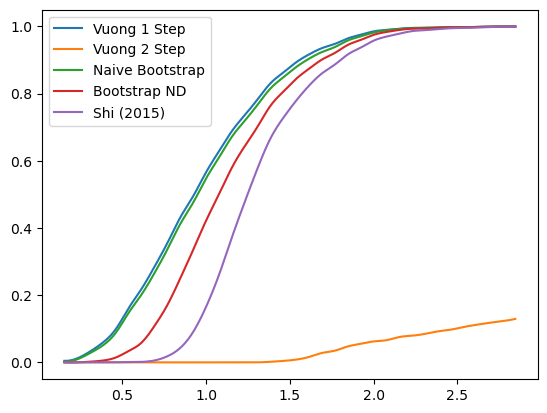

In [12]:
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)

# sequence 4

Quantiles: 1th: 0.57, 5th: 1.58, 10th: 2.94, 30th: 8.41, 50th: 14.78, 70th: 22.95, 90th: 36.35, 95th: 43.49, 99th: 56.25
bonus term 3.0950075447424608 // variance stats 11.56859949674476 //part1 38.89991026927133 //part2 12.568599496744762 11.56859949674476
1.3854235088273543 -0.6056069975811579 5.0762325404589195
-4.804591580657567 -0.6056069975811579 -1.1137825490260025
---
Quantiles: 1th: 0.52, 5th: 1.59, 10th: 3.10, 30th: 9.50, 50th: 16.87, 70th: 25.60, 90th: 41.04, 95th: 48.85, 99th: 63.15
bonus term 2.3703802765045414 // variance stats 19.69676075330179 //part1 49.05919347715984 //part2 20.69676075330179 19.69676075330179
0.27849850344795046 -0.21529257793551254 4.182753036635299
-4.462262049561132 -0.21529257793551254 -0.5580075163737834
---
Quantiles: 1th: 0.76, 5th: 2.03, 10th: 3.46, 30th: 10.77, 50th: 18.76, 70th: 28.98, 90th: 46.69, 95th: 55.40, 99th: 71.61
bonus term 1.6702004908624668 // variance stats 36.78881423429809 //part1 63.11489608323525 //part2 37.788814234298094 

Quantiles: 1th: 0.83, 5th: 2.08, 10th: 3.83, 30th: 11.65, 50th: 20.30, 70th: 30.38, 90th: 48.97, 95th: 58.27, 99th: 77.94
bonus term 1.6180197856220402 // variance stats 42.155746063919075 //part1 69.82685099470154 //part2 43.15574606391907 42.155746063919075
-0.2479300300822215 0.35253285941577484 3.676434117184872
-3.4839696013263017 0.35253285941577484 0.4403945459407918
---
Quantiles: 1th: 0.72, 5th: 2.10, 10th: 4.01, 30th: 11.65, 50th: 20.32, 70th: 31.51, 90th: 49.29, 95th: 58.72, 99th: 75.33
bonus term 5.750015772395469 // variance stats 11.330417039998718 //part1 70.90009246020648 //part2 12.330417039998718 11.330417039998718
4.043669380511287 -1.0214002048596615 7.659347251724457
-7.456362164279651 -1.0214002048596615 -3.8406842930664813
---
Quantiles: 1th: 0.66, 5th: 1.96, 10th: 3.55, 30th: 10.84, 50th: 18.69, 70th: 28.54, 90th: 45.96, 95th: 54.31, 99th: 68.31
bonus term 3.706282432012524 // variance stats 15.365084505160356 //part1 60.653625199876195 //part2 16.36508450516035

Quantiles: 1th: 0.71, 5th: 1.87, 10th: 3.00, 30th: 7.99, 50th: 14.21, 70th: 22.07, 90th: 34.60, 95th: 41.35, 99th: 55.99
bonus term 1.8762754657306495 // variance stats 17.739023536510782 //part1 35.15957011330437 //part2 18.739023536510786 17.739023536510782
0.12753994043092218 -0.2522716080507777 3.7648115883885223
-3.625010991030377 -0.2522716080507777 0.012260656927223256
---
Quantiles: 1th: 0.72, 5th: 1.97, 10th: 3.35, 30th: 9.99, 50th: 17.20, 70th: 26.78, 90th: 42.64, 95th: 50.71, 99th: 66.55
bonus term 1.5845687206368184 // variance stats 32.37205873253488 //part1 52.880320410829576 //part2 33.37205873253489 32.37205873253488
-0.3745533594329234 0.247240797002204 3.45850844675053
-3.5436908007065604 0.247240797002204 0.2893710054768931
---
Quantiles: 1th: 0.73, 5th: 1.99, 10th: 3.60, 30th: 10.52, 50th: 18.25, 70th: 27.09, 90th: 43.59, 95th: 52.67, 99th: 67.79
bonus term 7.043918261776942 // variance stats 7.099040765669442 //part1 57.048981152174896 //part2 8.099040765669441 7.0

Quantiles: 1th: 0.88, 5th: 1.98, 10th: 3.15, 30th: 8.77, 50th: 15.30, 70th: 23.65, 90th: 35.60, 95th: 42.46, 99th: 57.85
bonus term 2.4232209646814744 // variance stats 14.29970072595696 //part1 37.07455555249128 //part2 15.299700725956962 14.29970072595696
0.4588088150310993 -0.5020335969423344 4.3051044349048935
-4.38763311433185 -0.5020335969423344 -0.5413374944580557
---
Quantiles: 1th: 0.57, 5th: 1.37, 10th: 2.50, 30th: 7.02, 50th: 11.80, 70th: 18.18, 90th: 28.53, 95th: 33.77, 99th: 45.47
bonus term 1.698180299542361 // variance stats 12.804984668572324 //part1 23.44335299965385 //part2 13.804984668572324 12.804984668572324
-0.05588544956193684 -0.36072473006648714 3.422229025389072
-3.452246048646659 -0.36072473006648714 0.02586842630435029
---
Quantiles: 1th: 0.76, 5th: 1.84, 10th: 3.33, 30th: 9.59, 50th: 17.02, 70th: 26.34, 90th: 41.27, 95th: 48.63, 99th: 64.77
bonus term 1.6373774338454121 // variance stats 28.703822633609832 //part1 48.63636887921934 //part2 29.70382263360983

Quantiles: 1th: 0.60, 5th: 1.65, 10th: 2.62, 30th: 7.35, 50th: 12.60, 70th: 19.35, 90th: 31.45, 95th: 37.39, 99th: 49.51
bonus term 1.6110082154224912 // variance stats 16.846884519187654 //part1 28.751477580107792 //part2 17.846884519187654 16.846884519187654
-0.22613946690170852 -0.24937694278842273 3.5237976797941206
-3.448155897746691 -0.24937694278842273 0.3017812489491381
---
Quantiles: 1th: 0.83, 5th: 2.17, 10th: 3.67, 30th: 10.69, 50th: 18.74, 70th: 28.65, 90th: 45.49, 95th: 54.14, 99th: 70.77
bonus term 2.433422913500713 // variance stats 23.769683196016594 //part1 60.27511464934035 //part2 24.769683196016597 23.769683196016594
0.5541670558644278 -0.1675902794770614 4.3787518556009655
-4.312678771136999 -0.1675902794770614 -0.48809397140046096
---
Quantiles: 1th: 0.81, 5th: 2.13, 10th: 3.83, 30th: 11.33, 50th: 20.12, 70th: 30.32, 90th: 47.52, 95th: 56.83, 99th: 73.24
bonus term 2.2622940189766587 // variance stats 28.355748270473345 //part1 66.41133373487624 //part2 29.3557482

Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.41, 30th: 9.99, 50th: 17.09, 70th: 26.17, 90th: 41.85, 95th: 49.78, 99th: 64.70
bonus term 1.3547250658263128 // variance stats 36.60646921645443 //part1 50.94642648475642 //part2 37.60646921645443 36.60646921645443
-0.5535769464128409 0.3310661490456899 3.4206469002826143
-3.2630270780654667 0.3310661490456899 0.7111967686299885
---
Quantiles: 1th: 0.92, 5th: 2.29, 10th: 4.11, 30th: 11.40, 50th: 19.49, 70th: 29.96, 90th: 47.45, 95th: 56.12, 99th: 73.98
bonus term 2.711253420628765 // variance stats 22.888621153420928 //part1 64.76810581631716 //part2 23.888621153420928 22.888621153420928
0.8187107980367129 -0.28549308717063465 4.675090802167798
-4.603796043220816 -0.28549308717063465 -0.7474160390897319
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.65, 5th: 1.61, 10th: 2.84, 30th: 8.13, 50th: 14.10, 70th: 21.66, 90th: 34.81, 95th: 41.53, 99th: 55.74
bonus term 3.3401424561264297 // variance stats 9.617365246342185 //part1 35.463512431508

Quantiles: 1th: 0.74, 5th: 2.03, 10th: 3.80, 30th: 10.92, 50th: 19.55, 70th: 29.91, 90th: 46.96, 95th: 55.29, 99th: 73.61
bonus term 0.8778802969849486 // variance stats 70.59241512943832 //part1 62.84957065570105 //part2 71.59241512943832 70.59241512943832
-0.970903471317317 1.0423561251040834 2.6723856880055155
-2.7266640652872143 1.0423561251040834 0.9166250940356183
---
Quantiles: 1th: 0.65, 5th: 1.82, 10th: 2.92, 30th: 7.55, 50th: 13.19, 70th: 20.56, 90th: 32.72, 95th: 39.34, 99th: 51.48
bonus term 3.3522163310626696 // variance stats 8.491167557312945 //part1 31.81644688647664 //part2 9.491167557312945 8.491167557312945
1.4917633352207726 -1.4990199888110063 5.070526206498516
-5.2126693269045665 -1.4990199888110063 -1.6339064556268226
---
Quantiles: 1th: 0.60, 5th: 1.70, 10th: 2.90, 30th: 7.52, 50th: 13.13, 70th: 20.06, 90th: 31.97, 95th: 38.28, 99th: 49.65
bonus term 5.850173387686481 // variance stats 4.149692488184045 //part1 30.12659394914328 //part2 5.149692488184046 4.14969

Quantiles: 1th: 0.76, 5th: 1.89, 10th: 3.17, 30th: 9.33, 50th: 16.21, 70th: 25.10, 90th: 39.10, 95th: 47.15, 99th: 59.75
bonus term 2.3544405821818266 // variance stats 18.414269128973736 //part1 45.70974311065559 //part2 19.41426912897374 18.414269128973736
0.5840530767651362 -0.6090835425425242 4.170112278843683
-4.124828087598517 -0.6090835425425242 -0.5387688855199704
---
Quantiles: 1th: 0.87, 5th: 2.32, 10th: 3.91, 30th: 11.88, 50th: 20.02, 70th: 29.91, 90th: 48.54, 95th: 57.52, 99th: 75.96
bonus term 2.9834293042782236 // variance stats 21.802076415175947 //part1 68.02838297542728 //part2 22.80207641517595 21.802076415175947
1.0172674741940482 -0.4191394380994776 4.704642976752575
-4.949591134362399 -0.4191394380994776 -1.2622156318038722
---
Quantiles: 1th: 0.78, 5th: 2.27, 10th: 4.02, 30th: 11.63, 50th: 20.15, 70th: 30.90, 90th: 49.08, 95th: 57.80, 99th: 79.35
bonus term 9.55456075447759 // variance stats 6.190491984484035 //part1 68.70199252033686 //part2 7.190491984484035 6.1

Quantiles: 1th: 0.72, 5th: 1.88, 10th: 3.58, 30th: 9.91, 50th: 17.33, 70th: 26.95, 90th: 43.33, 95th: 51.21, 99th: 68.87
bonus term 9.10948023310239 // variance stats 4.920189391838371 //part1 53.929848241174106 //part2 5.920189391838372 4.920189391838371
7.32446941314888 -3.4993971300014333 10.849336914312191
-10.894491053055901 -3.4993971300014333 -7.36962355189259
---
Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.35, 30th: 9.15, 50th: 16.20, 70th: 25.27, 90th: 39.64, 95th: 46.67, 99th: 62.11
bonus term 1.5179889980981731 // variance stats 28.50078726995012 //part1 44.78187051101892 //part2 29.500787269950123 28.50078726995012
-0.3801929395890941 -0.28288722253464726 3.4875672424410764
-3.4161709357854404 -0.28288722253464726 0.4515892462447299
---
Quantiles: 1th: 0.86, 5th: 2.08, 10th: 3.44, 30th: 9.65, 50th: 16.72, 70th: 25.78, 90th: 40.24, 95th: 48.15, 99th: 65.35
bonus term 2.3834755829572876 // variance stats 19.000185723481444 //part1 47.66995432652895 //part2 20.000185723481444 19.

Quantiles: 1th: 0.81, 5th: 1.92, 10th: 3.43, 30th: 10.11, 50th: 17.46, 70th: 26.89, 90th: 42.69, 95th: 50.44, 99th: 66.74
bonus term 9.100160425072625 // variance stats 4.748686182600833 //part1 52.313966495065934 //part2 5.748686182600834 4.748686182600833
7.411135100272406 -4.188561931298004 10.744347799902398
-10.789185749872845 -4.188561931298004 -7.455973050242853
---
Quantiles: 1th: 0.59, 5th: 1.37, 10th: 2.46, 30th: 7.08, 50th: 12.47, 70th: 18.91, 90th: 29.41, 95th: 35.32, 99th: 45.77
bonus term 0.48198599601778713 // variance stats 52.22788128440282 //part1 25.65509337677942 //part2 53.22788128440281 52.22788128440282
-1.416820926856093 1.1557676655287779 2.28422469166391
-2.380792918891667 1.1557676655287779 1.3202526996283357
---
Quantiles: 1th: 0.87, 5th: 2.10, 10th: 3.80, 30th: 10.68, 50th: 18.90, 70th: 28.95, 90th: 46.33, 95th: 55.00, 99th: 73.09
bonus term 2.164960476482348 // variance stats 27.729669980819178 //part1 62.198600010854896 //part2 28.729669980819178 27.72966

Quantiles: 1th: 0.68, 5th: 1.80, 10th: 3.30, 30th: 9.79, 50th: 17.17, 70th: 25.69, 90th: 40.95, 95th: 48.58, 99th: 65.09
bonus term 1.3752086664953709 // variance stats 34.28294459341028 //part1 48.52141118433379 //part2 35.28294459341028 34.28294459341028
-0.5123437446696376 0.16353792415481194 3.2115854217012214
-3.2627610776603797 0.16353792415481194 0.4611680887104801
---
Quantiles: 1th: 0.69, 5th: 1.78, 10th: 2.97, 30th: 8.46, 50th: 14.73, 70th: 23.05, 90th: 36.01, 95th: 42.65, 99th: 56.78
bonus term 3.365682660149702 // variance stats 10.112573934608456 //part1 37.40139740134323 //part2 11.112573934608456 10.112573934608456
1.5760744092240222 -2.603332399420637 5.1203909968860275
-5.155290911075382 -2.603332399420637 -1.6109743234133764
---
Quantiles: 1th: 0.68, 5th: 1.74, 10th: 2.64, 30th: 7.66, 50th: 13.14, 70th: 20.03, 90th: 31.81, 95th: 37.81, 99th: 49.82
bonus term 0.6173997567104574 // variance stats 46.62088851789248 //part1 29.401124985282635 //part2 47.620888517892475 46

Quantiles: 1th: 0.77, 5th: 1.95, 10th: 3.49, 30th: 10.69, 50th: 19.34, 70th: 29.30, 90th: 45.64, 95th: 54.26, 99th: 72.90
bonus term 1.4766460399931562 // variance stats 39.99376080904074 //part1 60.53327456309664 //part2 40.99376080904073 39.99376080904074
-0.5435591265167751 -0.3089759369094087 3.4011196605641034
-3.4968512065030875 -0.3089759369094087 0.4478275805777911
---
Quantiles: 1th: 0.56, 5th: 1.47, 10th: 2.47, 30th: 6.89, 50th: 12.04, 70th: 18.65, 90th: 29.68, 95th: 35.22, 99th: 46.91
bonus term 1.9162114723886166 // variance stats 12.312125505990059 //part1 25.50884761645527 //part2 13.31212550599006 12.312125505990059
0.12034458484603128 -1.2971774889300407 3.755602840597472
-3.7120783599312017 -1.2971774889300407 -0.07682010417976083
---
Quantiles: 1th: 0.70, 5th: 1.64, 10th: 2.99, 30th: 8.90, 50th: 14.93, 70th: 22.69, 90th: 35.41, 95th: 42.53, 99th: 57.70
bonus term 0.5766869867983957 // variance stats 63.49155616134609 //part1 37.19144119662618 //part2 64.49155616134608

Quantiles: 1th: 0.96, 5th: 2.40, 10th: 4.08, 30th: 12.19, 50th: 21.32, 70th: 33.63, 90th: 52.54, 95th: 61.76, 99th: 83.41
bonus term 0.7292496656333237 // variance stats 106.55056414067028 //part1 78.43121293825914 //part2 107.55056414067028 106.55056414067028
-1.2283284866872457 1.242925171114573 2.7843016514141676
-2.6868278179538927 1.242925171114573 1.32580232014752
---
Quantiles: 1th: 0.83, 5th: 1.96, 10th: 3.58, 30th: 11.07, 50th: 19.38, 70th: 29.29, 90th: 46.41, 95th: 55.88, 99th: 73.16
bonus term 1.342461095996063 // variance stats 46.82148306131833 //part1 64.19848056265457 //part2 47.82148306131833 46.82148306131833
-0.5644384018634876 -0.09936008680562503 3.3010404626234067
-3.249360593855614 -0.09936008680562503 0.616118270631281
---
Quantiles: 1th: 0.64, 5th: 1.71, 10th: 2.76, 30th: 8.46, 50th: 14.59, 70th: 22.68, 90th: 36.09, 95th: 43.17, 99th: 56.13
bonus term 1.1779234206805047 // variance stats 31.534376857026466 //part1 38.32300447713727 //part2 32.534376857026466 31.

Quantiles: 1th: 0.70, 5th: 2.00, 10th: 3.49, 30th: 9.97, 50th: 17.24, 70th: 27.04, 90th: 42.18, 95th: 49.40, 99th: 65.84
bonus term 2.5627008901943773 // variance stats 18.579933319956453 //part1 50.17751254899896 //part2 19.579933319956456 18.579933319956453
0.650379012496644 -1.6838784879976183 4.493160418867507
-4.475022767892111 -1.6838784879976183 -0.6322413615212474
---
Quantiles: 1th: 0.82, 5th: 2.47, 10th: 4.49, 30th: 13.27, 50th: 23.69, 70th: 36.32, 90th: 57.02, 95th: 68.29, 99th: 91.27
bonus term 6.843605481010267 // variance stats 13.0105245087595 //part1 95.88250231997519 //part2 14.0105245087595 13.0105245087595
4.721702228466806 -2.841685605766873 8.795185664968274
-8.96550873355373 -2.841685605766873 -4.8920252970522595
---
Quantiles: 1th: 0.76, 5th: 2.12, 10th: 3.84, 30th: 11.53, 50th: 19.53, 70th: 30.14, 90th: 48.40, 95th: 57.13, 99th: 73.65
bonus term 1.0063597793850583 // variance stats 65.69434729641833 //part1 67.118508631454 //part2 66.69434729641833 65.6943472964

0.7692307692307693 [0.99857143 0.         0.00142857]
Quantiles: 1th: 0.80, 5th: 1.96, 10th: 3.30, 30th: 9.53, 50th: 16.57, 70th: 25.60, 90th: 40.38, 95th: 47.46, 99th: 61.70
bonus term 0.9248578006114555 // variance stats 49.087703048424665 //part1 46.32400287904573 //part2 50.08770304842466 49.087703048424665
-1.1382817061057446 0.010468941633819758 2.9328425938899896
-2.987997307328656 0.010468941633819758 1.0831269926670783
---
Quantiles: 1th: 0.75, 5th: 1.91, 10th: 3.52, 30th: 10.41, 50th: 18.30, 70th: 28.32, 90th: 45.49, 95th: 54.01, 99th: 71.07
bonus term 1.1873196092578466 // variance stats 49.51203404381546 //part1 59.97392852372202 //part2 50.51203404381546 49.51203404381546
-0.7578143400122116 0.00995048909038358 3.1499415773702335
-3.132453558527905 0.00995048909038358 0.7753023588545402
---
Quantiles: 1th: 0.83, 5th: 2.08, 10th: 3.56, 30th: 10.07, 50th: 17.04, 70th: 26.26, 90th: 42.23, 95th: 49.79, 99th: 66.68
bonus term 1.8421245648480895 // variance stats 26.666587940074

Quantiles: 1th: 0.76, 5th: 1.93, 10th: 3.47, 30th: 10.15, 50th: 17.85, 70th: 27.25, 90th: 43.54, 95th: 52.01, 99th: 68.88
bonus term 0.8933181486531684 // variance stats 61.25566369170287 //part1 55.61411423224628 //part2 62.25566369170287 61.25566369170287
-1.1662284647249077 0.0356631516593823 2.737929093155186
-2.9528647620312443 0.0356631516593823 0.9512927958488495
---
Quantiles: 1th: 0.54, 5th: 1.66, 10th: 2.81, 30th: 8.49, 50th: 14.68, 70th: 22.35, 90th: 34.74, 95th: 41.21, 99th: 53.54
bonus term 3.1092037321275807 // variance stats 10.229999034480135 //part1 34.91635490979477 //part2 11.229999034480135 10.229999034480135
0.8016923356343293 -5.776697820790419 5.004828451048975
-5.416715128620832 -5.776697820790419 -1.2135790132061859
---
Quantiles: 1th: 0.67, 5th: 1.75, 10th: 3.34, 30th: 10.08, 50th: 17.09, 70th: 26.07, 90th: 41.86, 95th: 49.58, 99th: 65.46
bonus term 1.1987123966951136 // variance stats 41.167868682639856 //part1 50.54714693209205 //part2 42.16786868263985 41.1

Quantiles: 1th: 0.54, 5th: 1.44, 10th: 2.65, 30th: 8.17, 50th: 13.82, 70th: 21.30, 90th: 33.58, 95th: 39.49, 99th: 52.45
bonus term 1.3272426424981087 // variance stats 23.154277815979704 //part1 32.05858751611435 //part2 24.154277815979704 23.154277815979704
-0.43658685764056104 -1.5455608988835554 3.0433764000257084
-3.0910721426367784 -1.5455608988835554 0.3888911150294909
---
Quantiles: 1th: 0.79, 5th: 2.06, 10th: 3.69, 30th: 11.25, 50th: 19.76, 70th: 29.91, 90th: 46.79, 95th: 56.11, 99th: 76.87
bonus term 5.835586114918182 // variance stats 10.09544714822834 //part1 64.74843731700985 //part2 11.095447148228342 10.09544714822834
4.072601317240729 -3.8841286338366174 7.594710271879144
-7.598570912595634 -3.8841286338366174 -4.076461957957219
---
Quantiles: 1th: 0.81, 5th: 1.95, 10th: 3.29, 30th: 9.51, 50th: 15.88, 70th: 24.64, 90th: 38.98, 95th: 45.88, 99th: 60.28
bonus term 0.748928672830862 // variance stats 56.78881193883231 //part1 43.27969822982195 //part2 57.7888119388323 56.7

Quantiles: 1th: 0.72, 5th: 1.98, 10th: 3.70, 30th: 10.79, 50th: 18.53, 70th: 28.29, 90th: 45.58, 95th: 54.14, 99th: 70.83
bonus term 1.11581264424479 // variance stats 53.016472927029746 //part1 60.272263489486164 //part2 54.016472927029746 53.016472927029746
-0.8061051053021463 -0.2373141725551865 3.021158119165052
-3.037730393791726 -0.2373141725551865 0.7895328306754721
---
Quantiles: 1th: 0.73, 5th: 1.72, 10th: 2.90, 30th: 8.30, 50th: 14.17, 70th: 21.72, 90th: 34.97, 95th: 41.85, 99th: 54.60
bonus term 0.5008369922191818 // variance stats 70.89440568651271 //part1 36.00737790141866 //part2 71.8944056865127 70.89440568651271
-1.392644193836508 0.42227658286526154 2.2147933213722313
-2.394318178274871 0.42227658286526154 1.2131193369338678
---
Quantiles: 1th: 0.74, 5th: 1.91, 10th: 3.41, 30th: 10.12, 50th: 17.95, 70th: 27.95, 90th: 44.36, 95th: 54.12, 99th: 70.81
bonus term 1.1077028127506525 // variance stats 53.37884024229893 //part1 60.23559429051289 //part2 54.37884024229892 53.3

Quantiles: 1th: 0.74, 5th: 2.09, 10th: 3.84, 30th: 10.94, 50th: 18.91, 70th: 28.57, 90th: 45.29, 95th: 53.18, 99th: 70.66
bonus term 1.2045315947170006 // variance stats 47.27683511623718 //part1 58.15097319045086 //part2 48.27683511623718 47.27683511623718
-0.5432441559949845 -0.8262023183647621 3.463550400204318
-2.9523073454289857 -0.8262023183647621 1.0544872107703163
---
Quantiles: 1th: 0.66, 5th: 1.76, 10th: 2.97, 30th: 9.05, 50th: 15.55, 70th: 23.99, 90th: 37.49, 95th: 45.47, 99th: 57.90
bonus term 1.1705983778988645 // variance stats 35.3101006701651 //part1 42.50454494583973 //part2 36.3101006701651 35.3101006701651
-0.8270797033435254 -1.3244978807872645 3.085573388560243
-3.168276459141254 -1.3244978807872645 0.7443766327625146
---
Quantiles: 1th: 0.61, 5th: 1.80, 10th: 3.23, 30th: 9.77, 50th: 16.77, 70th: 25.99, 90th: 40.49, 95th: 47.91, 99th: 62.40
bonus term 0.5941342305088755 // variance stats 78.45363687501367 //part1 47.20612540586786 //part2 79.45363687501367 78.45363

Quantiles: 1th: 0.76, 5th: 1.99, 10th: 3.38, 30th: 9.60, 50th: 16.70, 70th: 25.38, 90th: 39.90, 95th: 47.71, 99th: 62.22
bonus term 0.4637601327120358 // variance stats 99.90519566418337 //part1 46.79580693255562 //part2 100.90519566418337 99.90519566418337
-1.5746737782022875 1.3067325646524188 2.439406475709103
-2.502194043626359 1.3067325646524188 1.5118862102850315
---
Quantiles: 1th: 0.55, 5th: 1.76, 10th: 3.01, 30th: 8.95, 50th: 15.33, 70th: 23.19, 90th: 37.06, 95th: 44.08, 99th: 55.92
bonus term 0.5153421368988916 // variance stats 76.51242378966849 //part1 39.94541811198024 //part2 77.51242378966849 76.51242378966849
-1.3022031681690167 0.9690678028947388 2.4129841335888607
-2.3328874419668 0.9690678028947388 1.3822998597910774
---
1.076923076923077 [0.98142857 0.         0.01857143]
Quantiles: 1th: 0.76, 5th: 1.74, 10th: 2.95, 30th: 8.80, 50th: 15.23, 70th: 23.83, 90th: 38.32, 95th: 46.01, 99th: 60.07
bonus term 0.43934739217993873 // variance stats 98.06354376359616 //part1 4

Quantiles: 1th: 0.81, 5th: 2.08, 10th: 3.56, 30th: 10.87, 50th: 18.96, 70th: 29.23, 90th: 45.70, 95th: 54.43, 99th: 72.57
bonus term 0.7724132214720801 // variance stats 77.8548003412993 //part1 60.90849036016067 //part2 78.8548003412993 77.8548003412993
-1.0366610339420943 0.3725816858422515 2.7199202389891832
-2.5814874768862546 0.3725816858422515 1.1750937960450227
---
Quantiles: 1th: 0.62, 5th: 1.74, 10th: 3.08, 30th: 9.26, 50th: 16.43, 70th: 24.84, 90th: 39.45, 95th: 46.59, 99th: 61.16
bonus term 0.6179103214893389 // variance stats 71.22575088917172 //part1 44.62903695173701 //part2 72.22575088917172 71.22575088917172
-1.454798209050491 0.2511703983292451 2.604767308526952
-2.6906188520291687 0.2511703983292451 1.3689466655482738
---
Quantiles: 1th: 0.76, 5th: 2.43, 10th: 4.22, 30th: 11.65, 50th: 20.26, 70th: 32.00, 90th: 50.84, 95th: 60.71, 99th: 79.94
bonus term 2.104996544999999 // variance stats 35.00787713334177 //part1 75.79645695846891 //part2 36.00787713334177 35.00787713

Quantiles: 1th: 0.75, 5th: 1.96, 10th: 3.65, 30th: 11.99, 50th: 20.66, 70th: 31.58, 90th: 50.61, 95th: 59.38, 99th: 80.04
bonus term 1.107990482160339 // variance stats 64.43368234303153 //part1 72.49989724878196 //part2 65.43368234303153 64.43368234303153
-1.0065749106877746 -0.31902234645572086 2.8730543837714633
-3.2225558750084526 -0.31902234645572086 0.6570734194507851
---
Quantiles: 1th: 0.62, 5th: 1.91, 10th: 3.37, 30th: 10.29, 50th: 17.68, 70th: 26.80, 90th: 42.74, 95th: 50.96, 99th: 66.57
bonus term 0.6792945000893815 // variance stats 77.62107979345765 //part1 53.4068670947842 //part2 78.62107979345764 77.62107979345765
-1.406052296168562 0.3812366260731631 2.7430493957724256
-2.764641296347325 0.3812366260731631 1.3844603955936623
---
Quantiles: 1th: 0.73, 5th: 1.85, 10th: 2.98, 30th: 8.27, 50th: 14.67, 70th: 22.33, 90th: 35.15, 95th: 41.74, 99th: 54.81
bonus term 0.4323819593985739 // variance stats 81.84290881179663 //part1 35.819779234322006 //part2 82.84290881179663 81.8

Quantiles: 1th: 0.75, 5th: 1.87, 10th: 3.07, 30th: 8.67, 50th: 14.84, 70th: 23.15, 90th: 37.13, 95th: 44.58, 99th: 56.77
bonus term 0.47772706212418115 // variance stats 84.53341712434799 //part1 40.861628076256885 //part2 85.53341712434799 84.53341712434799
-1.4311764349158973 0.7255517617017285 2.4541180168253898
-2.3866305591642596 0.7255517617017285 1.4986638925770275
---
Quantiles: 1th: 0.64, 5th: 1.75, 10th: 3.25, 30th: 10.14, 50th: 17.68, 70th: 26.65, 90th: 42.42, 95th: 50.19, 99th: 67.55
bonus term 1.7918020702800075 // variance stats 27.90784028458823 //part1 51.797128069248984 //part2 28.90784028458823 27.90784028458823
-0.07066452646023536 -1.973607913939188 3.6780526031580973
-3.65426866702025 -1.973607913939188 0.09444846259808225
---
Quantiles: 1th: 0.70, 5th: 1.57, 10th: 2.72, 30th: 7.84, 50th: 13.51, 70th: 20.69, 90th: 33.57, 95th: 39.93, 99th: 52.14
bonus term 0.6353924160906786 // variance stats 50.59081079338051 //part1 32.7804099180831 //part2 51.59081079338051 50.5

Quantiles: 1th: 0.64, 5th: 1.76, 10th: 3.08, 30th: 9.07, 50th: 15.53, 70th: 23.44, 90th: 37.45, 95th: 44.21, 99th: 57.97
bonus term 0.5753984853434905 // variance stats 68.85535321751999 //part1 40.19466443449552 //part2 69.85535321751999 68.85535321751999
-1.4048916875465272 -0.31399070489057934 2.759746927631022
-2.5556886582335085 -0.31399070489057934 1.6089499569440409
---
Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.56, 30th: 10.17, 50th: 17.58, 70th: 26.85, 90th: 41.59, 95th: 49.25, 99th: 66.20
bonus term 1.4332138999397475 // variance stats 33.793836583471176 //part1 49.867010223662994 //part2 34.79383658347118 33.793836583471176
-0.5295938246178037 -2.6198710219519348 3.4518158596524993
-3.3960216244972985 -2.6198710219519348 0.5853880597730042
---
Quantiles: 1th: 0.69, 5th: 1.89, 10th: 3.37, 30th: 10.17, 50th: 17.70, 70th: 26.83, 90th: 42.02, 95th: 49.92, 99th: 66.35
bonus term 1.164015766670537 // variance stats 43.02716534674741 //part1 51.24831462542468 //part2 44.0271653467474

Quantiles: 1th: 0.78, 5th: 1.95, 10th: 3.44, 30th: 10.58, 50th: 18.54, 70th: 28.64, 90th: 45.05, 95th: 54.73, 99th: 70.82
bonus term 0.7854195351931336 // variance stats 77.424488747135 //part1 61.596125499533905 //part2 78.424488747135 77.424488747135
-1.2031505517783423 -0.1827912587741781 2.826381399752023
-2.773989622164609 -0.1827912587741781 1.2555423293657562
---
Quantiles: 1th: 0.66, 5th: 1.95, 10th: 3.41, 30th: 9.68, 50th: 17.33, 70th: 26.53, 90th: 43.17, 95th: 51.13, 99th: 66.98
bonus term 0.7233835520674119 // variance stats 73.32537627799941 //part1 53.76575470072616 //part2 74.32537627799941 73.32537627799941
-1.4192557660073917 -0.23682471926735418 2.746515665433157
-2.8660228701422157 -0.23682471926735418 1.2997485612983333
---
Quantiles: 1th: 0.63, 5th: 1.93, 10th: 3.23, 30th: 9.75, 50th: 16.96, 70th: 26.40, 90th: 41.27, 95th: 49.06, 99th: 66.94
bonus term 0.6300259182159187 // variance stats 77.56903290627967 //part1 49.50052710011559 //part2 78.56903290627967 77.56903

Quantiles: 1th: 0.76, 5th: 1.98, 10th: 3.49, 30th: 10.20, 50th: 18.37, 70th: 28.57, 90th: 44.90, 95th: 54.46, 99th: 70.18
bonus term 1.1085174682309638 // variance stats 54.02349794474229 //part1 60.99450863491735 //part2 55.02349794474228 54.02349794474229
-1.0166751800875637 -1.7688813449896987 3.1141478132547094
-3.2337101165494913 -1.7688813449896987 0.8971128767927817
---
Quantiles: 1th: 0.67, 5th: 1.66, 10th: 2.80, 30th: 8.47, 50th: 14.61, 70th: 22.57, 90th: 36.22, 95th: 42.46, 99th: 57.55
bonus term 0.7247144480518688 // variance stats 50.15519345863674 //part1 37.07290779236249 //part2 51.15519345863674 50.15519345863674
-1.3184168238391032 -1.5941427588805461 2.741214766272868
-2.7678457199428403 -1.5941427588805461 1.2917858701691307
---
Quantiles: 1th: 0.82, 5th: 1.96, 10th: 3.54, 30th: 10.12, 50th: 17.33, 70th: 26.52, 90th: 42.06, 95th: 49.46, 99th: 65.25
bonus term 1.8173588075636642 // variance stats 26.678407599635364 //part1 50.3015978305344 //part2 27.678407599635367 2

Quantiles: 1th: 0.75, 5th: 2.13, 10th: 3.53, 30th: 9.95, 50th: 17.12, 70th: 26.10, 90th: 40.62, 95th: 48.45, 99th: 62.35
bonus term 0.6539150735090159 // variance stats 72.82116725671787 //part1 48.272774013198024 //part2 73.82116725671787 72.82116725671787
-1.214092865808944 -0.04023215535090695 2.7351101698749605
-2.5219230128269756 -0.04023215535090695 1.4272800228569287
---
Quantiles: 1th: 0.65, 5th: 1.84, 10th: 3.38, 30th: 9.97, 50th: 17.34, 70th: 26.48, 90th: 41.29, 95th: 48.47, 99th: 63.97
bonus term 0.753918544837414 // variance stats 63.08877008896431 //part1 48.31771228589156 //part2 64.08877008896431 63.08877008896431
-1.219983297112815 -0.7404594117814244 2.6947823756063594
-2.727820386787643 -0.7404594117814244 1.1869452859315313
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.42, 30th: 10.18, 50th: 17.45, 70th: 27.05, 90th: 42.66, 95th: 51.19, 99th: 67.80
bonus term 0.5732271826301173 // variance stats 93.01577696437923 //part1 53.89239895207258 //part2 94.01577696437923 93.

Quantiles: 1th: 0.68, 5th: 1.83, 10th: 3.30, 30th: 9.60, 50th: 16.75, 70th: 26.19, 90th: 40.51, 95th: 48.44, 99th: 63.33
bonus term 0.7449684766387614 // variance stats 63.755084664022576 //part1 48.24049677677092 //part2 64.75508466402258 63.755084664022576
-1.1134158257710087 -0.9374723276456417 2.601953798185853
-2.6033527790485316 -0.9374723276456417 1.1120168449083299
---
Quantiles: 1th: 0.65, 5th: 1.80, 10th: 3.19, 30th: 9.53, 50th: 16.79, 70th: 25.95, 90th: 41.12, 95th: 48.51, 99th: 63.05
bonus term 0.5567445745633979 // variance stats 85.92986477122038 //part1 48.397730578906796 //part2 86.92986477122037 85.92986477122038
-1.3833092335861972 -0.23679998838222027 2.4847183278611586
-2.4967983827129934 -0.23679998838222027 1.3712291787343627
---
Quantiles: 1th: 0.72, 5th: 2.02, 10th: 3.58, 30th: 10.12, 50th: 16.99, 70th: 25.85, 90th: 41.06, 95th: 48.94, 99th: 65.10
bonus term 0.6057207539163926 // variance stats 80.30581849053667 //part1 49.24862167387724 //part2 81.3058184905366

1.6153846153846154 [0.96285714 0.00285714 0.03428571]
Quantiles: 1th: 0.78, 5th: 2.23, 10th: 3.99, 30th: 11.16, 50th: 19.12, 70th: 29.19, 90th: 46.65, 95th: 56.25, 99th: 72.51
bonus term 0.8160143823337105 // variance stats 78.74124590705912 //part1 65.07000352536937 //part2 79.74124590705912 78.74124590705912
-1.0458320902395635 -0.38610579468174744 2.6925776904743013
-2.6778608549069847 -0.38610579468174744 1.0605489258068803
---
Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.40, 30th: 10.12, 50th: 18.02, 70th: 27.51, 90th: 43.05, 95th: 51.58, 99th: 68.51
bonus term 0.3871907864985483 // variance stats 140.29246907752983 //part1 54.70714222845059 //part2 141.29246907752983 140.29246907752983
-1.5647536806025444 1.4298250649513244 2.324678098414312
-2.339135253599641 1.4298250649513244 1.550296525417215
---
Quantiles: 1th: 0.64, 5th: 1.82, 10th: 3.05, 30th: 9.07, 50th: 15.82, 70th: 24.57, 90th: 38.99, 95th: 45.98, 99th: 59.51
bonus term 0.6528221431532614 // variance stats 65.60216392776363

Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.41, 30th: 9.88, 50th: 17.28, 70th: 26.14, 90th: 40.94, 95th: 48.82, 99th: 64.27
bonus term 0.5804608080570174 // variance stats 83.42854722704713 //part1 49.00746274649183 //part2 84.42854722704712 83.42854722704713
-1.3394793244931829 -0.35509795743121053 2.504303133948685
-2.5004009406072174 -0.35509795743121053 1.34338151783465
---
Quantiles: 1th: 0.63, 5th: 1.61, 10th: 2.50, 30th: 7.04, 50th: 12.29, 70th: 18.59, 90th: 29.66, 95th: 34.79, 99th: 46.31
bonus term 0.3906636630532804 // variance stats 62.716043295583354 //part1 24.891542869113994 //part2 63.71604329558335 62.716043295583354
-1.5775477286328305 -0.5187993774384574 2.5763045484554907
-2.358875054739391 -0.5187993774384574 1.79497722234893
---
Quantiles: 1th: 0.82, 5th: 2.07, 10th: 3.58, 30th: 9.68, 50th: 16.84, 70th: 26.13, 90th: 40.83, 95th: 47.73, 99th: 61.58
bonus term 0.46835147398695304 // variance stats 99.0042624386567 //part1 46.83714371812295 //part2 100.0042624386567 99.0

Quantiles: 1th: 0.62, 5th: 2.18, 10th: 4.03, 30th: 12.86, 50th: 22.73, 70th: 34.90, 90th: 55.32, 95th: 65.57, 99th: 83.34
bonus term 0.831631794123367 // variance stats 105.29809803502765 //part1 88.40087798077158 //part2 106.29809803502765 105.29809803502765
-1.1032357727204931 -0.1547277107624474 2.695181424906585
-2.766499360967227 -0.1547277107624474 1.0319178366598512
---
Quantiles: 1th: 0.59, 5th: 1.62, 10th: 2.82, 30th: 7.68, 50th: 13.24, 70th: 20.64, 90th: 32.47, 95th: 38.73, 99th: 51.54
bonus term 0.3316079359380784 // variance stats 91.99166266852365 //part1 30.83677331695919 //part2 92.99166266852365 91.99166266852365
-1.6505439878951493 0.7531279783362376 2.39614867119781
-2.3137598597713063 0.7531279783362376 1.732932799321653
---
Quantiles: 1th: 0.83, 5th: 2.10, 10th: 3.48, 30th: 10.59, 50th: 19.16, 70th: 29.01, 90th: 46.44, 95th: 55.37, 99th: 72.31
bonus term 0.5382142166758663 // variance stats 116.12074014245655 //part1 63.036047412269944 //part2 117.12074014245655 116

Quantiles: 1th: 0.75, 5th: 1.77, 10th: 3.15, 30th: 9.61, 50th: 16.45, 70th: 25.57, 90th: 40.12, 95th: 47.93, 99th: 63.72
bonus term 0.37246465660363043 // variance stats 125.82626475070126 //part1 47.23830114869105 //part2 126.82626475070124 125.82626475070126
-1.6228636300592236 1.0111242775154425 2.53982257053097
-2.3677929432664846 1.0111242775154425 1.7948932573237093
---
Quantiles: 1th: 0.71, 5th: 1.98, 10th: 3.22, 30th: 9.49, 50th: 15.75, 70th: 24.40, 90th: 38.33, 95th: 46.03, 99th: 58.73
bonus term 0.29975594318491106 // variance stats 144.34310452935665 //part1 43.567459383620424 //part2 145.34310452935665 144.34310452935665
-1.76597997586875 1.7649092217773799 2.2527791620708575
-2.3654918622385726 1.7649092217773799 1.6532672757010356
---
Quantiles: 1th: 0.94, 5th: 2.39, 10th: 4.26, 30th: 12.54, 50th: 21.89, 70th: 34.12, 90th: 53.87, 95th: 64.20, 99th: 85.09
bonus term 0.6301620408094913 // variance stats 133.4923659206 //part1 84.75198378182219 //part2 134.4923659206 133.492

Quantiles: 1th: 0.73, 5th: 1.76, 10th: 2.88, 30th: 8.37, 50th: 14.39, 70th: 22.57, 90th: 35.59, 95th: 42.00, 99th: 54.40
bonus term 0.515851619679091 // variance stats 69.32837993571862 //part1 36.27900869924693 //part2 70.32837993571862 69.32837993571862
-1.5905974244658345 -1.3032724525514638 2.3942741898085425
-2.6223006638240163 -1.3032724525514638 1.3625709504503603
---
Quantiles: 1th: 0.66, 5th: 1.66, 10th: 3.05, 30th: 8.97, 50th: 15.34, 70th: 23.20, 90th: 36.95, 95th: 43.91, 99th: 57.44
bonus term 0.4270572750940512 // variance stats 91.84486215936312 //part1 39.650073840260404 //part2 92.84486215936312 91.84486215936312
-1.4474266356171552 -0.00846322059102086 2.358423181588414
-2.3015411858052572 -0.00846322059102086 1.5043086314003113
---
Quantiles: 1th: 0.71, 5th: 1.85, 10th: 3.56, 30th: 10.29, 50th: 18.23, 70th: 28.29, 90th: 45.35, 95th: 54.17, 99th: 70.71
bonus term 0.5448400131690477 // variance stats 109.74801508208037 //part1 60.33994999576656 //part2 110.74801508208037

Quantiles: 1th: 0.87, 5th: 2.21, 10th: 3.84, 30th: 10.94, 50th: 19.43, 70th: 29.30, 90th: 46.33, 95th: 54.89, 99th: 72.53
bonus term 0.6042149264095238 // variance stats 101.52211556685842 //part1 61.945392512578046 //part2 102.52211556685842 101.52211556685842
-1.37416241284608 0.08407839363535158 2.5818964337222394
-2.5825922656651277 0.08407839363535158 1.373466580903192
---
Quantiles: 1th: 0.60, 5th: 2.01, 10th: 3.67, 30th: 10.90, 50th: 18.97, 70th: 28.93, 90th: 45.77, 95th: 54.18, 99th: 71.92
bonus term 0.38171703925623807 // variance stats 157.1120068639997 //part1 60.35404713098795 //part2 158.1120068639997 157.1120068639997
-1.6728949261207848 1.6277935789003823 2.270536786069575
-2.436329004633261 1.6277935789003823 1.5071027075570993
---
1.9230769230769231 [0.96       0.00428571 0.03571429]
Quantiles: 1th: 0.77, 5th: 1.87, 10th: 3.36, 30th: 10.15, 50th: 18.14, 70th: 27.19, 90th: 42.70, 95th: 50.76, 99th: 68.75
bonus term 0.40938781065057384 // variance stats 128.4328784837302

Quantiles: 1th: 0.71, 5th: 1.90, 10th: 3.22, 30th: 9.54, 50th: 16.50, 70th: 25.10, 90th: 40.06, 95th: 47.16, 99th: 61.01
bonus term 0.5046545984601851 // variance stats 89.63267930229661 //part1 45.73819838067122 //part2 90.6326793022966 89.63267930229661
-1.3105964947690962 -0.3473606866151158 2.448590112590905
-2.3199056916894665 -0.3473606866151158 1.4392809156705346
---
Quantiles: 1th: 0.71, 5th: 1.87, 10th: 3.47, 30th: 10.27, 50th: 17.89, 70th: 27.69, 90th: 43.84, 95th: 51.98, 99th: 66.71
bonus term 0.6212241232432844 // variance stats 88.41629305025995 //part1 55.547558253812326 //part2 89.41629305025995 88.41629305025995
-1.195791990516359 -0.7605535413548169 2.4518346355080562
-2.4382402370029275 -0.7605535413548169 1.2093863890214878
---
Quantiles: 1th: 0.82, 5th: 2.08, 10th: 3.52, 30th: 9.66, 50th: 17.06, 70th: 26.95, 90th: 43.15, 95th: 51.15, 99th: 67.68
bonus term 0.5364584031808016 // variance stats 99.30068823099013 //part1 53.80714704633238 //part2 100.30068823099013 99.

Quantiles: 1th: 0.83, 5th: 2.05, 10th: 3.54, 30th: 10.57, 50th: 18.54, 70th: 29.21, 90th: 46.16, 95th: 55.29, 99th: 71.42
bonus term 0.5129406939777564 // variance stats 121.54193281042126 //part1 62.85674405715308 //part2 122.54193281042126 121.54193281042126
-1.5659306351398459 -0.17554584514591878 2.497704084507753
-2.591812023095359 -0.17554584514591878 1.4718226965522399
---
Quantiles: 1th: 0.67, 5th: 1.75, 10th: 3.12, 30th: 9.03, 50th: 15.78, 70th: 24.33, 90th: 38.87, 95th: 46.13, 99th: 60.30
bonus term 0.6194153987468262 // variance stats 69.64159591645206 //part1 43.75649230270132 //part2 70.64159591645206 69.64159591645206
-1.4337604772785795 -1.723806624566497 2.6192992888593425
-2.6725912747722322 -1.723806624566497 1.3804684913656906
---
Quantiles: 1th: 0.74, 5th: 1.74, 10th: 3.29, 30th: 9.44, 50th: 16.82, 70th: 25.36, 90th: 40.14, 95th: 47.47, 99th: 63.44
bonus term 0.36436474414473113 // variance stats 126.17472506636071 //part1 46.337986160481044 //part2 127.174725066360

Quantiles: 1th: 0.71, 5th: 1.72, 10th: 3.06, 30th: 8.98, 50th: 15.67, 70th: 23.81, 90th: 37.80, 95th: 44.41, 99th: 58.66
bonus term 0.2970472116150209 // variance stats 135.51221686550065 //part1 40.550573371282 //part2 136.51221686550065 135.51221686550065
-1.6554850722757328 1.2437926785918616 2.4485985839516875
-2.249579495505775 1.2437926785918616 1.8545041607216457
---
Quantiles: 1th: 0.81, 5th: 2.38, 10th: 4.30, 30th: 12.97, 50th: 22.32, 70th: 34.00, 90th: 53.80, 95th: 63.86, 99th: 82.92
bonus term 0.7775835972067866 // variance stats 106.85746679369915 //part1 83.86819701505611 //part2 107.85746679369915 106.85746679369915
-1.2783551757945717 -0.8140506284047826 2.7859334430225884
-2.833522370208145 -0.8140506284047826 1.2307662486090154
---
Quantiles: 1th: 0.71, 5th: 1.77, 10th: 2.89, 30th: 8.34, 50th: 14.11, 70th: 21.92, 90th: 35.10, 95th: 41.47, 99th: 53.88
bonus term 0.3793752544026713 // variance stats 92.20015495184164 //part1 35.3578324952233 //part2 93.20015495184164 92.

Quantiles: 1th: 0.66, 5th: 1.67, 10th: 2.68, 30th: 7.83, 50th: 13.65, 70th: 20.81, 90th: 32.79, 95th: 39.16, 99th: 49.86
bonus term 0.27366878542627504 // variance stats 114.19997909209403 //part1 31.52663835926565 //part2 115.19997909209403 114.19997909209403
-1.6420049289043033 0.5672286590868675 2.314549797891098
-2.189342499756853 0.5672286590868675 1.7672122270385484
---
Quantiles: 1th: 0.85, 5th: 2.22, 10th: 3.68, 30th: 10.53, 50th: 18.37, 70th: 28.14, 90th: 44.52, 95th: 53.39, 99th: 68.91
bonus term 0.3753449735476734 // variance stats 155.1413429351553 //part1 58.606868233694065 //part2 156.1413429351553 155.1413429351553
-1.6041211316389363 1.2026082602674908 2.3816541253461123
-2.3548110787342833 1.2026082602674908 1.6309641782507658
---
Quantiles: 1th: 0.70, 5th: 1.80, 10th: 3.11, 30th: 9.23, 50th: 15.99, 70th: 24.59, 90th: 39.29, 95th: 46.65, 99th: 60.47
bonus term 0.45001292467476484 // variance stats 98.4315687696961 //part1 44.74549106705095 //part2 99.4315687696961 98.4

Quantiles: 1th: 0.67, 5th: 1.73, 10th: 3.14, 30th: 9.45, 50th: 16.21, 70th: 25.30, 90th: 40.27, 95th: 48.15, 99th: 65.92
bonus term 0.4535355390231829 // variance stats 104.09491460845686 //part1 47.66427874554186 //part2 105.09491460845686 104.09491460845686
-1.545666597633348 -0.16802860411337225 2.371661446624237
-2.452737675679714 -0.16802860411337225 1.4645903685778716
---
Quantiles: 1th: 0.92, 5th: 1.92, 10th: 3.16, 30th: 8.99, 50th: 15.31, 70th: 23.63, 90th: 37.42, 95th: 44.08, 99th: 58.56
bonus term 0.36996732354406553 // variance stats 107.00741167759135 //part1 39.95921302128052 //part2 108.00741167759135 107.00741167759135
-1.676425438765418 -0.08543585472874567 2.273000513877288
-2.4163600858535492 -0.08543585472874567 1.5330658667891566
---
Quantiles: 1th: 0.78, 5th: 1.78, 10th: 3.12, 30th: 9.04, 50th: 15.95, 70th: 24.42, 90th: 37.79, 95th: 44.74, 99th: 59.60
bonus term 0.26027271901622084 // variance stats 157.13795073723577 //part1 41.15899441803354 //part2 158.137950737

Quantiles: 1th: 0.74, 5th: 2.15, 10th: 4.28, 30th: 12.67, 50th: 22.32, 70th: 34.58, 90th: 55.38, 95th: 66.93, 99th: 86.05
bonus term 0.7034242961521662 // variance stats 129.93458339959358 //part1 92.10256716983622 //part2 130.93458339959358 129.93458339959358
-1.2013537289822693 -0.48228341155602356 2.6949152433706516
-2.6082023212866017 -0.48228341155602356 1.2880666510663192
---
Quantiles: 1th: 0.78, 5th: 2.06, 10th: 3.43, 30th: 10.24, 50th: 17.84, 70th: 27.25, 90th: 42.67, 95th: 50.80, 99th: 67.08
bonus term 0.42262104685365426 // variance stats 124.56056089187283 //part1 53.06453568765529 //part2 125.56056089187281 124.56056089187283
-1.4538335336195436 -0.1991990251283614 2.444240147114948
-2.299075627326852 -0.1991990251283614 1.5989980534076398
---
Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.30, 30th: 10.06, 50th: 17.30, 70th: 26.00, 90th: 40.81, 95th: 48.53, 99th: 62.11
bonus term 0.4163204213300243 // variance stats 115.3446969280505 //part1 48.43667324459997 //part2 116.3446969

Quantiles: 1th: 0.73, 5th: 1.67, 10th: 2.81, 30th: 8.55, 50th: 15.14, 70th: 22.75, 90th: 36.11, 95th: 43.52, 99th: 58.48
bonus term 0.32857634763942933 // variance stats 117.50262782755469 //part1 38.93716063725252 //part2 118.50262782755468 117.50262782755469
-1.6324854057895095 0.0580549560578567 2.002427543431399
-2.289638101068368 0.0580549560578567 1.3452748481525407
---
Quantiles: 1th: 0.85, 5th: 2.10, 10th: 3.85, 30th: 11.13, 50th: 19.76, 70th: 30.23, 90th: 48.57, 95th: 57.00, 99th: 75.36
bonus term 0.5517877514717976 // variance stats 120.06172452108129 //part1 66.80037676278563 //part2 121.06172452108127 120.06172452108129
-1.4498422469227246 -0.15175789070204226 2.531258163691621
-2.55341774986632 -0.15175789070204226 1.4276826607480257
---
Quantiles: 1th: 0.65, 5th: 1.66, 10th: 2.95, 30th: 8.51, 50th: 14.55, 70th: 22.35, 90th: 35.58, 95th: 42.45, 99th: 55.37
bonus term 0.29867355103072174 // variance stats 123.04357536524677 //part1 37.04853513688521 //part2 124.043575365246

Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.30, 30th: 9.65, 50th: 16.95, 70th: 25.88, 90th: 40.96, 95th: 48.46, 99th: 62.07
bonus term 0.3051168464904526 // variance stats 157.28603913647183 //part1 48.29573710478465 //part2 158.28603913647183 157.28603913647183
-1.6328126409286459 0.8483260863490036 2.315795777773216
-2.243046333909551 0.8483260863490036 1.7055620847923108
---
Quantiles: 1th: 0.86, 5th: 2.07, 10th: 3.55, 30th: 10.48, 50th: 17.79, 70th: 27.01, 90th: 42.37, 95th: 50.84, 99th: 66.22
bonus term 0.38282559341686995 // variance stats 137.85105059057707 //part1 53.15573583889349 //part2 138.85105059057705 137.85105059057707
-1.7205086003156969 0.43413349528036066 2.407140564673859
-2.4861597871494365 0.43413349528036066 1.6414893778401192
---
Quantiles: 1th: 0.65, 5th: 1.72, 10th: 3.08, 30th: 8.63, 50th: 15.08, 70th: 23.46, 90th: 37.30, 95th: 44.39, 99th: 58.58
bonus term 0.30491689828345653 // variance stats 131.88319402847958 //part1 40.51833135716273 //part2 132.883194028479

2.4615384615384617 [0.97857143 0.00428571 0.01714286]
Quantiles: 1th: 0.65, 5th: 1.86, 10th: 3.23, 30th: 9.92, 50th: 17.21, 70th: 25.73, 90th: 40.81, 95th: 48.23, 99th: 63.04
bonus term 0.4250235873144383 // variance stats 111.54825733438344 //part1 47.83566407824819 //part2 112.54825733438344 111.54825733438344
-1.6088208400749875 -0.8881414600574846 2.2123697891316123
-2.458868014703864 -0.8881414600574846 1.3623226145027358
---
Quantiles: 1th: 0.91, 5th: 2.00, 10th: 3.30, 30th: 9.40, 50th: 16.47, 70th: 25.54, 90th: 39.89, 95th: 47.76, 99th: 62.23
bonus term 0.5988494281862872 // variance stats 77.33484507980187 //part1 46.91077718310074 //part2 78.33484507980187 77.33484507980187
-1.6007047994352184 -3.0941834029328175 2.391347433422557
-2.798403655807793 -3.0941834029328175 1.1936485770499827
---
Quantiles: 1th: 0.78, 5th: 2.00, 10th: 3.90, 30th: 11.19, 50th: 19.29, 70th: 29.63, 90th: 46.92, 95th: 56.65, 99th: 72.92
bonus term 0.6334902747822346 // variance stats 103.16890425257141

Quantiles: 1th: 0.56, 5th: 1.53, 10th: 2.71, 30th: 7.64, 50th: 13.55, 70th: 21.04, 90th: 33.62, 95th: 39.87, 99th: 52.70
bonus term 0.25986126016848043 // variance stats 124.80380904711735 //part1 32.691536352978794 //part2 125.80380904711734 124.80380904711735
-1.8827571584905771 -0.08257133031758594 2.2309907246845624
-2.402479678827538 -0.08257133031758594 1.711268204347602
---
Quantiles: 1th: 0.58, 5th: 1.56, 10th: 2.53, 30th: 7.08, 50th: 12.03, 70th: 18.69, 90th: 30.19, 95th: 35.84, 99th: 47.56
bonus term 0.26374651580532155 // variance stats 99.17056749763282 //part1 26.419638163742437 //part2 100.17056749763282 99.17056749763282
-1.8384792160929033 -0.9939547079520549 2.285714148926407
-2.3659722477035463 -0.9939547079520549 1.7582211173157636
---
Quantiles: 1th: 0.65, 5th: 1.57, 10th: 2.64, 30th: 7.36, 50th: 12.78, 70th: 19.53, 90th: 30.58, 95th: 36.35, 99th: 48.96
bonus term 0.2275166818646131 // variance stats 118.3886631113411 //part1 27.162912483344464 //part2 119.388663111

Quantiles: 1th: 0.66, 5th: 1.62, 10th: 2.90, 30th: 8.62, 50th: 14.95, 70th: 22.77, 90th: 36.09, 95th: 42.98, 99th: 56.86
bonus term 0.3212719132761649 // variance stats 117.22487997687136 //part1 37.982333387014414 //part2 118.22487997687135 117.22487997687136
-1.8405407157771694 -0.28292135140072655 2.347233596473655
-2.483084542329499 -0.28292135140072655 1.7046897699213253
---
Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.28, 30th: 9.54, 50th: 16.64, 70th: 25.39, 90th: 40.42, 95th: 48.41, 99th: 63.19
bonus term 0.40013604613321285 // variance stats 119.41793533764788 //part1 48.183556529531316 //part2 120.41793533764788 119.41793533764788
-1.6932246045400332 -0.6881107542677706 2.294708831182605
-2.4934966968064587 -0.6881107542677706 1.4944367389161795
---
Quantiles: 1th: 0.87, 5th: 2.29, 10th: 3.95, 30th: 11.46, 50th: 19.62, 70th: 29.97, 90th: 46.82, 95th: 54.77, 99th: 70.01
bonus term 0.4919824486702582 // variance stats 124.39562615950015 //part1 61.69244721049117 //part2 125.3956261

Quantiles: 1th: 0.89, 5th: 2.13, 10th: 3.87, 30th: 11.71, 50th: 20.06, 70th: 30.76, 90th: 47.57, 95th: 56.09, 99th: 73.83
bonus term 0.5074100866250787 // variance stats 126.47893992026981 //part1 64.6840999478173 //part2 127.47893992026981 126.47893992026981
-1.3837746187301263 -0.5849171571610898 2.4075158649862454
-2.3985947919802837 -0.5849171571610898 1.3926956917360878
---
Quantiles: 1th: 0.71, 5th: 1.74, 10th: 3.08, 30th: 9.15, 50th: 15.75, 70th: 24.06, 90th: 38.82, 95th: 46.49, 99th: 61.29
bonus term 0.3806348193807585 // variance stats 115.74116979046391 //part1 44.43575407749169 //part2 116.7411697904639 115.74116979046391
-1.6880927267509547 -1.5911843127164693 2.3885819781740603
-2.4493623655124717 -1.5911843127164693 1.6273123394125433
---
Quantiles: 1th: 0.67, 5th: 1.76, 10th: 2.93, 30th: 8.75, 50th: 15.30, 70th: 23.57, 90th: 37.10, 95th: 43.97, 99th: 58.53
bonus term 0.31084696587457833 // variance stats 126.91078843277013 //part1 39.760680486951706 //part2 127.910788432

Quantiles: 1th: 0.62, 5th: 1.55, 10th: 2.54, 30th: 7.54, 50th: 13.18, 70th: 20.88, 90th: 33.49, 95th: 39.41, 99th: 52.83
bonus term 0.35944031851952146 // variance stats 87.84025786042201 //part1 31.93277058270651 //part2 88.84025786042201 87.84025786042201
-1.6494046616967464 -2.4027661621922984 2.1984780289323247
-2.3682852987357896 -2.4027661621922984 1.4795973918932817
---
Quantiles: 1th: 0.80, 5th: 2.35, 10th: 3.99, 30th: 12.21, 50th: 21.54, 70th: 32.78, 90th: 53.30, 95th: 64.59, 99th: 82.77
bonus term 0.5740420955286308 // variance stats 148.42700981228882 //part1 85.77739384122354 //part2 149.4270098122888 148.42700981228882
-1.3886380250738561 -0.3788525694581052 2.5165410333399056
-2.5367222161311176 -0.3788525694581052 1.3684568422826444
---
Quantiles: 1th: 0.65, 5th: 1.70, 10th: 2.78, 30th: 7.78, 50th: 13.57, 70th: 21.33, 90th: 34.28, 95th: 40.48, 99th: 54.70
bonus term 0.21743241628055612 // variance stats 153.97919257161178 //part1 33.69750031405516 //part2 154.97919257161

Quantiles: 1th: 0.80, 5th: 2.19, 10th: 3.61, 30th: 10.94, 50th: 19.35, 70th: 29.54, 90th: 46.98, 95th: 55.90, 99th: 73.33
bonus term 0.32448036501072774 // variance stats 197.04784806840337 //part1 64.26263803082468 //part2 198.04784806840337 197.04784806840337
-1.613632054421524 1.0618463467054347 2.430838613760728
-2.2625927844429796 1.0618463467054347 1.7818778837392724
---
Quantiles: 1th: 0.80, 5th: 2.08, 10th: 4.09, 30th: 11.81, 50th: 20.53, 70th: 31.64, 90th: 51.17, 95th: 60.84, 99th: 78.23
bonus term 0.5566672032272679 // variance stats 135.7269825985418 //part1 76.1114270088336 //part2 136.72698259854178 135.7269825985418
-1.5185209120350651 -0.8432657870868518 2.5630258504095007
-2.631855318489601 -0.8432657870868518 1.4496914439549649
---
2.769230769230769 [0.95571429 0.00285714 0.04142857]
Quantiles: 1th: 0.62, 5th: 1.58, 10th: 2.68, 30th: 7.63, 50th: 13.20, 70th: 20.21, 90th: 31.78, 95th: 38.01, 99th: 49.00
bonus term 0.24904030899615456 // variance stats 118.3004455823087 

Quantiles: 1th: 0.83, 5th: 2.09, 10th: 3.46, 30th: 9.53, 50th: 17.06, 70th: 26.09, 90th: 42.30, 95th: 50.54, 99th: 65.55
bonus term 0.28123666139050385 // variance stats 185.78524173856405 //part1 52.530857783571946 //part2 186.78524173856405 185.78524173856405
-1.7948290754906968 1.2659398831395094 2.1897851528940233
-2.3573023982717047 1.2659398831395094 1.6273118301130156
---
Quantiles: 1th: 0.56, 5th: 1.49, 10th: 2.69, 30th: 8.48, 50th: 14.76, 70th: 22.83, 90th: 36.26, 95th: 42.55, 99th: 57.42
bonus term 0.22966677988221706 // variance stats 161.07390469728279 //part1 37.22299179476228 //part2 162.0739046972828 161.07390469728279
-1.681352733246596 1.034266025495281 2.1620866346668004
-2.1406862930110298 1.034266025495281 1.702753074902366
---
Quantiles: 1th: 0.85, 5th: 2.39, 10th: 4.15, 30th: 12.60, 50th: 21.82, 70th: 33.11, 90th: 53.15, 95th: 64.24, 99th: 83.71
bonus term 0.510081241673134 // variance stats 165.35602668891846 //part1 84.85508865329255 //part2 166.3560266889185 16

Quantiles: 1th: 0.93, 5th: 2.48, 10th: 4.21, 30th: 12.53, 50th: 22.28, 70th: 34.72, 90th: 54.38, 95th: 65.73, 99th: 85.54
bonus term 0.4975895304848001 // variance stats 177.51527966554218 //part1 88.82733419313992 //part2 178.51527966554218 177.51527966554218
-1.5108490039178046 0.03355910790777365 2.3500351950115723
-2.506028064887405 0.03355910790777365 1.354856134041972
---
Quantiles: 1th: 0.82, 5th: 1.90, 10th: 3.32, 30th: 10.29, 50th: 18.15, 70th: 27.90, 90th: 44.28, 95th: 52.63, 99th: 69.97
bonus term 0.40522219714386454 // variance stats 139.55590590551108 //part1 56.95637301257749 //part2 140.55590590551108 139.55590590551108
-1.6002862230970039 -0.6208541989262535 2.550648075367652
-2.410730617384733 -0.6208541989262535 1.7402036810799226
---
Quantiles: 1th: 0.79, 5th: 2.01, 10th: 3.54, 30th: 10.05, 50th: 17.36, 70th: 26.53, 90th: 41.90, 95th: 49.70, 99th: 66.41
bonus term 0.37028553069888126 // variance stats 136.1768288718018 //part1 50.79459487838475 //part2 137.1768288718

Quantiles: 1th: 0.48, 5th: 1.27, 10th: 2.14, 30th: 6.09, 50th: 10.38, 70th: 16.00, 90th: 25.72, 95th: 30.61, 99th: 40.25
bonus term 0.13846904585721445 // variance stats 138.1395386382325 //part1 19.266519156249075 //part2 139.1395386382325 138.1395386382325
-1.866571366848516 1.5476529760671864 2.069695842664909
-2.143509458562945 1.5476529760671864 1.7927577509504795
---
Quantiles: 1th: 0.67, 5th: 1.56, 10th: 2.61, 30th: 7.44, 50th: 13.20, 70th: 20.22, 90th: 31.47, 95th: 37.19, 99th: 50.40
bonus term 0.20171809724008008 // variance stats 139.9664307204937 //part1 28.435480179663557 //part2 140.9664307204937 139.9664307204937
-1.7957015497699897 0.6392194610089388 2.0831576456479723
-2.19913774425015 0.6392194610089388 1.6797214511678125
---
Quantiles: 1th: 0.89, 5th: 2.32, 10th: 4.22, 30th: 13.01, 50th: 22.47, 70th: 34.47, 90th: 54.99, 95th: 65.18, 99th: 87.12
bonus term 0.4650431337030688 // variance stats 186.86798474787554 //part1 87.36671634963238 //part2 187.86798474787557 186.8

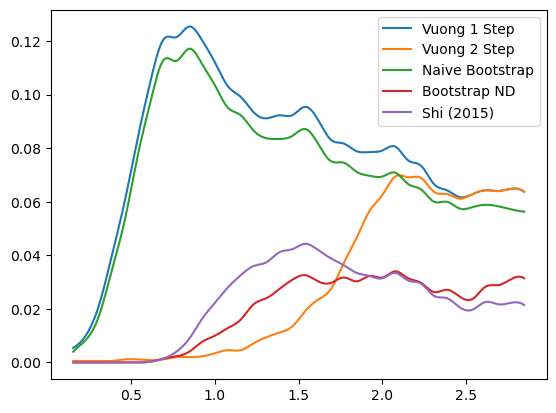

0.1 0.00020562447800032916


In [13]:
nobs =100
data_tuned_c = .95
calc_c =lambda nobs: (nobs**(-1/2), nobs**(-4/7)/350)

c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.87, 5th: 2.21, 10th: 4.13, 30th: 12.33, 50th: 22.18, 70th: 34.25, 90th: 53.95, 95th: 63.40, 99th: 84.52
bonus term 5.812623741853835 // variance stats 13.220872886396355 //part1 82.66058336935293 //part2 14.220872886396357 13.220872886396355
3.833161112575328 -1.0387396304530605 7.654003787336591
-7.792086371132341 -1.0387396304530605 -3.971243696371079
---
Quantiles: 1th: 0.66, 5th: 1.86, 10th: 3.35, 30th: 9.62, 50th: 16.44, 70th: 25.87, 90th: 40.93, 95th: 49.20, 99th: 64.90
bonus term 7.544766547564584 // variance stats 5.596374571614068 //part1 49.76810620311948 //part2 6.596374571614067 5.596374571614068
5.8166132746764845 -1.8079987089566603 9.229377274106708
-9.272919820452683 -1.8079987089566603 -5.860155821022461
---
Quantiles: 1th: 0.84, 5th: 2.08, 10th: 3.50, 30th: 9.64, 50th: 16.40, 70th: 24.54, 90th: 39.38, 95th: 46.74, 99th: 59.70
bonus term 9.511768874942014 // variance stats 3.721990311950003 //part1 44.91448047698376 //part2 4.721990311950003 3.7219903

Quantiles: 1th: 0.78, 5th: 1.93, 10th: 3.40, 30th: 9.54, 50th: 16.92, 70th: 26.27, 90th: 40.68, 95th: 49.13, 99th: 65.96
bonus term 3.191812298612375 // variance stats 14.550487362967415 //part1 49.63423681453571 //part2 15.550487362967417 14.550487362967415
1.442458447876138 -0.500390197196967 5.234245057423461
-4.9411661493486125 -0.500390197196967 -1.1493795398012892
---
Quantiles: 1th: 0.70, 5th: 1.94, 10th: 3.60, 30th: 10.83, 50th: 18.83, 70th: 28.62, 90th: 45.01, 95th: 54.04, 99th: 71.44
bonus term 2.7063803199567213 // variance stats 21.18484033387256 //part1 60.0406152809748 //part2 22.18484033387256 21.18484033387256
0.8809253856669556 -0.23303832991457735 4.699465180702713
-4.531835254246487 -0.23303832991457735 -0.7132954592107296
---
Quantiles: 1th: 0.62, 5th: 1.59, 10th: 2.89, 30th: 8.88, 50th: 15.37, 70th: 23.42, 90th: 36.71, 95th: 44.23, 99th: 58.78
bonus term 7.869430923768913 // variance stats 4.111440918702385 //part1 40.224131230654336 //part2 5.111440918702385 4.111

Quantiles: 1th: 0.58, 5th: 1.46, 10th: 2.60, 30th: 7.80, 50th: 13.55, 70th: 21.08, 90th: 33.78, 95th: 40.16, 99th: 53.22
bonus term 15.981633233417885 // variance stats 1.0748985089751426 //part1 33.16026696700636 //part2 2.0748985089751426 1.0748985089751426
14.795173867964431 -4.752466172049476 17.05433841857835
-17.16809259887134 -4.752466172049476 -14.908928048257415
---
Quantiles: 1th: 0.88, 5th: 2.16, 10th: 3.67, 30th: 10.10, 50th: 17.39, 70th: 26.63, 90th: 41.53, 95th: 50.01, 99th: 65.85
bonus term 2.9535791713868127 // variance stats 16.413745477615436 //part1 51.432875938516254 //part2 17.413745477615436 16.413745477615436
1.111494714427851 -0.3912099317270675 4.841045049203449
-4.795663628345775 -0.3912099317270675 -1.0661132935701774
---
Quantiles: 1th: 0.75, 5th: 2.12, 10th: 3.70, 30th: 10.59, 50th: 18.31, 70th: 27.74, 90th: 44.91, 95th: 52.79, 99th: 69.94
bonus term 4.0793519240758 // variance stats 13.047917261073723 //part1 57.30639830821873 //part2 14.047917261073724 13

Quantiles: 1th: 0.84, 5th: 2.21, 10th: 4.31, 30th: 13.40, 50th: 23.95, 70th: 36.98, 90th: 58.71, 95th: 70.09, 99th: 92.10
bonus term 13.0288971891958 // variance stats 6.7523726034576095 //part1 101.00486562278736 //part2 7.752372603457609 6.7523726034576095
11.083581391573055 -2.322126263480736 14.684536456337593
-14.974212986818543 -2.322126263480736 -11.373257922054005
---
Quantiles: 1th: 0.75, 5th: 1.92, 10th: 3.34, 30th: 9.94, 50th: 17.60, 70th: 27.17, 90th: 42.89, 95th: 50.71, 99th: 65.34
bonus term 3.1705224770565006 // variance stats 15.679266877250742 //part1 52.88199053514747 //part2 16.679266877250743 15.679266877250742
1.2427065348053343 -0.4660588700055092 5.003568366589266
-5.098338419307667 -0.4660588700055092 -1.3374765875237344
---
Quantiles: 1th: 0.70, 5th: 1.63, 10th: 2.67, 30th: 7.60, 50th: 13.22, 70th: 20.38, 90th: 32.75, 95th: 39.19, 99th: 51.24
bonus term 5.45082352983026 // variance stats 4.794930519460131 //part1 31.58714362920477 //part2 5.794930519460131 4.79

Quantiles: 1th: 0.73, 5th: 2.10, 10th: 3.69, 30th: 11.48, 50th: 20.07, 70th: 30.91, 90th: 49.08, 95th: 57.77, 99th: 72.74
bonus term 2.186286703199271 // variance stats 30.383862345035702 //part1 68.61412093998786 //part2 31.383862345035705 30.383862345035702
0.1506482098853807 -0.08737448080561469 4.102890489989453
-4.221925196513162 -0.08737448080561469 -0.2696829164090891
---
Quantiles: 1th: 0.73, 5th: 1.83, 10th: 3.17, 30th: 9.73, 50th: 17.15, 70th: 26.50, 90th: 42.37, 95th: 50.14, 99th: 64.62
bonus term 1.864703371518112 // variance stats 26.71894267982882 //part1 51.6876058699941 //part2 27.71894267982882 26.71894267982882
-0.1535511624768601 -0.1252584604504638 3.6342088863380977
-3.882957905513084 -0.1252584604504638 -0.09519785669812629
---
Quantiles: 1th: 0.68, 5th: 1.71, 10th: 3.03, 30th: 8.74, 50th: 14.91, 70th: 23.05, 90th: 36.00, 95th: 43.66, 99th: 58.36
bonus term 2.046548130062675 // variance stats 18.15565126355452 //part1 39.20296227356022 //part2 19.15565126355452 18

Quantiles: 1th: 0.69, 5th: 1.84, 10th: 3.09, 30th: 8.41, 50th: 14.80, 70th: 22.52, 90th: 35.76, 95th: 42.50, 99th: 57.38
bonus term 10.243299411082539 // variance stats 2.625447278065338 //part1 37.136541968317474 //part2 3.625447278065338 2.625447278065338
8.557210986551196 -3.2414708273913524 11.759258035510276
-11.929387835613882 -3.2414708273913524 -8.727340786654802
---
Quantiles: 1th: 0.70, 5th: 1.71, 10th: 2.93, 30th: 8.26, 50th: 14.67, 70th: 22.18, 90th: 34.25, 95th: 41.10, 99th: 53.14
bonus term 2.305193440654038 // variance stats 14.06431276930528 //part1 34.7261549837634 //part2 15.064312769305282 14.06431276930528
0.49815311906826903 -0.3565723074841431 4.187856389189439
-4.112233762239807 -0.3565723074841431 -0.4225304921186377
---
Quantiles: 1th: 0.71, 5th: 1.93, 10th: 3.30, 30th: 9.52, 50th: 16.47, 70th: 25.69, 90th: 40.13, 95th: 47.97, 99th: 63.66
bonus term 14.00851006034226 // variance stats 2.377787033877581 //part1 47.31776364576773 //part2 3.3777870338775804 2.3777

Quantiles: 1th: 0.74, 5th: 2.05, 10th: 3.74, 30th: 11.13, 50th: 19.19, 70th: 29.04, 90th: 45.94, 95th: 54.66, 99th: 71.16
bonus term 3.848600138808821 // variance stats 14.96507497911998 //part1 61.4431897807344 //part2 15.96507497911998 14.96507497911998
1.80617202710784 -0.8727351045459566 5.64767415219024
-5.891028250509802 -0.8727351045459566 -2.049526125427402
---
Quantiles: 1th: 0.59, 5th: 1.35, 10th: 2.28, 30th: 6.46, 50th: 11.07, 70th: 16.91, 90th: 27.11, 95th: 32.71, 99th: 42.80
bonus term 1.2297036870411677 // variance stats 16.894056238989133 //part1 22.004386933206955 //part2 17.894056238989137 16.894056238989133
-0.6824479436757864 -0.1932144241355042 3.120677714150633
-3.1418553177581217 -0.1932144241355042 0.6612703400682978
---
Quantiles: 1th: 0.58, 5th: 1.47, 10th: 2.46, 30th: 7.20, 50th: 12.67, 70th: 19.52, 90th: 30.43, 95th: 36.82, 99th: 46.68
bonus term 1.7517246434365128 // variance stats 14.912655037328367 //part1 27.87458997139226 //part2 15.912655037328367 14.91

Quantiles: 1th: 0.81, 5th: 2.04, 10th: 3.55, 30th: 10.21, 50th: 18.00, 70th: 26.93, 90th: 43.38, 95th: 52.59, 99th: 69.13
bonus term 1.677710061086763 // variance stats 32.89846004675805 //part1 56.871787475793646 //part2 33.89846004675805 32.89846004675805
-0.3960010607627125 -0.024926902076895574 3.532880463041932
-3.7514211829362387 -0.024926902076895574 0.17746034086840604
---
Quantiles: 1th: 0.83, 5th: 2.22, 10th: 3.92, 30th: 11.46, 50th: 20.53, 70th: 31.58, 90th: 49.50, 95th: 59.69, 99th: 78.19
bonus term 5.355071029684707 // variance stats 12.682136782167362 //part1 73.26881430636799 //part2 13.682136782167362 12.682136782167362
3.3999097482750598 -1.4501920396649715 7.189802755444436
-7.310232311094354 -1.4501920396649715 -3.520339303924977
---
Quantiles: 1th: 0.67, 5th: 2.13, 10th: 4.12, 30th: 11.60, 50th: 20.56, 70th: 31.03, 90th: 48.90, 95th: 58.34, 99th: 74.90
bonus term 6.962307089295112 // variance stats 9.051677190675859 //part1 69.9828633639485 //part2 10.05167719067585

Quantiles: 1th: 0.84, 5th: 2.21, 10th: 3.84, 30th: 10.81, 50th: 18.26, 70th: 28.34, 90th: 44.57, 95th: 53.60, 99th: 69.53
bonus term 2.319198322075063 // variance stats 24.475586264457974 //part1 59.08293691840946 //part2 25.475586264457974 24.475586264457974
0.5196871866919727 -0.5871460313869342 4.127897591620569
-4.118709457458153 -0.5871460313869342 -0.5104990525295572
---
Quantiles: 1th: 0.78, 5th: 1.98, 10th: 3.31, 30th: 9.68, 50th: 16.98, 70th: 26.67, 90th: 41.42, 95th: 50.07, 99th: 66.42
bonus term 2.134046816208832 // variance stats 23.158198212736842 //part1 51.55472598123295 //part2 24.158198212736842 23.158198212736842
0.28181211215172286 -0.9352791744282858 3.9870376749543035
-3.9862815202659414 -0.9352791744282858 -0.2810559574633607
---
Quantiles: 1th: 0.81, 5th: 1.90, 10th: 3.25, 30th: 9.56, 50th: 16.78, 70th: 25.17, 90th: 39.23, 95th: 46.99, 99th: 61.92
bonus term 5.4354397950418 // variance stats 7.354189661255722 //part1 45.40869494011612 //part2 8.354189661255722 7.

Quantiles: 1th: 0.87, 5th: 2.22, 10th: 3.74, 30th: 10.94, 50th: 19.77, 70th: 30.27, 90th: 47.43, 95th: 56.47, 99th: 73.74
bonus term 1.7861791918962378 // variance stats 35.7158404057114 //part1 65.58107014566481 //part2 36.7158404057114 35.7158404057114
-0.13632967305157376 -0.03262415500197952 3.5486544923696206
-3.7086880568440495 -0.03262415500197952 -0.023703891422854832
---
Quantiles: 1th: 0.80, 5th: 2.30, 10th: 3.93, 30th: 11.63, 50th: 20.25, 70th: 31.10, 90th: 50.41, 95th: 58.61, 99th: 75.74
bonus term 4.622715488028553 // variance stats 14.278278413359711 //part1 70.62713425185024 //part2 15.278278413359711 14.278278413359711
2.7390412229895937 -2.1727427093452643 6.405976657617617
-6.506389753067513 -2.1727427093452643 -2.839454318439489
---
Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.21, 30th: 9.68, 50th: 16.96, 70th: 26.31, 90th: 41.63, 95th: 49.85, 99th: 64.89
bonus term 8.872553348103104 // variance stats 4.75862657213743 //part1 51.093721473093446 //part2 5.7586265721374295

Quantiles: 1th: 0.65, 5th: 1.73, 10th: 2.82, 30th: 7.66, 50th: 13.58, 70th: 20.23, 90th: 32.31, 95th: 38.02, 99th: 50.08
bonus term 1.326639454117851 // variance stats 21.401788803980665 //part1 29.719096870176298 //part2 22.401788803980665 21.401788803980665
-0.4867857364358155 -0.5669247034738627 3.381042076486988
-3.1400646446715177 -0.5669247034738627 0.7277631682512861
---
Quantiles: 1th: 0.84, 5th: 2.04, 10th: 3.45, 30th: 10.67, 50th: 18.86, 70th: 28.74, 90th: 45.60, 95th: 54.83, 99th: 72.04
bonus term 2.2725700776492173 // variance stats 26.198824029017203 //part1 61.81123363559102 //part2 27.198824029017207 26.198824029017203
0.3374753331511922 -0.7630169641860595 4.057621663646174
-4.207664822147242 -0.7630169641860595 -0.487518491652261
---
Quantiles: 1th: 0.71, 5th: 1.52, 10th: 2.50, 30th: 6.65, 50th: 11.30, 70th: 17.50, 90th: 28.83, 95th: 33.47, 99th: 44.10
bonus term 1.04930064682669 // variance stats 20.954662516869433 //part1 23.037041579812783 //part2 21.954662516869433

Quantiles: 1th: 0.68, 5th: 1.67, 10th: 2.90, 30th: 8.32, 50th: 14.70, 70th: 22.48, 90th: 35.76, 95th: 43.49, 99th: 55.77
bonus term 1.6642453007718299 // variance stats 22.36793571648173 //part1 38.88997720489292 //part2 23.36793571648173 22.36793571648173
-0.22668455747697666 -0.5394597970417104 3.5523440109051907
-3.5551751590206364 -0.5394597970417104 0.22385340936153086
---
Quantiles: 1th: 0.85, 5th: 2.35, 10th: 3.90, 30th: 11.10, 50th: 19.13, 70th: 28.78, 90th: 45.82, 95th: 54.34, 99th: 71.47
bonus term 2.4131380365659387 // variance stats 24.16331882073465 //part1 60.72256177255036 //part2 25.163318820734652 24.16331882073465
0.4428857560189099 -0.7547292822588042 4.325025227430504
-4.383390317112967 -0.7547292822588042 -0.501250845701374
---
Quantiles: 1th: 0.77, 5th: 1.88, 10th: 3.38, 30th: 10.30, 50th: 18.01, 70th: 27.15, 90th: 43.64, 95th: 52.47, 99th: 70.02
bonus term 5.35323110652552 // variance stats 9.573788268243762 //part1 56.60393227137711 //part2 10.573788268243762 9.

Quantiles: 1th: 0.67, 5th: 1.87, 10th: 3.63, 30th: 10.78, 50th: 18.86, 70th: 28.51, 90th: 45.60, 95th: 53.44, 99th: 70.04
bonus term 1.2339343290159812 // variance stats 46.58198259091161 //part1 58.71304176156661 //part2 47.5819825909116 46.58198259091161
-0.854604788351482 -0.05957036423375527 3.0746469974629145
-3.3224734463834444 -0.05957036423375527 0.6067783394309524
---
Quantiles: 1th: 0.79, 5th: 2.27, 10th: 3.90, 30th: 10.99, 50th: 19.10, 70th: 29.32, 90th: 46.68, 95th: 55.99, 99th: 72.90
bonus term 5.019814006809975 // variance stats 11.84205783680502 //part1 64.46474180545765 //part2 12.84205783680502 11.84205783680502
3.0111085918229863 -3.1313457514441456 6.78863045040709
-7.028519421796964 -3.1313457514441456 -3.25099756321286
---
Quantiles: 1th: 0.79, 5th: 1.90, 10th: 3.16, 30th: 9.10, 50th: 15.95, 70th: 24.59, 90th: 39.37, 95th: 46.63, 99th: 62.89
bonus term 1.026083370796235 // variance stats 42.56932455385318 //part1 44.70575940153282 //part2 43.56932455385318 42.56932

Quantiles: 1th: 0.81, 5th: 2.07, 10th: 3.79, 30th: 11.73, 50th: 19.91, 70th: 29.96, 90th: 47.28, 95th: 56.63, 99th: 74.59
bonus term 2.0676970982684244 // variance stats 30.888985780452472 //part1 65.93676336496463 //part2 31.888985780452472 30.888985780452472
0.22416663899460418 -0.9942426866456577 4.065490586055899
-3.911227557542245 -0.9942426866456577 -0.06990361048094898
---
Quantiles: 1th: 0.79, 5th: 1.93, 10th: 3.50, 30th: 9.82, 50th: 17.07, 70th: 26.50, 90th: 42.10, 95th: 49.74, 99th: 65.22
bonus term 2.192444796363208 // variance stats 22.20221303659546 //part1 50.8695712361943 //part2 23.20221303659546 22.20221303659546
0.08577251198188483 -1.9554233081485184 4.154307036570332
-4.299117080744531 -1.9554233081485184 -0.230582556156084
---
Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.50, 30th: 10.74, 50th: 18.54, 70th: 27.93, 90th: 44.57, 95th: 53.27, 99th: 70.67
bonus term 1.1803071076937108 // variance stats 48.43384333832269 //part1 58.34711665283966 //part2 49.43384333832269 48

Quantiles: 1th: 0.80, 5th: 2.03, 10th: 3.27, 30th: 8.93, 50th: 15.50, 70th: 23.67, 90th: 37.16, 95th: 43.85, 99th: 58.30
bonus term 0.8041250545378501 // variance stats 48.164758522963275 //part1 39.53461412861807 //part2 49.16475852296327 48.164758522963275
-1.0878090369896365 -0.022949414623857883 2.764305695385987
-2.6960591460653363 -0.022949414623857883 1.1560555863102866
---
Quantiles: 1th: 0.78, 5th: 2.12, 10th: 3.73, 30th: 11.23, 50th: 19.83, 70th: 30.78, 90th: 47.46, 95th: 56.09, 99th: 73.84
bonus term 4.811222253426237 // variance stats 12.445571641487694 //part1 64.68963349156233 //part2 13.445571641487694 12.445571641487694
2.8489708755513754 -3.8163970101539255 6.6153961372357575
-6.7734736313010995 -3.8163970101539255 -3.007048369616718
---
Quantiles: 1th: 0.84, 5th: 1.96, 10th: 3.48, 30th: 10.25, 50th: 17.44, 70th: 27.07, 90th: 42.44, 95th: 50.62, 99th: 66.70
bonus term 2.3251167419211685 // variance stats 21.658925728131706 //part1 52.68464756442734 //part2 22.658925728

Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.14, 30th: 9.69, 50th: 16.85, 70th: 25.76, 90th: 41.02, 95th: 47.95, 99th: 63.94
bonus term 2.0848119558418334 // variance stats 21.68059584754522 //part1 47.284777388578924 //part2 22.68059584754522 21.68059584754522
0.09476584429628623 -1.6699802118490672 3.9224888140387044
-4.07485806738738 -1.6699802118490672 -0.24713509764496241
---
Quantiles: 1th: 0.62, 5th: 1.69, 10th: 2.87, 30th: 8.19, 50th: 14.28, 70th: 21.73, 90th: 34.80, 95th: 42.09, 99th: 54.25
bonus term 1.9124814842574918 // variance stats 18.04559089034584 //part1 36.42433993452958 //part2 19.045590890345842 18.04559089034584
-0.003340907181067579 -2.2977285161969943 3.6700405227313677
-3.8283038756960512 -2.2977285161969943 -0.15492244578361616
---
Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.57, 30th: 10.66, 50th: 18.47, 70th: 28.23, 90th: 44.94, 95th: 53.97, 99th: 70.94
bonus term 3.4024531149069905 // variance stats 16.60549122352284 //part1 59.90185845294297 //part2 17.60549122352

Quantiles: 1th: 0.68, 5th: 1.83, 10th: 3.18, 30th: 9.55, 50th: 16.35, 70th: 25.56, 90th: 40.17, 95th: 48.06, 99th: 64.91
bonus term 4.139447982444893 // variance stats 10.473835707628385 //part1 47.49534607084649 //part2 11.473835707628385 10.473835707628385
2.296563665822095 -4.749781862353688 5.816565135219606
-5.982332299067691 -4.749781862353688 -2.4623308296701794
---
Quantiles: 1th: 0.70, 5th: 1.86, 10th: 3.16, 30th: 9.61, 50th: 16.63, 70th: 25.67, 90th: 41.21, 95th: 48.84, 99th: 63.33
bonus term 4.853225983064508 // variance stats 9.105269117803333 //part1 49.04315464838249 //part2 10.105269117803333 9.105269117803333
2.856339714511184 -4.493318971720485 6.532683776648959
-6.8501122516178325 -4.493318971720485 -3.173768189480058
---
Quantiles: 1th: 0.69, 5th: 1.73, 10th: 2.87, 30th: 8.39, 50th: 14.57, 70th: 22.09, 90th: 34.97, 95th: 42.36, 99th: 55.53
bonus term 2.6259729748941907 // variance stats 13.049026561435806 //part1 36.89236407390109 //part2 14.049026561435806 13.049026

Quantiles: 1th: 0.63, 5th: 1.66, 10th: 3.06, 30th: 9.06, 50th: 15.99, 70th: 24.16, 90th: 38.51, 95th: 45.88, 99th: 59.57
bonus term 1.9614061441512878 // variance stats 21.065970012944298 //part1 43.28032916004702 //part2 22.065970012944298 21.065970012944298
-0.03381730457023512 -2.5034404707656517 3.745958090264126
-3.9566295928728104 -2.5034404707656517 -0.17685419803844965
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.38, 30th: 10.08, 50th: 17.47, 70th: 26.26, 90th: 40.70, 95th: 48.52, 99th: 62.39
bonus term 3.7562520027614656 // variance stats 11.887399238019501 //part1 48.40831919819733 //part2 12.887399238019501 11.887399238019501
1.905740366919566 -3.7946428891741903 5.595984426306819
-5.606763638603365 -3.7946428891741903 -1.9165195792161134
---
Quantiles: 1th: 0.76, 5th: 1.91, 10th: 3.50, 30th: 10.73, 50th: 19.09, 70th: 29.58, 90th: 46.94, 95th: 56.35, 99th: 73.63
bonus term 2.9150469261141927 // variance stats 21.399530293341243 //part1 65.29568192800613 //part2 22.3995302933

Quantiles: 1th: 0.67, 5th: 1.71, 10th: 3.23, 30th: 9.64, 50th: 16.93, 70th: 26.48, 90th: 41.54, 95th: 49.95, 99th: 66.90
bonus term 1.7320439335309534 // variance stats 28.622994375884723 //part1 51.30832770177268 //part2 29.622994375884723 28.622994375884723
-0.09203824355752051 -1.2345817507307497 3.650842146214293
-3.5561261106194273 -1.2345817507307497 0.18675427915238604
---
Quantiles: 1th: 0.83, 5th: 2.18, 10th: 3.66, 30th: 10.82, 50th: 19.21, 70th: 29.05, 90th: 45.32, 95th: 53.75, 99th: 70.45
bonus term 2.1021850879821007 // variance stats 27.258634330438667 //part1 59.40487969618723 //part2 28.25863433043867 27.258634330438667
-0.01219338337348781 -2.716805488835557 4.024953094400328
-4.216563559337689 -2.716805488835557 -0.17941708156387387
---
Quantiles: 1th: 0.68, 5th: 1.77, 10th: 3.01, 30th: 8.40, 50th: 14.72, 70th: 22.19, 90th: 35.49, 95th: 42.72, 99th: 56.11
bonus term 1.1486662858270957 // variance stats 31.665076582034427 //part1 37.52127219374313 //part2 32.66507658203

Quantiles: 1th: 0.73, 5th: 1.70, 10th: 2.94, 30th: 9.59, 50th: 16.77, 70th: 25.63, 90th: 40.29, 95th: 48.30, 99th: 63.13
bonus term 1.5947925820773567 // variance stats 29.077564994290775 //part1 47.96747753984451 //part2 30.07756499429078 29.077564994290775
-0.2626858798012804 -2.1200998234203414 3.521818460331693
-3.4522710439559936 -2.1200998234203414 0.33223329617697966
---
Quantiles: 1th: 0.83, 5th: 1.98, 10th: 3.32, 30th: 9.27, 50th: 16.41, 70th: 25.15, 90th: 39.47, 95th: 47.45, 99th: 61.63
bonus term 2.6898059123240134 // variance stats 16.209143316324372 //part1 46.28925543828058 //part2 17.209143316324372 16.209143316324372
0.6310087101261173 -3.5965368236004425 4.5099250362767
-4.748603114521909 -3.5965368236004425 -0.8696867883713278
---
Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.48, 30th: 10.34, 50th: 18.39, 70th: 28.54, 90th: 46.01, 95th: 55.51, 99th: 71.19
bonus term 3.4576344178606573 // variance stats 17.323368661548727 //part1 63.355510135320245 //part2 18.32336866154872

Quantiles: 1th: 0.67, 5th: 1.81, 10th: 2.98, 30th: 8.58, 50th: 15.18, 70th: 23.45, 90th: 37.09, 95th: 43.60, 99th: 57.94
bonus term 1.651628564899879 // variance stats 22.662075344285814 //part1 39.08095954343559 //part2 23.662075344285817 22.662075344285814
-0.3486031686958171 -3.2047253003198284 3.3489771097430867
-3.651860298495575 -3.2047253003198284 0.04571997994332864
---
Quantiles: 1th: 0.70, 5th: 1.73, 10th: 2.83, 30th: 8.33, 50th: 14.77, 70th: 22.86, 90th: 36.30, 95th: 43.35, 99th: 56.08
bonus term 2.9226959211411137 // variance stats 12.223485978068984 //part1 38.648228531368936 //part2 13.223485978068986 12.223485978068984
0.8284754013126634 -6.703261136752034 4.756265892345551
-5.016916440969564 -6.703261136752034 -1.0891259499366759
---
Quantiles: 1th: 0.76, 5th: 2.07, 10th: 3.81, 30th: 11.15, 50th: 19.84, 70th: 30.55, 90th: 47.46, 95th: 56.64, 99th: 74.53
bonus term 1.1147825889557494 // variance stats 58.183106068962914 //part1 65.97629620600121 //part2 59.18310606896291

Quantiles: 1th: 0.75, 5th: 1.91, 10th: 3.21, 30th: 9.02, 50th: 15.89, 70th: 24.93, 90th: 39.43, 95th: 47.31, 99th: 61.36
bonus term 1.3209164968095706 // variance stats 33.838746434636676 //part1 46.0190748936772 //part2 34.838746434636676 33.838746434636676
-0.8330300292392907 -1.5865475650729015 3.2830497517896524
-3.474863022858432 -1.5865475650729015 0.6412167581705113
---
Quantiles: 1th: 0.77, 5th: 1.92, 10th: 3.35, 30th: 9.63, 50th: 16.60, 70th: 25.37, 90th: 40.06, 95th: 48.04, 99th: 63.81
bonus term 3.5158078956373298 // variance stats 12.49928758870228 //part1 47.46090188983849 //part2 13.499287588702282 12.49928758870228
1.3315999530927236 -6.194092158220685 5.277606474401242
-5.700015838181935 -6.194092158220685 -1.7540093168734177
---
Quantiles: 1th: 0.69, 5th: 1.64, 10th: 2.56, 30th: 6.90, 50th: 11.85, 70th: 18.18, 90th: 29.16, 95th: 34.87, 99th: 46.16
bonus term 1.5901521494142992 // variance stats 14.719124756965305 //part1 24.995800019199905 //part2 15.719124756965305 14

Quantiles: 1th: 0.99, 5th: 2.28, 10th: 3.80, 30th: 11.24, 50th: 19.72, 70th: 30.31, 90th: 47.81, 95th: 57.68, 99th: 76.32
bonus term 1.3681005077437158 // variance stats 48.99946317757626 //part1 68.40429096015531 //part2 49.99946317757626 48.99946317757626
-0.6293926222329247 -1.4235061085298686 3.4254703999243974
-3.365593637720356 -1.4235061085298686 0.6892693844369655
---
Quantiles: 1th: 0.74, 5th: 2.00, 10th: 3.77, 30th: 11.42, 50th: 19.82, 70th: 29.94, 90th: 46.83, 95th: 56.91, 99th: 73.04
bonus term 4.391006245189664 // variance stats 14.164052797524512 //part1 66.58545053631593 //part2 15.164052797524512 14.164052797524512
2.690986432108866 -6.045540616111022 6.097019704908996
-6.0910260582704625 -6.045540616111022 -2.6849927854703326
---
Quantiles: 1th: 0.85, 5th: 2.09, 10th: 3.55, 30th: 10.10, 50th: 17.91, 70th: 27.38, 90th: 42.71, 95th: 50.55, 99th: 65.27
bonus term 1.9215668023052326 // variance stats 26.349270391747325 //part1 52.55345005205109 //part2 27.349270391747325 2

Quantiles: 1th: 0.71, 5th: 1.76, 10th: 3.05, 30th: 9.29, 50th: 16.26, 70th: 25.12, 90th: 39.54, 95th: 47.07, 99th: 61.30
bonus term 3.247243375032984 // variance stats 13.029460597860714 //part1 45.557072981689494 //part2 14.029460597860714 13.029460597860714
1.2409077172811933 -5.051394512395355 4.940804883557923
-5.253579032784774 -5.051394512395355 -1.553681866508045
---
Quantiles: 1th: 0.83, 5th: 2.26, 10th: 4.11, 30th: 11.95, 50th: 20.54, 70th: 31.63, 90th: 50.55, 95th: 59.74, 99th: 78.56
bonus term 2.3312009224375347 // variance stats 30.48194141839826 //part1 73.39073087469446 //part2 31.481941418398264 30.48194141839826
0.22174193687871155 -3.5460918527132868 4.064175833058981
-4.440659907996358 -3.5460918527132868 -0.5982260118160891
---
Quantiles: 1th: 0.75, 5th: 1.86, 10th: 3.23, 30th: 9.19, 50th: 16.13, 70th: 24.70, 90th: 39.40, 95th: 47.34, 99th: 61.05
bonus term 2.5369365999692675 // variance stats 17.163075697035516 //part1 46.07857150382171 //part2 18.163075697035516 17

Quantiles: 1th: 0.79, 5th: 2.15, 10th: 4.15, 30th: 11.56, 50th: 20.30, 70th: 31.54, 90th: 49.88, 95th: 60.04, 99th: 80.92
bonus term 5.336429541177694 // variance stats 12.892298999828903 //part1 74.13527477756028 //part2 13.892298999828903 12.892298999828903
2.8568005371976577 -7.404332471336819 7.391656493957536
-7.81605854515773 -7.404332471336819 -3.2812025883978504
---
Quantiles: 1th: 0.65, 5th: 1.67, 10th: 2.88, 30th: 8.59, 50th: 15.03, 70th: 23.12, 90th: 37.08, 95th: 43.33, 99th: 55.37
bonus term 1.4413338438363843 // variance stats 25.78536217059391 //part1 38.606649015891804 //part2 26.785362170593913 25.78536217059391
-0.5966313261358829 -3.3128304179510333 3.2258502629983363
-3.4792990138086517 -3.3128304179510333 0.34318257532556784
---
Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.12, 30th: 9.41, 50th: 16.54, 70th: 25.92, 90th: 40.03, 95th: 46.97, 99th: 62.30
bonus term 1.2231858575952188 // variance stats 36.07994771209142 //part1 45.35566764180041 //part2 37.07994771209142 36

Quantiles: 1th: 0.82, 5th: 2.03, 10th: 3.33, 30th: 9.51, 50th: 16.48, 70th: 25.35, 90th: 40.34, 95th: 46.85, 99th: 61.83
bonus term 1.80246234141893 // variance stats 24.03509076563063 //part1 45.124808319054026 //part2 25.03509076563063 24.03509076563063
-0.24327480377824406 -4.4208195173377876 3.7152163797791498
-3.848199486616104 -4.4208195173377876 0.11029169694128979
---
Quantiles: 1th: 0.68, 5th: 1.87, 10th: 3.06, 30th: 9.14, 50th: 16.37, 70th: 24.94, 90th: 40.05, 95th: 47.28, 99th: 62.36
bonus term 1.5737535966218115 // variance stats 28.21020477546883 //part1 45.96966482345369 //part2 29.21020477546883 28.21020477546883
-0.3453005258814098 -2.6906332129868655 3.4937452075588835
-3.492807719125033 -2.6906332129868655 0.3462380143152604
---
Quantiles: 1th: 0.75, 5th: 1.78, 10th: 3.16, 30th: 8.82, 50th: 15.31, 70th: 24.08, 90th: 38.68, 95th: 46.84, 99th: 61.03
bonus term 2.1572285125142066 // variance stats 19.911587046428984 //part1 45.11107181847935 //part2 20.911587046428984 19

Quantiles: 1th: 0.71, 5th: 1.87, 10th: 3.16, 30th: 9.09, 50th: 15.60, 70th: 23.75, 90th: 38.38, 95th: 46.00, 99th: 59.71
bonus term 1.4379593797775063 // variance stats 29.252514354135563 //part1 43.50188677738288 //part2 30.252514354135563 29.252514354135563
-0.7516337854915125 -4.613870277669501 3.35572953778141
-3.6275525450465254 -4.613870277669501 0.47981077822639706
---
Quantiles: 1th: 0.66, 5th: 1.80, 10th: 3.15, 30th: 9.57, 50th: 16.55, 70th: 25.58, 90th: 41.48, 95th: 49.28, 99th: 63.17
bonus term 1.437916600854558 // variance stats 33.73067884141947 //part1 49.93981966502521 //part2 34.73067884141947 33.73067884141947
-0.44957397087247425 -3.2023794276354667 3.333892445064886
-3.3254071725815906 -3.2023794276354667 0.4580592433557701
---
Quantiles: 1th: 0.67, 5th: 1.74, 10th: 3.21, 30th: 8.75, 50th: 15.12, 70th: 22.96, 90th: 36.47, 95th: 44.56, 99th: 56.01
bonus term 2.050910701704213 // variance stats 18.90778844372025 //part1 40.82909636648932 //part2 19.90778844372025 18.90

Quantiles: 1th: 0.82, 5th: 2.21, 10th: 3.72, 30th: 10.48, 50th: 18.69, 70th: 28.50, 90th: 44.62, 95th: 54.25, 99th: 69.95
bonus term 3.0582903786249735 // variance stats 18.789267490301217 //part1 60.5213263656242 //part2 19.78926749030122 18.789267490301217
0.06677780308667185 -8.303726240286903 5.338182992500192
-6.049802954163275 -8.303726240286903 -0.7783977647497549
---
Quantiles: 1th: 0.70, 5th: 1.81, 10th: 3.41, 30th: 10.53, 50th: 18.27, 70th: 28.45, 90th: 45.09, 95th: 53.24, 99th: 70.88
bonus term 2.89885523033796 // variance stats 19.104335923514867 //part1 58.27955934435241 //part2 20.104335923514864 19.104335923514867
0.5344764826227563 -6.249872561447103 4.878326390464078
-5.263233978053164 -6.249872561447103 -0.9193840702118419
---
Quantiles: 1th: 0.78, 5th: 2.06, 10th: 3.42, 30th: 11.10, 50th: 19.84, 70th: 29.99, 90th: 48.05, 95th: 56.64, 99th: 75.24
bonus term 2.8737712382882403 // variance stats 21.95251786053978 //part1 65.96028567391635 //part2 22.95251786053978 21.95

Quantiles: 1th: 0.79, 5th: 1.85, 10th: 2.99, 30th: 8.36, 50th: 14.59, 70th: 22.37, 90th: 36.46, 95th: 43.41, 99th: 55.64
bonus term 1.770653666813373 // variance stats 20.87980163353886 //part1 38.741550991574805 //part2 21.87980163353886 20.87980163353886
-0.3387798055673106 -6.61002955425065 3.7656829723849157
-3.8800871391940563 -6.61002955425065 0.22437563875816988
---
Quantiles: 1th: 0.91, 5th: 2.48, 10th: 4.50, 30th: 13.58, 50th: 23.65, 70th: 36.37, 90th: 57.63, 95th: 69.53, 99th: 89.24
bonus term 4.494894507977138 // variance stats 21.117584897387847 //part1 99.41621088498674 //part2 22.117584897387847 21.117584897387847
2.2392126069107614 -7.829644320627262 6.531291433790887
-6.750576409043514 -7.829644320627262 -2.4584975821633885
---
Quantiles: 1th: 0.60, 5th: 1.44, 10th: 2.78, 30th: 8.38, 50th: 14.48, 70th: 22.14, 90th: 34.67, 95th: 41.72, 99th: 54.88
bonus term 1.5841077658198162 // variance stats 21.594403164167893 //part1 35.79196951642219 //part2 22.594403164167893 21.59

Quantiles: 1th: 0.93, 5th: 2.46, 10th: 4.19, 30th: 12.46, 50th: 21.47, 70th: 32.26, 90th: 51.05, 95th: 60.76, 99th: 79.25
bonus term 3.25809365104637 // variance stats 22.301050446177648 //part1 75.91700452140257 //part2 23.301050446177648 22.301050446177648
0.9812739784075445 -6.214501733651714 4.921182251676046
-5.534913323685195 -6.214501733651714 -1.5950050504166942
---
Quantiles: 1th: 0.82, 5th: 2.09, 10th: 3.79, 30th: 10.74, 50th: 18.28, 70th: 28.17, 90th: 44.82, 95th: 53.33, 99th: 68.21
bonus term 3.2404148853193027 // variance stats 17.04832244984615 //part1 58.484052721524016 //part2 18.048322449846154 17.04832244984615
0.6797866164525616 -9.036067869650946 5.147844156803228
-5.801043154186043 -9.036067869650946 -1.3329856138353768
---
Quantiles: 1th: 1.08, 5th: 2.72, 10th: 4.62, 30th: 12.89, 50th: 22.90, 70th: 34.55, 90th: 55.97, 95th: 66.27, 99th: 87.01
bonus term 2.332250490703983 // variance stats 37.71561158790169 //part1 90.29450412378851 //part2 38.71561158790169 37.715

Quantiles: 1th: 0.62, 5th: 1.96, 10th: 3.65, 30th: 10.66, 50th: 18.98, 70th: 29.02, 90th: 46.25, 95th: 55.82, 99th: 72.27
bonus term 2.9800080959286 // variance stats 20.501678297077966 //part1 64.07517540134462 //part2 21.50167829707797 20.501678297077966
0.4797165208501231 -6.924173190339612 5.011070576100866
-5.480299671007077 -6.924173190339612 -0.9489456157563345
---
Quantiles: 1th: 0.73, 5th: 1.78, 10th: 3.11, 30th: 8.80, 50th: 15.54, 70th: 23.74, 90th: 36.98, 95th: 44.19, 99th: 60.32
bonus term 2.003670576011457 // variance stats 19.03773490644063 //part1 40.14901984195278 //part2 20.03773490644063 19.03773490644063
0.07739346485818271 -10.187920382282993 3.6939097072179163
-3.9299476871647308 -10.187920382282993 -0.3134314448049974
---
Quantiles: 1th: 0.62, 5th: 1.74, 10th: 3.17, 30th: 9.27, 50th: 16.48, 70th: 24.90, 90th: 39.54, 95th: 47.08, 99th: 62.45
bonus term 2.2410565263339253 // variance stats 19.337901759481653 //part1 45.57838747002458 //part2 20.337901759481653 19.33

Quantiles: 1th: 0.73, 5th: 2.01, 10th: 3.52, 30th: 10.42, 50th: 18.05, 70th: 27.57, 90th: 44.22, 95th: 52.95, 99th: 68.67
bonus term 1.9085722360205073 // variance stats 29.203624051582473 //part1 57.645798292051545 //part2 30.203624051582473 29.203624051582473
-0.3575230819991009 -4.953661133973845 3.957350848380721
-4.1746675540401155 -4.953661133973845 0.1402063763397062
---
Quantiles: 1th: 0.76, 5th: 2.02, 10th: 3.79, 30th: 10.96, 50th: 19.54, 70th: 30.35, 90th: 48.42, 95th: 56.95, 99th: 74.89
bonus term 1.345359521368523 // variance stats 48.57284827563896 //part1 66.69330342898803 //part2 49.57284827563896 48.57284827563896
-0.7200342247128214 -3.7174438886335395 3.113655058256065
-3.4107532674498673 -3.7174438886335395 0.422936015519019
---
Quantiles: 1th: 0.60, 5th: 1.61, 10th: 2.71, 30th: 8.06, 50th: 14.36, 70th: 21.56, 90th: 34.03, 95th: 40.58, 99th: 52.71
bonus term 1.463570027963239 // variance stats 22.138648258330427 //part1 33.86503207847622 //part2 23.13864825833043 22.

Quantiles: 1th: 0.85, 5th: 2.19, 10th: 3.86, 30th: 11.07, 50th: 18.88, 70th: 28.53, 90th: 46.27, 95th: 53.89, 99th: 71.36
bonus term 2.520062146662621 // variance stats 22.697164164540283 //part1 59.71832639430793 //part2 23.697164164540286 22.697164164540283
0.40054399112966826 -6.359648730464772 4.402816839269524
-4.639580302195574 -6.359648730464772 -0.6373074540557183
---
Quantiles: 1th: 0.55, 5th: 1.55, 10th: 2.72, 30th: 8.86, 50th: 14.70, 70th: 22.39, 90th: 36.19, 95th: 43.07, 99th: 55.53
bonus term 2.0882560022719976 // variance stats 17.263113706181272 //part1 38.13805681710903 //part2 18.263113706181272 17.263113706181272
-0.3420466654259727 -11.986134534319257 3.824300054722298
-4.518558669969967 -11.986134534319257 -0.3522119498216971
---
Quantiles: 1th: 0.68, 5th: 1.91, 10th: 3.32, 30th: 9.62, 50th: 16.74, 70th: 25.98, 90th: 42.34, 95th: 49.84, 99th: 63.78
bonus term 2.0139484140454598 // variance stats 24.35752283256361 //part1 51.06874289276302 //part2 25.35752283256361 2

Quantiles: 1th: 0.67, 5th: 1.86, 10th: 3.57, 30th: 10.74, 50th: 18.82, 70th: 28.68, 90th: 45.93, 95th: 54.16, 99th: 72.18
bonus term 2.6938079645652726 // variance stats 21.392677682939873 //part1 60.32157349024647 //part2 22.392677682939876 21.392677682939873
0.24335818076792276 -9.380207615871692 4.814893221748516
-5.144257748362622 -9.380207615871692 -0.5727227073820291
---
Quantiles: 1th: 0.76, 5th: 2.08, 10th: 4.00, 30th: 11.95, 50th: 20.67, 70th: 31.56, 90th: 49.38, 95th: 59.18, 99th: 79.41
bonus term 3.322571677587365 // variance stats 20.67622266632142 //part1 72.02080350819682 //part2 21.67622266632142 20.67622266632142
0.43034722402817227 -9.009860168501683 5.612335355072624
-6.214796131146557 -9.009860168501683 -1.0328080001021058
---
Quantiles: 1th: 0.81, 5th: 1.94, 10th: 3.06, 30th: 8.84, 50th: 15.29, 70th: 23.02, 90th: 36.52, 95th: 43.35, 99th: 55.92
bonus term 1.4672777682825324 // variance stats 25.33668051711441 //part1 38.64322581312168 //part2 26.33668051711441 25.33

Quantiles: 1th: 0.67, 5th: 1.64, 10th: 2.84, 30th: 8.28, 50th: 14.46, 70th: 21.69, 90th: 34.65, 95th: 41.09, 99th: 54.52
bonus term 1.7571336727443172 // variance stats 18.75776581573249 //part1 34.71703561302016 //part2 19.757765815732494 18.75776581573249
-1.0041503041518878 -9.417599727741397 3.886864831295468
-4.518417649640522 -9.417599727741397 0.3725974858068338
---
Quantiles: 1th: 0.68, 5th: 1.82, 10th: 3.22, 30th: 9.55, 50th: 17.28, 70th: 26.72, 90th: 42.27, 95th: 50.91, 99th: 67.65
bonus term 1.227567691054107 // variance stats 42.41245985725048 //part1 53.29173310994408 //part2 43.41245985725048 42.41245985725048
-1.058310531554014 -4.486749633783489 3.0573187264059802
-3.513445913662228 -4.486749633783489 0.6021833442977663
---
Quantiles: 1th: 0.92, 5th: 2.23, 10th: 3.80, 30th: 11.06, 50th: 19.33, 70th: 29.68, 90th: 47.56, 95th: 56.72, 99th: 74.05
bonus term 1.2565125634314247 // variance stats 51.65215443524386 //part1 66.15809353961552 //part2 52.65215443524386 51.6521544

Quantiles: 1th: 0.67, 5th: 1.81, 10th: 2.91, 30th: 8.31, 50th: 14.57, 70th: 22.03, 90th: 35.61, 95th: 41.98, 99th: 55.29
bonus term 1.4811401220663063 // variance stats 23.466585521505312 //part1 36.23844146586811 //part2 24.466585521505312 23.466585521505312
-1.2472954055229044 -8.186380883209022 3.583768635072548
-4.209575649655517 -8.186380883209022 0.6214883909399356
---
Quantiles: 1th: 0.62, 5th: 1.70, 10th: 3.10, 30th: 9.15, 50th: 16.00, 70th: 24.32, 90th: 39.04, 95th: 46.69, 99th: 62.52
bonus term 1.524773517553948 // variance stats 28.397787975105068 //part1 44.82496857910611 //part2 29.397787975105068 28.397787975105068
-0.6649420248855643 -7.0771392339922805 3.4526448019868647
-3.7144890599934604 -7.0771392339922805 0.4030977668789689
---
Quantiles: 1th: 0.85, 5th: 1.99, 10th: 3.56, 30th: 10.62, 50th: 18.31, 70th: 28.07, 90th: 44.93, 95th: 53.40, 99th: 69.69
bonus term 2.7240322957681573 // variance stats 20.529028206371297 //part1 58.64576813065903 //part2 21.5290282063713 2

Quantiles: 1th: 0.90, 5th: 2.00, 10th: 3.64, 30th: 10.28, 50th: 17.57, 70th: 27.15, 90th: 43.41, 95th: 52.08, 99th: 67.02
bonus term 2.4149992550920127 // variance stats 22.092769756684202 //part1 55.76902176040372 //part2 23.092769756684206 22.092769756684202
0.17175274192980303 -9.046839426862869 4.454619105900129
-4.658245768254223 -9.046839426862869 -0.3753794042838967
---
Quantiles: 1th: 0.70, 5th: 1.96, 10th: 3.46, 30th: 10.08, 50th: 17.21, 70th: 26.33, 90th: 41.17, 95th: 48.43, 99th: 64.83
bonus term 1.9995167890140673 // variance stats 23.1165351605398 //part1 48.221416946347404 //part2 24.116535160539804 23.1165351605398
-0.46264873741266666 -9.281611424153006 4.131830795776698
-4.461682315440801 -9.281611424153006 0.13279721774856348
---
Quantiles: 1th: 0.72, 5th: 1.93, 10th: 3.54, 30th: 10.52, 50th: 18.29, 70th: 28.37, 90th: 45.30, 95th: 53.35, 99th: 69.84
bonus term 1.763986369861472 // variance stats 32.173450511679484 //part1 58.51751454387668 //part2 33.173450511679484 3

Quantiles: 1th: 0.81, 5th: 1.96, 10th: 3.40, 30th: 10.59, 50th: 18.48, 70th: 28.58, 90th: 44.61, 95th: 52.91, 99th: 69.71
bonus term 1.2572193786654848 // variance stats 44.779447868157106 //part1 57.554809004453425 //part2 45.7794478681571 44.779447868157106
-1.0179936859825958 -4.974525053374555 3.0962362619685453
-3.5324324433135654 -4.974525053374555 0.5817975046375756
---
Quantiles: 1th: 0.75, 5th: 1.87, 10th: 2.99, 30th: 8.39, 50th: 14.91, 70th: 22.25, 90th: 34.90, 95th: 41.88, 99th: 55.28
bonus term 0.9527565680965375 // variance stats 36.861964264310686 //part1 36.0732351338584 //part2 37.86196426431069 36.861964264310686
-1.3957769700129414 -6.510268260213834 2.9250260473531178
-3.3012901062060167 -6.510268260213834 1.0195129111600427
---
Quantiles: 1th: 0.58, 5th: 1.59, 10th: 2.83, 30th: 8.25, 50th: 14.63, 70th: 22.82, 90th: 36.31, 95th: 42.86, 99th: 56.28
bonus term 1.1279421816978619 // variance stats 32.4904390396715 //part1 37.77527887642632 //part2 33.49043903967151 32.4

Quantiles: 1th: 0.71, 5th: 1.76, 10th: 2.87, 30th: 8.08, 50th: 13.82, 70th: 21.37, 90th: 33.77, 95th: 39.70, 99th: 52.44
bonus term 1.2553412893102596 // variance stats 24.81820435000156 //part1 32.410657936406714 //part2 25.818204350001565 24.81820435000156
-1.2144157113481857 -10.324655977790803 3.555971898222613
-3.725098289968705 -10.324655977790803 1.0452893196020938
---
Quantiles: 1th: 0.72, 5th: 1.63, 10th: 2.71, 30th: 7.96, 50th: 13.81, 70th: 21.73, 90th: 34.19, 95th: 40.16, 99th: 54.52
bonus term 0.799764200205337 // variance stats 40.458244888307675 //part1 33.15682006501439 //part2 41.458244888307675 40.458244888307675
-1.0334440604495052 -5.279708885768917 2.752844302899669
-2.632972460860179 -5.279708885768917 1.153315902488995
---
Quantiles: 1th: 0.67, 5th: 1.81, 10th: 3.25, 30th: 9.79, 50th: 16.96, 70th: 25.75, 90th: 41.24, 95th: 48.49, 99th: 63.10
bonus term 1.8823487476068337 // variance stats 24.689999004749083 //part1 48.35753745261024 //part2 25.689999004749083 24.6

Quantiles: 1th: 0.89, 5th: 2.24, 10th: 3.68, 30th: 10.69, 50th: 19.07, 70th: 29.55, 90th: 46.69, 95th: 55.64, 99th: 72.60
bonus term 2.5065885055282453 // variance stats 24.39507376112936 //part1 63.65499998668881 //part2 25.395073761129364 24.39507376112936
0.13939786225982953 -10.188441944457821 4.460907832050693
-4.873779148796662 -10.188441944457821 -0.5522691790057978
---
Quantiles: 1th: 0.88, 5th: 2.21, 10th: 3.84, 30th: 10.50, 50th: 17.81, 70th: 27.15, 90th: 43.56, 95th: 52.97, 99th: 67.78
bonus term 2.156148565299794 // variance stats 25.760264026740156 //part1 57.69910488829948 //part2 26.760264026740156 25.760264026740156
-0.8344530225154776 -11.761516324679128 4.660064016469573
-5.146750153115066 -11.761516324679128 0.3477668858699844
---
Quantiles: 1th: 0.86, 5th: 2.26, 10th: 3.99, 30th: 11.68, 50th: 20.26, 70th: 31.38, 90th: 50.39, 95th: 59.92, 99th: 78.11
bonus term 2.2677506437580264 // variance stats 31.55604809604342 //part1 73.82899902801974 //part2 32.55604809604342 

Quantiles: 1th: 0.70, 5th: 1.86, 10th: 3.20, 30th: 8.59, 50th: 15.15, 70th: 23.71, 90th: 36.94, 95th: 44.27, 99th: 58.38
bonus term 1.5944398353879718 // variance stats 24.270473280906273 //part1 40.29224925818435 //part2 25.270473280906277 24.270473280906273
-0.9704193572175401 -10.738450007999557 3.6265970498060733
-4.159299027993484 -10.738450007999557 0.4377173790301299
---
Quantiles: 1th: 0.76, 5th: 1.78, 10th: 2.78, 30th: 7.60, 50th: 13.24, 70th: 20.61, 90th: 32.78, 95th: 37.91, 99th: 48.75
bonus term 0.8675895231552679 // variance stats 33.06584622098353 //part1 29.555171278743785 //part2 34.06584622098353 33.06584622098353
-1.6568467890750656 -9.1811863002319 2.936512253532422
-3.3920258353856014 -9.1811863002319 1.201333207221886
---
Quantiles: 1th: 0.64, 5th: 1.79, 10th: 2.91, 30th: 8.91, 50th: 15.57, 70th: 24.07, 90th: 39.33, 95th: 46.80, 99th: 61.03
bonus term 1.3345214665715408 // variance stats 32.74120172580065 //part1 45.02835801100169 //part2 33.74120172580065 32.74120

Quantiles: 1th: 0.83, 5th: 2.19, 10th: 4.01, 30th: 10.95, 50th: 18.98, 70th: 28.47, 90th: 46.04, 95th: 55.43, 99th: 72.01
bonus term 1.0884709219219046 // variance stats 57.034231034369625 //part1 63.16857295700912 //part2 58.034231034369625 57.034231034369625
-0.9842625988959016 -4.714408964711177 2.9791923115603587
-3.161204442739711 -4.714408964711177 0.8022504677165496
---
Quantiles: 1th: 0.70, 5th: 2.01, 10th: 3.31, 30th: 9.63, 50th: 16.74, 70th: 25.88, 90th: 40.95, 95th: 47.96, 99th: 61.38
bonus term 1.1103788332936657 // variance stats 41.59550690852462 //part1 47.297149264639835 //part2 42.59550690852461 41.59550690852462
-1.308853917393461 -6.38189668120408 3.09133600534335
-3.5296115839807927 -6.38189668120408 0.8705783387560182
---
Quantiles: 1th: 0.83, 5th: 2.07, 10th: 3.54, 30th: 9.93, 50th: 17.65, 70th: 27.30, 90th: 43.92, 95th: 51.68, 99th: 68.19
bonus term 1.6161356319463631 // variance stats 32.98049069639343 //part1 54.91708180546331 //part2 33.98049069639343 32.98049

Quantiles: 1th: 0.68, 5th: 1.88, 10th: 3.44, 30th: 10.68, 50th: 18.80, 70th: 28.67, 90th: 45.72, 95th: 55.72, 99th: 72.17
bonus term 2.723385644634483 // variance stats 22.44122850863849 //part1 63.839505213022655 //part2 23.44122850863849 22.44122850863849
-0.14489661098234458 -12.157123688483487 5.092043523465246
-5.591667900251311 -12.157123688483487 -0.35472776580372056
---
Quantiles: 1th: 0.81, 5th: 2.07, 10th: 3.60, 30th: 10.80, 50th: 18.83, 70th: 28.77, 90th: 46.19, 95th: 54.90, 99th: 71.62
bonus term 1.7278090197434324 // variance stats 34.86353519488305 //part1 61.96533958960497 //part2 35.86353519488305 34.86353519488305
-0.24291829803555798 -10.17798432593777 3.413864464401661
-3.6985363375224227 -10.17798432593777 -0.04175357508520369
---
Quantiles: 1th: 0.77, 5th: 1.94, 10th: 3.30, 30th: 9.77, 50th: 16.98, 70th: 25.96, 90th: 40.48, 95th: 49.09, 99th: 63.04
bonus term 1.695645897554876 // variance stats 28.218584059905663 //part1 49.54437219354133 //part2 29.218584059905663

Quantiles: 1th: 0.84, 5th: 2.13, 10th: 3.69, 30th: 10.95, 50th: 20.01, 70th: 31.26, 90th: 49.08, 95th: 57.91, 99th: 78.42
bonus term 2.7941367755178583 // variance stats 23.681846227607352 //part1 68.96445423223443 //part2 24.681846227607352 23.681846227607352
-0.16278271931815583 -12.677476417147986 5.035439866611214
-5.751056270353872 -12.677476417147986 -0.5528336844245021
---
Quantiles: 1th: 0.83, 5th: 2.18, 10th: 3.93, 30th: 11.35, 50th: 19.86, 70th: 30.23, 90th: 47.71, 95th: 57.28, 99th: 75.00
bonus term 1.8879483803663106 // variance stats 34.7398196646928 //part1 67.4749346505408 //part2 35.7398196646928 34.7398196646928
-0.8854971302727499 -9.551378316068595 4.139463870566786
-4.661393891005371 -9.551378316068595 0.36356710983416474
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.23, 30th: 9.33, 50th: 16.81, 70th: 25.46, 90th: 40.10, 95th: 48.31, 99th: 63.14
bonus term 1.8733829235051542 // variance stats 24.621756661694537 //part1 47.99936140022298 //part2 25.621756661694537 24.

Quantiles: 1th: 0.83, 5th: 1.93, 10th: 3.56, 30th: 11.05, 50th: 19.62, 70th: 29.89, 90th: 46.84, 95th: 55.44, 99th: 73.28
bonus term 1.7070445650322539 // variance stats 36.01861030057803 //part1 63.192417518648746 //part2 37.01861030057803 36.01861030057803
-0.7497501029926763 -10.287117233107514 3.679065714053388
-4.163839233057184 -10.287117233107514 0.2649765839888806
---
Quantiles: 1th: 0.90, 5th: 2.18, 10th: 3.75, 30th: 11.61, 50th: 20.01, 70th: 30.55, 90th: 47.32, 95th: 56.34, 99th: 74.12
bonus term 1.5921594312729095 // variance stats 39.998752750742085 //part1 65.27655086252015 //part2 40.998752750742085 39.998752750742085
-1.0250486064061481 -8.252696670349652 3.8212499472843335
-4.209367468951967 -8.252696670349652 0.6369310847385143
---
Quantiles: 1th: 0.66, 5th: 1.76, 10th: 2.94, 30th: 8.58, 50th: 15.03, 70th: 22.60, 90th: 35.41, 95th: 41.95, 99th: 54.29
bonus term 0.4461336915428956 // variance stats 80.10377514184768 //part1 36.18312660209744 //part2 81.10377514184768 80

Quantiles: 1th: 0.75, 5th: 1.80, 10th: 3.08, 30th: 9.12, 50th: 15.74, 70th: 24.47, 90th: 38.86, 95th: 46.31, 99th: 59.75
bonus term 1.0769859447804193 // variance stats 39.95378801478925 //part1 44.10665407744481 //part2 40.95378801478924 39.95378801478925
-1.2053099783783259 -8.382109004103249 2.983112041534098
-3.3592818679391647 -8.382109004103249 0.8291401519732597
---
Quantiles: 1th: 0.72, 5th: 2.08, 10th: 3.58, 30th: 10.50, 50th: 18.41, 70th: 28.88, 90th: 45.20, 95th: 53.88, 99th: 70.67
bonus term 1.5346070447453375 // variance stats 37.9001921162685 //part1 59.69650886357268 //part2 38.90019211626851 37.9001921162685
-0.844886701060714 -8.868962998583433 3.505620437568242
-3.914100790551389 -8.868962998583433 0.4364063480775671
---
Quantiles: 1th: 0.57, 5th: 1.42, 10th: 2.34, 30th: 7.26, 50th: 12.77, 70th: 19.73, 90th: 30.27, 95th: 36.17, 99th: 48.15
bonus term 0.6907577458525592 // variance stats 37.93599702743874 //part1 26.895341539195528 //part2 38.93599702743874 37.93599702

Quantiles: 1th: 0.76, 5th: 2.07, 10th: 3.63, 30th: 10.43, 50th: 17.97, 70th: 27.43, 90th: 42.67, 95th: 50.86, 99th: 66.67
bonus term 1.5838150684369778 // variance stats 32.57847128335687 //part1 53.182088793658956 //part2 33.57847128335687 32.57847128335687
-0.9323208388837217 -12.152617467564646 3.69735390075991
-4.099950975757678 -12.152617467564646 0.5297237638859542
---
Quantiles: 1th: 0.54, 5th: 1.48, 10th: 2.68, 30th: 8.22, 50th: 14.08, 70th: 21.61, 90th: 34.23, 95th: 40.72, 99th: 53.29
bonus term 1.4888086532191054 // variance stats 21.90502112468039 //part1 34.101193652590574 //part2 22.90502112468039 21.90502112468039
-1.6122632852979208 -15.399315351330348 3.818024265812079
-4.589880591736131 -15.399315351330348 0.8404069593738684
---
Quantiles: 1th: 0.84, 5th: 2.12, 10th: 3.83, 30th: 11.14, 50th: 19.79, 70th: 30.27, 90th: 47.96, 95th: 56.39, 99th: 72.12
bonus term 1.6314029374128132 // variance stats 39.08084450323031 //part1 65.38800745655612 //part2 40.08084450323031 39.0

Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.51, 30th: 10.54, 50th: 18.79, 70th: 28.86, 90th: 45.97, 95th: 54.38, 99th: 70.28
bonus term 1.024879428630138 // variance stats 58.33081825194816 //part1 60.806935110215186 //part2 59.33081825194815 58.33081825194816
-1.2403839418767457 -6.179898691082263 2.9590953500395156
-3.290142799137022 -6.179898691082263 0.9093364927792396
---
Quantiles: 1th: 0.80, 5th: 2.09, 10th: 3.31, 30th: 9.52, 50th: 16.07, 70th: 24.48, 90th: 38.77, 95th: 46.17, 99th: 59.96
bonus term 1.3091878340777676 // variance stats 32.482130215623506 //part1 43.83439753730192 //part2 33.482130215623506 32.482130215623506
-1.2181022960634158 -13.40516522143904 3.3954006047818366
-3.836477964218951 -13.40516522143904 0.7770249366263015
---
Quantiles: 1th: 0.73, 5th: 1.95, 10th: 3.37, 30th: 9.52, 50th: 16.62, 70th: 25.20, 90th: 39.85, 95th: 47.62, 99th: 63.29
bonus term 1.53067926349619 // variance stats 29.46488960795488 //part1 46.631974787597116 //part2 30.46488960795488 29.464

Quantiles: 1th: 0.65, 5th: 1.81, 10th: 3.25, 30th: 9.29, 50th: 16.34, 70th: 25.54, 90th: 40.70, 95th: 48.22, 99th: 62.90
bonus term 1.4956965771551713 // variance stats 30.961508647926166 //part1 47.804719085418576 //part2 31.96150864792617 30.961508647926166
-1.533425453278956 -12.994836651799382 3.735248288419724
-4.524818607589299 -12.994836651799382 0.7438551341093814
---
Quantiles: 1th: 0.63, 5th: 1.96, 10th: 3.32, 30th: 9.77, 50th: 16.96, 70th: 25.88, 90th: 41.30, 95th: 49.28, 99th: 64.01
bonus term 1.1553367664936296 // variance stats 42.22659398999279 //part1 49.941273326931224 //part2 43.226593989992786 42.22659398999279
-1.077713325179356 -7.551370501643619 3.089742971615979
-3.3883868581666152 -7.551370501643619 0.7790694386287199
---
Quantiles: 1th: 0.77, 5th: 1.97, 10th: 3.51, 30th: 10.62, 50th: 18.37, 70th: 28.52, 90th: 44.98, 95th: 53.43, 99th: 70.53
bonus term 1.2996361110964716 // variance stats 44.161883577553596 //part1 58.69401474252336 //part2 45.161883577553596 44

Quantiles: 1th: 0.71, 5th: 1.89, 10th: 2.99, 30th: 8.48, 50th: 14.45, 70th: 21.93, 90th: 34.11, 95th: 40.72, 99th: 53.73
bonus term 0.913165043471564 // variance stats 36.33446381021174 //part1 34.092527268239536 //part2 37.33446381021174 36.33446381021174
-1.3581071074580842 -11.066941210703314 2.853546996453186
-3.184437194401212 -11.066941210703314 1.0272169095100583
---
Quantiles: 1th: 0.56, 5th: 1.68, 10th: 2.98, 30th: 8.75, 50th: 15.08, 70th: 23.29, 90th: 36.47, 95th: 44.54, 99th: 56.80
bonus term 1.319594288343382 // variance stats 29.905706778658747 //part1 40.782994142333415 //part2 30.905706778658747 29.905706778658747
-1.2592065238713068 -13.734721654049999 3.3797446519421275
-3.898395100558071 -13.734721654049999 0.7405560752553634
---
Quantiles: 1th: 0.92, 5th: 2.13, 10th: 3.89, 30th: 12.13, 50th: 21.12, 70th: 31.79, 90th: 50.67, 95th: 61.58, 99th: 80.65
bonus term 1.9611615747542184 // variance stats 38.763056832963336 //part1 77.98177915557586 //part2 39.763056832963336 

Quantiles: 1th: 0.80, 5th: 2.15, 10th: 3.72, 30th: 11.36, 50th: 19.41, 70th: 30.12, 90th: 48.62, 95th: 58.15, 99th: 75.79
bonus term 2.318211011438871 // variance stats 28.98887220558255 //part1 69.52053376761457 //part2 29.988872205582553 28.98887220558255
-0.40665269267150567 -14.810535437057322 4.25186245731653
-5.043074715549247 -14.810535437057322 -0.3845595655612126
---
Quantiles: 1th: 0.75, 5th: 2.19, 10th: 4.20, 30th: 12.37, 50th: 21.89, 70th: 33.55, 90th: 54.42, 95th: 65.03, 99th: 81.67
bonus term 2.2278497880090393 // variance stats 38.036042821459326 //part1 86.96643972449993 //part2 39.036042821459326 38.036042821459326
-1.1505294366772825 -11.397841257931479 4.802717516553807
-5.606229012695361 -11.397841257931479 0.3470179405357285
---
Quantiles: 1th: 0.77, 5th: 2.01, 10th: 3.53, 30th: 10.04, 50th: 17.65, 70th: 27.34, 90th: 44.08, 95th: 52.32, 99th: 68.44
bonus term 1.5714417308335853 // variance stats 34.81718647482052 //part1 56.284621507581235 //part2 35.81718647482052

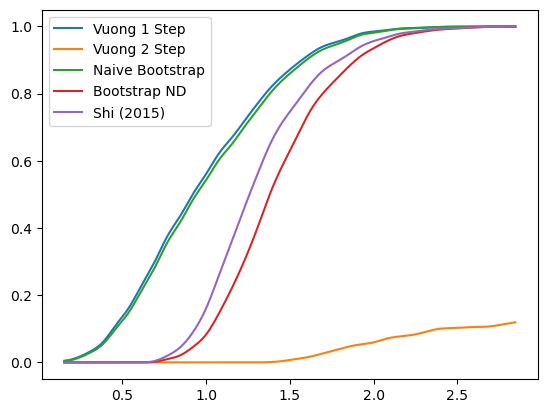

In [14]:
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
